# Project 2
Thomas Torkildsen

# 1. Implementing the training function

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import time

1) Defining the test functions we are going to use. To test the functionality of the training algorithm.

In [355]:

def F1(y):
    return 1/2*np.multiply(y,y)

def F2(y):
    return 1/2*(np.multiply(y[:,0], y[:,0]) + np.multiply(y[:,1], y[:,1]))

def F3(y):
    return 1-np.cos(y)

def F4(y):
        return -1/np.sqrt(y[:,0]*y[:,0] + y[:,1]*y[:,1])
    

2) Defining Choices for functions that can be used in the training algorithm.

In [356]:
#Choises for functions used in the training algorithm

def sig(x):
    if np.size(x) == len(x):
        for i in range(len(x)):
            if x[i] < 0:
                x[i] = 0
    else:
        for i in range(len(x[:,0])):
            for j in range(len(x[0,:])):
                if x[i, j] < 0:
                    x[i, j] = 0
    return x

def prime_sig(x): #derivative of sigma
    for i in range(len(x[:,0])):
        for j in range(len(x[0,:])):
            if x[i, j] < 0:
                x[i, j] = 0
            else:
                x[i, j] = 1
    return x

def sig2(x):
    return np.tanh(x)

def prime_sig2(x): #derivative of sig2
    return 1/(np.cosh(x)*np.cosh(x))


def eta1(x):
    return x

def prime_eta1(x): #derivative of eta1
    return x*0 + 1

def eta2(x):
    return 1/2*(1 + np.tanh(x/2))

def prime_eta2(x): #derivative of eta2
    return 1/(4*np.cosh(x/2)*np.cosh(x/2))


3) Defining the standard gradient descent method and the ADAM method

In [357]:
# Choic
# standard gradient descent does not use m or v, this is only an input to simplify the 
# transition between using adams and stdandard gradient descent.
def std_gradient_descent(theta, dJ, it, m , v):
    a = []

    for i in range(len(theta)):
        a.append(theta[i] - tau * dJ[i])
    return a, m, v

def adams_descent(theta, dJ ,it, m , v):
    a = []
    mm = []
    vv = []
    l = len(theta)
    beta1 = 0.1
    beta2 = 0.999
    alpha = 0.01
    epsilon = 10**(-8)
    for j in range(l):
        m1 = beta1 * m[j] + (1 - beta1) * dJ[j]
        mm.append(m1)
        v1 = beta2*v[j] + (1 - beta2)*(dJ[j]*dJ[j])
        vv.append(v1)

        a.append(theta[j] - alpha*m1/(1 - beta1**it)/(np.sqrt(v1/(1-beta2**it)) + epsilon))

    return a, mm, vv

4) A function that generates input data to the trained function, based on the choice of test function, number of test data, dimention of input data, dimention of the ResNet, the domain of the test data and number of layers.

In [484]:
#generating input

def generate_input(F, I, d0, d, Dom, K):
    Y = np.random.rand(I, d0)  # sett by reading or generating data, look at d0
    a = np.amin(Y)  # max value
    b = np.amax(Y)  # min value
    Y = 1 / (b - a) * ((b - Y) * Dom[0] + (Y - a) * Dom[1]) # scaling the data to fill the whole domain
    C = F(Y)

    bc = np.max(C)
    ac = np.min(C)
    C = (1 / (bc - ac) * ((bc - C)*0.25 + (C - ac) *0.75)).T # scaling the output data. Has to be inbetween 0-1
    
    A = np.amin(Y)
    B = np.amax(Y)
    YY = 1/(B - A) *((B - Y)*0.25 + (Y - A)*0.75)
    
    theta = [] #Defining the first theta values.
    m0 = []    # for adams

    for i in range(K):
        theta.append(np.random.rand(d, d))  # d x d - matrix, Wk-values
        m0.append(np.zeros((d, d)))  # dxd matrix, for adams method

        
    for i in range(K, 2 * K + 1):
        theta.append(np.random.rand(d))  # dim = d, bk-values
        m0.append(np.zeros(d))  # adams

        
    theta.append(np.random.rand(1))  # dim = 1, mu-value
    m0.append(0)     # for adams
    THETA = []
    THETA.append(theta) #Contains all theta values

    Z = np.zeros([K + 1, d, I])
    Z[0, :d0, :I] = YY.T
    P = np.zeros([K + 1, d, I])
    ones = np.ones(I)

    return THETA, Z, P, ones, C, m0, ac, bc, A, B

5) Defineing the training algorithm.

In [447]:
def trainingAlg(THETA, Z, P, ones, C, m0, method, sigma,prime_sigma ,eta ,prime_eta,K , h, tol_its, tol_val = 0):
    # for adams method:
    m = []          # for adams
    m.append(m0)     # for adams

    v = []    # for adams
    v.append(m0)    # for adams

    
    diff = []
    diff.append(3)  # initial value
    its = 0  # initial value
    
    while tol_val < diff[-1] and its < tol_its:
        for k in range(K):
            #defining all Z values based on current theta values
            Z[k+1] = Z[k] + h*sigma((np.matmul(THETA[-1][k], Z[k]).T + THETA[-1][k + K]).T)
        
        
        inp = np.matmul(Z[-1].T, (THETA[-1][-2]).T).T + THETA[-1][-1]      # input for upsilon 
        upsilon = eta(inp)

        P[-1] = np.outer(THETA[-1][-2], (np.multiply((upsilon - C), prime_eta(inp))))   # defining P_K


        for k in range(K,1,-1):
            #defining all P values
            P[k-1] = P[k] + h*np.matmul(THETA[-1][k-1].T, (prime_sigma((np.matmul(THETA[-1][k-1], Z[k-1]).T + THETA[-1][k + K - 1]).T)*P[k])) # ENDRET DEN TRANSPONERTE!!!!
        
        #finding the partial derivatives of J for current theta values
        dJ = []
        dJ2 = []
        for k in range(K):
            inp1 = P[k+1]*prime_sigma((np.matmul(THETA[-1][k], Z[k]).T + THETA[-1][k + K]).T)
            
            dJ.append(h*np.matmul(inp1, Z[k].T)) #dJ/Wk
            dJ2.append(h*inp1.dot(ones.T))


        for k in range(K):
            dJ.append(dJ2[k]) #dJ/bk

        inp2 = prime_eta((Z[-1].T).dot(THETA[-1][-2].T) + THETA[-1][-1])  # dim = d

        dJdmu = np.inner(inp2, (upsilon - C))     
        djdw1 = np.matmul(Z[-1], ((upsilon - C)*inp2).T).T
        djdw = djdw1[0]



        dJ.append(djdw) #dJ/dw
        dJ.append(dJdmu) #dJ/dmu
        #print(dJ)
        # gradient , should include adams
        its += 1
        a1, m1, v1 = method(THETA[-1], dJ, its, m[-1], v[-1]) #using either adams or std. grd. des. to update theta
        THETA.append(a1)
        m.append(m1)     # for adams

        v.append(v1)     # for adams


        #print("diff ", C-upsilon, " C " , C, " upsi ", upsilon )
        diff.append(1/2*np.linalg.norm(C-upsilon)) #checking the accuracy of the newral network.
        print(diff[-1])
        #print(THETA[-1][-2])
    return THETA, diff

# 2. Testing the training function

1) Testing for the different sigma and eta functions

In [448]:
#Test sigma1 vs sigma2...

#constants


# h * K >= 1
# I >= K(d^2 + d) + d + 1


K = 5
tau = 0.01
h = 0.2
I = 110
tol_its = 100



theta1, z1, p1, onez1, c1, m01, ac1, bc1, a1, b1 = generate_input(F1, I, 1, 2, [-2,2], K)
theta2, z2, p2, onez2, c2, m02, ac2, bc2, a2, b2 = generate_input(F2, I, 2, 4, [[-2, -2], [2, 2]], K)
theta3, z3, p3, onez3, c3, m03, ac3, bc3, a3, b3 = generate_input(F3, I, 1, 2,  [-np.pi / 3, np.pi / 3], K)
theta4, z4, p4, onez4, c4, m04, ac4, bc4, a4, b4 = generate_input(F4, I, 2, 4, [[-2, -2], [2, 2]], K)

theta11 = theta1.copy()
z11 = z1.copy()
p11 = p1.copy()


theta21 = theta2.copy()
z21 = z2.copy()
p21 = p2.copy()


theta31 = theta3.copy()
z31 = z3.copy()
p31 = p3.copy()


theta41 = theta4.copy()
z41 = z4.copy()
p41 = p4.copy()



a11, d11 = trainingAlg(theta1, z1, p1, onez1, c1, m01, std_gradient_descent, sig, prime_sig, eta1, prime_eta1, K, h, tol_its)
a21, d21 = trainingAlg(theta2, z2, p2, onez2, c2, m02, std_gradient_descent, sig, prime_sig, eta1, prime_eta1, K, h, tol_its)
a31, d31 = trainingAlg(theta3, z3, p3, onez3, c3, m03, std_gradient_descent, sig, prime_sig, eta1, prime_eta1, K, h, tol_its)
a41, d41 = trainingAlg(theta4, z4, p4, onez4, c4, m04, std_gradient_descent, sig, prime_sig, eta1, prime_eta1, K, h, tol_its)


a12, d12 = trainingAlg(theta11, z11, p11, onez1, c1, m01, std_gradient_descent, sig2, prime_sig2, eta2, prime_eta2, K, h, tol_its)
a22, d22 = trainingAlg(theta21, z21, p21, onez2, c2, m02, std_gradient_descent, sig2, prime_sig2, eta2, prime_eta2, K, h, tol_its)
a32, d32 = trainingAlg(theta31, z31, p31, onez3, c3, m03, std_gradient_descent, sig2, prime_sig2, eta2, prime_eta2, K, h, tol_its)
a42, d42 = trainingAlg(theta41, z41, p41, onez4, c4, m04, std_gradient_descent, sig2, prime_sig2, eta2, prime_eta2, K, h, tol_its)

#J(theta) values below


[[-1.9063078 ]
 [-0.74081185]
 [ 0.73116689]
 [-1.41548785]
 [-1.43974058]
 [-1.43465328]
 [ 0.95362607]
 [ 1.49504494]
 [-0.21677592]
 [-1.19266035]
 [ 1.42765917]
 [-0.14793489]
 [ 1.52692756]
 [ 1.9458608 ]
 [ 1.53229876]
 [ 0.19138857]
 [ 1.4166688 ]
 [-0.58993908]
 [ 0.44124176]
 [-1.44141261]
 [-0.13655719]
 [ 0.59517548]
 [-1.53570513]
 [ 1.59385007]
 [-0.26266435]
 [-0.64497148]
 [ 0.6947323 ]
 [ 1.83215667]
 [-0.93254906]
 [ 1.49281305]
 [ 1.0669041 ]
 [ 1.69797399]
 [-1.97870188]
 [ 1.17379776]
 [ 1.6118572 ]
 [-0.49598159]
 [-0.20364038]
 [ 1.3292242 ]
 [ 0.31258508]
 [-1.0416589 ]
 [ 1.05701515]
 [ 1.83046095]
 [-1.90189346]
 [ 0.4730518 ]
 [-1.42217391]
 [-1.11935792]
 [-0.09778807]
 [-1.69030068]
 [-2.        ]
 [-0.89509221]
 [ 0.3517818 ]
 [-1.66025963]
 [-1.64774955]
 [-0.14922147]
 [ 0.58159614]
 [-0.1564214 ]
 [-1.54985833]
 [ 1.80985824]
 [-0.40195387]
 [-0.37972868]
 [ 1.44032996]
 [-1.08329546]
 [ 0.14593926]
 [-1.48260788]
 [ 0.70828765]
 [-0.1140884 ]
 [ 1.88718

0.8080381721981489
0.8079105887076332
0.8077872588148777
0.8076680084804178
0.8075526706104944
0.807441084783353
0.8073330969861205
0.8072285593618528
0.8071273299663745
0.807029272534545
0.8069342562555989
0.8068421555572168
0.8067528498980012
0.8066662235680365
0.8065821654972316
0.8065005690711453
0.8064213319540128
0.8063443559186996
0.806269546683316
0.8061968137542387
0.8061260702752964
0.8060572328828772
0.8059902215667375
0.805924959536286
0.8058613730921363
0.8057993915027235
0.805738946885787
0.8056799740945342
0.8056224106083011
0.805566196427536
0.8055112739729394
0.8054575879885953
0.8054050854489426
0.8053537154694319
0.8053034292207287
0.8052541798463198
0.8052059223833941
0.8051586136868647
0.805112212356414
0.8050666786664396
0.8050219744987883
0.8049780632781693
0.8049349099101396
0.8048926374239952
0.8048518733418982
0.8048118737125537
0.8047726047510055
0.8047340344363771
0.8046961321139883
0.8046588683831449
0.804622215036372
0.8045861450095905
0.8045506323356736
0

0.6189186369927357
0.61891639914111
0.6189141620208403
0.6189119256315884
0.6189096899730161
0.6189074550447854
0.6189052208465587
0.6189029873779985
0.6189007546387675
0.6188985226285285
0.6188962913469445
0.6188940607936788
0.618891830968395
0.6188896018707565
0.6188873735004273
0.6188851458570716
0.6188829189403533
0.6188806927499371
0.6188784672854872
0.6188762425466691
0.6188740185331472
0.6188717952445869
0.6188695726806537
0.6188673508410131
0.6188651297253308
0.6188629093332729
0.6188606896645056
0.6188584707186952
0.6188562524955081
0.6188540349946112
0.6188518182156716
0.618849602158356
0.6188473868223321
0.6188451722072673
0.6188429583128292
0.6188407451386858
0.6188385326845052
0.6188363209499556
0.6188341099347054
0.6188318996384236
0.6188296900607787
2.720304416196164
2.6643124323836145
2.5962034162235295
2.512943886509861
2.411067538145088
2.287122789532395
2.138725406096536
1.9664113971818098
1.7759186359334125
1.5793501403696786
1.3930332940271504
1.2319450073459879
1.

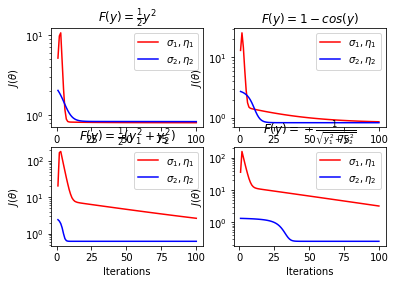

In [450]:
#plotting

its = np.arange(tol_its + 1)
its1 = its[:len(d21)]

its2 = its[:len(d41)]
fig, axs = plt.subplots(2,2)
#fig.suptitle(r'test of $\eta$ and $\sigma$ fuctions')
axs[0, 0].semilogy(its[1:], d11[1:], 'red', label = r'$\sigma_1, \eta_1$')
axs[0, 0].semilogy(its[1:], d12[1:], 'blue', label = r'$\sigma_2, \eta_2$')
axs[0, 0].set_title(r'$F(y) = \frac{1}{2}y^2$')
axs[0, 0].legend()
axs[1, 0].semilogy(its1[1:], d21[1:], 'red', label = r'$\sigma_1, \eta_1$')
axs[1, 0].semilogy(its[1:], d22[1:], 'blue', label = r'$\sigma_2, \eta_2$')

axs[1, 0].set_title(r'$F(y) = \frac{1}{2}(y_1^2 + y_2^2)$')
axs[1, 0].legend()
axs[0, 1].semilogy(its[1:], d31[1:], 'red', label = r'$\sigma_1, \eta_1$')
axs[0, 1].semilogy(its[1:], d32[1:], 'blue', label = r'$\sigma_2, \eta_2$')
axs[0, 1].set_title(r'$F(y) = 1 - cos(y)$')
axs[0, 1].legend()
axs[1, 1].semilogy(its2[1:], d41[1:], 'red', label = r'$\sigma_1, \eta_1$')
axs[1, 1].semilogy(its[1:], d42[1:], 'blue', label = r'$\sigma_2, \eta_2$')
axs[1, 1].set_title(r'$F(y) = - \frac{1}{\sqrt{y_1^2 + y_2^2}}$')
axs[1, 1].legend()

for ax in axs.flat:
    ax.set(xlabel='Iterations', ylabel=r'$J(\theta)$')


2) Testing for different layers.

[[ 0.58614317]
 [ 0.08489935]
 [-1.63461715]
 ...
 [ 1.13241753]
 [-1.87584237]
 [-1.77480805]]
[[0.5732679 ]
 [0.51061242]
 [0.29567286]
 ...
 [0.64155219]
 [0.2655197 ]
 [0.27814899]]
[[ 1.3786919   1.70566416]
 [-0.86878581 -1.26212989]
 [-1.7596759  -1.48211715]
 ...
 [ 0.34394374 -1.6525785 ]
 [-0.62725424  1.24066897]
 [ 0.331154    0.89527343]]
[[0.67233649 0.71320802]
 [0.39140177 0.34223376]
 [0.28004051 0.31473536]
 ...
 [0.54299297 0.29342769]
 [0.42159322 0.65508362]
 [0.54139425 0.61190918]]
[[ 0.84709021]
 [ 0.90357828]
 [ 0.75668217]
 ...
 [-0.79205006]
 [ 0.4179913 ]
 [ 0.94501743]]
[[0.70222789]
 [0.71571342]
 [0.68064456]
 ...
 [0.31091198]
 [0.59978807]
 [0.72560629]]
[[ 1.07119439 -1.10404317]
 [-1.55606856 -0.70581367]
 [ 1.40818893 -1.28084205]
 ...
 [ 0.24032104  0.93270561]
 [-1.3876524  -0.15404323]
 [-0.33984807  0.1717549 ]]
[[0.6338993  0.3619946 ]
 [0.30549143 0.41177329]
 [0.67602362 0.33989474]
 ...
 [0.53004013 0.6165882 ]
 [0.32654345 0.4807446 ]
 [0.45

3.3692950173228904
3.3692639658058976
3.3692327378898326
3.369201332148253
3.3691697471409916
3.369137981413991
3.3691060334991323
3.3690739019140605
3.369041585162012
3.3690090817316305
3.3689763900967926
3.3689435087164212
3.3689104360343
3.3688771704788825
3.368843710463106
3.368810054384191
3.3687762006234476
3.368742147546077
3.3687078935009627
3.368673436820471
3.3686387758202394
3.3686039087989625
3.368568834038179
3.3685335498020565
3.368498054337163
3.368462345872247
3.368426422618007
3.3683902827668635
3.368353924492718
3.3683173459507185
3.3682805452770177
3.368243520588525
3.3682062699826583
3.3681687915370895
3.368131083309489
3.3680931433372625
3.36805496963729
3.3680165602056507
3.367977913017356
3.3679390260260686
3.3678998971638214
3.3678605243407316
3.367820905444713
3.3677810383411773
3.3677409208727367
3.3677005508589013
3.367659926095768
3.367619044355707
3.367577903387047
3.367536500913749
3.3674948346350773
3.367452902225269
3.3674107013331915
3.3673682295820013


3.0746556919504617
3.0974950483853023
3.0399197240965337
3.06235617901106
3.0077113417571355
3.030624540979628
2.9781636039751747
3.0022187248690093
2.9510583734023665
2.976694375989308
2.9258886687759347
2.9532981895889976
2.901895958432131
2.9310091761807264
2.8781227635071955
2.9086151444851103
2.853510633312571
2.884851304464952
2.82704741757767
2.8585901509064575
2.7979338565509435
2.829032362949342
2.7657167269464584
2.795832305800553
2.730341566714505
2.7591135538536977
2.6921110222072437
2.719377090442535
2.6515733803420565
2.677346220956952
2.609386351532705
2.6338048316563163
2.5661969107168403
2.58947065103003
2.5225592486700177
2.5449197329501954
2.4788939230753164
2.5005581935118197
2.435480042946577
2.4566279526326547
2.39246910102209
2.413232567835006
2.349910575584672
2.370372531071662
2.3077823554510033
2.327983140811994
2.2660215595532356
2.2859707641853557
2.2245529334593117
2.24424487465466
2.1833129453703846
2.20274418190704
2.1422683919730274
2.1614559698151083
2.

2.3926364753757
2.3926307199866885
2.392624961960529
2.3926192012497625
2.3926134378078894
2.392607671589343
2.3926019025494694
2.3925961306444994
2.3925903558315325
2.3925845780685107
2.3925787973142016
2.392573013528174
2.3925672266707823
2.392561436703142
2.392555643587117
2.392549847285295
2.392544047760975
2.3925382449781463
2.3925324389014735
2.392526629496278
2.3925208167285237
2.3925150005648015
2.3925091809723122
2.3925033579188524
2.3924975313728005
2.392491701303103
2.392485867679257
2.3924800304713028
2.392474189649805
2.392468345185844
2.3924624970509996
2.3924566452173432
2.392450789657422
2.3924449303442485
2.392439067251292
2.3924332003524635
2.3924273296221075
2.3924214550349894
2.392415576566289
2.3924096941915867
2.392403807886855
2.392397917628451
2.3923920233931035
2.392386125157907
2.3923802229003117
2.3923743165981146
2.392368406229452
2.392362491772791
2.3923565732069205
2.392350650510945
2.3923447236642765
2.392338792646626
2.3923328574379985
2.3923269180186826

2.389439387800532
2.389430828231362
2.389422260135414
2.3894136835013757
2.3894050983179254
2.3893965045737313
2.3893879022574533
2.3893792913577423
2.389370671863239
2.3893620437625755
2.389353407044376
2.389344761697253
2.3893361077098123
2.3893274450706485
2.3893187737683492
2.3893100937914915
2.3893014051286436
2.3892927077683654
2.3892840016992065
2.3892752869097085
2.3892665633884036
2.3892578311238157
2.389249090104457
2.3892403403188345
2.389231581755444
2.3892228144027716
2.389214038249297
2.389205253283489
2.389196459493807
2.389187656868704
2.3891788453966205
2.389170025065992
2.3891611958652414
2.389152357782786
2.389143510807031
2.3891346549263757
2.3891257901292087
2.3891169164039106
2.389108033738852
2.389099142122397
2.389090241542898
2.3890813319887005
2.389072413448141
2.389063485909547
2.3890545493612367
2.3890456037915206
2.3890366491886996
2.389027685541066
2.389018712836904
2.389009731064488
2.389000740212085
2.388991740267953
2.38898273122034
2.3889737130574877
2

3.3699631240878496
3.3699519369982993
3.3699406860897367
3.369929370631154
3.369917989885166
3.3699065431079256
3.369895029549042
3.3698834484514917
3.369871799051536
3.3698600805786305
3.3698482922553405
3.369836433297249
3.369824502912868
3.3698125003035484
3.3698004246633855
3.36978827517913
3.3697760510300885
3.3697637513880347
3.369751375417108
3.3697389222737186
3.3697263911064503
3.3697137810559585
3.3697010912548713
3.369688320827687
3.369675468890673
3.369662534551759
3.369649516910432
3.3696364150576357
3.3696232280756533
3.3696099550380056
3.369596595009339
3.3695831470453133
3.369569610192489
3.369555983488214
3.369542265960508
3.369528456627946
3.36951455449954
3.3695005585746176
3.3694864678427057
3.369472281283403
3.369457997866259
3.36944361655065
3.3694291362856497
3.3694145560099016
3.369399874651491
3.3693850911278114
3.369370204345434
3.3693552131999716
3.369340116575944
3.369324913346639
3.369309602373973
3.3692941825083524
3.3692786525885294
3.3692630114414563
3.3

3.614578650436455
3.5331298433415914
3.5243115337907622
3.4714323099721014
3.4636826555782276
3.4284847035261725
3.4225727303593856
3.3984392450185337
3.3942882356194546
3.3772032148941395
3.374533497021244
3.3620438329111475
3.3605968063535228
3.3511886908201762
3.3507912723677338
3.343521082171342
3.344096643549547
3.338373061979976
3.3399396809504123
3.3353940549190755
3.3380646247214143
3.334471686611191
3.338460159414772
3.3356855309287647
3.341319042948877
3.3392769983590034
3.347010085997944
3.3456174191276755
3.3560394605140274
3.355151319742825
3.3689706042346548
3.368285782193643
3.386264877725537
3.385198971866409
3.4080141352684192
3.4055700060642584
3.433588258741029
3.4283065243446864
3.4613320189042533
3.451446343310189
3.4885641336850264
3.472435134578867
3.5120988677536635
3.488805735185353
3.5292000995965456
3.498960591980716
3.5384775560353976
3.502607095807093
3.540193799255889
3.500635568472759
3.53588586578449
3.4946212269626025
3.527659238106096
3.486288593443559

6.140761345700056
6.14075911884546
6.140756883169569
6.140754638620066
6.140752385144216
6.140750122688867
6.140747851200448
6.140745570624961
6.140743280907976
6.140740981994628
6.140738673829617
6.140736356357196
6.14073402952117
6.140731693264894
6.140729347531266
6.140726992262723
6.140724627401231
6.140722252888293
6.140719868664929
6.140717474671684
6.140715070848615
6.140712657135289
6.14071023347078
6.140707799793658
6.14070535604199
6.140702902153331
6.14070043806472
6.140697963712677
6.140695479033194
6.140692983961728
6.140690478433202
6.140687962381994
6.140685435741935
6.1406828984462996
6.140680350427799
6.140677791618584
6.1406752219502305
6.140672641353734
6.140670049759508
6.140667447097372
6.140664833296553
6.140662208285672
6.1406595719927415
6.140656924345155
6.140654265269685
6.140651594692476
6.140648912539033
6.14064621873422
6.140643513202249
6.140640795866679
6.140638066650398
6.140635325475627
6.1406325722639075
6.1406298069360945
6.140627029412349
6.140624239

6.131573673475491
6.131391696090769
6.131203301195775
6.13100814649667
6.1308058650682264
6.13059606310783
6.130378317440058
6.130152172738995
6.129917138430445
6.129672685230282
6.129418241268257
6.129153187738349
6.12887685400698
6.128588512098899
6.12828737046665
6.127972566933
6.127643160675815
6.127298123100844
6.126936327418781
6.126556536707617
6.126157390198054
6.125737387466764
6.1252948701568855
6.124828000764225
6.124334737926807
6.12381280752922
6.123259668774369
6.1226724741740695
6.122048022153548
6.121382700636077
6.1206724195492415
6.119912529641632
6.119097724274033
6.118221919890887
6.117278109599719
6.11625818256534
6.115152699585846
6.113950612001693
6.112638906619325
6.111202153041156
6.109621920826309
6.10787602093809
6.105937506889107
6.103773342553928
6.1013426003654585
6.0985939865033965
6.095462383255155
6.091863925799584
6.087688842006282
6.082790787293185
6.076970523019639
6.069950153227131
6.061330978742879
6.050521615555748
6.036609204669642
6.018114605073

4.304226992064456
5.663479677527806
7.592371143506763
3.5013288884949922
4.010052262277699
5.401198009246053
5.3909672165087
7.042385609712707
3.3128710178948957
3.3800036445250727
3.5701315044201785
4.144173895459374
4.826825427881156
6.2427945207203495
3.975133182291079
4.882681062944653
4.822679647195888
5.94813242493845
4.012477944711328
4.746779304837834
4.538945060279762
5.378025637910997
4.208138659049513
4.85247653068409
4.292812441723833
4.875076757988528
4.190948773358789
4.667692427712532
4.133691665831525
4.530222687689493
4.06644071245862
4.391951428536371
3.9994356590341633
4.264653095513006
3.933664261610917
4.148169316710244
3.870205974931066
4.042466005989558
3.8098988590229355
3.947279023642699
3.7533365587865917
3.862153965020658
3.700891704883844
3.786498216975107
3.652748437950592
3.7196289430633374
3.608937838925827
3.660814113633956
3.569372504347749
3.6093058278422445
3.53387800615826
3.5643660739360308
3.5022200702640682
3.5252855871250897
3.474127078438545
3.4

3.2819020034454565
3.281895089129972
3.281888159482762
3.281881214440597
3.281874253940785
3.2818672779196922
3.2818602863141915
3.2818532790602406
3.2818462560942763
3.281839217351842
3.2818321627689357
3.2818250922806813
3.2818180058226347
3.2818109033294984
3.2818037847363812
3.2817966499775593
3.2817894989876915
3.2817823317006245
3.281775148050563
3.281767947970918
3.28176073139544
3.2817534982570993
3.2817462484891857
3.2817389820242275
3.281731698795051
3.2817243987337354
3.28171708177264
3.281709747843393
3.281702396877883
3.28169502880728
3.281687643563
3.2816802410757515
3.281672821276472
3.2816653840954055
3.281657929463008
3.281650457309053
3.2816429675635104
3.281635460155681
3.281627935015046
3.281620392070426
3.2816128312508095
3.2816052524845345
3.281597655700092
3.2815900408253333
3.281582407788248
3.281574756516195
3.2815670869366595
3.281559398976504
3.281551692562705
3.281543967621623
3.281536224079722
3.281528461862858
3.2815206808969766
3.2815128811074237
3.281505

3.275752108486022
3.275726500427285
3.27570080441006
3.275675020042272
3.2756491470139535
3.275623184925785
3.2755971334692044
3.2755709922371707
3.2755447609230397
3.275518439111521
3.2754920264984757
3.2754655226597857
3.275438927294488
3.2754122399689956
3.2753854603862926
3.2753585881026166
3.2753316228257843
3.2753045641010825
3.2752774116421786
3.2752501649825527
3.275222823842904
3.2751953877439632
3.2751678564148263
3.2751402293624454
3.2751125063258986
3.2750846867972316
3.275056770527354
3.275028756992178
3.2750006459566077
3.2749724368790893
3.2749441295410646
3.2749157233820756
3.2748872182031077
3.2748586134232527
3.2748299088666077
3.274801103930171
3.2747721984654112
3.2747431918455003
3.2747140839543927
3.274684874139635
3.2746555623238467
3.2746261478271075
3.274596630618223
3.2745670099879627
3.2745372859605366
3.2745074577956115
3.2744775255841887
3.274447488553159
3.2744173468744857
3.2743870997408204
3.2743567474228716
3.2743262890779037
3.2742957250978715
3.274265

2.39178870518862
2.3917860275211
2.391783342233013
2.391780649572852
2.391777949781244
2.3917752430911916
2.3917725297283106
2.39176980991106
2.391767083850964
2.3917643517528284
2.39176161381495
2.3917588702293178
2.391756121181813
2.3917533668523974
2.3917506074152994
2.3917478430391936
2.391745073887374
2.391742300117923
2.391739521883876
2.3917367393333775
2.391733952609837
2.3917311618520762
2.391728367194474
2.391725568767107
2.3917227666958816
2.3917199611026714
2.3917171521054392
2.391714339818362
2.39171152435195
2.3917087058131634
2.3917058843055243
2.391703059929225
2.391700232781232
2.391697402955391
2.391694570542523
2.391691735630521
2.3916888983044444
2.391686058646604
2.3916832167366544
2.391680372651676
2.391677526466256
2.391674678252569
2.391671828080452
2.391668976017479
2.3916661221290343
2.39166326647838
2.391660409126726
2.3916575501332926
2.391654689555373
2.3916518274484
2.391648963865999
2.3916460988600488
2.3916432324807366
2.3916403647766113
2.39163749579463

2.3905026647185603
2.3904997395962013
2.3904968142437224
2.3904938886601426
2.3904909628444813
2.3904880367957566
2.390485110512989
2.3904821839951973
2.3904792572414015
2.390476330250621
2.390473403021877
2.3904704755541877
2.3904675478465744
2.390464619898058
2.390461691707658
2.390458763274395
2.390455834597291
2.3904529056753656
2.3904499765076412
2.390447047093138
2.390444117430878
2.390441187519882
2.3904382573591727
2.3904353269477707
2.3904323962846994
2.39042946536898
2.3904265341996345
2.3904236027756856
2.390420671096156
2.390417739160068
2.3904148069664446
2.3904118745143084
2.390408941802683
2.39040600883059
2.3904030755970544
2.3904001421010994
2.3903972083417484
2.3903942743180244
2.3903913400289523
2.390388405473555
2.390385470650857
2.390382535559883
2.390379600199657
2.3903766645692026
2.3903737286675457
2.39037079249371
2.3903678560467214
2.390364919325604
2.390361982329383
2.3903590450570835
2.3903561075077313
2.3903531696803513
2.39035023157397
2.390347293187612
2.

3.3490964312393694
3.349077623163081
3.3490587666363676
3.3490398624880116
3.349020909325705
3.3490019079244653
3.348982856952057
3.348963757134421
3.3489446071938382
3.3489254078113495
3.3489061577587766
3.348886857675988
3.348867506379879
3.348848104472484
3.3488286508117495
3.3488091459648723
3.348789588827223
3.348769979933853
3.3487503182142824
3.348730604173843
3.3487108367732374
3.348691016490269
3.348671142314133
3.348651214697086
3.348631232654371
3.3486111966144976
3.348591105616525
3.3485709600668514
3.348550759026321
3.3485305028807093
3.3485101907107833
3.348489822883059
3.3484693984965177
3.3484489178996633
3.3484283802081243
3.3484077857535355
3.34838713366673
3.3483664242635247
3.348345656688623
3.348324831242999
3.34830394708399
3.3482830044986263
3.348262002655735
3.348240941829236
3.348219821198382
3.34819864102476
3.348177400497052
3.348156099865236
3.348134738326499
3.348113316119885
3.348091832450215
3.3480702875462356
3.348048680619585
3.348027011889307
3.3480052

3.3370754832682747
3.3370072236619683
3.336660850312615
3.336596573710645
3.3362688162687033
3.336208518572444
3.3358975904941195
3.335841282806779
3.3355455958725226
3.3354933082622926
3.335211449999767
3.33516323477559
3.3348939487496283
3.334849883416959
3.3345920520224412
3.3345522420598694
3.334304871500567
3.3342694530777433
3.3340316602552424
3.334000802997119
3.333771804069556
3.3337457139608393
3.3335248143619194
3.3335037368780087
3.333290322613198
3.333274546159399
3.333068076218615
3.3330579359575307
3.3328579357025903
3.332853817850091
3.3326598732507935
3.332662219923494
3.332473972528821
3.3324832872304877
3.3323004297710446
3.3323172836115216
3.3321395561361715
3.332164594884229
3.3319917813377553
3.3320257334185355
3.3318576585680706
3.33190134412641
3.3317378707419962
3.331792211904631
3.3316332380933176
3.331699270575615
3.3315447271585055
3.3316236133744868
3.331473461181443
3.331566505029025
3.331420731965678
3.3315293954714695
3.3313880131867077
3.331513935205439


5.82820767084672
5.827758344034175
5.82728430746976
5.826783480582141
5.826253543781693
5.825691903278641
5.825095649522812
5.82446150787852
5.823785779793764
5.823064272263573
5.82229221278744
5.821464146230935
5.8205738089528
5.819613974153426
5.818576260499062
5.817450893476588
5.816226405340215
5.81488925448512
5.813423337961463
5.8118093606125685
5.810024009405799
5.808038859422638
5.805818904640464
5.803320555385198
5.8004888638420775
5.797253609612713
5.793523663823247
5.789178687754341
5.7840565860126
5.777933977006116
5.770494747663188
5.761277387469439
5.749582591213014
5.734301913024935
5.713577847602055
5.684070592130927
5.639198197345116
5.564274786113472
5.420213798861701
5.071271554563927
3.802666163152253
3.3839964550418147
5.738347010666707
5.719425041237068
5.69295995802301
5.65368972111553
5.5904104456374455
5.47526059813738
5.221132238223638
4.439095010781039
0.6105242587427611
1.4794713106396054
4.290661781008704
0.7210006345107964
2.0184915308959765
6.046167451648

1.3982755987936024
1.110492183891185
1.3644800159019101
1.092009789525756
1.3315439640051348
1.0736819168068543
1.299477747948192
1.055537872906063
1.2682887590462357
1.0376050005401356
1.237981617802117
1.0199086309074632
1.2085583258482866
1.0024720576523731
1.1800184244708185
0.9853165300701396
1.1523591573062706
0.968461263678112
1.1255756350509873
0.9519234662428536
1.0996610002785185
0.9357183773621515
1.0746065907164677
0.9198593197465369
1.0504020995830559
0.904357760420174
1.0270357318209478
0.889223380158646
1.0044943552875525
0.8744641495948782
0.9827636461643857
0.8600864105485272
0.9618282280313535
0.8460949612637896
0.9416718042141486
0.832493144371544
0.9222772831541837
0.8192829365208043
0.9036268966710588
0.8064650387489649
0.8857023110884997
0.7940389667783527
0.868484731277283
0.7820031405368489
0.8519549977345264
0.7703549723019413
0.8360936768696141
0.7590909529601766
0.8208811447048362
0.7482067359575125
0.8062976642253937
0.7376972185908192
0.7923234566306251
0.7

5.290956464102896
7.924987758977856
3.7004188595028276
4.909698528061939
7.510525960394264
3.408395119654835
3.6321340899897763
4.636593020336912
7.1183708945672395
4.011114986425302
5.881893788630637
6.251099977426905
8.314033755732707
5.181612829722808
6.526229338924497
8.324288409004419
5.296842782244135
6.359087437836831
8.192562817876343
4.860428978767328
6.2196671032822115
8.059678272167465
4.464863254899917
5.868280639365297
7.8176131733474
3.8349827458915553
4.855341803232353
6.913739111329259
3.8476892248498045
5.054401951660033
5.887301173526598
7.6655916460860904
3.6340139261470488
4.261075626142968
5.87826204539321
5.230672613172585
7.086490928830058
3.4694288166301117
3.765194560596569
4.504449527290074
6.171096522475372
4.694959295932497
6.385198097085165
4.320799639533302
5.782067576643238
5.006372059313341
6.638895181430178
3.8428024598265402
4.748340880602677
5.279398248805304
6.794041440452545
3.5816225269437
4.028968597717764
4.6923927670969015
6.1064061717878895
4.3

3.360787161224884
3.3607791599309182
3.3607707557001016
3.360762831562672
3.3607545340115212
3.360746683199886
3.3607384862810927
3.360730705139803
3.3607226031505273
3.3607148881918856
3.360706875753098
3.3606992236498754
3.360691295686995
3.3606837032654115
3.3606758549901476
3.360668319223107
3.3606605461164363
3.360653064117012
3.360645361913207
3.3606379309283776
3.3606302956000262
3.3606229130046557
3.3606153407486032
3.3606080040396535
3.360600491263809
3.360593198054786
3.3605857413657416
3.360578489381368
3.36057108557277
3.3605638726438762
3.3605565186855078
3.3605493427441333
3.3605420357716627
3.3605348948463654
3.360527632151715
3.3605205243630802
3.360513303385374
3.360506226941716
3.3604990452587806
3.360491998452028
3.3604848537723995
3.3604778349741617
3.3604707251295722
3.360463732787384
3.3604566557256996
3.3604496883594215
3.360442642138002
3.360435698336391
3.3604286811158426
3.3604217595332737
3.3604147695715723
3.360407868924908
3.3604009045718723
3.3603940236374

3.35759033252945
3.357582109207274
3.3575738778719315
3.3575656386090897
3.3575573912919654
3.3575491360061354
3.3575408726247504
3.3575326012333266
3.3575243217049167
3.357516034125007
3.357507738366523
3.357499434514948
3.3574911224430495
3.35748280223634
3.3574744737673985
3.357466137121794
3.357457792171887
3.3574494390033327
3.357441077488244
3.357432707712392
3.357424329547609
3.3574159430798125
3.357407548180524
3.357399144935838
3.3573907332169344
3.357382313110113
3.3573738844861816
3.3573654474316763
3.3573570018170016
3.3573485477289595
3.35734008503752
3.3573316138297833
3.357323133975251
3.3573146455613525
3.35730614845709
3.3572976427502543
3.357289128309314
3.3572806052224524
3.357272073357574
3.357263532803287
3.3572549834268965
3.3572464253174683
3.357237858341675
3.3572292825890737
3.3572206979256713
3.3572121044415475
3.3572035020020072
3.3571948906976923
3.3571862703931674
3.3571776411796694
3.3571690029209895
3.357160355708996
3.3571516994066672
3.357143034106539
3

9.007047071332098
7.944263491442449
2.6449287987832286
3.984590583969326
7.784313735274015
2.457101341637629
2.460897190891159
2.524817767312462
3.0703216949454357
5.853149354681423
7.572385667686595
8.970214415393574
7.8952808148419775
2.7793698072425146
4.446678563589158
7.975293499391772
3.1576729777336023
5.683303304631747
8.590096150478745
6.325505871945127
5.722651174940369
8.467302145003103
5.8530483262237505
6.237884451097558
8.451500718828623
5.92194518037293
5.740375198848724
8.148369232298645
4.670621238650742
6.361690629111352
8.133350796922578
4.7888213433870845
6.010780920620726
7.860771943706335
3.8561698017223573
5.409701422556153
7.446884919863541
2.770686061022594
3.4441130282958716
5.227038472133611
5.128295154797107
7.049373295186316
2.485846219923045
2.489904008363684
2.498795759087767
2.5551584511409464
2.723278266358255
3.356911934356141
4.408909499250394
6.307324350202017
3.2877805941729057
4.62487606255459
4.8819044582999
6.506238757810517
2.788402459939363
3.3

2.446627034229469
2.446589808570264
2.4466075625640373
2.4465712598903564
2.4465881268196297
2.44655271500111
2.446568726109351
2.446534174207772
2.446549359587198
2.4465156378098945
2.4465300264459184
2.446497106101109
2.446510725914995
2.4464785793689408
2.446491457258746
2.4464600578946514
2.446472219774526
2.446441541953127
2.4464530127910398
2.446423031812786
2.4464338356667428
2.4464045277355186
2.446414687788334
2.44638602997665
2.446395568569332
2.4463675387849237
2.4463764774487307
2.446349054402505
2.4463574138897286
2.446330577065
2.4463383773785288
2.4463121070014946
2.446319367423202
2.446293644434601
2.446300383552614
2.4462751895805197
2.4462814253154113
2.4462567426491093
2.446262492279057
2.4462383038439697
2.446243584028923
2.44621987336253
2.4462247001674298
2.446201451396143
2.446205840313229
2.446183038130185
2.446187004100432
2.446164633744165
2.4461681911778768
2.4461462384118344
2.446149401208435
2.446127852301298
2.4461306338683544
2.4461094755751334
2.44611188

3.385641752278917
3.3862941976990144
3.384454843731814
3.3850502172866133
3.383326027082675
3.3838691406625325
3.3822522838144877
3.3827475451513567
3.3812307528142065
3.381682199424299
3.3802587224903022
3.380670052771459
3.379333623235082
3.379708224955495
3.378453020222912
3.3787939966185383
3.377614606534875
3.3779248002150672
3.376816196599952
3.3770982114444497
3.376055719942462
3.3763119411577915
3.3753312152253003
3.3755638277147626
3.374640824578365
3.3748518297670063
3.373982788201522
3.3741740194457677
3.3733554392314935
3.373528575932319
3.372757198862097
3.3729137793907262
3.3721865717074384
3.3723280052434497
3.3716421413977957
3.3717697187711666
3.3711225663981472
3.3712374700191137
3.3706265760395393
3.370729888993099
3.3701529667537202
3.3702456811291803
3.369700598501763
3.3697836230217986
3.369268391387665
3.369342558395938
3.368855322448215
3.3689213943096448
3.3684604226107266
3.3685190975739236
3.368082773810518
3.3681346913777346
3.367721506260348
3.3677672521064

3.3572131733606163
3.3571910297488894
3.3573271700086207
3.357304036180061
3.357448397619038
3.35742413469256
3.357577186989351
3.3575516411047484
3.357713879633219
3.357686880565205
3.357858827467181
3.357830187136069
3.358012392383127
3.3579819032583162
3.3581749456923045
3.358142379085342
3.358346867425644
3.3583119716704304
3.358528545474263
3.3584910439929705
3.358720374553191
3.358679963807674
3.3589227549705925
3.3588791023006066
3.359136091184229
3.359088832535544
3.3593607901265194
3.3593095276741596
3.3595972592794596
3.359541558953769
3.3598459044808555
3.35978529340698
3.3601071274439516
3.360041091308586
3.360381322973569
3.360309303336534
3.360668875863475
3.3605902674358252
3.360970157461905
3.3608843053768482
3.3612855218950743
3.361191719002987
3.3616153019421904
3.361512786166404
3.3619598045600245
3.3618477563558056
3.362319306060551
3.3621968460257077
3.3626940469515816
3.3625602336433387
3.3630842264577785
3.3629380544767833
3.363489996747842
3.3633303951563267
3.3

6.122172128949644
6.12216208555754
6.122151958433616
6.122141746526757
6.122131448768187
6.122121064071099
6.12211059133027
6.1221000294216745
6.122089377202074
6.122078633508618
6.122067797158406
6.1220568669480695
6.122045841653316
6.122034720028477
6.12202350080604
6.1220121826961655
6.122000764386198
6.121989244540152
6.121977621798199
6.121965894776129
6.1219540620648045
6.121942122229593
6.121930073809794
6.121917915318039
6.121905645239681
6.121893262032173
6.1218807641244135
6.12186814991609
6.121855417776994
6.12184256604632
6.121829593031945
6.12181649700969
6.121803276222552
6.121789928879923
6.121776453156782
6.121762847192869
6.121749109091824
6.121735236920309
6.121721228707108
6.121707082442188
6.121692796075743
6.121678367517208
6.1216637946342365
6.121649075251654
6.1216342071503815
6.1216191880663136
6.121604015689181
6.121588687661363
6.121573201576673
6.121557554979094
6.121541745361492
6.121525770164272
6.121509626774008
6.121493312522012
6.121476824682871
6.121460

6.123829438655177
6.123828456480362
6.123827471770047
6.123826484514403
6.123825494703544
6.123824502327537
6.123823507376396
6.123822509840084
6.123821509708508
6.123820506971528
6.123819501618948
6.1238184936405196
6.123817483025939
6.12381646976485
6.123815453846844
6.123814435261453
6.123813413998157
6.123812390046381
6.123811363395494
6.123810334034807
6.123809301953575
6.123808267140998
6.123807229586219
6.12380618927832
6.123805146206329
6.12380410035921
6.123803051725874
6.123802000295172
6.123800946055893
6.123799888996765
6.123798829106461
6.123797766373587
6.123796700786693
6.1237956323342635
6.123794561004724
6.123793486786434
6.123792409667694
6.123791329636739
6.12379024668174
6.123789160790809
6.123788071951982
6.123786980153242
6.1237858853825005
6.123784787627603
6.123783686876333
6.123782583116399
6.123781476335453
6.123780366521069
6.123779253660759
6.123778137741964
6.123777018752058
6.123775896678344
6.123774771508053
6.123773643228349
6.123772511826322
6.123771377

11.070057522715661
4.299041921385618
6.601498347274953
8.725113519664713
6.4976247691096525
5.98910452152705
8.500784335836519
5.5051346080983175
7.104417338245638
8.748219019857123
6.647085222976263
5.547321783253361
8.202006653843362
4.326858290395188
6.464457745880888
8.585326964133515
5.9702867501675785
6.54793455743612
8.575146606530245
5.955925084112863
6.491745399005415
8.527690717283592
5.779292525576727
6.595888870975381
8.51904546151183
5.775319487183163
6.524646816145268
8.465519012434722
5.579701811108925
6.5950893941044155
8.44546129696292
5.531004122959783
6.547815877204259
8.39503559665995
5.3577955286565935
6.547586621949055
8.354926022054867
5.2324200135450845
6.502947455791435
8.302070686621308
5.061005550270615
6.437363502520432
8.241672136491305
4.867981769628356
6.328442814116351
8.165225742005639
4.6267081374377375
6.140824314890934
8.053770595200586
4.288136084526407
5.758420437720681
7.825464291711281
3.7131550895420027
4.613240323737453
6.698357389642518
4.4692

3.4170744662828816
3.412759795342636
3.415637064854799
3.411486328778332
3.414240691109805
3.4102473406040468
3.412884154816802
3.4090419072307343
3.411566298896949
3.407869127403262
3.4102859985994467
3.4067281218027277
3.409042160691871
3.4056180326475802
3.4078337226651874
3.404538023294185
3.40665965195352
3.4034872778374026
3.4055189451687533
3.4024650007117363
3.404410627349994
3.4014704162935434
3.4033337512278914
3.4005027685047775
3.4022873965038123
3.399561320418697
3.4012706691438246
3.398645353867938
3.4002827006874283
3.397754169055311
3.399322647570959
3.3968870841676653
3.39838969046557
3.396043434993128
3.3974830336296757
3.3952225745419997
3.3966019042757423
3.394423872671561
3.3957455519512694
3.3936467157150205
3.3949132479338355
3.3928905061148296
3.3941042846400333
3.3921546620605314
3.3933179750481233
3.391438617131333
3.392553652134239
3.3907418199435395
3.3918106683219507
3.3900637338029878
3.3910883949449935
3.3894038363625985
3.390386221722975
3.38876161928514

3.3626747470637373
3.3626295229287257
3.3626666547846606
3.3626213244459744
3.362659167984042
3.362613719865971
3.3626522974172297
3.3626067197320464
3.362646054244086
3.362600334977659
3.362640450036477
3.3625945769334105
3.362635496785946
3.36258945733422
3.362631206911559
3.3625849883266397
3.362627593267912
3.3625811824763145
3.3626246691533046
3.362578052775564
3.3626224483180565
3.362575612651098
3.362620944972972
3.3625738759718296
3.36262017379793
3.3625728570567968
3.3626201499505988
3.36257257068317
3.3626208890752523
3.36257303209433
3.3626224073116853
3.3625742570080117
3.362624721304206
3.3625762616244796
3.3626278482106846
3.362579062634741
3.3626318057116564
3.362582677228759
3.362636612019439
3.3625871231036477
3.362642285887254
3.3625924184718388
3.3626488466183386
3.362598582069178
3.362656314074993
3.3626056331629366
3.362664708687569
3.3626135915597106
3.362674051463351
3.362622477613163
3.3626843639953004
3.362632312231595
3.3626956684706295
3.362643116885295
3.362

9.550862741861645
9.527661998773926
9.490471317164692
9.422973980902798
9.272759979560659
8.782128113547873
5.160790580428099
12.454138684905436
5.581373928569551
9.601745890606002
9.597331791819679
9.591907940856588
9.58509340233517
9.576293305020076
9.564528250190797
9.548074369032783
9.523621720023064
9.484020272273085
9.410990220846942
9.243892699132786
8.666486933094
4.024138104297098
12.00417658467314
4.263390112621232
12.16242982057842
2.58741127339924
6.006052545575617
9.610967163726851
9.608351511502182
9.605289160665196
9.601657298618855
9.597284343485793
9.591923468945009
9.58520706531759
9.576564212667764
9.565061354087035
9.549069633987836
9.52549759528215
9.487773544329187
9.419489218947136
9.268255889582083
8.779535831259176
5.270085035891003
12.372570728646199
4.354516916769679
9.46386953702209
9.371604196118906
9.140476193263513
8.174653014790135
3.8977698810602663
9.299560525777897
8.906397072437287
6.515076009314545
11.7388217268193
6.523379079813979
11.7002581644856

3.51998721158914
3.1867565649702008
3.4716427134606342
3.1579247905075527
3.4246788884936876
3.1294959106873237
3.3791145666062405
3.101519980500558
3.3349634340851
3.0740425765888015
3.2922341991422086
3.0471047659015293
3.250930786085014
3.0207431194780527
3.211052554371617
2.9949897669920724
3.1725945388133994
2.969872487570371
3.135547707223474
2.945414832367214
3.09989923188463
2.9216362744278013
3.065632771321814
2.898552381493616
3.0327287590084024
2.8761750075768355
3.001164695809006
2.8545124993484903
2.970915443160857
2.8335699136355155
2.9419535142173987
2.813349242596114
2.914249360417536
2.793849643433133
2.8877716511980536
2.7750676698044487
2.8624875448307896
2.7569975023920064
2.838362948635861
2.7396311763918435
2.8153627670932804
2.7229588039822
2.7934511366434656
2.706968790111821
2.7725916462284825
2.691648040223014
2.752747542876662
2.676982158781523
2.7338819218703145
2.662955637725868
2.7159579012569104
2.6495520341712524
2.698938780666063
2.636754136906372
2.682

3.9518058567738046
4.089572163429021
3.940435252428569
4.072773127001435
3.929236868135316
4.0563455459571225
3.9182121569467916
4.040284438391405
3.90736230892279
4.024584714139937
3.8966882632495263
4.009241186853893
3.886190720171198
3.9942485855282333
3.8758701527086306
3.9796015654945758
3.8657268181434894
3.9652947188909655
3.855760769249773
3.9513225846214404
3.8459718652572654
3.9376796578187725
3.836359782534295
3.924360398824092
3.826924024979592
3.911359241697361
3.817663934115212
3.898670602272793
3.8085786988744745
3.886288885773411
3.799667365080625
3.874208493998919
3.79092884461351
3.8624238321010282
3.782361924262968
3.850929314960284
3.7739652742688983
3.839719373178294
3.7657374565490604
3.8287884586991083
3.757676932616652
3.818131050073298
3.749782071190577
3.80774165737807
3.742051155502051
3.797614826806528
3.734482390301862
3.7877451449389414
3.727073908573179
3.778127242708631
3.719823777955258
3.768755799074815
3.71273000688385
3.7596255444144946
3.70579055045

3.4354757243063117
3.4353690025920054
3.435417461540254
3.4353122133043827
3.4353603237971546
3.4352565035613836
3.43530429125499
3.4352018548220973
3.4352493448771395
3.4351482492829275
3.435195466395796
3.435095669862637
3.4351426382960835
3.4350441001880285
3.435090843800874
3.434993524580256
3.4350400668562737
3.434943928041743
3.4349902921177815
3.434895296243706
3.43494150493709
3.434847615514263
3.4348936913495294
3.4348008728271213
3.4348468380621244
3.4347550557908297
3.43480093244227
3.434710152638588
3.4347559625070025
3.4346661522185964
3.4347119169128546
3.4346230439849497
3.4346687849462936
3.43458081798905
3.434626556514717
3.4345394648715404
3.4345852221380135
3.4344989758547495
3.4345447729406615
3.4344593427356322
3.4345052006443737
3.4344205578792137
3.434466497561264
3.434382614212508
3.434428656587545
3.4343455052189253
3.4343916711977265
3.434309224933153
3.434355535439336
3.434273767936494
3.434320243928128
3.4342391293526795
3.4342857918437883
3.4342053048441255

5.756692105599722
5.756691692178103
5.756691278082719
5.756690863311918
5.756690447864046
5.7566900317374445
5.756689614930445
5.756689197441379
5.756688779268568
5.756688360410332
5.756687940864981
5.756687520630823
5.75668709970616
5.756686678089285
5.756686255778491
5.756685832772061
5.756685409068274
5.756684984665403
5.756684559561716
5.756684133755474
5.756683707244932
5.756683280028342
5.756682852103946
5.756682423469985
5.75668199412469
5.756681564066287
5.756681133293
5.756680701803042
5.75668026959462
5.756679836665939
5.756679403015196
5.756678968640583
5.756678533540282
5.756678097712475
5.756677661155333
5.7566772238670225
5.756676785845703
5.756676347089532
5.756675907596654
5.7566754673652145
5.756675026393345
5.756674584679178
5.756674142220835
5.756673699016433
5.756673255064083
5.756672810361888
5.756672364907946
5.756671918700348
5.756671471737176
5.756671024016513
5.756670575536427
5.756670126294985
5.756669676290244
5.756669225520255
5.7566687739830655
5.7566683216

5.7563926000217105
5.756391554204927
5.756390505673217
5.756389454415988
5.756388400422595
5.756387343682338
5.7563862841844555
5.756385221918137
5.756384156872509
5.756383089036647
5.756382018399564
5.756380944950217
5.756379868677507
5.756378789570273
5.756377707617299
5.756376622807305
5.756375535128954
5.7563744445708505
5.756373351121536
5.7563722547694915
5.756371155503138
5.7563700533108335
5.756368948180873
5.7563678401014915
5.75636672906086
5.756365615047087
5.756364498048215
5.756363378052223
5.756362255047026
5.756361129020475
5.756359999960354
5.756358867854381
5.7563577326902085
5.756356594455421
5.7563554531375365
5.756354308724005
5.756353161202208
5.7563520105594606
5.756350856783003
5.7563496998600145
5.756348539777595
5.756347376522782
5.756346210082534
5.756345040443745
5.756343867593234
5.756342691517746
5.7563415122039565
5.756340329638463
5.756339143807793
5.756337954698397
5.7563367622966535
5.756335566588859
5.756334367561243
5.75633316519995
5.756331959491051


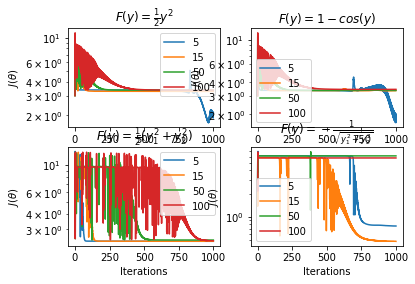

In [452]:
#Testing for different layers

tau = 0.01
h = 0.2
tol_val = 0.03
tol_its = 1000

KK = np.array([5, 15, 50, 100])

fig, axs = plt.subplots(2,2)
its = np.arange(tol_its + 1)
tt = []
I = 2010

for i in KK:

    start = time.time()
    theta1, z1, p1, onez1, c1, m01, ac1, bc1, ay1, by1 = generate_input(F1, I, 1, 2, [-2,2], i)
    theta2, z2, p2, onez2, c2, m02, ac2, bc2, ay2, by2= generate_input(F2, I, 2, 4, [[-2, -2], [2, 2]], i)
    theta3, z3, p3, onez3, c3, m03, ac3, bc3, ay3, by3 = generate_input(F3, I, 1, 2,  [-np.pi / 3, np.pi / 3], i)
    theta4, z4, p4, onez4, c4, m04, ac4, bc4, ay4, by4 = generate_input(F4, I, 2, 4, [[-2, -2], [2, 2]], i)

    a1, d1 = trainingAlg(theta1, z1, p1, onez1, c1, m01, std_gradient_descent, sig2, prime_sig2, eta2, prime_eta2, i, 1/i,
                         tol_its)
    a2, d2 = trainingAlg(theta2, z2, p2, onez2, c2, m02, std_gradient_descent, sig2, prime_sig2, eta2, prime_eta2, i, 1/i,
                         tol_its)
    a3, d3 = trainingAlg(theta3, z3, p3, onez3, c3, m03, std_gradient_descent, sig2, prime_sig2, eta2, prime_eta2, i, 1/i,
                         tol_its)
    a4, d4 = trainingAlg(theta4, z4, p4, onez4, c4, m04, std_gradient_descent, sig2, prime_sig2, eta2, prime_eta2, i, 1/i,
                         tol_its)
    stop = time.time()
    tt.append(stop - start)
    axs[0,0].semilogy(its[:len(d1)], d1, label = i)
    axs[1,0].semilogy(its[:len(d2)], d2, label= i)
    axs[0,1].semilogy(its[:len(d3)], d3, label= i)
    axs[1,1].semilogy(its[:len(d4)], d4, label= i)

print(tt)

axs[0, 0].set_title(r'$F(y) = \frac{1}{2}y^2$')
axs[1, 0].set_title(r'$F(y) = \frac{1}{2}(y_1^2 + y_2^2)$')
axs[0, 1].set_title(r'$F(y) = 1 - cos(y)$')
axs[1, 1].set_title(r'$F(y) = - \frac{1}{\sqrt{y_1^2 + y_2^2}}$')
axs[0,0].legend()
axs[1,0].legend()
axs[0,1].legend()
axs[1,1].legend()

for ax in axs.flat:
    ax.set(xlabel='Iterations', ylabel=r'$J(\theta)$')

#PLOT AT THE BOTTOM

3) testing for different dimention in the net.

[[-0.12818749]
 [-1.53755567]
 [ 1.61592259]
 ...
 [-1.87067729]
 [ 1.99642857]
 [ 1.9910734 ]]
[[0.48397656]
 [0.30780554]
 [0.70199032]
 ...
 [0.26616534]
 [0.74955357]
 [0.74888417]]
[[ 0.38468816 -0.27573306]
 [-1.73956561  0.31248222]
 [ 1.78296705  1.2282172 ]
 ...
 [ 0.7913282   0.12750615]
 [ 0.40882302  0.31177388]
 [-1.43206185  0.51413797]]
[[0.54808602 0.46553337]
 [0.2825543  0.53906028]
 [0.72287088 0.65352715]
 ...
 [0.59891603 0.51593827]
 [0.55110288 0.53897174]
 [0.32099227 0.56426725]]
[[ 0.14545132]
 [-0.68081897]
 [-0.10536368]
 ...
 [-0.33789126]
 [ 0.74907355]
 [-0.68083676]]
[[0.53472395]
 [0.33746644]
 [0.47484628]
 ...
 [0.4193344 ]
 [0.67882814]
 [0.3374622 ]]
[[ 0.19025936  1.57888971]
 [ 0.61072196  0.72741261]
 [ 0.17489096  0.06989742]
 ...
 [ 1.04815202  0.0501529 ]
 [ 1.34918721 -1.95002109]
 [ 1.56844152  0.49766577]]
[[0.52378242 0.69736121]
 [0.57634024 0.59092658]
 [0.52186137 0.50873718]
 ...
 [0.631019   0.50626911]
 [0.6686484  0.25624736]
 [0.69

2.9407185426731757
2.9407183131621677
2.940718083611364
2.940717864193098
2.9407176448538634
2.9407174350692893
2.9407172254689287
2.940717024880151
2.940716824568345
2.940716632757636
2.9407164413053484
2.9407162578742
2.94071607487264
2.940715899440867
2.940715724500508
2.940715556705389
2.9407153894550313
2.940715228950495
2.9407150690363824
2.94071491549223
2.940714762577204
2.9407146156783712
2.9407144694410703
2.940714328886922
2.9407141890210258
2.940714054524684
2.9407139207381867
2.940713792025893
2.9407136640404183
2.940713540850924
2.940713418401074
2.940713300485061
2.940713183317794
2.940713070437321
2.940712958311364
2.9407128502393407
2.9407127429246285
2.940712639444313
2.9407125367214544
2.9407124376259772
2.9407123392857497
2.9407122443776554
2.9407121502205222
2.940712059311337
2.94071196914699
2.940711882056807
2.9407117957037294
2.9407117122608146
2.9407116295458664
2.9407115495862826
2.9407114703443074
2.940711393711555
2.940711317785002
2.9407112443296795
2.94071

2.9407059450550856
2.9407059395199564
2.9407059339842245
2.9407059284478865
2.9407059229109405
2.940705917373383
2.940705911835214
2.9407059062964285
2.9407059007570266
2.940705895217004
2.940705889676361
2.9407058841350926
2.9407058785931994
2.9407058730506774
2.9407058675075257
2.940705861963742
2.940705856419325
2.940705850874271
2.940705845328581
2.9407058397822494
2.9407058342352785
2.9407058286876637
2.9407058231394054
2.9407058175905
2.9407058120409477
2.9407058064907448
2.9407058009398916
2.940705795388386
2.9407057898362265
2.9407057842834106
2.9407057787299387
2.9407057731758073
2.9407057676210173
2.9407057620655657
2.940705756509452
2.9407057509526737
2.9407057453952317
2.940705739837122
2.940705734278346
2.9407057287189007
2.9407057231587856
2.9407057175979996
2.940705712036541
2.940705706474409
2.9407057009116033
2.9407056953481217
2.940705689783963
2.9407056842191275
2.940705678653613
2.940705673087419
2.940705667520544
2.940705661952988
2.9407056563847496
2.9407056508158

2.1563993334577547
2.1563928290863648
2.1563863260111575
2.1563798261376186
2.1563733276774504
2.156366832317698
2.1563603384754697
2.1563538476444526
2.156347358423566
2.1563408721353365
2.1563343875396157
2.1563279058074163
2.1563214258410395
2.1563149486773736
2.156308473344812
2.1563020007615123
2.1562955300674793
2.1562890620757633
2.156282596025168
2.156276132635693
2.1562696712335976
2.1562632124565067
2.156256755708094
2.156250301553056
2.156243849463596
2.1562373999398456
2.1562309525146697
2.156224507631039
2.156218064875517
2.156211624640465
2.156205186559983
2.156198750981624
2.1561923175815676
2.156185886667694
2.1561794579534332
2.156173031711538
2.156166607688413
2.1561601861257085
2.15615376679902
2.156147349922455
2.156140935297451
2.156134523113729
2.1561281131956007
2.1561217057111906
2.1561153005050615
2.156108897726215
2.156102497237138
2.1560960991698965
2.156089703402846
2.156083310053055
2.156076919012926
2.156070530386243
2.1560641440778436
2.156057760179749
2.

2.153654574928985
2.1536491733906145
2.1536437741685055
2.153638377261873
2.153632982669925
2.153627590391872
2.1536222004269208
2.153616812774276
2.153611427433141
2.153606044402718
2.153600663682206
2.153595285270803
2.1535899091677058
2.1535845353721075
2.153579163883201
2.1535737947001774
2.1535684278222256
2.153563063248532
2.1535577009782823
2.1535523410106605
2.153546983344848
2.153541627980025
2.15353627491537
2.153530924150059
2.1535255756832674
2.1535202295141684
2.153514885641933
2.153509544065731
2.15350420478473
2.153498867798097
2.153493533104996
2.15348820070459
2.15348287059604
2.153477542778506
2.153472217251145
2.1534668940131136
2.153461573063566
2.1534562544016556
2.1534509380265323
2.1534456239373467
2.1534403121332466
2.153435002613377
2.1534296953768837
2.1534243904229093
2.1534190877505948
2.1534137873590793
2.1534084892475023
2.1534031934149995
2.153397899860705
2.153392608583754
2.153387319583276
2.1533820328584024
2.153376748408261
2.153371466231979
2.1533661

2.983201803021034
2.983201600617364
2.9832014004089804
2.983201202345307
2.983201006374898
2.983200812449534
2.9832006205203077
2.983200430541236
2.9832002424658013
2.9832000562501446
2.983199871850002
2.9831996892235315
2.983199508328597
2.9831993291252767
2.983199151573444
2.9831989756350037
2.983198801271731
2.9831986284472687
2.9831984571251957
2.9831982872708083
2.983198118849393
2.983197951827823
2.9831977861730063
2.983197621853318
2.983197458837204
2.983197297094471
2.9831971365950283
2.9831969773100453
2.9831968192108222
2.98319666226983
2.98319650645969
2.9831963517541147
2.9831961981269832
2.9831960455531914
2.983195894007816
2.983195743466882
2.9831955939066073
2.983195445304094
2.9831952976366454
2.9831951508823926
2.9831950050196743
2.9831948600276017
2.9831947158855017
2.9831945725734212
2.983194430071628
2.983194288361063
2.9831941474228905
2.983194007238905
2.9831938677911265
2.983193729062165
2.9831935910348544
2.983193453692585
2.983193317018967
2.983193180998135
2.9

2.9831464627155664
2.98314634223959
2.983146221726388
2.9831461011759455
2.9831459805882448
2.9831458599632708
2.9831457393010083
2.9831456186014416
2.9831454978645544
2.983145377090331
2.983145256278756
2.983145135429814
2.983145014543489
2.9831448936197655
2.9831447726586284
2.9831446516600613
2.9831445306240485
2.983144409550576
2.983144288439627
2.9831441672911865
2.9831440461052385
2.983143924881768
2.9831438036207603
2.9831436823221984
2.983143560986068
2.983143439612353
2.9831433182010385
2.9831431967521094
2.98314307526555
2.983142953741345
2.9831428321794795
2.983142710579937
2.9831425889427035
2.983142467267763
2.983142345555101
2.983142223804701
2.983142102016549
2.9831419801906285
2.983141858326926
2.9831417364254245
2.98314161448611
2.9831414925089663
2.9831413704939793
2.983141248441133
2.983141126350413
2.983141004221803
2.983140882055289
2.9831407598508553
2.9831406376084866
2.983140515328168
2.983140393009884
2.98314027065362
2.9831401482593614
2.9831400258270913
2.983

0.9451096277776426
0.8244731099372737
0.9322701674630163
0.8166165927265474
0.919641082823473
0.8088337922970348
0.9072242178386779
0.8011280751367212
0.8950211269888183
0.7935026283597659
0.8830330846546903
0.785960459264836
0.8712610947147326
0.7785043954553114
0.8597059002829233
0.7711370854842952
0.8483679935363726
0.7638609999875429
0.8372476255862407
0.7566784332678734
0.826344816350292
0.7495915052952783
0.8156593643898651
0.7426021640878332
0.8051908566783249
0.7357121884395486
0.7949386782721255
0.7289231909624597
0.7849020218594065
0.7222366214115501
0.7750798971646295
0.7156537702624479
0.7654711401910603
0.7091757725132523
0.7560744222859381
0.7028036116833056
0.7468882590159636
0.6965381239831727
0.7379110188432461
0.6903800026315814
0.7291409315941295
0.684329802296518
0.7205760967153383
0.6783879436390982
0.7122144913136401
0.6725547179402358
0.7040539779768155
0.6668302917914792
0.6960923123750216
0.6612147118326833
0.6883271506428061
0.6557079095204351
0.68075605654294

0.4488350146669577
0.4504354954803243
0.44880029489966256
0.4503694043553278
0.44876496788622044
0.45030322020344404
0.4487290308877778
0.4502369337103831
0.44869248158328134
0.45017053602304186
0.4486553180533704
0.450104018734279
0.44861753876478677
0.4500373738681488
0.4485791425552858
0.44997059386557864
0.44854012861903036
0.4499036715704769
0.44850049649245355
0.44983660021625604
0.4484602460405723
0.4497693734127608
0.4484193774437389
0.4497019851335869
0.44837789118481497
0.4496344297037785
0.44833578803675445
0.4495667017878934
0.4482930690505816
0.4494987963784245
0.4482497355437522
0.44943070878456604
0.4482057890888851
0.44936243462131525
0.44816123150285153
0.4492939697988977
0.44811606483621264
0.44922531051250864
0.44807029136299165
0.44915645323235903
0.4480239135707716
0.44908739469401737
0.44797693415110923
0.44901813188903994
0.447929355990253
0.44894866205587913
0.4478811821601569
0.44887898267106263
0.44783241590978107
0.4488090914406353
0.44778306065667045
0.44873

3.086905489705898
3.304153394376737
3.8574941746051667
4.110828036717968
5.059181408068023
3.6875300602519303
4.409904916051375
3.966944021173062
4.702525385811014
3.7449671879782174
4.332106489013835
3.794272611947685
4.3192358764249
3.7126871071221252
4.143662535204965
3.66211301419664
4.017500344309197
3.6008119034681894
3.8877964207754188
3.5378418286755995
3.766060406706512
3.4745876907318336
3.6533638574317266
3.412667539515481
3.5506934497505824
3.3534464984099785
3.458515628644072
3.2979612158075087
3.3768353033962955
3.2469068230115132
3.3052908315475746
3.2006629506762474
3.2432558672272633
3.159342773974394
3.189934788385465
3.1228517341177833
3.1444441668884706
3.0909461614503724
3.1058770019916233
3.0632857111341494
3.073349543310066
3.0394766201763725
3.0460324933063547
3.0191050312359295
3.0231693587651813
3.0017610250320947
3.0040849716683415
2.987054723441821
2.9881869912513532
2.974626071667516
2.9749627565117556
2.9641498625149056
2.963973342663305
2.9553373684027777

2.9026547843903594
2.9026360245674607
2.902616925016142
2.9025998491296003
2.902582326268877
2.902567303997467
2.9025516885321867
2.902539167983587
2.9025258555465734
2.902516380902418
2.90250584506515
2.9025000784163195
2.9024928862848793
2.9024916346956164
2.9024884655660066
2.9024927146694823
2.9024943822787947
2.902505338037487
2.9025128170036925
2.902531957680986
2.9025464147636617
2.902575555666556
2.9025983864864995
2.902639760673771
2.9026726324739838
2.9027289914012515
2.902773892273718
2.9028486312872577
2.9029079259663537
2.9030052406764058
2.9030817324175087
2.903206813280882
2.9033038103658924
2.9034630842618423
2.9035844681072813
2.9037858972257835
2.9039361866412117
2.904189636461309
2.904374038944205
2.90469172816777
2.9049161637363943
2.9053132092514105
2.9055842845986493
2.906079353046546
2.906404253043436
2.9070203260683565
2.9074065751679328
2.9081718260269644
2.9086268534868256
2.9095756157433916
2.91010603610731
2.911279817192022
2.9118903130439895
2.9133387626456

2.886791546170198
2.887989866047303
2.886947061448584
2.888214669143274
2.887141836406542
2.8884830109852615
2.8873757264215727
2.8887947426374785
2.8876482761996956
2.8891493545642115
2.8879586596430133
2.8895459077685968
2.888305618109441
2.8899829633003624
2.888687398838601
2.890458512267939
2.889101695784571
2.890969909040042
2.8895455955568554
2.891513810858577
2.890015531587073
2.8920861275604577
2.8905072499624174
2.8926819854621995
2.891015790543899
2.8932957096321967
2.891535486961132
2.893920828694352
2.8920599887936596
2.894550105912351
2.892582308671071
2.8951755995520903
2.8930948961307306
2.8957887543930863
2.8935897388723664
2.896380524777823
2.894058490588032
2.8969415278143957
2.8944926229076264
2.897462223392231
2.894883597303282
2.897933115684232
2.8952230511869392
2.898344968971566
2.8955029910728998
2.8986890291298004
2.8957159847132288
2.898957241132995
2.895855343672715
2.8991424526020597
2.895915287969287
2.8992385938197525
2.8958910851818236
2.8992408257553124


2.229027443060268
2.2289762741103405
2.228931933157409
2.228880780842135
2.2288362643576454
2.22878513153262
2.2287404498439263
2.228689339315498
2.2286445023594155
2.2285934168821715
2.228548434220151
2.228497376494759
2.2284522573274077
2.228401229998778
2.228355983179755
2.2283049888355064
2.2282596228848157
2.2282086640540104
2.2281631871707366
2.2281122663228645
2.228066686397368
2.228015805941557
2.2279701305671598
2.227919292851593
2.2278735293357763
2.227822736647297
2.2277768920224363
2.2277261465863223
2.227680227619983
2.227629531599876
2.227583544804688
2.2275329003026623
2.2274868519457933
2.2274362610025515
2.2273901571147987
2.2273396217099815
2.2272934680944987
2.2272429901470945
2.2271967923877707
2.227146373756621
2.227100137226128
2.227049779710508
2.2270035095780307
2.2269532149183107
2.2269069161569717
2.2268566860353376
2.2268103634293346
2.2267601994705646
2.22671385762203
2.2266637613943274
2.226617404729921
2.2265673777457837
2.2265210105230353
2.22647105424016

2.2104972239317204
2.210463383375771
2.2104286054119098
2.2103948148909605
2.210360087321954
2.2103263465608918
2.2102916691319767
2.2102579778560143
2.210223350313905
2.2101897082485813
2.210155130341468
2.210121537212647
2.2100870086901887
2.210053464224059
2.210018984837381
2.209985488760456
2.209951058262142
2.20991761030126
2.2098832284453476
2.2098498283276706
2.209815494869646
2.2097821423226596
2.209747857019452
2.2097145517709653
2.2096803143809387
2.2096470561590844
2.209612866442032
2.2095796549752666
2.209545512692404
2.209512347709507
2.2094782526234655
2.209445133853541
2.2094110857283593
2.2093780129008342
2.2093440115019516
2.209310984346579
2.2092770294408255
2.209244047687682
2.209210139043273
2.2091772024227616
2.2091433398092875
2.209110448052138
2.2090766312405545
2.2090437840778243
2.209010012840446
2.2089772100035217
2.20894348411401
2.208910725334608
2.208877044567963
2.2088443295781315
2.2088106937106824
2.2087780222428033
2.208744431052196
2.2087118028389874
2

2.9754844772865545
2.975467894193019
2.975451298180973
2.9754346886651497
2.975418065088534
2.9754014268873274
2.9753847735240906
2.9753681044552507
2.975351419161831
2.975334717119311
2.9753179978261204
2.9753012607756797
2.9752845054828247
2.975267731457865
2.975250938231094
2.9752341253287153
2.975217292295581
2.9752004386728452
2.9751835640190665
2.9751666678894586
2.9751497498554755
2.9751328094855447
2.9751158463632508
2.975098860069434
2.9750818501990786
2.9750648163446813
2.9750477581119354
2.975030675104274
2.975013566937444
2.9749964332251344
2.974979273592521
2.9749620876629055
2.9749448750703
2.9749276354470067
2.974910368435313
2.974893073675939
2.9748757508189154
2.9748583995128337
2.9748410194149564
2.974823610181222
2.974806171475649
2.9747887029610256
2.974771204307666
2.9747536751847408
2.974736115268424
2.9747185242338228
2.9747009017625565
2.974683247535244
2.9746655612385586
2.9746478425582286
2.9746300911856056
2.9746123068111454
2.9745944891305234
2.9745766378385

2.961185708488012
2.9611182026108036
2.961050371952229
2.960982214383874
2.9609137277604147
2.96084490991946
2.9607757586813865
2.9607062718491757
2.9606364472082496
2.9605662825262997
2.9604957755531207
2.960424924020437
2.960353725641732
2.9602821781120685
2.9602102791079155
2.960138026286967
2.9600654172879626
2.9599924497305024
2.9599191212148623
2.959845429321807
2.959771371612402
2.959696945627819
2.959622148889143
2.9595469788971793
2.959471433132253
2.959395509054007
2.959319204101204
2.9592425156915168
2.9591654412213244
2.9590879780654995
2.9590101235772006
2.958931875087653
2.9588532299059356
2.958774185318758
2.9586947385902427
2.9586148869616973
2.958534627651389
2.9584539578543145
2.9583728747419684
2.958291375462107
2.958209457138512
2.958127116870749
2.958044351733923
2.9579611587784367
2.9578775350297364
2.957793477488064
2.957708983128199
2.9576240488992034
2.957538671724159
2.9574528484999045
2.9573665760967685
2.9572798513582983
2.9571926711009873
2.957105032113999


1.1744306859422509
1.7375272254327114
1.2026756411726105
1.7721689295030858
1.1738098729913538
1.7159880591525178
1.1776436227896174
1.7120499415737649
1.1634449568505796
1.6798128947116595
1.1579222160911822
1.6615694119733357
1.1482075944302357
1.6370130769198052
1.140013379886735
1.6151372176803458
1.1310521000386462
1.5923551637848719
1.1221633260755135
1.5699822752659938
1.1130827158828822
1.5476076014406799
1.1038944841800757
1.5253629011279126
1.094585768379615
1.5032285019629263
1.0851675380967805
1.4812211195965161
1.0756459595974455
1.4593495264070127
1.0660281828236453
1.43762350854411
1.0563213378205456
1.4160523408102592
1.0465326523251557
1.3946449880873701
1.0366694192236057
1.3734100768381456
1.026738979503893
1.35235589082179
1.0167487041541663
1.3314903656315158
1.0067059762836417
1.3108210839370291
0.9966181735010841
1.2903552714140973
0.9864926506364283
1.2700997934157894
0.9763367228873209
1.2500611524303191
0.9661576494682469
1.2302454863612673
0.9559626178348203


0.3410179736829511
0.33910893137955606
0.3409702483772563
0.33908368078598455
0.3409243916691591
0.3390599815428398
0.34088033811513857
0.3390377717054604
0.3408380244007997
0.33901699149894027
0.3407973892716533
0.3389975832425903
0.34075837346616383
0.3389794912770823
0.3407209196509936
0.33896266189417945
0.3406849723583744
0.33894704326896025
0.3406504779255344
0.33893258539444565
0.34061738443611533
0.3389192400185462
0.3405856416635169
0.3389069605832408
0.3405552010161023
0.33889570216591264
0.34052601548420713
0.33888542142275835
0.3404980395888912
0.33887607653420276
0.340471229332376
0.3388676271522398
0.34044554215011374
0.3388600343496362
0.3404209368644311
0.33885326057092624
0.3403973736397009
0.33884726958513667
0.34037481393898605
0.33884202644017636
0.34035322048211064
0.3388374974188329
0.34033255720510824
0.33883364999631616
0.34031278922100466
0.3388304527992957
0.34029388278188816
0.3388278755663744
0.34027580524222606
0.33882588910995043
0.34025852502338505
0.3388

4.748806893188103
7.038763856536821
3.267825298970391
4.106527561146564
6.20847300589138
3.8456226030987444
5.668828599540271
4.767752580107892
6.742470657970498
3.0505816723575183
3.1056069223373517
3.360878694312623
4.158109714596647
5.922800252649007
3.9000514478468613
5.396617230994356
4.523288685538221
6.082729599063955
3.348744415091828
3.9999836868235996
4.631105690433884
5.92705076797424
3.3379888393906825
3.8428188324377723
4.268140913593715
5.298961719654405
3.800202159864347
4.539356654632525
4.120071330821057
4.841689163158315
3.841800064712525
4.370599074506715
3.8759505383698767
4.315539471198615
3.7756265970005845
4.105177465390868
3.6943383985217206
3.9384495491710427
3.609790311474619
3.785392462932055
3.5272917785933307
3.6501092049523947
3.4498451848474088
3.533295816899751
3.3794563045626145
3.4344168219890316
3.3172009397758377
3.3521176083910635
3.263371656644095
3.2845660862394435
3.2176828651620046
3.2297370704160517
3.1794787704727727
3.1856207304987643
3.14790

3.0063660894347675
3.0063474314629794
3.0063287156024066
3.0063099415608607
3.00629110904438
3.0062722177584456
3.006253267406749
3.0062342576924133
3.006215188316757
3.0061960589805157
3.006176869382604
3.006157619221345
3.00613830819322
3.0061189359941087
3.0060995023180324
3.006080006858397
3.0060604493067333
3.0060408293539465
3.006021146689046
3.006001401000406
3.0059815919744857
3.005961719297098
3.0059417826521204
3.005921781722776
3.005901716190328
3.00588158573538
3.00586139003655
3.00584112877179
3.0058208016170433
3.005800408247578
3.00577994833663
3.0057594215567534
3.005738827578443
3.005718166071507
3.0056974367036684
3.005676639141955
3.0056557730512847
3.005634838095874
3.0056138339378
3.0055927602384367
3.005571616656986
3.005550402851944
3.005529118479605
3.0055077631955527
3.0054863366531377
3.005464838504999
3.005443268401507
3.0054216259923203
3.005399910924794
3.005378122845572
3.0053562613989557
3.005334326228539
3.005312316975534
3.005290233280447
3.005268074781

2.986496314756424
2.9863878862883504
2.9862671800282414
2.986159153389341
2.9860387561666983
2.9859311925148986
2.9858110942853777
2.9857040782322537
2.985584289418044
2.985477931192816
2.9853584833765883
2.9852529215799235
2.985133868639676
2.985029273670836
2.9849106933824197
2.9848072716446903
2.984689267790449
2.984587266805134
2.984469971839436
2.9843696864289373
2.9842532647644577
2.984155044501354
2.984039696494062
2.9839439546569064
2.983829921382752
2.9837371457123356
2.9836247146445896
2.983535480258585
2.9834249919713
2.983339976872945
2.983231832912475
2.9831518366230494
2.9830465087048696
2.9829724746634256
2.9828705153638118
2.9828035578746053
2.9827056129932235
2.982647049665686
2.9825538724314486
2.982505263253537
2.9824177305257438
2.9823809249433726
2.982300055513608
2.9822772491600373
2.982204224173808
2.9821980272051576
2.9821342125760815
2.9821477319209975
2.9820947023767665
2.9821316405924296
2.9820912046320585
2.9821559784580147
2.9821302029611343
2.9822280850443

2.23100623258363
2.231005751722272
2.231005261092344
2.2310047696785795
2.2310042690903678
2.231003767521994
2.231003257331576
2.23100274599295
2.231002226546261
2.2310017058086595
2.2310011774415712
2.2310006476635476
2.2310001107019684
2.2309995722297082
2.2309990269897066
2.2309984801573775
2.2309979269453204
2.2309973720754215
2.2309968111881306
2.2309962485918367
2.2309956803167523
2.2309951102942502
2.230994534909612
2.230993957750437
2.230993375525468
2.230992791508828
2.2309922027039293
2.2309916120990305
2.2309910169659806
2.23099042003234
2.230989818814496
2.230989215802252
2.2309886087347603
2.230987999884974
2.2309873871949746
2.2309867727399273
2.2309861546467666
2.2309855348102463
2.230984911525687
2.23098428652327
2.2309836582517004
2.2309830282910283
2.2309823952296717
2.2309817605107174
2.2309811228498395
2.2309804835651676
2.2309798414882827
2.2309791978233022
2.2309785515073757
2.230977903640589
2.230977253256236
2.2309766013594756
2.2309759470711623
2.23097529130982

2.2306867512852016
2.2306860432512274
2.2306853353297376
2.2306846275206986
2.2306839198240795
2.2306832122398452
2.2306825047679633
2.2306817974083994
2.2306810901611205
2.2306803830260917
2.230679676003279
2.230678969092648
2.230678262294164
2.230677555607792
2.2306768490334967
2.2306761425712427
2.2306754362209946
2.2306747299827165
2.2306740238563725
2.2306733178419265
2.230672611939342
2.230671906148583
2.230671200469612
2.2306704949023928
2.2306697894468885
2.230669084103061
2.2306683788708743
2.23066767375029
2.230666968741271
2.230666263843779
2.230665559057776
2.230664854383224
2.230664149820085
2.2306634453683207
2.230662741027892
2.2306620367987606
2.2306613326808877
2.2306606286742348
2.2306599247787617
2.23065922099443
2.2306585173212
2.2306578137590334
2.230657110307889
2.230656406967728
2.230655703738511
2.230655000620197
2.2306542976127472
2.2306535947161206
2.2306528919302773
2.230652189255177
2.230651486690779
2.2306507842370435
2.230650081893929
2.2306493796613958
2.

3.0091022573160027
3.009094768951697
3.0090872776988595
3.0090797835133385
3.0090722863511425
3.0090647861682562
3.0090572829208013
3.009049776564881
3.009042267056718
3.0090347543525175
3.0090272384085894
3.0090197191812265
3.0090121966268133
3.0090046707017164
3.0089971413623813
3.008989608565237
3.0089820722667784
3.0089745324234847
3.008966988991889
3.008959441928508
3.008951891189903
3.008944336732617
3.00893677851323
3.008929216488303
3.0089216506144223
3.008914080848156
3.0089065071460905
3.0088989294647903
3.0088913477608332
3.0088837619907713
3.008876172111166
3.008868578078549
3.008860979849454
3.008853377380387
3.0088457706278486
3.0088381595483074
3.0088305440982235
3.0088229242340234
3.008815299912119
3.0088076710888867
3.0088000377206847
3.0087923997638315
3.0087847571746242
3.0087771099093206
3.008769457924148
3.008761801175295
3.0087541396189166
3.0087464732111266
3.008738801908
3.0087311256655696
3.0087234444398265
3.008715758186716
3.0087080668621398
3.008700370421951

3.0045222729717187
3.0045071104049863
3.0044919078863574
3.004476665238749
3.0044613822841986
3.0044460588438615
3.0044306947380046
3.004415289785998
3.0043998438063144
3.0043843566165185
3.0043688280332637
3.004353257872287
3.004337645948401
3.0043219920754898
3.004306296066502
3.004290557733447
3.0042747768873856
3.004258953338426
3.004243086895718
3.0042271773674463
3.0042112245608252
3.004195228282089
3.004179188336492
3.0041631045282955
3.0041469766607674
3.00413080453617
3.0041145879557596
3.0040983267197747
3.0040820206274335
3.0040656694769248
3.0040492730654016
3.004032831188977
3.004016343642714
3.0039998102206216
3.0039832307156447
3.003966604919662
3.0039499326234744
3.0039332136168
3.0039164476882694
3.0038996346254137
3.0038827742146608
3.0038658662413282
3.0038489104896144
3.003831906742593
3.0038148547822034
3.0037977543892462
3.0037806053433735
3.003763407423082
3.003746160405706
3.003728864067409
3.003711518183177
3.00369412252681
3.003676676870914
3.0036591809868947


0.6416787930827657
0.8959428230811131
1.2235427296050732
2.0727015490016187
1.603138704525421
2.692550976714995
0.8830988385173888
1.3882547991138332
1.5900902188729287
2.632439794607072
0.9150151099283582
1.4265832955335873
1.5596463059788386
2.5449981889882336
0.9779089913082819
1.5205483836075362
1.538692138237327
2.4718531676650755
1.0128784630389427
1.557239440175689
1.4955247858889116
2.3641976502499915
1.0786996396624806
1.6462401321637634
1.4499544629352057
2.252869365110812
1.1326554884969837
1.7094006729427844
1.3943246815107633
2.1264457566979
1.1827593764021618
1.7626998490894241
1.3348279366197977
1.9953330212422444
1.216648228164546
1.7870969261271188
1.2808258424518137
1.875264471658398
1.2271141944660262
1.7732905220729267
1.2398334273498717
1.7787966924911676
1.2170290309638716
1.7279650546325103
1.2099449648749032
1.7028685711231308
1.1960700071234354
1.6676196761471584
1.184179774776549
1.6361628711348521
1.1713942863904132
1.6039416052066908
1.1585464525110465
1.572

0.4785644829685938
0.4785368246973535
0.4785513299433038
0.4785244616116542
0.4785386882737509
0.4785125870657417
0.47852653736644785
0.4785011810772015
0.4785148574904236
0.47849022451488693
0.47850362973948113
0.4784796990609106
0.47849283599618164
0.47846958717441784
0.4784824588974746
0.4784598720570563
0.47847248180189206
0.4784505376200561
0.47846288875823706
0.4784415684528435
0.47845366447569077
0.47843294979311307
0.47844479429527526
0.478424667498285
0.47843626416260476
0.47841670801828434
0.4784280606018658
0.4784090583695733
0.47842017069097004
0.4784017061103799
0.4784125820378199
0.4783946393170622
0.47840528275764116
0.4783878465615558
0.478398261451327
0.47838131688985047
0.47839150718474993
0.47837503980144874
0.4783850094689935
0.4783690052297568
0.47837875824146475
0.47836320352336553
0.4783727438478419
0.47835762542817906
0.4783669570248229
0.478352262070348
0.4783613888836346
0.47834710493997323
0.478356030894269
0.4783421458755406
0.478350874870413
0.4783373770490

[[-0.4234424  -1.41649141]
 [ 0.04932562 -0.1429468 ]
 [-1.40091428 -1.12130868]
 ...
 [-0.92355457  0.27358263]
 [ 1.93283622 -0.20857699]
 [ 0.89118144 -0.6261874 ]]
[[0.4470697  0.32293857]
 [0.5061657  0.48213165]
 [0.32488572 0.35983642]
 ...
 [0.38455568 0.53419783]
 [0.74160453 0.47392788]
 [0.61139768 0.42172658]]
10.276161115759516
2.986371544065722
3.7401484767451167
6.477269648276504
4.046333959791314
6.898398575927748
2.904038784004094
3.047796388487559
4.02705661651243
6.773936171328353
2.9978235398583952
3.681645521822452
5.960782786693132
7.8203940702002
6.31538636369328
3.7115144566559044
5.82697381687156
4.676377568185098
6.913534792323031
3.1041370974213534
3.8163618231711856
5.6804012142065
4.350364119197959
6.232014311044907
3.119806167868179
3.745802736896335
4.703025426056743
6.250330336902225
2.9345896690315203
3.0503356907922274
3.346012063317147
4.140247067385885
4.506883101183287
5.669546625292342
3.2715411972905133
3.7673945470983097
4.00030830602178
4.804159

2.8691475535286837
2.869091594847824
2.869035398087711
2.8689789616459547
2.868922283907861
2.8688653632463135
2.868808198021656
2.86875078658157
2.8686931272609546
2.8686352183818027
2.8685770582530767
2.8685186451705835
2.8684599774168453
2.8684010532609747
2.8683418709585404
2.8682824287514403
2.8682227248677656
2.868162757521669
2.868102524913226
2.8680420252283017
2.8679812566384104
2.8679202173005733
2.867858905357181
2.867797318935847
2.867735456149265
2.867673315095061
2.8676108938556455
2.867548190498065
2.8674852030738496
2.8674219296188608
2.867358368153135
2.86729451668073
2.8672303731895634
2.867165935651255
2.867101202020966
2.8670361702372325
2.8669708382218007
2.8669052038794622
2.866839265097882
2.8667730197474284
2.8667064656810006
2.866639600733854
2.86657242272342
2.866504929449132
2.8664371186922413
2.866368988215634
2.866300535763647
2.8662317590618804
2.866162655817008
2.866093223716585
2.866023460428856
2.8659533636025567
2.865882930866718
2.865812159830463
2.86

2.7135785240762145
2.7119329457489476
2.7102642724130743
2.7085720767633976
2.706855921841215
2.7051153607885317
2.7033499365958993
2.7015591818437357
2.6997426184369986
2.6978997573330736
2.696030098262746
2.6941331294441198
2.6922083272893644
2.690255156104151
2.688273067779661
2.6862615014770514
2.684219883304254
2.6821476259850057
2.6800441285200103
2.677908775840129
2.6757409384515234
2.6735399720726667
2.671305217263167
2.669035999044341
2.666731626511507
2.6643913924379703
2.6620145728707008
2.6596004267177005
2.6571481953271303
2.654657102058201
2.652126351843979
2.6495551307461485
2.646942605501952
2.644287923063396
2.6415902101290536
2.6388485726685733
2.636062095440389
2.6332298415027346
2.630350851718684
2.6274241442552806
2.6244487140777815
2.621423532438985
2.618347546365104
2.615219678137909
2.612038824775308
2.60880385750956
2.605513621266404
2.6021669341433022
2.5987625868919144
2.5952993424010913
2.5917759351886414
2.5881910708945974
2.584543425789695
2.58083164628515

8.631844923841841
8.631835686894016
8.631826333205947
8.631816860552794
8.631807266652883
8.631797549165853
8.631787705690776
8.631777733764174
8.63176763085799
8.631757394377425
8.631747021658763
8.631736509967036
8.63172585649365
8.631715058353878
8.631704112584268
8.63169301613995
8.631681765891807
8.631670358623559
8.631658791028695
8.631647059707296
8.631635161162722
8.631623091798131
8.631610847912892
8.631598425698792
8.631585821236122
8.631573030489553
8.63156004930386
8.631546873399426
8.631533498367562
8.631519919665605
8.631506132611802
8.631492132379941
8.631477913993743
8.63146347232099
8.631448802067371
8.631433897770043
8.631418753790868
8.631403364309339
8.631387723315148
8.631371824600395
8.631355661751403
8.63133922814014
8.631322516915183
8.631305520992244
8.63128823304419
8.631270645490577
8.631252750486595
8.63123453991147
8.631216005356222
8.631197138110787
8.631177929150425
8.631158369121396
8.631138448325846
8.631118156705849
8.631097483826562
8.631076418858408


8.632079178148455
8.632073356961536
8.632067480857659
8.632061549057447
8.632055560766716
8.632049515176133
8.632043411460845
8.632037248780108
8.632031026276904
8.632024743077546
8.632018398291265
8.632011991009804
8.632005520306976
8.631998985238214
8.631992384840135
8.631985718130048
8.631978984105476
8.631972181743663
8.631965310001045
8.63195836781273
8.631951354091948
8.631944267729482
8.63193710759309
8.631929872526909
8.631922561350823
8.631915172859843
8.631907705823432
8.63190015898483
8.63189253106036
8.631884820738696
8.631877026680113
8.631869147515724
8.631861181846674
8.631853128243321
8.631844985244387
8.631836751356069
8.631828425051143
8.631820004768016
8.631811488909758
8.631802875843093
8.631794163897371
8.631785351363478
8.63177643649274
8.631767417495757
8.631758292541226
8.6317490597547
8.631739717217311
8.631730262964453
8.631720694984402
8.631711011216913
8.63170120955173
8.631691287827078
8.631681243828067
8.631671075285068
8.631660779871998
8.63165035520457
8

2.933473676954727
2.9333895205760254
2.933305038401026
2.9332202272955654
2.9331350841047885
2.9330496056516315
2.9329637887375326
2.9328776301410016
2.9327911266182496
2.9327042749018397
2.932617071701239
2.9325295137015415
2.932441597563947
2.9323533199245544
2.932264677394773
2.932175666560171
2.932086283980829
2.931996526190239
2.9319063896956026
2.931815870976777
2.9317249664865193
2.9316336726494745
2.931541985862368
2.931449902493035
2.9313574188805642
2.9312645313343597
2.9311712361342406
2.931077529529534
2.930983407739131
2.9308888669506055
2.930793903320232
2.930698512972127
2.9306026919982275
2.9305064364574522
2.9304097423756454
2.930312605744754
2.930215022522738
2.9301169886327587
2.930018499963059
2.929919552366165
2.9298201416587286
2.9297202636207436
2.9296199139953547
2.929519088488084
2.9294177827666066
2.929315992459982
2.9292137131584073
2.929110940412445
2.929007669732748
2.9289038965892935
2.928799616411078
2.92869482458535
2.928589516457278
2.9284836873291837
2

2.772152244887193
2.724655724923069
2.760674660648985
2.7122471909598342
2.7490969701381074
2.6998636088801224
2.7378576915515844
2.6878064925871636
2.727270137022677
2.676273822807298
2.7175264626639417
2.665365953857097
2.7087062603747376
2.6550942649839047
2.700787463008994
2.645391882049526
2.69365952733874
2.636126934230218
2.687139864251351
2.627118983413018
2.6809943172251995
2.618158612014654
2.67496140268806
2.60902902005891
2.6687785101772463
2.599527364632665
2.662206965814666
2.58948298873452
2.655052387100186
2.5787699485436844
2.6471773823373157
2.5673123193741207
2.6385051922558675
2.555082261982812
2.6290147764562017
2.542092236753175
2.618729460498694
2.5283836419029337
2.6077021319878253
2.5140143633202214
2.5960000053346675
2.499047358245132
2.5836913608713337
2.4835416981967473
2.570835732979612
2.467546724697414
2.557478077247134
2.4510993076210963
2.543646684040797
2.434223729727539
2.5293541060013904
2.41693346753214
2.51460012845132
2.3992340704352957
2.49937578

5.134560571784036
5.134560571783596
5.134560571783155
5.134560571782715
5.1345605717822735
5.134560571781833
5.1345605717813925
5.134560571780952
5.134560571780511
5.134560571780071
5.13456057177963
5.13456057177919
5.134560571778749
5.134560571778309
5.134560571777868
5.134560571777428
5.134560571776986
5.134560571776546
5.134560571776105
5.1345605717756655
5.134560571775224
5.1345605717747835
5.134560571774343
5.1345605717739025
5.134560571773462
5.134560571773021
5.134560571772581
5.13456057177214
5.134560571771699
5.134560571771258
5.134560571770818
5.134560571770377
5.134560571769937
5.134560571769496
5.134560571769056
5.134560571768615
5.134560571768175
5.134560571767734
5.134560571767293
5.134560571766852
5.134560571766412
5.134560571765971
5.1345605717655305
5.13456057176509
5.134560571764649
5.134560571764208
5.134560571763768
5.134560571763328
5.134560571762887
5.134560571762446
5.134560571762005
5.134560571761565
5.134560571761124
5.134560571760684
5.134560571760243
5.134560

5.1345605715821465
5.134560571581705
5.1345605715812646
5.134560571580824
5.134560571580383
5.134560571579941
5.134560571579501
5.134560571579059
5.134560571578618
5.134560571578177
5.134560571577736
5.134560571577294
5.134560571576854
5.134560571576413
5.134560571575972
5.1345605715755305
5.13456057157509
5.1345605715746485
5.134560571574207
5.1345605715737666
5.134560571573326
5.134560571572885
5.134560571572444
5.134560571572003
5.134560571571561
5.134560571571121
5.134560571570679
5.134560571570239
5.134560571569798
5.134560571569357
5.134560571568915
5.134560571568474
5.134560571568033
5.134560571567592
5.134560571567151
5.13456057156671
5.134560571566269
5.134560571565828
5.134560571565387
5.134560571564946
5.134560571564505
5.134560571564064
5.134560571563623
5.134560571563181
5.134560571562741
5.134560571562299
5.134560571561859
5.134560571561417
5.134560571560977
5.134560571560535
5.134560571560094
5.1345605715596525
5.134560571559212
5.134560571558771
5.13456057155833
5.13456

8.616288816057496
8.513343678867042
8.221775925227583
6.650699685760343
9.418617013250424
8.608562751684262
8.498941520275187
8.183741210847131
6.442981305349602
9.734488863391404
8.377962363075358
7.705484723891045
3.0220081996667494
4.32264357895235
8.52620527993129
8.289931028405372
7.267192371407775
5.107726606776278
8.675954270908662
8.639074406364152
8.572204247232111
8.424331839129765
7.953820758250821
4.935058819390113
10.45662229808483
5.5991891520787025
10.026842955845794
7.270934121839351
3.8268054856811653
7.789952678193725
4.259834753783971
9.420239277838764
7.978584683076522
5.885243116542605
8.267332959501966
8.37531375886538
7.956668561441602
6.158537838419646
6.051995107659825
8.138098057702443
7.235411873613938
3.475688521197338
4.795929950632441
6.795137891777722
3.0412241144211984
3.1575353051894726
3.4955913563873797
3.9790204357031924
4.849789584834557
3.9149390047508703
4.093703534193121
3.491180599924968
3.3468719073246573
3.141654716431798
3.0606605884670506
3.

1.7615473768131324
1.6863594395305073
1.7517265680808798
1.6790821613684883
1.7419923880816401
1.6718002602299935
1.7323432810671868
1.664515282149185
1.722777753257133
1.6572287390303477
1.7132943696431535
1.6499421072681892
1.703891750913431
1.6426568266181123
1.6945685705058964
1.6353742992969436
1.6853235517956344
1.6280958892952302
1.6761554654191768
1.6208229218829202
1.6670631267362843
1.6135566832910746
1.6580453934281234
1.6062984205530821
1.6491011632293626
1.59904934148973
1.6402293717907195
1.5918106148233977
1.6314289906676456
1.5845833704075447
1.6226990254302889
1.577368699558545
1.6140385138894433
1.570167655477817
1.6054465244329312
1.5629812537530685
1.5969221544667422
1.555810472928297
1.5884645289551578
1.5486562551329937
1.5800727990541732
1.541519506761786
1.571746140832576
1.5344010991964767
1.5634837540752007
1.5273018695631368
1.5552848611630523
1.5202226215175574
1.5471487060251892
1.5131641260530277
1.5390745531574894
1.5061271223249368
1.5310616867036557
1.4

0.6941419884902825
0.7020172003024504
0.6921209789135179
0.7000079500687117
0.690113323788795
0.6980117614769316
0.6881188940801718
0.6960285077372622
0.6861375617938719
0.6940580631122822
0.6841691999829522
0.6921003029203798
0.6822136827516252
0.6901551035388627
0.6802708852592305
0.6882223424067898
0.6783406837238829
0.6863018980275344
0.6764229554257774
0.6843936499710639
0.6745175787101563
0.6824974788759456
0.6726244329899557
0.6806132664510802
0.67074339874812
0.6787408954771575
0.6688743575395947
0.6768802498078381
0.6670171919929999
0.6750312143706648
0.6651717858119839
0.6731936751676977
0.6633380237762709
0.6713675192758823
0.6615157917423888
0.6695526348471502
0.6597049766441071
0.6677489111082489
0.6579054664925589
0.665956238360308
0.6561171503760755
0.6641745079781455
0.6543399184597264
0.6624036124093142
0.6525736619845685
0.6606434451728826
0.6508182732666123
0.6588939008579711
0.6490736456955134
0.6571548751220339
0.6473396737329821
0.6554262646888851
0.64561625291092

8.533664763244078
8.53366329723304
8.533661822219084
8.533660338119043
8.533658844848736
8.533657342322925
8.533655830455324
8.533654309158566
8.533652778344194
8.533651237922639
8.533649687803205
8.533648127894056
8.533646558102184
8.53364497833341
8.533643388492344
8.533641788482388
8.533640178205694
8.533638557563163
8.533636926454417
8.53363528477777
8.533633632430224
8.53363196930743
8.533630295303686
8.533628610311892
8.533626914223543
8.533625206928704
8.533623488315978
8.533621758272488
8.533620016683859
8.533618263434173
8.533616498405966
8.533614721480186
8.533612932536174
8.533611131451632
8.533609318102604
8.533607492363432
8.533605654106742
8.533603803203409
8.533601939522521
8.533600062931363
8.533598173295367
8.533596270478093
8.533594354341192
8.533592424744374
8.53359048154537
8.5335885245999
8.533586553761639
8.53358456888218
8.533582569810989
8.533580556395378
8.533578528480462
8.533576485909116
8.53357442852194
8.533572356157213
8.533570268650855
8.533568165836378
8

8.53414310092737
8.534143100925865
8.53414310092436
8.534143100922856
8.534143100921352
8.534143100919847
8.534143100918344
8.534143100916838
8.534143100915333
8.534143100913829
8.534143100912326
8.53414310091082
8.534143100909315
8.53414310090781
8.534143100906308
8.534143100904803
8.534143100903298
8.534143100901794
8.534143100900287
8.534143100898783
8.534143100897278
8.534143100895774
8.53414310089427
8.534143100892765
8.534143100891262
8.534143100889755
8.534143100888251
8.534143100886746
8.534143100885242
8.534143100883737
8.534143100882233
8.534143100880728
8.534143100879223
8.534143100877719
8.534143100876214
8.53414310087471
8.534143100873203
8.534143100871699
8.534143100870194
8.53414310086869
8.534143100867185
8.53414310086568
8.534143100864176
8.534143100862671
8.534143100861167
8.53414310085966
8.534143100858156
8.534143100856651
8.534143100855147
8.534143100853642
8.534143100852136
8.534143100850633
8.534143100849127
8.534143100847622
8.534143100846117
8.534143100844613
8

2.87502182363118
2.872571648392414
2.8700728446145214
2.86752420874963
2.864924506716636
2.8622724732642357
2.859566811335296
2.8568061914339125
2.8539892509965936
2.8511145937691396
2.848180789190884
2.8451863717881
2.8421298405784965
2.8390096584888553
2.8358242517880097
2.8325720095374973
2.8292512830623817
2.8258603854448787
2.8223975910435866
2.8188611350413053
2.81524921302457
2.811559980598227
2.8077915530385593
2.803942004988654
2.800009370199911
2.795991641323781
2.7918867697580514
2.7876926655521936
2.7834071973765204
2.7790281925601295
2.774553437202836
2.7699806763665547
2.7653076143518107
2.760531915065346
2.7556512024850073
2.7506630612284018
2.7455650372320326
2.7403546385479287
2.7350293362650295
2.729586565562868
2.724023726905356
2.718338187382757
2.712527282210159
2.7065883163910547
2.7005185665548432
2.6943152829773007
2.6879756917932816
2.681496997411086
2.674876385138076
2.66811102402725
2.6611980699545548
2.6541346689367216
2.646917960699426
2.639545082505396
2.6

1.2213250094917592
1.1779314222626671
1.2136832985481643
1.171640774037293
1.2061045354921507
1.1653961558208628
1.1985895216769857
1.1591980041714953
1.1911389865285833
1.1530467026092535
1.1837535883550114
1.1469425828526605
1.176433915339568
1.140885926192126
1.169180486703202
1.1348769649872095
1.1619937540223528
1.1289158842747111
1.1548741026886207
1.123002823474699
1.1478218534970683
1.117137878181764
1.1408372643503741
1.111321102029011
1.1339205320664756
1.1055525086125801
1.127071794277827
1.0998320734648113
1.1202911314108102
1.0941597360645112
1.1135785687343165
1.088535401873189
1.1069340784669772
1.082958944386564
1.1003575819329536
1.0774302071910975
1.093848951756653
1.0719490060158074
1.087408014087168
1.0665151307701486
1.0810345508436714
1.0611283475592617
1.0747283019733953
1.055788400668499
1.0684889677142744
1.050495014509683
1.062316210854689
1.0452478955221616
1.0562096589831838
1.0400467340223472
1.050168906721399
1.0348912059960054
1.0441935179338566
1.0297809

5.286867544146138
5.286867544146137
5.286867544146137
5.286867544146136
5.286867544146136
5.286867544146135
5.286867544146134
5.2868675441461335
5.286867544146133
5.286867544146132
5.286867544146132
5.28686754414613
5.28686754414613
5.286867544146129
5.286867544146129
5.286867544146127
5.286867544146127
5.286867544146126
5.2868675441461255
5.286867544146125
5.286867544146125
5.286867544146124
5.286867544146123
5.286867544146122
5.286867544146122
5.286867544146121
5.28686754414612
5.286867544146119
5.286867544146119
5.286867544146118
5.2868675441461175
5.286867544146117
5.286867544146117
5.286867544146116
5.286867544146115
5.286867544146114
5.286867544146113
5.286867544146112
5.286867544146112
5.286867544146111
5.28686754414611
5.2868675441461095
5.286867544146109
5.286867544146109
5.286867544146108
5.286867544146107
5.286867544146106
5.286867544146105
5.286867544146105
5.286867544146104
5.286867544146103
5.286867544146102
5.286867544146102
5.2868675441461015
5.286867544146101
5.2868675

5.286867544145823
5.286867544145822
5.286867544145821
5.28686754414582
5.28686754414582
5.286867544145819
5.286867544145818
5.286867544145817
5.286867544145816
5.286867544145816
5.2868675441458155
5.286867544145815
5.286867544145814
5.286867544145813
5.286867544145813
5.286867544145812
5.286867544145811
5.28686754414581
5.28686754414581
5.286867544145809
5.286867544145808
5.2868675441458075
5.2868675441458075
5.286867544145807
5.286867544145806
5.286867544145805
5.286867544145805
5.286867544145804
5.286867544145803
5.286867544145802
5.286867544145801
5.2868675441458
5.2868675441458
5.2868675441457995
5.286867544145799
5.286867544145799
5.286867544145798
5.286867544145797
5.286867544145796
5.286867544145795
5.286867544145795
5.286867544145794
5.286867544145793
5.286867544145792
5.286867544145792
5.286867544145791
5.286867544145791
5.28686754414579
5.286867544145789
5.286867544145788
5.286867544145788
5.286867544145787
5.286867544145786
5.286867544145785
5.286867544145785
5.2868675441457

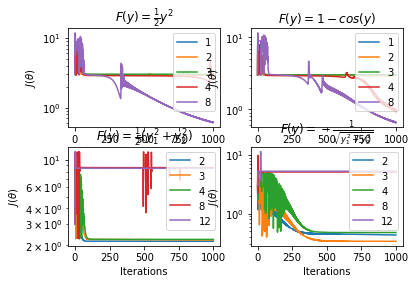

In [453]:
#Changing d

dd = np.array([1, 2, 3, 4, 8, 12])
I = 1575
h = 0.1
K = 10
tol_its = 1000

tt = []
fig, axs = plt.subplots(2,2)
its = np.arange(tol_its + 1)
for i in range(len(dd)-1):

    start = time.time()
    theta1, z1, p1, onez1, c1, m01, ac1, bc1, ay1, by1 = generate_input(F1, I, 1, dd[i], [-2,2], K)
    theta2, z2, p2, onez2, c2, m02, ac2, bc2, ay2, by2 = generate_input(F2, I, 2, dd[i+1], [[-2, -2], [2, 2]], K)
    theta3, z3, p3, onez3, c3, m03, ac3, bc3, ay3, by3 = generate_input(F3, I, 1, dd[i],  [-np.pi / 3, np.pi / 3], K)
    theta4, z4, p4, onez4, c4, m04, ac4, bc4, ay4, by4 = generate_input(F4, I, 2, dd[i+1], [[-2, -2], [2, 2]], K)

    a1, d1 = trainingAlg(theta1, z1, p1, onez1, c1, m01, std_gradient_descent, sig2, prime_sig2, eta2, prime_eta2, K, h,
                         tol_its)
    a2, d2 = trainingAlg(theta2, z2, p2, onez2, c2, m02, std_gradient_descent, sig2, prime_sig2, eta2, prime_eta2, K, h,
                         tol_its)
    a3, d3 = trainingAlg(theta3, z3, p3, onez3, c3, m03, std_gradient_descent, sig2, prime_sig2, eta2, prime_eta2, K, h,
                         tol_its)
    a4, d4 = trainingAlg(theta4, z4, p4, onez4, c4, m04, std_gradient_descent, sig2, prime_sig2, eta2, prime_eta2, K, h,
                         tol_its)
    stop = time.time()
    tt.append(stop-start)
    axs[0,0].semilogy(its[:len(d1)], d1, label = dd[i])

    axs[1,0].semilogy(its[:len(d2)], d2, label= dd[i+1])

    axs[0,1].semilogy(its[:len(d3)], d3, label= dd[i])

    axs[1,1].semilogy(its[:len(d4)], d4, label= dd[i+1])

print(tt)

axs[0, 0].set_title(r'$F(y) = \frac{1}{2}y^2$')
axs[1, 0].set_title(r'$F(y) = \frac{1}{2}(y_1^2 + y_2^2)$')
axs[0, 1].set_title(r'$F(y) = 1 - cos(y)$')
axs[1, 1].set_title(r'$F(y) = - \frac{1}{\sqrt{y_1^2 + y_2^2}}$')
axs[0,0].legend()
axs[1,0].legend()
axs[0,1].legend()
axs[1,1].legend()

for ax in axs.flat:
    ax.set(xlabel='Iterations', ylabel=r'$J(\theta)$')

#PLOT AT THE BOTTOM

4) Testing different values for $\tau$.

[[ 0.46246831]
 [ 1.72746529]
 [ 0.00696725]
 [ 1.04444933]
 [ 0.03011089]
 [-0.86934316]
 [ 0.35589245]
 [ 0.80778246]
 [ 0.49277472]
 [-0.74357013]
 [-1.34749358]
 [ 0.43837002]
 [-1.57658692]
 [ 0.45329069]
 [-0.93903071]
 [-0.12017267]
 [ 0.4424633 ]
 [-1.954281  ]
 [ 0.69012901]
 [ 0.67536922]
 [ 0.17855465]
 [-1.67894097]
 [-1.51593074]
 [-1.89175221]
 [ 1.18976915]
 [-1.33999859]
 [-1.41101201]
 [-0.99557381]
 [-0.85066205]
 [-0.74682526]
 [-2.        ]
 [ 0.52019323]
 [ 0.50611857]
 [-0.33033983]
 [ 1.80593039]
 [ 1.79537491]
 [ 1.32973107]
 [ 0.47914994]
 [-1.27476872]
 [ 0.46880191]
 [ 1.41293482]
 [-1.40268729]
 [ 1.00935821]
 [-0.83589771]
 [-0.17246163]
 [ 1.59205828]
 [-0.27805386]
 [ 0.96599962]
 [-1.43588832]
 [ 0.98746394]
 [-0.88074366]
 [ 1.91551232]
 [-1.08901102]
 [-0.60794669]
 [ 1.35816228]
 [-0.73550091]
 [ 1.51241578]
 [ 1.91882273]
 [-1.05126231]
 [ 1.59770488]
 [-1.59566926]
 [ 1.14912876]
 [ 0.74248013]
 [-1.01849821]
 [-0.76458406]
 [ 1.00433309]
 [-1.83774

1.5874159025669383
1.5565174975186062
1.5283587858233594
1.5027556951796075
1.4795247993169758
1.4584860481899573
1.4394649287559378
1.4222941088533168
1.4068146237067898
1.3928766673997472
1.380340051178434
1.3690743875342914
1.3589590544063936
1.349882988205992
1.3417443482251263
1.334450088769554
1.3279154693607973
1.3220635277923198
1.3168245358270911
1.312135452948309
1.307939389832251
1.304185090077608
1.3008264361520627
1.2978219834446132
1.2951345246761563
1.2927306856562863
1.2905805524196376
1.2886573290746204
1.286937025201751
1.28539817130556
1.2840215606174743
1.282790015437423
1.281688176165044
1.2807023111877405
1.279820145847071
1.279030708784933
1.2783241940674452
1.2776918375902526
1.2771258063789332
1.2766190995084012
1.2761654594729768
1.2757592929422352
1.2753955999356605
1.2750699105407817
1.2747782283845301
1.274516980145926
1.274282970469999
1.2740733417083097
1.2738855379708771
1.273717273028129
1.2735665016500446
1.273431394013403
1.273310312847343
1.273201793

1.2721670398733775
1.2721668218371116
1.2721666038542736
1.2721663859248364
1.2721661680487735
1.2721659502260578
1.2721657324566633
1.2721655147405624
1.272165297077729
1.2721650794681365
1.272164861911758
1.2721646444085668
1.2721644269585364
1.2721642095616401
1.2721639922178511
1.2721637749271435
1.2721635576894899
1.2721633405048642
1.2721631233732396
1.2721629062945898
1.2721626892688882
1.272162472296108
1.272162255376223
1.2721620385092067
1.2721618216950326
1.2721616049336741
1.2721613882251048
1.2721611715692984
1.2721609549662283
1.272160738415868
1.2721605219181913
1.2721603054731718
1.2721600890807832
1.2721598727409986
1.2721596564537923
1.2721594402191376
1.2721592240370083
1.2721590079073781
1.2721587918302206
1.2721585758055096
1.272158359833219
1.272158143913322
1.2721579280457929
1.2721577122306051
1.2721574964677325
1.2721572807571488
1.2721570650988283
1.2721568494927442
1.2721566339388704
1.272156418437181
1.2721562029876496
1.2721559875902504
1.2721557722449568
1

1.2720686474462628
1.2720684520773564
1.2720682567504764
1.272068061465601
1.2720678662227094
1.2720676710217798
1.2720674758627915
1.272067280745723
1.2720670856705532
1.2720668906372607
1.2720666956458246
1.2720665006962235
1.2720663057884365
3.5603410061604084
3.4112527093380147
3.2458151836279145
3.0649088239596036
2.870862468437676
2.6676372671305577
2.460686701310493
2.256412132304508
2.0612981232374987
1.8809780414207091
1.7195246936617772
1.579145275228554
1.4602757763672114
1.3619406709118438
1.2822158558293963
1.218672501755914
1.1687353837298775
1.1299336767462893
1.100050000968203
1.0771878074047467
1.0597817441438673
1.046573773900035
1.0365726836680724
1.0290088032170777
1.023290773350137
1.018967635032172
1.0156972779027975
1.0132210655373386
1.0113438949600806
1.0099187727234686
1.008835013241438
1.0080092750148368
1.0073787857306407
1.0068962379679953
1.0065259510060134
1.006240987738857
1.006020989978386
1.005850553148455
1.0057180056019115
1.0056144913612786
1.005533

1.0047165498154798
1.0047153580864743
1.0047141666576187
1.0047129755288478
1.0047117847000964
1.0047105941713
1.0047094039423932
1.0047082140133115
1.00470702438399
1.0047058350543634
1.0047046460243674
1.0047034572939366
1.0047022688630065
1.0047010807315122
1.0046998928993889
1.0046987053665717
1.0046975181329958
1.0046963311985966
1.004695144563309
1.0046939582270684
1.0046927721898105
1.00469158645147
1.0046904010119824
1.004689215871283
1.0046880310293071
1.0046868464859902
1.0046856622412672
1.0046844782950741
1.0046832946473458
1.0046821112980175
1.0046809282470253
1.004679745494304
1.0046785630397892
1.0046773808834164
1.004676199025121
1.0046750174648384
1.0046738362025043
1.004672655238054
1.0046714745714231
1.004670294202547
1.0046691141313615
1.0046679343578016
1.0046667548818033
1.0046655757033023
1.0046643968222337
1.0046632182385336
1.0046620399521373
1.0046608619629802
1.0046596842709987
1.0046585068761278
1.0046573297783032
1.004656152977461
1.0046549764735364
1.00465

1.0041937197207753
1.0041926607715763
1.0041916020937234
1.0041905436871565
1.0041894855518176
1.004188427687647
1.004187370094586
1.0041863127725756
1.004185255721557
1.0041841989414708
1.0041831424322587
1.0041820861938615
1.00418103022622
1.0041799745292757
1.0041789191029697
1.004177863947243
1.0041768090620367
1.004175754447292
1.00417470010295
1.004173646028952
1.0041725922252394
1.004171538691753
1.0041704854284343
1.0041694324352242
1.0041683797120642
1.0041673272588958
1.0041662750756595
1.0041652231622975
1.0041641715187504
1.0041631201449597
1.0041620690408668
1.0041610182064131
1.0041599676415396
1.0041589173461878
1.0041578673202993
1.0041568175638154
1.004155768076677
1.0041547188588265
1.004153669910204
1.0041526212307519
1.0041515728204113
1.0041505246791238
1.0041494768068306
1.0041484292034735
1.0041473818689934
1.0041463348033328
1.004145288006432
1.0041442414782336
1.0041431952186783
1.004142149227708
1.0041411035052643
1.004140058051289
1.0041390128657228
1.0041379

1.3644479783972385
1.3644477440120069
1.3644475097155089
1.3644472755077004
1.3644470413885377
1.364446807357977
1.364446573415974
1.364446339562485
1.3644461057974662
1.3644458721208736
1.3644456385326635
1.3644454050327919
1.3644451716212151
1.3644449382978896
1.3644447050627713
1.3644444719158166
1.364444238856982
1.3644440058862233
1.3644437730034975
1.3644435402087605
1.3644433075019686
1.3644430748830787
1.364442842352047
1.3644426099088298
1.3644423775533838
1.3644421452856654
1.3644419131056311
1.3644416810132374
1.364441449008441
1.3644412170911984
1.3644409852614663
1.364440753519201
1.3644405218643594
1.3644402902968982
1.3644400588167742
1.3644398274239438
1.3644395961183637
1.364439364899991
1.3644391337687822
1.3644389027246946
1.3644386717676842
1.3644384408977086
1.364438210114724
1.3644379794186878
1.364437748809557
1.3644375182872879
1.3644372878518378
1.3644370575031637
1.3644368272412226
1.3644365970659715
1.3644363669773674
1.3644361369753673
1.3644359070599281
1.3

1.3643437364845667
1.3643435404322435
1.3643433444496604
1.364343148536783
1.3643429526935764
1.3643427569200064
1.3643425612160385
1.364342365581638
1.3643421700167708
1.3643419745214023
1.364341779095498
1.3643415837390236
1.3643413884519446
1.3643411932342266
1.3643409980858354
1.3643408030067368
1.3643406079968963
1.3643404130562793
1.364340218184852
1.36434002338258
1.364339828649429
1.3643396339853648
1.364339439390353
1.3643392448643596
1.3643390504073503
1.364338856019291
1.3643386617001478
1.3643384674498864
1.3643382732684723
1.364338079155872
1.364337885112051
1.3643376911369753
1.364337497230611
1.364337303392924
1.3643371096238803
1.364336915923446
1.364336722291587
1.3643365287282694
1.364336335233459
1.3643361418071223
1.364335948449225
1.3643357551597337
1.364335561938614
1.3643353687858322
1.3643351757013547
1.3643349826851474
1.3643347897371765
1.3643345968574083
1.364334404045809
1.364334211302345
1.3643340186269821
1.3643338260196873
1.3643336334804264
1.36433344100

0.3336446882175934
0.3336428248551726
0.33364096166311935
0.3336390986417336
0.3336372357912891
0.333635373112035
0.33363351060419816
0.333631648267985
0.3336297861035835
0.33362792411116415
0.33362606229088204
0.3336242006428778
0.33362233916727885
0.3336204778642007
0.3336186167337476
0.3336167557760141
0.3336148949910851
0.33361303437903733
0.3336111739399395
0.33360931367385344
0.3336074535808344
0.3336055936609316
0.33360373391418907
0.3336018743406455
0.3336000149403351
0.33359815571328816
0.33359629665953083
0.3335944377790858
0.3335925790719728
0.3335907205382082
0.333588862177806
0.3335870039907777
0.3335851459771323
0.333583288136877
0.33358143047001704
0.3335795729765557
0.3335777156564951
0.33357585850983557
0.3335740015365761
0.3335721447367147
0.33357028811024814
0.333568431657172
0.33356657537748113
0.3335647192711696
0.3335628633382304
0.3335610075786561
0.33355915199243835
0.33355729657956834
0.3335554413400368
0.3335535862738338
0.333551731380949
0.3335498766613716
0.

0.33282887551821444
0.3328270884207685
0.3328253014906706
0.33282351472790583
0.3328217281324593
0.3328199417043164
0.33281815544346216
0.3328163693498818
0.3328145834235604
0.3328127976644833
0.3328110120726357
0.3328092266480027
0.3328074413905695
0.3328056563003213
0.3328038713772433
0.33280208662132066
0.33280030203253863
0.33279851761088236
0.3327967333563372
0.3327949492688882
0.3327931653485205
0.3327913815952194
0.3327895980089701
0.33278781458975787
0.3327860313375678
0.3327842482523852
0.33278246533419514
0.33278068258298293
0.3327788999987338
0.3327771175814329
0.33277533533106557
0.33277355324761687
0.33277177133107205
0.33276998958141646
0.33276820799863516
0.33276642658271344
0.33276464533363653
0.3327628642513896
0.332761083335958
0.33275930258732683
0.33275752200548137
0.33275574159040694
0.33275396134208857
0.3327521812605116
0.3327504013456613
0.33274862159752283
0.33274684201608157
0.3327450626013225
0.33274328335323117
0.3327415042717926
0.3327397253569921
0.3327379

 [0.75       0.53898502]]
[[ 0.69778185]
 [-0.66981301]
 [-0.33277318]
 [ 0.88544245]
 [-0.6855738 ]
 [ 0.64989314]
 [-0.95936441]
 [-0.61852197]
 [-0.13207367]
 [ 0.54820537]
 [-0.47590335]
 [-0.97417803]
 [ 0.23150099]
 [-0.85601229]
 [ 0.8379913 ]
 [-0.92676104]
 [ 0.16519831]
 [-0.96162673]
 [-0.82455592]
 [-0.06143892]
 [-0.16749355]
 [-0.10855599]
 [ 0.20653137]
 [-0.59398919]
 [ 0.80695708]
 [ 0.74437547]
 [ 0.35009048]
 [-0.24170506]
 [ 0.57062755]
 [-0.66140138]
 [ 0.76011382]
 [-0.01882053]
 [-0.14200762]
 [-0.50372639]
 [-0.03679469]
 [ 0.01244557]
 [-0.96712242]
 [ 0.65487434]
 [-0.27636999]
 [ 0.28999933]
 [-0.17344538]
 [ 0.65793907]
 [ 0.37716341]
 [-0.13794271]
 [ 0.70040762]
 [ 0.70143031]
 [-0.12978723]
 [-0.74104594]
 [ 0.22099027]
 [ 0.2963162 ]
 [ 1.01112581]
 [ 0.23701472]
 [-0.50713689]
 [ 0.53247767]
 [-0.50692876]
 [-0.72037439]
 [ 0.20529296]
 [ 0.49127515]
 [-0.39029233]
 [ 0.61515645]
 [ 0.99114275]
 [-0.92812311]
 [-0.97374006]
 [ 0.90142136]
 [-0.97714759]

1.3254991706559376
1.3254794818086961
1.3254598654776322
1.3254403213822201
1.3254208492430573
1.3254014487818562
1.325382119721443
1.3253628617857498
1.3253436746998115
1.325324558189761
1.3253055119828239
1.3252865358073138
1.325267629392628
1.3252487924692424
1.3252300247687079
1.325211326023644
1.325192695967736
1.325174134335729
1.3251556408634244
1.3251372152876746
1.3251188573463795
1.3251005667784805
1.3250823433239576
1.3250641867238238
1.3250460967201212
1.3250280730559167
1.3250101154752978
1.3249922237233671
1.3249743975462394
1.3249566366910364
1.3249389409058827
1.3249213099399022
1.324903743543213
1.3248862414669227
1.3248688034631257
1.3248514292848983
1.324834118686294
1.3248168714223396
1.324799687249032
1.3247825659233325
1.324765507203165
1.3247485108474086
1.3247315766158967
1.3247147042694116
1.32469789356968
1.3246811442793704
1.324664456162088
1.3246478289823707
1.324631262505686
1.3246147564984267
1.3245983107279067
1.3245819249623574
1.3245655989709237
1.32454

1.3210898238816307
1.3210856848624362
1.3210815587195606
1.3210774454032637
1.3210733448639933
1.3210692570523828
1.3210651819192512
1.3210611194156023
1.3210570694926242
1.3210530321016878
1.3210490071943473
1.3210449947223384
1.3210409946375785
1.3210370068921653
1.3210330314383767
1.3210290682286696
1.3210251172156793
1.3210211783522194
1.3210172515912808
1.3210133368860302
1.321009434189811
1.3210055434561412
1.3210016646387137
1.3209977976913951
1.3209939425682253
1.3209900992234167
1.3209862676113535
1.3209824476865912
1.3209786394038565
1.3209748427180452
1.3209710575842224
1.320967283957623
1.3209635217936484
1.3209597710478689
1.32095603167602
1.320952303634005
1.3209485868778912
1.3209448813639115
1.3209411870484635
1.3209375038881075
1.3209338318395671
1.3209301708597287
1.3209265209056402
1.3209228819345105
1.3209192539037093
1.3209156367707662
1.32091203049337
1.3209084350293683
1.320904850336767
1.3209012763737296
1.320897713098576
1.320894160469783
1.3208906184459832
1.3

1.3199849773157843
1.3199835827398407
1.319982190045996
1.3199807992255799
1.319979410269954
1.3199780231705116
1.3199766379186781
1.3199752545059102
1.3199738729236956
1.3199724931635537
1.3199711152170348
1.3199697390757203
1.3199683647312228
1.3199669921751849
1.319965621399281
1.3199642523952153
1.3199628851547225
1.3199615196695678
1.3199601559315466
1.3199587939324844
1.3199574336642363
1.319956075118688
1.3199547182877551
1.3199533631633813
1.3199520097375417
1.3199506580022395
1.319949307949508
1.3199479595714092
1.3199466128600346
1.3199452678075045
1.3199439244059679
1.319942582647603
1.319941242524616
1.3199399040292426
1.3199385671537458
1.319937231890418
1.3199358982315785
1.3199345661695765
1.3199332356967877
1.3199319068056163
1.3199305794884943
1.3199292537378815
1.3199279295462647
1.3199266069061588
4.761134410714437
4.6127907741695875
4.286625803406662
3.39131090136192
1.208780075132502
0.9718289423085374
0.9271150586124864
0.9245307378632956
0.923842905434752
0.92387

0.9195379399245088
0.9195315336279297
0.919525143845573
0.9195187705427387
0.9195124136847799
0.919506073237104
0.9194997491651722
0.9194934414344995
0.9194871500106546
0.9194808748592599
0.919474615945991
0.9194683732365777
0.9194621466968027
0.9194559362925027
0.9194497419895669
0.9194435637539385
0.919437401551614
0.9194312553486427
0.9194251251111267
0.9194190108052223
0.9194129123971375
0.9194068298531343
0.9194007631395268
0.9193947122226823
0.9193886770690209
0.9193826576450154
0.919376653917191
0.9193706658521257
0.9193646934164502
0.9193587365768472
0.9193527953000521
0.9193468695528526
0.919340959302089
0.9193350645146534
0.9193291851574903
0.9193233211975962
0.9193174726020198
0.9193116393378616
0.9193058213722743
0.9193000186724626
0.9192942312056827
0.9192884589392424
0.9192827018405019
0.9192769598768724
0.919271233015817
0.9192655212248506
0.919259824471539
0.9192541427234998
0.9192484759484021
0.9192428241139659
0.9192371871879627
0.9192315651382152
0.9192259579325973
0

0.917844978240524
0.9178433358462761
0.9178416986353061
0.917840066592479
0.9178384397026901
0.9178368179508647
0.9178352013219586
0.917833589800957
0.9178319833728756
0.91783038202276
0.9178287857356855
0.9178271944967574
0.9178256082911109
0.9178240271039109
0.9178224509203519
0.9178208797256583
0.9178193135050844
0.9178177522439136
0.917816195927459
0.9178146445410637
0.9178130980700996
0.9178115564999686
0.9178100198161017
0.9178084880039593
0.9178069610490315
0.9178054389368369
0.9178039216529241
0.9178024091828705
0.9178009015122828
0.9177993986267967
0.9177979005120769
0.9177964071538175
0.9177949185377412
0.9177934346495998
0.917791955475174
0.9177904810002734
0.9177890112107361
0.9177875460924296
0.9177860856312494
0.9177846298131203
0.9177831786239956
0.9177817320498567
0.9177802900767142
0.9177788526906072
0.917777419877603
0.9177759916237972
0.9177745679153143
0.9177731487383067
0.9177717340789554
0.9177703239234697
0.9177689182580867
0.9177675170690724
0.9177661203427202
0

1.2797797137187323
1.279779047539352
1.2797783828708966
1.2797777197064786
1.279777058039243
1.2797763978623684
1.2797757391690645
1.2797750819525746
1.2797744262061737
1.2797737719231688
1.2797731190968984
1.2797724677207338
1.279771817788077
1.2797711692923617
1.2797705222270528
1.2797698765856462
1.2797692323616694
1.2797685895486801
1.2797679481402668
1.279767308130049
1.2797666695116758
1.2797660322788273
1.2797653964252134
1.2797647619445738
1.2797641288306782
1.2797634970773262
1.2797628666783465
1.2797622376275977
1.2797616099189668
1.279760983546371
1.2797603585037556
1.2797597347850955
1.2797591123843937
1.2797584912956816
1.27975787151302
1.279757253030497
1.2797566358422292
1.2797560199423617
1.2797554053250666
1.2797547919845442
1.2797541799150227
1.2797535691107575
1.2797529595660313
1.279752351275154
1.2797517442324633
1.2797511384323224
1.2797505338691226
1.2797499305372817
1.279749328431244
1.2797487275454797
1.2797481278744862
1.279747529412787
1.2797469321549306
1.27

1.2795525508219385
1.2795521902035478
1.2795518297871546
1.2795514695720764
1.2795511095576337
1.2795507497431502
1.279550390127952
1.2795500307113696
1.2795496714927357
1.2795493124713861
1.27954895364666
1.279548595017899
1.2795482365844486
1.2795478783456569
1.2795475203008746
1.2795471624494557
1.2795468047907577
1.27954644732414
1.2795460900489655
1.2795457329646005
1.2795453760704132
1.2795450193657751
1.2795446628500613
1.2795443065226486
1.2795439503829173
1.2795435944302505
1.279543238664034
1.2795428830836564
1.2795425276885093
1.279542172477987
1.2795418174514859
1.2795414626084065
1.2795411079481511
1.2795407534701246
1.2795403991737355
1.279540045058394
1.2795396911235137
1.2795393373685104
1.2795389837928033
1.2795386303958132
1.2795382771769641
1.279537924135683
1.279537571271399
1.2795372185835436
1.2795368660715516
1.27953651373486
1.279536161572908
1.2795358095851384
1.279535457770995
1.2795351061299254
1.2795347546613796
1.2795344033648093
1.2795340522396692
1.279533

0.3074284918910368
0.30741900908021746
0.3074095356446385
0.30740007157363736
0.3073906168565652
0.3073811714827867
0.30737173544168056
0.30736230872263887
0.30735289131506754
0.3073434832083861
0.3073340843920278
0.3073246948554393
0.3073153145880809
0.3073059435794266
0.30729658181896374
0.3072872292961934
0.30727788600063005
0.30726855192180164
0.30725922704924946
0.30724991137252866
0.30724060488120736
0.3072313075648672
0.3072220194131035
0.3072127404155245
0.3072034705617521
0.30719420984142154
0.3071849582441811
0.30717571575969266
0.3071664823776311
0.3071572580876849
0.30714804287955527
0.30713883674295717
0.3071296396676183
0.30712045164327995
0.3071112726596961
0.30710210270663435
0.3070929417738749
0.30708378985121165
0.3070746469284511
0.307065512995413
0.3070563880419302
0.30704727205784826
0.30703816503302617
0.30702906695733556
0.30701997782066126
0.3070108976129009
0.30700182632396517
0.3069927639437775
0.3069837104622743
0.306974665869405
0.30696563015513156
0.3069566

0.30386397959302575
0.3038579125917966
0.30385185119867864
0.30384579540770335
0.3038397452129093
0.30383370060834236
0.3038276615880554
0.30382162814610864
0.30381560027656906
0.303809577973511
0.3038035612310159
0.30379755004317205
0.30379154440407513
0.3037855443078277
0.3037795497485395
0.30377356072032724
0.30376757721731457
0.3037615992336323
0.30375562676341833
0.30374965980081753
0.30374369833998155
0.3037377423750694
0.3037317919002468
0.3037258469096864
0.30371990739756827
0.30371397335807887
0.30370804478541197
0.30370212167376803
0.3036962040173547
0.30369029181038637
0.3036843850470844
0.3036784837216771
0.3036725878283995
0.30366669736149376
0.3036608123152087
0.3036549326838
0.3036490584615305
0.3036431896426695
0.30363732622149336
0.3036314681922852
0.3036256155493351
0.30361976828693954
0.3036139263994023
0.3036080898810337
0.30360225872615093
0.3035964329290778
0.303590612484145
0.30358479738569
0.3035789876280569
0.30357318320559684
0.3035673841126672
0.3035615903436

1.3458327628734394
1.3458298289402884
1.3458269053316279
1.3458239919374917
1.3458210886492648
1.345818195359666
1.3458153119627305
1.3458124383537935
1.3458095744294734
1.345806720087655
1.3458038752274728
1.3458010397492965
1.3457982135547144
1.3457953965465166
1.3457925886286817
1.34578978970636
1.345786999685859
1.3457842184746287
1.345781445981247
1.3457786821154045
1.3457759267878922
1.3457731799105845
1.345770441396428
1.3457677111594264
1.3457649891146268
1.345762275178108
1.3457595692669646
1.3457568712992973
1.3457541811941967
1.3457514988717334
1.3457488242529438
1.3457461572598184
1.3457434978152896
1.3457408458432196
1.3457382012683883
1.3457355640164819
1.3457329340140816
1.3457303111886514
1.3457276954685273
1.3457250867829065
1.345722485061836
1.3457198902362009
1.3457173022377162
1.3457147209989135
1.3457121464531325
1.3457095785345092
1.3457070171779677
1.3457044623192074
1.3457019138946964
1.345699371841659
1.3456968360980675
1.3456943066026321
1.3456917832947919
1.3

1.3447992134593665
1.344797468377057
1.3447957235339316
1.3447939789269474
1.344792234553064
1.3447904904092445
1.3447887464924546
1.3447870027996625
1.3447852593278395
1.34478351607396
1.3447817730350005
1.3447800302079405
1.3447782875897627
1.344776545177451
1.3447748029679933
1.3447730609583795
1.3447713191456017
1.344769577526655
1.344767836098537
1.3447660948582467
1.3447643538027871
1.344762612929162
1.3447608722343787
1.344759131715446
1.3447573913693753
1.34475565119318
1.344753911183876
1.3447521713384814
1.3447504316540155
1.3447486921275011
1.344746952755962
1.3447452135364242
1.3447434744659166
1.3447417355414686
1.3447399967601126
1.3447382581188827
1.3447365196148147
1.344734781244946
1.3447330430063167
1.344731304895968
1.3447295669109427
1.3447278290482858
1.3447260913050438
1.3447243536782656
1.344722616165
1.3447208787622995
1.3447191414672166
1.3447174042768062
1.3447156671881246
1.3447139301982294
1.34471219330418
1.344710456503037
1.3447087197918626
1.3447069831677

2.0980429747747107
2.678039756917817
3.3189573518783377
2.280785196719732
2.4348252405680477
3.270447114646494
2.0695497819951445
2.580594775325505
3.2573971143913028
2.0368996102031285
2.5325864272016947
3.2177134186505167
1.8847458786372848
2.5101360362886624
3.1756075467996974
1.7334072662139948
2.421684862611573
3.1193080921314724
1.537745577035708
2.235688500265456
3.025400053770973
1.2430378562843263
1.7628560362117178
2.6899927904539185
1.1814304422428485
1.7011898625771855
2.2186722165219264
2.9278491470072234
1.074648369596416
1.2833912974946022
1.9016441897765766
2.1337073560344573
2.823370454045231
0.9919251673752851
0.996587257253961
1.0267997170140915
1.1143600385959262
1.4367068925383326
1.8862453891016082
2.6152088686077293
1.1454527248356738
1.494166191994793
1.879020424607485
2.5503766034462823
1.195244159559615
1.5804661796017743
1.867657950318428
2.4766694239984264
1.2473708332700508
1.6490590579988753
1.8206020638436546
2.3703615398563738
1.330564981184833
1.7507214

0.9856416198061094
0.9856262496606201
0.9856101859901841
0.9855948388769878
0.9855788333291212
0.9855635097673859
0.9855475611461021
0.9855322616183642
0.9855163687738694
0.9855010937279647
0.985485255554609
0.9854700054055098
0.9854542208398339
0.9854389959713925
0.9854232639902673
0.9854080647568749
0.9853923843757263
0.9853772111038898
0.9853615813750084
0.9853464343648471
0.9853308543757762
0.9853157339024468
0.9853002027744444
0.9852851090894932
0.9852696259760675
0.9852545593087163
0.9852391233942277
0.9852240839525953
0.9852086944509243
0.9851936824231883
0.9851783385764642
0.9851633541319627
0.985148055209352
0.9851330984996326
0.9851178437961831
0.9851029149559983
0.9850877037915357
0.985072802939789
0.9850576346578652
0.985042761898509
0.9850276358653994
0.9850127912882891
0.9849977068920335
0.9849828905737378
0.9849678472232278
0.9849530592277983
0.9849380563519056
0.9849232967316082
0.9849083337783513
0.9848936025743604
0.9848786790101116
0.9848639762531689
0.98484909156189

0.9798953698208147
0.979885094418041
0.9798748276666328
0.9798645695572347
0.979854320085094
0.9798440792410151
0.9798338470201009
0.9798236234133056
0.9798134084155963
0.979803202018067
0.9797930042155576
0.9797828149992928
0.9797726343639936
0.9797624623010064
0.9797522988049409
0.9797421438672568
0.9797319974824596
0.9797218596421151
0.9797117303406307
0.9797016095696709
0.9796914973235515
0.979681393594029
0.9796712983753332
0.9796612116593059
0.9796511334400967
0.9796410637096269
0.9796310024619704
0.9796209496891226
0.9796109053850868
0.9796008695419265
0.9795908421535788
0.9795808232121713
0.9795708127115782
0.9795608106439866
0.9795508170032119
3.6247529533598537
1.3725887847710336
1.3608840452228954
1.3528287704941144
1.349425249019715
1.347322221536874
1.3462999114931038
1.3456879287302346
1.3453510330128509
1.3451366159487446
1.3449958131150561
1.3448908624077278
1.344806451567021
1.344732732687035
1.3446651738003481
1.344601122092628
1.3445392671594223
1.3444788777278742
1.

1.3387332304927209
1.3387304921927914
1.3387277610366115
1.338725036938049
1.3387223198118903
1.3387196095738298
1.3387169061404596
1.3387142094292601
1.3387115193585888
1.3387088358476718
1.3387061588165927
1.3387034881862845
1.3387008238785185
1.3386981658158967
1.3386955139218406
1.3386928681205832
1.3386902283371596
1.338687594497398
1.3386849665279108
1.3386823443560858
1.3386797279100775
1.3386771171187986
1.3386745119119112
1.338671912219819
1.3386693179736582
1.33866672910529
1.3386641455472919
1.33866156723295
1.3386589940962514
1.3386564260718752
1.3386538630951856
1.3386513051022249
1.3386487520297041
1.3386462038149969
1.3386436603961314
1.3386411217117835
1.338638587701269
1.3386360583045367
1.3386335334621613
1.3386310131153363
1.3386284972058673
1.3386259856761644
1.338623478469237
1.3386209755286849
1.3386184767986933
1.338615982224026
1.3386134917500185
1.3386110053225715
1.3386085228881452
1.338606044393752
1.3386035697869518
1.3386010990158446
1.3385986320290644
1.33

1.3375836680702844
1.3375809956812768
1.337578320883744
1.3375756436710005
1.3375729640363527
1.337570281973101
1.337567597474537
1.337564910533946
1.3375622211446052
1.3375595292997842
1.3375568349927454
1.3375541382167428
1.337551438965023
1.337548737230824
1.3375460330073765
1.3375433262879033
1.337540617065618
1.3375379053337269
1.3375351910854272
1.3375324743139083
1.3375297550123506
1.3375270331739264
1.337524308791799
1.337521581859123
1.3375188523690444
1.3375161203147001
1.3375133856892178
1.337510648485717
1.3375079086973072
1.3375051663170892
1.3375024213381537
1.3374996737535836
1.3374969235564511
1.337494170739819
1.337491415296741
1.3374886572202611
1.3374858965034133
1.337483133139222
1.3374803671207018
1.3374775984408567
1.3374748270926815
1.3374720530691608
1.3374692763632687
1.337466496967969
1.3374637148762158
1.3374609300809521
1.337458142575111
1.3374553523516148
1.337452559403375
1.3374497637232932
1.3374469653042593
1.3374441641391532
1.3374413602208437
1.3374385

0.5115118365945659
0.5988363040058355
0.5103228326691083
0.5965529735955208
0.5091327624940346
0.5942756802488083
0.5079417449175341
0.5920046106956136
0.5067498989931009
0.5897399497115663
0.505557343930562
0.5874818800613989
0.5043641990472408
0.5852305824438745
0.5031705837193073
0.5829862354382908
0.501976617333339
0.5807490154525699
0.5007824192381439
0.5785190966729602
0.49958810869687525
0.5762966510153594
0.49839380483947565
0.5740818480782816
0.4971996266154885
0.5718748550974767
0.49600569274726947
0.569675836902212
0.49481212168363164
0.5674849558732298
0.49361903155396075
0.5653023719023851
0.4924265401228259
0.563128242353968
0.49123476474512584
0.5609627220277231
0.490043822321791
0.5588059631235529
0.4888538292560806
0.5566581152079257
0.4876649014104909
0.5545193251819653
0.486477154064314
0.5523897372512417
0.4852907018718626
0.5502694928972387
0.48410565882139456
0.548158730850514
0.4829221381947509
0.5460575870655229
0.4817402525277397
0.5439661946971147
0.4805601135

0.3407924463986171
0.3418123973390795
0.3405811151800932
0.34162181964311106
0.34037274749638263
0.3414336299010275
0.3401673030257703
0.3412478003241096
0.3399647419285871
0.3410643033720722
0.3397650248438127
0.34088311175319463
0.33956811288563044
0.34070419842437394
0.3393739676399357
0.3405275365911034
0.3391825511608002
0.3403530997073781
0.33899382596689726
0.3401808614755287
0.3388077550378867
0.3400107958459875
0.3386243018107658
0.3398428770169874
0.33844343017618667
0.3396770794341954
0.338265104474743
0.3395133777902841
0.3380892894932279
0.339351747024442
0.33791595046086664
0.3391921623218248
0.3377450530455248
0.33903459911294964
0.33757656334989466
0.33887903307303413
0.3374104479076631
0.3387254401212824
0.33724667367966077
0.33857379642011864
0.33708520804999564
0.3384240783743721
0.33692601882217466
0.3382762626304121
0.33676907421521124
0.3381303260752386
0.336614342859724
0.33798624583552694
0.33646179379402824
0.33784399927662917
0.3363113964602186
0.3377035640015

[[ 0.50222677  1.43591386]
 [ 1.3436608   0.26784131]
 [-1.64913007  1.89655389]
 [ 1.98203178 -0.34796482]
 [-1.78014981  2.        ]
 [-1.15523007  0.53253387]
 [ 1.62695614 -0.13208114]
 [ 1.32466266 -0.42511666]
 [ 0.49396027 -1.80744201]
 [-1.52224097  1.02969006]
 [-1.22883425 -1.4445036 ]
 [ 1.34754671 -0.22643904]
 [ 1.2524353  -1.88267483]
 [-1.97421136  1.6513837 ]
 [-1.20244923 -0.33493167]
 [-0.04256416  0.1977405 ]
 [ 1.22848296  0.63637131]
 [ 0.9799415   0.85950391]
 [-0.97349857  0.34738589]
 [ 1.66857999 -1.9537541 ]
 [-0.50460861  0.32868238]
 [-1.76503936 -1.32160185]
 [-0.4770876  -1.09315568]
 [-1.12329464 -1.15705237]
 [-0.88134554  1.2151504 ]
 [ 1.78693753  1.91716048]
 [-1.54332661 -0.1164266 ]
 [ 0.34922751 -1.35362251]
 [-1.74814104 -0.68172076]
 [-0.6169457  -1.71263507]
 [ 0.2436143  -1.72558959]
 [ 1.48743525 -1.15001505]
 [ 0.23212074 -0.64746739]
 [-0.27732023  1.37702361]
 [ 0.2593142  -1.53101482]
 [-1.56778187 -1.08527684]
 [ 1.19230648  0.67071236]
 

1.30132436261273
1.301170281955395
1.3009764420599448
1.300845684908511
1.3006871379373095
1.300576082382944
1.3004457581356583
1.3003512937405968
1.3002436068964813
1.3001630833257667
1.3000736101578818
1.3000047829347445
1.2999300106913827
1.2998709881944222
1.2998081203403566
1.2997573143579504
1.2997041188498097
1.2996601998393977
1.2996148906312777
1.2995767480940754
1.299537892364844
1.2995046002984132
1.2994710456378924
1.299441832772086
1.2994126498931056
1.2993868742823678
1.2993613118405454
1.29933843933197
1.2993158882111342
1.2992954743026233
1.2992754393185681
1.2992571139446314
1.2992391913767818
1.29922264619779
1.2992065059101707
1.2991914837257943
1.2991768549102778
1.299163140864164
1.2991498006491407
1.2991372149365306
1.2991249792672024
1.299113371098465
1.2991020874217882
1.299091330031951
1.2990808714181459
1.2990708579452062
1.29906111835505
1.2990517584382495
1.2990426489059443
1.2990338658795777
1.2990253114285562
1.299017040007648
1.2990089771541313
1.29900116

1.2975127085859925
1.2975084490782267
1.2975041806848393
1.297499903371968
1.2974956171056213
1.2974913218516753
1.2974870175758761
1.2974827042438364
1.2974783818210371
1.297474050272825
1.2974697095644125
1.2974653596608776
1.297461000527162
1.2974566321280716
1.2974522544282747
1.2974478673923027
1.2974434709845473
1.2974390651692618
1.2974346499105596
1.2974302251724128
1.2974257909186526
1.2974213471129683
1.2974168937189052
1.2974124306998658
1.2974079580191085
1.2974034756397457
1.2973989835247446
1.2973944816369252
1.2973899699389606
1.297385448393375
1.2973809169625445
1.2973763756086947
1.2973718242939007
1.2973672629800868
1.2973626916290246
1.297358110202333
1.2973535186614775
1.2973489169677683
1.2973443050823608
1.297339682966254
1.29733505058029
1.2973304078851533
1.2973257548413692
1.2973210914093043
1.2973164175491638
1.2973117332209925
1.2973070383846734
1.2973023329999256
1.2972976170263055
1.2972928904232044
1.2972881531498481
1.2972834051652962
1.297278646428441
1.

2.760907532205073
1.7046673069736462
2.9379884843541704
1.0360582387984982
1.2386357328911408
1.9651788603348992
2.9993419762272233
1.0533136803712928
1.2624226088172124
1.9067646772500533
2.3036030650522314
2.886476883836342
1.035687489861503
1.1249920207498352
1.3800670191171656
1.7326290389761951
2.29950697375754
1.4535818262615043
1.8518494754686052
1.6553122901217578
1.9814897419958377
1.4672843905512494
1.6826737185616594
1.4540468106234443
1.599357871914799
1.3799673438221303
1.466691219729223
1.307359632762282
1.3543337731816085
1.2399853192867902
1.261923755236099
1.1814578311253405
1.188936453233847
1.1333224061988412
1.1332946243051747
1.095418436712659
1.0920727341304421
1.0665536217862224
1.0621894442690805
1.045112421775523
1.0408564126362974
1.0294653527117419
1.0257781777842838
1.0181817075166686
1.0151796697231075
1.0101031543742744
1.0077446975284963
1.0043390626012882
1.0025242832849102
1.000227547573651
0.9988466326621539
0.997287757626974
0.9962416495000592
0.99517

0.9879324813393067
0.987931543193985
0.9879306050778401
0.9879296669941391
0.9879287289460827
0.9879277909368145
0.9879268529694133
0.9879259150469029
0.9879249771722451
0.9879240393483486
0.9879231015780623
0.9879221638641829
0.9879212262094509
0.9879202886165559
0.9879193510881332
0.987918413626769
0.9879174762349975
0.9879165389153052
0.9879156016701285
0.987914664501858
0.987913727412836
0.9879127904053605
0.9879118534816832
0.9879109166440125
0.987909979894513
0.987909043235307
0.9879081066684746
0.9879071701960556
0.9879062338200483
0.987905297542413
0.9879043613650695
0.9879034252899012
0.9879024893187525
0.9879015534534322
0.9879006176957122
0.98789968204733
0.987898746509987
0.9878978110853517
0.9878968757750581
0.9878959405807085
0.9878950055038714
0.9878940705460851
0.9878931357088558
0.9878922009936595
0.9878912664019421
0.9878903319351204
0.9878893975945818
0.9878884633816857
0.9878875292977636
0.9878865953441196
0.9878856615220308
0.9878847278327486
0.9878837942774977
0.9

0.9875205955105678
0.9875197300611542
0.9875188647618713
0.9875179996125939
0.9875171346131968
0.987516269763555
0.9875154050635434
0.9875145405130371
0.9875136761119112
0.9875128118600408
0.9875119477573011
0.9875110838035676
0.9875102199987151
0.9875093563426195
0.9875084928351562
0.9875076294762005
0.987506766265628
0.9875059032033147
0.9875050402891357
0.9875041775229672
0.9875033149046848
0.9875024524341645
0.9875015901112822
0.9875007279359139
0.9874998659079356
0.9874990040272235
0.9874981422936537
0.9874972807071025
0.9874964192674464
0.9874955579745613
0.9874946968283241
0.987493835828611
0.9874929749752988
0.9874921142682637
0.9874912537073828
0.9874903932925325
0.9874895330235899
0.9874886729004317
0.987487812922935
0.9874869530909764
0.9874860934044333
0.9874852338631827
0.9874843744671018
0.9874835152160678
0.9874826561099578
0.9874817971486496
0.9874809383320203
0.9874800796599474
0.9874792211323088
0.9874783627489817
0.9874775045098437
0.987476646414773
0.987475788463647

1.3280943838190093
1.328089885932795
1.328085378048853
1.328080860132545
1.3280763321491196
1.3280717940636713
1.3280672458411809
1.3280626874464736
1.3280581188442584
1.3280535399990885
1.3280489508753979
1.3280443514374642
1.328039741649444
1.3280351214753368
1.3280304908790181
1.3280258498242061
1.3280211982744923
1.3280165361933098
1.3280118635439642
1.3280071802896005
1.328002486393234
1.3279977818177193
1.3279930665257786
1.327988340479972
1.327983603642726
1.3279788559763033
1.3279740974428311
1.3279693280042721
1.3279645476224506
1.3279597562590257
1.3279549538755164
1.327950140433275
1.3279453158935113
1.3279404802172674
1.3279356333654415
1.3279307752987626
1.3279259059778128
1.3279210253630047
1.3279161334146024
1.327911230092698
1.3279063153572337
1.327901389167978
1.3278964514845486
1.3278915022663873
1.3278865414727823
1.3278815690628458
1.327876584995534
1.327871589229626
1.327866581723742
1.3278615624363244
1.3278565313256538
1.327851488349833
1.3278464334667999
1.32784

1.3235751093571844
1.3235562434550863
1.323537303399289
1.3235182887962866
1.3234991992531966
1.3234800343711728
1.3234607937522527
1.3234414769921534
1.323422083687765
1.3234026134292667
1.3233830658083336
1.323363440409503
1.3233437368191683
1.3233239546161168
1.3233040933813942
1.3232841526879267
1.3232641321113456
1.3232440312186013
1.3232238495798465
1.3232035867559353
1.3231832423114784
1.3231628158011102
1.3231423067838375
1.323121714807945
1.3231010394267766
1.323080280182133
1.3230594366216377
1.323038508280467
1.3230174947004698
1.322996395410051
1.3229752099452359
1.322953937827504
1.3229325785870094
1.3229111317381466
1.3228895968051588
1.3228679732951847
1.3228462607265223
1.322824458598877
1.3228025664245744
1.3227805836957
1.3227585099185866
1.3227363445775029
1.3227140871727805
1.3226917371806628
1.3226692940954818
1.322646757385236
1.322624126538274
1.322601401014116
1.3225785802951586
1.3225556638321976
1.322532651101728
1.3225095415455588
1.322486334634356
1.32246302

0.5229855814183315
0.524784792607583
0.5227654546589209
0.5245255725881757
0.522553815049996
0.5242764506735178
0.5223502068781306
0.5240368832906924
0.5221542035183455
0.5238063622465962
0.521965405359146
0.5235844121084545
0.5217834378854781
0.5233705877961609
0.5216079499073191
0.5231644723683246
0.5214386119225484
0.522965674985506
0.5212751146036033
0.5227738290355639
0.5211171673982314
0.5225885904073762
0.520964497235402
0.522409635900392
0.5208168473281344
0.5222366617585867
0.5206739760656522
0.5220693823183862
0.5205356559878639
0.521907528761046
0.5204016728357339
0.5217508479608015
0.5202718246716138
0.5215991014208653
0.5201459210640785
0.521452064290035
0.5200237823322468
0.5213095244533064
0.5199052388449712
0.5211712816904569
0.5197901303706458
0.5210371468970867
0.5196783054737275
0.5209069413630759
0.5195696209543738
0.5207804961038537
0.5194639413278931
0.520657651240262
0.5193611383409641
0.52053825542316
0.5192610905218266
0.5204221652992409
0.5191636827618673
0.52

0.5151580358311563
0.513663475795172
0.5151477695407686
0.5136507694702732
0.515136773342983
0.5136375697502817
0.5151250379098138
0.5136238696864739
0.515112555010926
0.513609663144355
0.5150993175324305
0.513594944817548
0.515085319492067
0.513579710238905
0.5150705560507185
0.5135639557888096
0.5150550235202177
0.5135476787006381
0.5150387193674292
0.5135308770633787
0.5150216422146133
0.5135135498214152
0.5150037918360982
0.5134956967715005
0.5149851691513061
0.5134773185569631
0.5149657762142009
0.5134584166592011
0.5149456161992454
0.5134389933865359
0.5149246933839701
0.513419051860511
0.514903013128278
0.5133985959997323
0.5148805818506219
0.5133776305013631
0.5148574070012083
0.5133561608203897
0.5148334970323942
0.5133341931467944
0.5148088613664537
0.5133117343807704
0.5147835103609054
0.5132887921061284
0.5147574552715953
0.5132653745620478
0.5147307082137419
0.5132414906133291
0.5147032821211525
0.513217149719313
0.5146751907038252
0.5131923619016268
0.5146464484041529
0.5

[[ 0.94961219  1.16511985]
 [-0.14723935 -0.64625889]
 [-0.63031214  0.06708713]
 [-0.90220295  0.31539242]
 [ 0.64489836 -1.0914927 ]
 [ 0.71604815 -0.71685197]
 [ 1.28522359 -0.86735224]
 [-0.79917707  0.85204249]
 [-0.79991222  0.41423649]
 [ 1.2442053   0.85863056]
 [-0.38587606 -0.5893335 ]
 [-1.62882191 -0.5863728 ]
 [-1.98140264 -0.96236244]
 [-0.07775121  1.92883183]
 [ 0.75485298 -1.94237133]
 [-1.93824255 -1.08665825]
 [ 0.06276302  1.55465502]
 [ 1.90624045 -0.64392328]
 [ 0.24572616  0.14489582]
 [-0.77367874  1.67656995]
 [-0.88295642  0.19704349]
 [ 0.26255431 -1.51873133]
 [-1.594509    0.33630336]
 [-1.41297037  1.01677105]
 [-1.25689167 -0.73351103]
 [ 1.06454705  0.37214204]
 [ 0.34495873  0.05932066]
 [ 1.52091455  0.05433082]
 [ 1.12907215 -1.72225652]
 [ 1.6216773   1.25571271]
 [-0.23480267  1.53233988]
 [-0.37926442  0.46819742]
 [ 1.11518259  1.34865638]
 [-0.6692882   1.02649368]
 [-1.45144389 -0.57281912]
 [ 0.45466037 -1.13432736]
 [ 1.87812062  1.75440743]
 

1.2795464322671908
1.2784061957488797
1.2778680686597839
1.276985140401501
1.276533932131478
1.2758470662714299
1.2754707193032555
1.274933870147198
1.274621107269706
1.2741995262179093
1.2739402253644987
1.2736075868226826
1.2733929047442558
1.2731291849200597
1.2729515385917125
1.2727414456722232
1.2725944191063128
1.272426227906598
1.2723044454428198
1.2721691294134632
1.272068119599108
1.2719587020261678
1.2718747655450706
1.2717858328078322
1.2717159213431237
1.2716432563782423
1.2715848653371407
1.2715251705737403
1.2714762463038287
1.2714269334318073
1.271385794295225
1.2713448241403376
1.2713100941842297
1.2712758542896256
1.2712464080023869
1.271217618691235
1.2711925353032008
1.2711681773343808
1.271146703208478
1.2711259618636446
1.271107479664964
1.2710897013847264
1.2710737048818412
1.2710583635203572
1.271044437034906
1.2710311075124292
1.2710189091860913
1.2710072468510694
1.2709964950355717
1.2709862194478985
1.2709766816425088
1.270967563791358
1.2709590476537638
1.270

1.2694027258296237
1.269396635568033
1.2693905227791815
1.2693843873399833
1.2693782291265605
1.2693720480142359
1.269365843877527
1.26935961659014
1.269353366024963
1.2693470920540588
1.2693407945486603
1.2693344733791618
1.2693281284151139
1.2693217595252153
1.2693153665773078
1.2693089494383676
1.2693025079744993
1.2692960420509296
1.2692895515319988
1.2692830362811545
1.2692764961609446
1.2692699310330096
1.2692633407580753
1.2692567251959457
1.2692500842054957
1.269243417644663
1.2692367253704409
1.2692300072388707
1.2692232631050335
1.2692164928230434
1.2692096962460384
1.2692028732261729
1.2691960236146105
1.2691891472615149
1.2691822440160416
1.2691753137263304
1.269168356239497
1.269161371401624
1.269154359057753
1.2691473190518754
1.2691402512269245
1.2691331554247662
1.269126031486191
1.2691188792509032
1.2691116985575144
1.2691044892435326
1.2690972511453542
1.269089984098254
1.2690826879363755
1.2690753624927231
1.269068007599151
1.2690606230863541
1.2690532087838589
1.269

4.647624713123019
0.9821197305890834
1.2691018338700606
3.4432879014364173
1.5562073851894922
4.592261458570474
1.2436518566561001
3.9153875589926823
3.72187757407303
3.649419777917652
3.396920541222473
1.4737019469438064
4.230076159471706
3.1712764467839474
1.3847944180557148
3.326230954588423
1.2875767290538869
3.4288988743879867
3.6898138260294346
3.5904874196772063
3.256162236175944
1.307581272521805
2.9121260625887206
3.5756877667230884
3.2671395012514206
1.831731898198877
2.700726508538953
3.067811726079905
1.449470745037989
1.5799917095266796
1.843849157183922
1.3856359726191976
1.4013175601997099
1.2017527327602797
1.1640434731835259
1.0739241675036908
1.0495507318447514
1.0137763777685167
1.0040165694510197
0.990284534216629
0.9872060218219643
0.9817568334519774
0.980998096802568
0.9786725617870431
0.9785694332317564
0.9774762404252844
0.9774987707742712
0.9769256912627905
0.9769364356322097
0.9766011629550673
0.9765805249659775
0.9763636715120289
0.9763202175351716
0.97616756

0.9743903753984207
0.9743898492555283
0.9743893230864392
0.9743887968912266
0.9743882706699641
0.9743877444227255
0.9743872181495842
0.9743866918506137
0.9743861655258877
0.97438563917548
0.9743851127994642
0.9743845863979138
0.9743840599709025
0.9743835335185039
0.974383007040792
0.9743824805378398
0.9743819540097213
0.97438142745651
0.9743809008782792
0.9743803742751027
0.9743798476470539
0.974379320994206
0.9743787943166327
0.974378267614407
0.9743777408876025
0.9743772141362925
0.9743766873605498
0.9743761605604478
0.9743756337360596
0.9743751068874581
0.9743745800147162
0.9743740531179069
0.974373526197103
0.9743729992523772
0.9743724722838021
0.9743719452914502
0.9743714182753944
0.9743708912357067
0.9743703641724598
0.9743698370857258
0.9743693099755767
0.9743687828420848
0.9743682556853221
0.9743677285053606
0.974367201302272
0.9743666740761279
0.9743661468270002
0.9743656195549601
0.9743650922600794
0.9743645649424294
0.9743640376020811
0.9743635102391057
0.9743629828535744
0.

0.9741396496318429
0.9741391172035859
0.9741385847690113
0.9741380523281211
0.9741375198809172
0.9741369874274017
0.9741364549675764
0.9741359225014424
0.9741353900290015
0.9741348575502546
0.9741343250652028
0.974133792573847
0.9741332600761877
0.9741327275722257
0.9741321950619609
0.9741316625453939
0.9741311300225244
0.9741305974933523
0.9741300649578775
0.974129532416099
0.9741289998680165
0.9741284673136291
0.9741279347529357
0.974127402185935
0.9741268696126258
0.9741263370330067
0.9741258044470757
0.9741252718548312
0.974124739256271
0.9741242066513929
0.9741236740401947
0.9741231414226736
0.9741226087988274
0.9741220761686527
0.9741215435321464
0.9741210108893058
0.9741204782401273
0.9741199455846072
0.974119412922742
0.9741188802545276
0.9741183475799604
0.9741178148990356
0.9741172822117493
0.9741167495180967
0.9741162168180731
0.9741156841116739
0.9741151513988937
3.7742830202066933
3.1103259534707868
1.3693890211787718
1.3849216384228755
1.497219856654676
2.04933885598319
3

1.3504136613737958
1.3504109631232173
1.3504082613407744
1.3504055559981012
1.3504028470667626
1.350400134518253
1.3503974183239975
1.3503946984553492
1.3503919748835893
1.3503892475799262
1.3503865165154951
1.3503837816613566
1.3503810429884973
1.3503783004678267
1.3503755540701785
1.3503728037663099
1.3503700495268987
1.3503672913225448
1.3503645291237687
1.35036176290101
1.350358992624628
1.350356218264899
1.350353439792018
1.3503506571760957
1.3503478703871592
1.35034507939515
1.3503422841699242
1.3503394846812513
1.3503366808988133
1.350333872792204
1.3503310603309284
1.3503282434844015
1.3503254222219476
1.3503225965128
1.350319766326099
1.3503169316308923
1.3503140923961339
1.350311248590682
1.3503084001833006
1.3503055471426557
1.3503026894373176
1.350299827035757
1.3502969599063461
1.3502940880173577
1.3502912113369636
1.350288329833233
1.3502854434741343
1.3502825522275312
1.3502796560611834
1.3502767549427455
1.3502738488397663
1.3502709377196878
1.350268021549843
1.35026510

1.3478467498142135
1.3478348687295505
1.3478229286606853
1.3478109292083111
1.3477988699699037
1.347786750539694
1.3477745705086364
1.3477623294643786
1.347750026991231
1.3477376626701352
1.3477252360786334
1.3477127467908359
1.3477001943773885
1.3476875784054416
1.3476748984386167
1.3476621540369722
1.347649344756972
1.34763647015145
1.3476235297695773
1.3476105231568265
1.3475974498549377
1.3475843094018827
1.3475711013318303
1.3475578251751088
1.3475444804581715
1.347531066703559
1.347517583429861
1.3475040301516819
1.3474904063795994
1.347476711620129
1.3474629453756837
1.3474491071445347
1.347435196420774
1.3474212126942722
1.3474071554506386
1.3473930241711818
1.347378818332867
1.347364537408275
1.3473501808655601
1.3473357481684074
1.3473212387759899
1.347306652142925
1.3472919877192315
1.3472772449502834
1.347262423276766
1.347247522134632
1.347232540955053
1.3472174791643752
1.3472023361840717
1.3471871114306955
1.347171804315832
1.34715641424605
1.3471409406228534
1.347125382

2.348402110944621
2.348402079666561
2.348402048364965
2.348402017039806
2.348401985691058
2.348401954318694
2.348401922922687
2.3484018915030114
2.3484018600596395
2.3484018285925456
2.348401797101702
2.348401765587082
2.3484017340486596
2.348401702486407
2.348401670900297
2.3484016392903033
2.348401607656399
2.348401575998557
2.348401544316749
2.3484015126109496
2.34840148088113
2.3484014491272642
2.3484014173493244
2.348401385547284
2.348401353721114
2.3484013218707886
2.3484012899962794
2.3484012580975597
2.3484012261746012
2.3484011942273773
2.3484011622558594
2.3484011302600205
2.3484010982398322
2.348401066195268
2.3484010341262986
2.3484010020328974
2.348400969915036
2.348400937772687
2.3484009056058217
2.3484008734144126
2.3484008411984316
2.3484008089578507
2.3484007766926416
2.348400744402776
2.3484007120882264
2.348400679748964
2.3484006473849606
2.348400614996188
2.348400582582618
2.348400550144221
2.3484005176809704
2.3484004851928364
2.348400452679791
2.348400420141805
2.

2.3483846314356818
2.3483845856371683
2.3483845397970153
2.348384493915165
2.348384447991561
2.348384402026147
2.348384356018865
2.3483843099696586
2.3483842638784704
2.3483842177452434
2.3483841715699203
2.348384125352443
2.348384079092754
2.3483840327907965
2.3483839864465117
2.3483839400598416
2.3483838936307295
2.348383847159116
2.3483838006449433
2.3483837540881534
2.3483837074886873
2.348383660846487
2.348383614161493
2.3483835674336477
2.3483835206628916
2.348383473849166
2.348383426992411
2.348383380092568
2.3483833331495783
2.348383286163382
2.348383239133919
2.3483831920611307
2.3483831449449566
2.3483830977853373
2.3483830505822123
2.3483830033355226
2.348382956045207
2.348382908711206
2.348382861333458
2.348382813911904
2.3483827664464823
2.3483827189371325
2.3483826713837943
2.3483826237864056
2.3483825761449064
2.3483825284592355
2.348382480729331
2.3483824329551317
2.348382385136576
2.3483823372736023
2.3483822893661492
2.3483822414141544
2.3483821934175566
2.34838214537

[[ 1.45035746  1.00839858]
 [-1.02843146 -0.7381541 ]
 [-1.8489695   1.54178635]
 [ 0.61508404 -1.68040826]
 [ 0.43004957  1.12123672]
 [ 0.12386486 -0.83615084]
 [-0.16217995 -0.65871146]
 [ 2.          0.12417727]
 [-0.87290702 -0.10600374]
 [-0.29678107  1.32569728]
 [ 1.19317673 -1.77184921]
 [ 1.29213299 -0.51985476]
 [-0.49885944  0.90405867]
 [-1.46492645 -0.44872444]
 [-0.36313933 -1.22251704]
 [-1.21518814 -0.49702428]
 [ 0.36347977  1.29906264]
 [ 0.26718004 -0.81006261]
 [-0.17170577  0.40317135]
 [ 1.62794077  0.65822448]
 [-1.12073531 -0.58448857]
 [-0.33780695 -0.85794301]
 [ 0.97070996 -0.60953789]
 [ 1.61324741  1.62736025]
 [ 1.82888566  0.47790615]
 [ 0.43249079  1.06538811]
 [ 0.90154096  1.1853382 ]
 [ 1.36653673 -0.53407066]
 [-1.72056772  1.65396676]
 [ 1.26043582  1.22500978]
 [-0.76520781 -0.64993286]
 [-1.57903498 -1.91023739]
 [-1.14417289 -0.61650877]
 [-0.85165821 -1.78888949]
 [-2.         -0.67304776]
 [ 0.06514144 -0.26203244]
 [-0.12556705  1.73319252]
 

1.2656886097238471
1.2655293066407283
1.2654175098275533
1.2652965593954555
1.2652092362422809
1.2651171317627508
1.2650489438136938
1.2649785903037096
1.2649253288880267
1.2648714155633625
1.264829776491371
1.2647883170509553
1.264755714810283
1.2647237093428878
1.2646981261008217
1.264673311520507
1.2646531757607884
1.2646338409472015
1.2646179307509573
1.2646027791677736
1.2645901456443298
1.2645781929259237
1.264568099912366
1.2645585972964284
1.264550474066583
1.2645428509942311
1.2645362552932982
1.2645300762688023
1.2645246654955322
1.2645195975859251
1.264515106373795
1.264510894669588
1.264507117475059
1.2645035665232334
1.2645003441203297
1.2644973038485585
1.2644945128637826
1.2644918678898307
1.2644894126989639
1.2644870741970557
1.2644848806540654
1.264482780156514
1.2644807907419882
1.2644788754082972
1.2644770454767695
1.264475274477467
1.2644735693548783
1.2644719111035398
1.2644703038420988
1.2644687338737721
1.2644672035150315
1.2644657028580153
1.2644642330887819
1.2

1.26395420761271
1.2639529627851436
1.2639517172009767
1.2639504708577005
1.2639492237528103
1.2639479758838035
1.2639467272481804
1.2639454778434451
1.263944227667104
1.2639429767166668
1.2639417249896454
1.2639404724835552
1.2639392191959147
1.263937965124244
1.2639367102660668
1.2639354546189092
1.2639341981803005
1.263932940947772
1.2639316829188576
1.263930424091094
1.2639291644620207
1.263927904029179
1.263926642790114
1.263925380742371
1.2639241178834997
1.2639228542110517
1.2639215897225802
1.2639203244156414
1.263919058287794
1.2639177913365978
1.2639165235596157
1.263915254954413
1.2639139855185562
1.2639127152496146
1.2639114441451593
1.263910172202764
1.263908899420003
1.2639076257944541
1.2639063513236963
1.2639050760053108
1.26390379983688
1.263902522815989
1.2639012449402243
1.263899966207174
1.2638986866144282
1.2638974061595787
1.2638961248402187
1.2638948426539436
1.2638935595983496
1.2638922756710356
1.2638909908696006
1.2638897051916462
1.2638884186347754
1.26388713

3.7713604973462718
3.7713302504885804
3.7712990491132463
3.7712668478162477
3.771233598286739
3.7711992490717283
3.7711637453175935
3.7711270284857497
3.771089036039401
3.771049701097907
3.7710089520547903
3.7709667121548645
3.7709228990252988
3.7708774241546688
3.770830192313168
3.770781100906092
3.770730039251491
3.7706768877714487
3.7706215170847144
3.7705637869864215
3.7705035452981988
3.770440626569114
3.7703748506044596
3.770306020795242
3.7702339222162764
3.7701583194547275
3.770078954123619
3.7699955420058666
3.769907769763394
3.769815291132343
3.769717722508637
3.7696146378072277
3.769505562452281
3.7693899663226134
3.7692672554350968
3.7691367620956684
3.768997733179586
3.76884931611471
3.768690542027343
3.7685203053603584
3.7683373390753476
3.7681401842864677
3.767927152818321
3.7676962806970438
3.7674452699199934
3.7671714149268962
3.766871508897409
3.766541723149781
3.7661774502396574
3.765773097428656
3.76532181132377
3.764815105561787
3.7642423495581143
3.763590054355285

0.9492787513849721
0.9492678639914744
0.9492569653939014
0.9492460555733572
0.9492351345109186
0.9492242021876348
0.9492132585845273
0.9492023036825898
0.9491913374627884
0.9491803599060608
0.9491693709933172
0.9491583707054396
0.949147359023282
0.94913633592767
0.9491253013994013
0.9491142554192453
0.9491031979679426
0.9490921290262059
0.9490810485747193
0.949069956594138
0.9490588530650892
0.9490477379681708
0.9490366112839524
0.9490254729929749
0.9490143230757498
0.9490031615127603
0.9489919882844602
0.9489808033712746
0.9489696067535991
0.9489583984118006
0.9489471783262167
0.9489359464771555
0.9489247028448959
0.9489134474096876
0.948902180151751
0.9488909010512763
0.9488796100884248
0.9488683072433283
0.9488569924960885
0.9488456658267778
0.9488343272154384
0.9488229766420835
0.9488116140866957
0.948800239529228
0.9487888529496035
0.9487774543277152
0.9487660436434262
0.9487546208765697
0.9487431860069482
0.9487317390143345
0.948720279878471
0.9487088085790698
0.9486973250958131


0.9424505482285526
0.9424317304301496
0.9424128895271588
0.9423940261187351
0.9423751395618327
0.9423562304349652
0.9423372981424848
0.9423183431824979
0.9422993650815129
0.9422803641645955
0.9422613401946465
0.9422422931838367
0.9422232233021951
0.9422041300418198
0.9421850142309133
4.146572815323873
3.303839458147528
1.399998621059053
1.4335586621797571
1.867112743783774
3.691358627917841
3.636975422328516
3.153501660034379
1.4891467342858702
2.1231706901450487
3.404655520710602
3.5232902311997902
2.7694033982392643
2.09324563646653
3.1124351293865655
1.4239229027835687
1.5218762320023007
1.9434945338403498
2.549629092323771
3.1638592218105432
1.647656340864866
2.0048812705422403
2.6326784929669267
1.6733333423262335
2.0590761487199445
2.060731300661012
2.4740711019381316
1.6697309714670607
1.9126438037365223
1.8663801363182675
2.114189100308564
1.7694808277284582
1.9429355799056587
1.7433241615827673
1.8709211279549274
1.6995599481444172
1.7907470507158794
1.6581360464236325
1.72301

1.3884768915380423
1.388459159496691
1.3884412815275233
1.388423256104372
1.388405081832688
1.3883867571474078
1.3883682806246196
1.388349650658944
1.3883308657966829
1.3883119243906354
1.3882928249569269
1.3882735658049332
1.3882541454202528
1.388234562067133
1.3882148142003445
1.3881949000371807
1.3881748180013465
1.3881545662612267
1.3881341432092917
1.3881135469629193
1.388092775883265
1.3880718280344366
1.388050701746299
1.3880293950272449
1.3880079061759958
1.3879862331425794
1.3879643741948704
1.3879423272216471
1.3879200904604105
1.3878976617355427
1.3878750392548533
1.3878522207748831
1.3878292044746812
1.38780598803916
1.3877825696198376
1.3877589468258211
1.3877351177826796
1.3877110800190928
1.3876868316366826
1.3876623700785673
1.3876376934249275
1.3876127990275948
1.3875876849484143
1.3875623484415283
1.3875367875542708
1.387510999435905
1.3874849821239437
1.3874587326546741
1.3874322490615165
1.3874055282586317
1.3873785682823363
1.387351365914293
1.3873239192022286
1.38

1.4304558419563635
1.4799140008963776
1.430019003504674
1.48111081996673
1.429521261518662
1.4822936470129993
1.4289572340612557
1.4834563416470599
1.4283213175197178
1.484592307892822
1.4276077129368547
1.485694512394922
1.4268104573770655
1.4867555100313903
1.4259234610441356
1.4877674783369181
1.4249405508086606
1.4887222621403415
1.4238555206852963
1.4896114297328409
1.4226621896154537
1.4904263416898687
1.421354466648962
1.4911582331423645
1.4199264232682733
1.4917983098030367
1.4183723721549293
1.4923378573787551
1.4166869511629356
1.4927683631317485
1.4148652106532797
1.4930816473040966
1.4129027016907085
1.4932700009357776
1.4107955619590802
1.493326325365453
1.4085405956833714
1.493244267520099
1.4061353434356691
1.4930183441195817
1.403578137534152
1.4926440473072504
1.4008681388951991
1.4921179241256175
1.3980053517242628
1.4914376228148833
1.3949906133494483
1.4906019001901456
1.3918255577837388
1.4896105863356575
1.3885125531654223
1.4884645054278047
1.3850546149400569
1.8

2.4518343978463712
2.451834396745058
2.4518343956435547
2.4518343945418626
2.451834393439981
2.451834392337909
2.451834391235648
2.4518343901331976
2.451834389030557
2.451834387927727
2.451834386824707
2.451834385721497
2.451834384618097
2.451834383514507
2.4518343824107274
2.4518343813067576
2.4518343802025977
2.4518343790982473
2.451834377993707
2.4518343768889763
2.4518343757840557
2.451834374678944
2.4518343735736425
2.45183437246815
2.4518343713624677
2.451834370256594
2.45183436915053
2.451834368044276
2.4518343669378306
2.451834365831195
2.451834364724368
2.4518343636173503
2.4518343625101418
2.4518343614027422
2.451834360295152
2.4518343591873704
2.451834358079398
2.4518343569712338
2.451834355862879
2.451834354754333
2.4518343536455953
2.4518343525366664
2.451834351427546
2.4518343503182347
2.4518343492087316
2.451834348099037
2.45183434698915
2.4518343458790723
2.451834344768803
2.451834343658341
2.4518343425476883
2.451834341436843
2.4518343403258065
2.4518343392145776
2.451

2.4518338668452753
2.451833865650762
2.4518338644560345
2.4518338632610934
2.451833862065938
2.4518338608705688
2.4518338596749856
2.451833858479188
2.451833857283176
2.4518338560869504
2.45183385489051
2.4518338536938553
2.451833852496986
2.4518338512999027
2.451833850102604
2.4518338489050913
2.451833847707364
2.451833846509422
2.4518338453112647
2.451833844112893
2.451833842914306
2.4518338417155046
2.4518338405164877
2.451833839317256
2.451833838117809
2.451833836918147
2.4518338357182694
2.451833834518177
2.4518338333178686
2.4518338321173454
2.4518338309166063
2.451833829715652
2.451833828514482
2.4518338273130964
2.4518338261114945
2.4518338249096776
2.4518338237076445
2.4518338225053955
2.4518338213029307
2.45183382010025
2.451833818897353
2.45183381769424
2.451833816490911
2.4518338152873653
2.451833814083604
2.4518338128796255
2.4518338116754315
2.4518338104710202
2.451833809266393
2.451833808061549
2.4518338068564884
2.451833805651211
2.4518338044457164
2.4518338032400058
2.

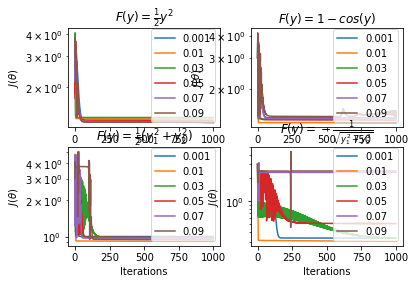

In [454]:
#CHANGING TAU
tol_its = 1000
ttau = np.array([0.001 ,0.01 , 0.03, 0.05, 0.07, 0.09])
tt = []
fig, axs = plt.subplots(2,2)
its = np.arange(tol_its + 1)
I = 300
K = 10
h = 0.1


for i in ttau:
    start = time.time()
    theta1, z1, p1, onez1, c1, m01, ac1, bc1, ay1, by1 = generate_input(F1, I, 1, 2, [-2, 2], K)
    theta2, z2, p2, onez2, c2, m02, ac2, bc2, ay2, by2  = generate_input(F2, I, 2, 4, [[-2, -2], [2, 2]], K)
    theta3, z3, p3, onez3, c3, m03, ac3, bc3, ay3, by3 = generate_input(F3, I, 1, 2, [-np.pi / 3, np.pi / 3], K)
    theta4, z4, p4, onez4, c4, m04, ac4, bc4, ay4, by4 = generate_input(F4, I, 2, 4, [[-2, -2], [2, 2]], K)
    tau = i
    a1, d1 = trainingAlg(theta1, z1, p1, onez1, c1, m01, std_gradient_descent, sig2, prime_sig2, eta2, prime_eta2, K, h,
                         tol_its)
    a2, d2 = trainingAlg(theta2, z2, p2, onez2, c2, m02, std_gradient_descent, sig2, prime_sig2, eta2, prime_eta2, K, h,
                         tol_its)
    a3, d3 = trainingAlg(theta3, z3, p3, onez3, c3, m03, std_gradient_descent, sig2, prime_sig2, eta2, prime_eta2, K, h,
                         tol_its)
    a4, d4 = trainingAlg(theta4, z4, p4, onez4, c4, m04, std_gradient_descent, sig2, prime_sig2, eta2, prime_eta2, K, h,
                         tol_its)
    stop = time.time()
    tt.append(stop - start)
    axs[0, 0].semilogy(its[:len(d1)], d1, label=i)

    axs[1, 0].semilogy(its[:len(d2)], d2, label=i)

    axs[0, 1].semilogy(its[:len(d3)], d3, label=i)

    axs[1, 1].semilogy(its[:len(d4)], d4, label=i)

print(tt)

axs[0, 0].set_title(r'$F(y) = \frac{1}{2}y^2$')
axs[1, 0].set_title(r'$F(y) = \frac{1}{2}(y_1^2 + y_2^2)$')
axs[0, 1].set_title(r'$F(y) = 1 - cos(y)$')
axs[1, 1].set_title(r'$F(y) = - \frac{1}{\sqrt{y_1^2 + y_2^2}}$')
axs[0, 0].legend()
axs[1, 0].legend()
axs[0, 1].legend()
axs[1, 1].legend()

for ax in axs.flat:
    ax.set(xlabel='Iterations', ylabel=r'$J(\theta)$')

#PLOT AT THE BOTTOM

# 3. Testing the function for adams descent vs standard gradient descent. 

In [455]:
K = 10
tau = 0.01
h = 0.1
tol_val = 0.03
I = 300
tol_its = 10000



theta1, z1, p1, onez1, c1, m01, ac1, bc1, ay1, by1 = generate_input(F1, I, 1, 2, [-2,2], K)
theta2, z2, p2, onez2, c2, m02, ac2, bc2, ay2, by2 = generate_input(F2, I, 2, 4, [[-2, -2], [2, 2]], K)
theta3, z3, p3, onez3, c3, m03, ac3, bc3, ay3, by3 = generate_input(F3, I, 1, 2,  [-np.pi / 3, np.pi / 3], K)
theta4, z4, p4, onez4, c4, m04, ac4, bc4, ay4, by4 = generate_input(F4, I, 2, 4, [[-2, -2], [2, 2]], K)

theta11 = theta1.copy()
z11 = z1.copy()
p11 = p1.copy()


theta21 = theta2.copy()
z21 = z2.copy()
p21 = p2.copy()


theta31 = theta3.copy()
z31 = z3.copy()
p31 = p3.copy()


theta41 = theta4.copy()
z41 = z4.copy()
p41 = p4.copy()


start1 = time.time()
e1, f1 = trainingAlg(theta1, z1, p1, onez1, c1, m01, std_gradient_descent, sig2, prime_sig2, eta2, prime_eta2, K, h, tol_its)
stop1 = time.time()
e2, f2 = trainingAlg(theta2, z2, p2, onez2, c2, m02, std_gradient_descent, sig2, prime_sig2, eta2, prime_eta2, K, h, tol_its)
e3, f3 = trainingAlg(theta3, z3, p3, onez3, c3, m03, std_gradient_descent, sig2, prime_sig2, eta2, prime_eta2, K, h, tol_its)
e4, f4 = trainingAlg(theta4, z4, p4, onez4, c4, m04, std_gradient_descent, sig2, prime_sig2, eta2, prime_eta2, K, h, tol_its)


start2 = time.time()
e11, f11 = trainingAlg(theta11, z11, p11, onez1, c1, m01, adams_descent, sig2, prime_sig2, eta2, prime_eta2, K, h, tol_its)
stop2 = time.time()
e21, f21 = trainingAlg(theta21, z21, p21, onez2, c2, m02, adams_descent, sig2, prime_sig2, eta2, prime_eta2, K, h, tol_its)
e31, f31 = trainingAlg(theta31, z31, p31, onez3, c3, m03, adams_descent, sig2, prime_sig2, eta2, prime_eta2, K, h, tol_its)
e41, f41 = trainingAlg(theta41, z41, p41, onez4, c4, m04, adams_descent, sig2, prime_sig2, eta2, prime_eta2, K, h, tol_its)



[[-1.62222926]
 [-0.8721681 ]
 [-0.40759956]
 [-1.07026452]
 [-0.29333734]
 [ 1.52400396]
 [-2.        ]
 [-1.71852076]
 [ 0.12131143]
 [ 1.5750073 ]
 [ 1.4905108 ]
 [ 1.76167373]
 [-1.62222449]
 [-0.6833988 ]
 [ 0.46184376]
 [-0.85745995]
 [ 0.10458435]
 [ 1.09783103]
 [ 0.30516965]
 [ 1.1210891 ]
 [-0.55195696]
 [ 1.55462712]
 [ 0.34743304]
 [ 0.72414314]
 [-0.01832566]
 [-1.46307615]
 [-0.99096012]
 [-1.10333945]
 [ 0.66554244]
 [-0.07211571]
 [ 0.35248753]
 [ 0.56978282]
 [ 1.54515388]
 [-1.63400808]
 [-0.59503003]
 [-1.85045758]
 [ 1.14671393]
 [-1.64345541]
 [-1.45256736]
 [-0.56112054]
 [ 1.00135579]
 [ 1.33069149]
 [ 0.29549145]
 [ 1.9807088 ]
 [-0.29869112]
 [ 0.32402035]
 [-1.85824016]
 [ 1.68996202]
 [-0.50083563]
 [-0.74140542]
 [ 1.91852848]
 [-1.88995265]
 [ 1.05814907]
 [ 1.66448257]
 [ 0.99025041]
 [ 0.13891629]
 [ 1.09105694]
 [-1.3321576 ]
 [-0.46395181]
 [ 0.07395197]
 [-0.2218417 ]
 [-1.90675682]
 [-1.7821284 ]
 [-1.42374112]
 [ 0.39318035]
 [ 0.16166351]
 [ 1.45609

1.2982657788121004
1.2982430869637436
1.2982204815887144
1.298197962339469
1.298175528869895
1.2981531808353075
1.2981309178924403
1.2981087396994413
1.2980866459158658
1.2980646362026702
1.2980427102222063
1.2980208676382146
1.2979991081158182
1.2979774313215182
1.2979558369231847
1.2979343245900543
1.2979128939927216
1.2978915448031338
1.2978702766945864
1.2978490893417145
1.2978279824204895
1.2978069556082115
1.2977860085835051
1.2977651410263122
1.2977443526178873
1.2977236430407908
1.2977030119788842
1.2976824591173244
1.2976619841425574
1.297641586742313
1.2976212666056
1.2976010234226993
1.2975808568851595
1.2975607666857905
1.2975407525186593
1.2975208140790835
1.2975009510636257
1.297481163170089
1.2974614500975117
1.2974418115461606
1.2974222472175272
1.297402756814322
1.2973833400404686
1.297363996601099
1.2973447262025488
1.297325528552351
1.2973064033592323
1.297287350333106
1.2972683691850684
1.2972494596273938
1.2972306213735283
1.2972118541380857
1.2971931576368423
1.29

1.2931671164369536
1.2931628137322648
1.2931585240657963
1.2931542473852606
1.2931499836385778
1.2931457327738738
1.2931414947394795
1.2931372694839303
1.2931330569559656
1.2931288571045272
1.2931246698787586
1.293120495228006
1.293116333101814
1.2931121834499282
1.2931080462222926
1.2931039213690492
1.2930998088405372
1.2930957085872927
1.2930916205600473
1.293087544709727
1.293083480987453
1.293079429344539
1.2930753897324918
1.2930713621030097
1.2930673464079827
1.2930633425994909
1.2930593506298032
1.293055370451379
1.2930514020168646
1.2930474452790937
1.2930435001910872
1.2930395667060512
1.2930356447773779
1.2930317343586433
1.2930278354036069
1.2930239478662113
1.2930200717005822
1.2930162068610254
1.2930123533020286
1.2930085109782592
1.2930046798445638
1.2930008598559684
1.292997050967676
1.2929932531350674
1.2929894663137003
1.2929856904593076
1.2929819255277974
1.2929781714752528
1.2929744282579307
1.2929706958322604
1.2929669741548444
1.2929632631824564
1.2929595628720412


1.2919805026433413
1.2919789412624372
1.2919773817516031
1.2919758241027635
1.2919742683078739
1.2919727143589221
1.2919711622479282
1.2919696119669422
1.2919680635080464
1.291966516863354
1.29196497202501
1.291963428985189
1.2919618877360972
1.2919603482699715
1.2919588105790796
1.2919572746557193
1.2919557404922184
1.2919542080809359
1.2919526774142596
1.2919511484846085
1.2919496212844308
1.2919480958062042
1.2919465720424368
1.2919450499856657
1.2919435296284572
1.2919420109634072
1.2919404939831405
1.2919389786803113
1.291937465047602
1.2919359530777248
1.2919344427634196
1.2919329340974555
1.2919314270726296
1.291929921681768
1.291928417917724
1.2919269157733797
1.2919254152416453
1.2919239163154586
1.2919224189877854
1.2919209232516184
1.291919429099979
1.2919179365259152
1.2919164455225025
1.291914956082844
1.2919134682000697
1.291911981867336
1.291910497077827
1.2919090138247535
1.2919075321013522
1.2919060519008876
1.2919045732166499
1.2919030960419553
1.2919016203701472
1.29

1.2913500691120336
1.2913488607692616
1.29134765253843
1.2913464444182157
1.2913452364073006
1.2913440285043707
1.2913428207081166
1.2913416130172337
1.2913404054304216
1.2913391979463842
1.2913379905638298
1.2913367832814722
1.2913355760980278
1.2913343690122192
1.291333162022772
1.2913319551284168
1.2913307483278882
1.2913295416199255
1.2913283350032723
1.2913271284766763
1.2913259220388889
1.2913247156886665
1.29132350942477
1.2913223032459635
1.2913210971510158
1.2913198911387003
1.2913186852077936
1.2913174793570774
1.291316273585337
1.2913150678913619
1.2913138622739453
1.2913126567318853
1.2913114512639834
1.2913102458690453
1.291309040545881
1.2913078352933038
1.291306630110132
1.2913054249951867
1.291304219947294
1.2913030149652835
1.2913018100479885
1.2913006051942462
1.2912994004028984
1.29129819567279
1.29129699100277
1.2912957863916914
1.2912945818384107
1.2912933773417887
1.291292172900689
1.2912909685139806
1.2912897641805345
1.2912885598992265
1.2912873556689362
1.29128

1.2907857048504654
1.2907844557157473
1.2907832063596385
1.2907819567817351
1.2907807069816328
1.2907794569589288
1.2907782067132207
1.2907769562441063
1.2907757055511841
1.2907744546340536
1.290773203492314
1.2907719521255658
1.2907707005334095
1.2907694487154466
1.2907681966712787
1.2907669444005085
1.2907656919027386
1.2907644391775723
1.2907631862246138
1.2907619330434679
1.2907606796337388
1.2907594259950321
1.2907581721269543
1.2907569180291119
1.2907556637011115
1.2907544091425607
1.290753154353068
1.2907518993322413
1.2907506440796899
1.2907493885950236
1.290748132877852
1.2907468769277861
1.2907456207444363
1.2907443643274146
1.2907431076763327
1.290741850790803
1.2907405936704386
1.2907393363148525
1.290738078723659
1.2907368208964725
1.2907355628329074
1.290734304532579
1.2907330459951032
1.290731787220096
1.2907305282071744
1.290729268955955
1.2907280094660556
1.2907267497370942
1.290725489768689
1.290724229560459
1.2907229691120237
1.2907217084230025
1.2907204474930158
1.2

1.2901623979477035
1.2901610040385059
1.290159609744196
1.2901582150644373
1.2901568199988922
1.2901554245472242
1.2901540287090958
1.29015263248417
1.290151235872109
1.2901498388725758
1.2901484414852324
1.2901470437097413
1.290145645545765
1.290144246992965
1.2901428480510033
1.2901414487195422
1.290140048998243
1.2901386488867674
1.2901372483847773
1.2901358474919338
1.2901344462078976
1.2901330445323307
1.2901316424648936
1.290130240005248
1.2901288371530535
1.2901274339079718
1.2901260302696629
1.2901246262377875
1.2901232218120058
1.290121816991978
1.2901204117773641
1.2901190061678245
1.2901176001630186
1.2901161937626062
1.2901147869662468
1.2901133797736002
1.2901119721843253
1.2901105641980817
1.2901091558145281
1.290107747033324
1.2901063378541275
1.290104928276598
1.2901035183003935
1.2901021079251729
1.2901006971505944
1.290099285976316
1.2900978744019962
1.2900964624272924
1.2900950500518624
1.2900936372753642
1.2900922240974553
1.290090810517793
1.2900893965360345
1.2900

1.2894570976928654
1.289455482236764
1.289453866216548
1.2894522496317775
1.2894506324820132
1.2894490147668147
1.2894473964857422
1.2894457776383546
1.289444158224211
1.2894425382428703
1.2894409176938908
1.2894392965768307
1.2894376748912475
1.2894360526366988
1.2894344298127416
1.2894328064189329
1.2894311824548292
1.2894295579199866
1.2894279328139606
1.2894263071363075
1.289424680886582
1.2894230540643388
1.2894214266691328
1.2894197987005183
1.289418170158049
1.2894165410412786
1.2894149113497604
1.2894132810830472
1.2894116502406916
1.2894100188222464
1.289408386827263
1.2894067542552932
1.2894051211058886
1.2894034873785998
1.2894018530729778
1.2894002181885729
1.2893985827249348
1.2893969466816135
1.2893953100581583
1.2893936728541182
1.289392035069042
1.289390396702478
1.2893887577539744
1.2893871182230787
1.2893854781093383
1.2893838374123003
1.2893821961315115
1.2893805542665182
1.2893789118168666
1.2893772687821021
1.2893756251617705
1.2893739809554168
1.2893723361625855
1

1.2886021737684152
1.2886002278865913
1.2885982811838066
1.288596333659418
1.2885943853127817
1.2885924361432537
1.2885904861501891
1.288588535332943
1.288586583690869
1.2885846312233211
1.288582677929652
1.2885807238092148
1.288578768861361
1.288576813085442
1.2885748564808088
1.288572899046812
1.2885709407828008
1.2885689816881245
1.288567021762132
1.2885650610041712
1.2885630994135895
1.288561136989734
1.2885591737319513
1.2885572096395872
1.2885552447119866
1.2885532789484946
1.288551312348455
1.2885493449112118
1.288547376636108
1.288545407522486
1.2885434375696876
1.2885414667770543
1.288539495143927
1.2885375226696456
1.28853554935355
1.2885335751949794
1.288531600193272
1.288529624347766
1.2885276476577987
1.288525670122707
1.288523691741827
1.2885217125144948
1.2885197324400448
1.2885177515178121
1.2885157697471308
1.2885137871273338
1.288511803657754
1.288509819337724
1.2885078341665754
1.2885058481436389
1.2885038612682456
1.288501873539725
1.2884998849574065
1.2884978955206

1.2875265924421289
1.2875241500735861
1.2875217064854734
1.2875192616767852
1.287516815646515
1.2875143683936552
1.2875119199171972
1.2875094702161312
1.2875070192894467
1.2875045671361323
1.2875021137551754
1.2874996591455627
1.2874972033062797
1.2874947462363107
1.2874922879346398
1.287489828400249
1.2874873676321203
1.2874849056292348
1.2874824423905713
1.287479977915109
1.2874775122018254
1.2874750452496972
1.2874725770577005
1.2874701076248096
1.2874676369499984
1.2874651650322397
1.2874626918705052
1.287460217463766
1.2874577418109912
1.2874552649111501
1.2874527867632104
1.2874503073661387
1.2874478267189011
1.2874453448204621
1.2874428616697855
1.287440377265834
1.2874378916075697
1.2874354046939531
1.287432916523944
1.2874304270965011
1.2874279364105823
1.2874254444651443
1.2874229512591426
1.287420456791532
1.2874179610612664
1.2874154640672983
1.2874129658085791
1.28741046628406
1.2874079654926902
1.2874054634334184
1.2874029601051922
1.2874004555069583
1.2873979496376617
1.

1.286183751578279
1.2861805820474177
1.28617741067274
1.2861742374526004
1.2861710623853524
1.286167885469347
1.2861647067029343
1.2861615260844614
1.286158343612275
1.286155159284719
1.2861519731001358
1.286148785056866
1.2861455951532488
1.2861424033876208
1.2861392097583173
1.286136014263672
1.2861328169020163
1.28612961767168
1.2861264165709916
1.2861232135982765
1.2861200087518596
1.2861168020300635
1.2861135934312087
1.2861103829536142
1.286107170595597
1.2861039563554728
1.2861007402315543
1.2860975222221538
1.2860943023255809
1.2860910805401433
1.2860878568641472
1.286084631295897
1.2860814038336947
1.2860781744758412
1.2860749432206353
1.2860717100663737
1.2860684750113514
1.2860652380538613
1.286061999192195
1.286058758424642
1.2860555157494897
1.2860522711650237
1.286049024669528
1.2860457762612842
1.286042525938573
1.286039273699672
1.286036019542858
1.2860327634664048
1.2860295054685855
1.286026245547671
1.2860229837019292
1.2860197199296275
1.2860164542290309
1.2860131865

1.2843166090829985
1.2843122596014442
1.2843079071628256
1.2843035517642076
1.284299193402652
1.284294832075216
1.2842904677789548
1.284286100510918
1.2842817302681535
1.2842773570477044
1.2842729808466102
1.2842686016619074
1.2842642194906282
1.2842598343298017
1.284255446176453
1.2842510550276032
1.2842466608802707
1.2842422637314694
1.28423786357821
1.2842334604174988
1.284229054246339
1.2842246450617305
1.2842202328606689
1.2842158176401457
1.2842113993971496
1.2842069781286651
1.284202553831673
1.2841981265031506
1.284193696140071
1.284189262739404
1.2841848262981157
1.2841803868131678
1.2841759442815188
1.2841714987001238
1.2841670500659332
1.284162598375894
1.2841581436269498
1.28415368581604
1.2841492249401003
1.2841447609960628
1.2841402939808555
1.2841358238914027
1.2841313507246248
1.2841268744774388
1.284122395146757
1.2841179127294893
1.28411342722254
1.284108938622811
1.2841044469271998
1.2840999521325995
1.2840954542359007
1.2840909532339888
1.2840864491237458
1.28408194

1.2818630052179956
1.2818568482183539
1.2818506863480517
1.2818445196016302
1.2818383479736235
1.2818321714585583
1.2818259900509534
1.2818198037453197
1.2818136125361608
1.2818074164179718
1.2818012153852416
1.2817950094324497
1.2817887985540692
1.2817825827445646
1.2817763619983928
1.2817701363100034
1.2817639056738375
1.281757670084329
1.2817514295359034
1.281745184022979
1.281738933539966
1.2817326780812663
1.2817264176412748
1.2817201522143777
1.2817138817949538
1.2817076063773738
1.2817013259560004
1.2816950405251886
1.281688750079285
1.281682454612629
1.2816761541195514
1.2816698485943754
1.2816635380314154
1.281657222424979
1.2816509017693645
1.2816445760588633
1.281638245287758
1.2816319094503232
1.2816255685408258
1.2816192225535243
1.2816128714826691
1.2816065153225025
1.2816001540672588
1.2815937877111636
1.2815874162484353
1.2815810396732832
1.281574657979909
1.2815682711625056
1.281561879215258
1.2815554821323436
1.2815490799079303
1.2815426725361787
1.2815362600112403
1.

1.2782185871670924
1.278209281659015
1.2781999674647666
1.2781906445730933
1.2781813129727229
1.2781719726523646
1.2781626236007098
1.2781532658064305
1.2781438992581815
1.278134523944598
1.2781251398542979
1.2781157469758793
1.2781063452979229
1.2780969348089897
1.2780875154976232
1.2780780873523474
1.2780686503616676
1.278059204514071
1.2780497497980252
1.2780402862019797
1.2780308137143648
1.2780213323235916
1.2780118420180526
1.2780023427861218
1.277992834616153
1.2779833174964823
1.2779737914154257
1.2779642563612805
1.2779547123223247
1.2779451592868174
1.277935597242998
1.277926026179087
1.2779164460832855
1.277906856943775
1.2778972587487178
1.2778876514862572
1.2778780351445163
1.2778684097115989
1.2778587751755897
1.2778491315245533
1.2778394787465348
1.2778298168295597
1.2778201457616338
1.2778104655307434
1.2778007761248547
1.277791077531914
1.277781369739848
1.2777716527365635
1.277761926509947
1.2777521910478655
1.277742446338166
1.277732692368675
1.277722929127199
1.2777

1.2724829891407468
1.272467768427151
1.2724525305987582
1.2724372756291635
1.2724220034919116
1.2724067141604947
1.2723914076083533
1.272376083808877
1.272360742735402
1.272345384361214
1.272330008659545
1.272314615603576
1.2722992051664346
1.2722837773211964
1.2722683320408839
1.2722528692984671
1.2722373890668626
1.2722218913189343
1.272206376027493
1.272190843165296
1.2721752927050467
1.2721597246193956
1.2721441388809391
1.2721285354622198
1.2721129143357264
1.2720972754738935
1.272081618849101
1.2720659444336757
1.2720502521998882
1.272034542119956
1.2720188141660405
1.272003068310249
1.2719873045246337
1.2719715227811919
1.2719557230518648
1.2719399053085387
1.2719240695230445
1.271908215667157
1.2718923437125955
1.2718764536310232
1.271860545394047
1.2718446189732178
1.2718286743400302
1.2718127114659221
1.271796730322275
1.2717807308804134
1.2717647131116046
1.2717486769870594
1.2717326224779313
1.2717165495553162
1.2717004581902525
1.2716843483537215
1.271668220016646
1.271652

1.2625528309214833
1.2625250125442242
1.2624971550429194
1.2624692583419663
1.2624413223655762
1.2624133470377714
1.262385332282387
1.2623572780230687
1.2623291841832727
1.262301050686265
1.2622728774551222
1.2622446644127276
1.2622164114817749
1.262188118584764
1.2621597856440023
1.262131412581604
1.2621029993194888
1.2620745457793814
1.2620460518828118
1.2620175175511141
1.2619889427054252
1.2619603272666855
1.2619316711556376
1.2619029742928254
1.2618742365985942
1.2618454579930898
1.2618166383962577
1.2617877777278426
1.2617588759073881
1.261729932854235
1.2617009484875226
1.261671922726186
1.261642855488957
1.2616137466943624
1.2615845962607242
1.2615554041061587
1.2615261701485756
1.2614968943056772
1.2614675764949588
1.2614382166337073
1.2614088146389997
1.2613793704277045
1.2613498839164794
1.2613203550217709
1.2612907836598146
1.2612611697466334
1.2612315131980374
1.2612018139296228
1.2611720718567725
1.2611422868946536
1.2611124589582177
1.261082587962201
1.2610526738211216
1

1.2420104764881632
1.2419485169862947
1.241886439582416
1.2418242439681983
1.241761929834303
1.24169949687038
1.2416369447650626
1.241574273205964
1.2415114818796738
1.2414485704717537
1.2413855386667334
1.2413223861481077
1.2412591125983317
1.2411957176988169
1.2411322011299277
1.2410685625709776
1.2410048017002242
1.2409409181948665
1.2408769117310403
1.2408127819838135
1.2407485286271835
1.2406841513340723
1.2406196497763227
1.2405550236246932
1.2404902725488556
1.2404253962173903
1.2403603942977812
1.2402952664564126
1.240230012358565
1.24016463166841
1.2400991240490078
1.2400334891623008
1.2399677266691111
1.239901836229136
1.2398358175009432
1.2397696701419658
1.2397033938085007
1.239636988155701
1.2395704528375742
1.2395037875069759
1.2394369918156076
1.2393700654140103
1.239303007951561
1.2392358190764685
1.2391684984357685
1.2391010456753189
1.2390334604397963
1.2389657423726912
1.2388978911163024
1.238829906311734
1.23876178759889
1.2386935346164702
1.2386251470019647
1.23855

1.1895655348839487
1.1893799870751547
1.1891939385894352
1.1890073877595362
1.1888203329123044
1.1886327723686687
1.1884447044436226
1.1882561274462033
1.1880670396794737
1.1878774394405038
1.1876873250203506
1.1874966947040386
1.1873055467705427
1.187113879492767
1.1869216911375262
1.1867289799655265
1.186535744231346
1.186341982183416
1.1861476920640006
1.1859528721091783
1.1857575205488224
1.1855616356065808
1.1853652154998569
1.1851682584397907
1.1849707626312387
1.184772726272754
1.1845741475565679
1.1843750246685685
1.1841753557882826
1.1839751390888549
1.1837743727370293
1.183573054893129
1.1833711837110352
1.1831687573381695
1.1829657739154726
1.1827622315773854
1.1825581284518278
1.1823534626601806
1.182148232317264
1.1819424355313188
1.1817360704039854
1.1815291350302843
1.1813216274985971
1.1811135458906445
1.180904888281468
1.180695652739408
1.1804858373260858
1.1802754400963822
1.1800644590984177
1.179852892373532
1.1796407379562648
1.179427993874334
1.179214658148617
1.17

0.9916653597042159
0.990900201785779
0.9901329665513823
0.9893636515853318
0.9885922545091561
0.987818772982036
0.9870432047012375
0.9862655474025426
0.9854857988606842
0.9847039568897827
0.983920019343781
0.9831339841168835
0.9823458491439941
0.9815556124011577
0.9807632719060004
0.9799688257181722
0.9791722719397905
0.9783736087158836
0.9775728342348374
0.9767699467288398
0.9759649444743287
0.9751578257924395
0.9743485890494532
0.9735372326572465
0.9727237550737402
0.9719081548033509
0.9710904303974419
0.9702705804547732
0.9694486036219561
0.9686244985939029
0.9677982641142815
0.9669698989759676
0.9661394020214983
0.9653067721435254
0.9644720082852694
0.963635109440973
0.9627960746563551
0.9619549030290643
0.961111593709133
0.9602661458994307
0.9594185588561176
0.9585688318890977
0.9577169643624718
0.9568629556949895
0.9560068053605022
0.9551485128884135
0.9542880778641316
0.9534254999295186
0.9525607787833409
0.9516939141817181
0.9508249059385708
0.9499537539260693
0.949080458075078

0.48321972465479235
0.48221653870093784
0.48121544848447323
0.4802164596493006
0.47921957776200813
0.4782248083119863
0.47723215671155084
0.47624162829606714
0.4752532283240826
0.47426696197746104
0.4732828343615216
0.47230085050518317
0.4713210153611117
0.4703433338058731
0.46936781064008903
0.46839445058859713
0.467423258300616
0.46645423834991295
0.46548739523497745
0.4645227333791957
0.46356025713103266
0.4625999707642141
0.4616418784779159
0.4606859843969541
0.4597322925719799
0.45878080697967927
0.4578315315229734
0.4568844700312257
0.4559396262604499
0.4549970038935219
0.4540566065403975
0.453118437738328
0.45218250095208545
0.4512487995741867
0.45031733692512127
0.4493881162535836
0.4484611407367082
0.44753641348030554
0.44661393751910394
0.445693715816992
0.4447757512672656
0.4438600466928759
0.4429466048466822
0.4420354284117046
0.44112652000138336
0.440219882159836
0.4393155173621213
0.43841342801450295
0.43751361645471715
0.43661608495224147
0.43572083570856796
0.4348278708

0.2330496996883674
0.23286138287709926
0.2326738046802353
0.2324869616220832
0.23230085023976915
0.23211546708323136
0.23193080871521385
0.23174687171125927
0.23156365265970363
0.23138114816166602
0.2311993548310425
0.23101826929449668
0.2308378881914509
0.2306582081740766
0.2304792259072852
0.2303009380687168
0.2301233413487303
0.22994643245039112
0.22977020808946202
0.2295946649943874
0.22941979990628505
0.22924560957892995
0.22907209077874344
0.22889924028477796
0.22872705488870465
0.2285555313947976
0.22838466661991988
0.2282144573935084
0.22804490055755822
0.22787599296660707
0.22770773148771867
0.2275401130004664
0.22737313439691614
0.22720679258161
0.22704108447154708
0.22687600699616706
0.22671155709733104
0.2265477317293029
0.226384527858731
0.22622194246462812
0.22605997253835275
0.22589861508358808
0.22573786711632296
0.22557772566483028
0.22541818776964728
0.22525925048355327
0.22510091087154907
0.22494316601083528
0.22478601299078907
0.22462944891294398
0.22447347089096523

0.18661281367158586
0.18656012322783805
0.18650750209656525
0.18645494999151382
0.18640246662800672
0.18635005172293592
0.1862977049947517
0.18624542616345457
0.18619321495058533
0.1861410710792174
0.1860889942739464
0.18603698426088214
0.18598504076763964
0.1859331635233299
0.18588135225855199
0.18582960670538368
0.18577792659737233
0.18572631166952785
0.18567476165831245
0.1856232763016334
0.18557185533883375
0.18552049851068403
0.18546920555937446
0.1854179762285059
0.18536681026308197
0.1853157074095009
0.1852646674155472
0.18521369003038335
0.1851627750045418
0.18511192208991725
0.18506113103975835
0.18501040160865986
0.1849597335525547
0.18490912662870584
0.18485858059569882
0.18480809521343405
0.18475767024311904
0.18470730544726008
0.18465700058965515
0.18460675543538685
0.18455656975081364
0.18450644330356353
0.18445637586252517
0.18440636719784215
0.1843564170809045
0.1843065252843411
0.1842566915820137
0.18420691574900794
0.18415719756162766
0.18410753679738717
0.18405793323

1.0178688356858392
1.017871048162793
1.0178732627766331
1.017875479519993
1.0178776983855182
1.0178799193658699
1.017882142453721
1.0178843676417595
1.0178865949226859
1.0178888242892148
1.0178910557340746
1.017893289250006
1.0178955248297652
1.0178977624661196
1.017900002151852
1.0179022438797574
1.0179044876426442
1.0179067334333354
1.017908981244666
1.017911231069485
1.0179134829006544
1.0179157367310498
1.01791799255356
1.0179202503610867
1.0179225101465454
1.0179247719028643
1.0179270356229853
1.0179293012998627
1.0179315689264647
1.0179338384957723
1.0179361100007795
1.0179383834344933
1.0179406587899344
1.0179429360601358
1.0179452152381436
1.0179474963170174
1.017949779289829
1.017952064149664
1.0179543508896203
1.017956639502809
1.017958929982354
1.0179612223213919
1.0179635165130723
1.0179658125505575
1.0179681104270228
1.0179704101356566
1.0179727116696589
1.0179750150222435
1.0179773201866367
1.0179796271560773
1.0179819359238167
1.017984246483119
1.0179865588272614
1.01798

1.0190542687129223
1.0190568688541308
1.0190594688396337
1.0190620686665732
1.0190646683320974
1.0190672678333614
1.0190698671675256
1.0190724663317574
1.01907506532323
1.0190776641391224
1.0190802627766207
1.0190828612329166
1.0190854595052083
1.0190880575906995
1.0190906554866006
1.0190932531901284
1.019095850698505
1.019098448008959
1.0191010451187257
1.0191036420250457
1.0191062387251657
1.0191088352163389
1.019111431495824
1.0191140275608868
1.0191166234087978
1.0191192190368348
1.0191218144422804
1.0191244096224243
1.0191270045745615
1.0191295992959932
1.0191321937840268
1.0191347880359753
1.019137382049158
1.0191399758208997
1.0191425693485316
1.0191451626293908
1.0191477556608202
1.019150348440168
1.0191529409647897
1.0191555332320454
1.0191581252393018
1.0191607169839312
1.0191633084633116
1.0191658996748272
1.019168490615868
1.0191710812838297
1.019173671676114
1.0191762617901279
1.019178851623285
1.0191814411730038
1.0191840304367095
1.0191866194118324
1.0191892080958087
1.0

1.0201954643864555
1.0201977760727188
1.0202000868070593
1.0202023965886098
1.0202047054165055
1.0202070132898846
1.020209320207888
1.0202116261696592
1.0202139311743454
1.0202162352210955
1.0202185383090616
1.020220840437399
1.020223141605265
1.02022544181182
1.0202277410562277
1.0202300393376535
1.0202323366552668
1.0202346330082388
1.0202369283957435
1.0202392228169583
1.020241516271063
1.0202438087572396
1.0202461002746737
1.020248390822553
1.0202506804000682
1.0202529690064126
1.0202552566407825
1.0202575433023764
1.0202598289903957
1.0202621137040448
1.0202643974425305
1.0202666802050622
1.020268961990852
1.0202712427991147
1.0202735226290685
1.020275801479933
1.020278079350931
1.0202803562412883
1.0202826321502332
1.0202849070769962
1.0202871810208105
1.0202894539809129
1.0202917259565414
1.0202939969469378
1.0202962669513458
1.0202985359690122
1.0203008039991859
1.0203030710411187
1.0203053370940653
1.0203076021572823
1.0203098662300296
1.0203121293115691
1.0203143914011654
1.0

1.0211524222442332
1.021154239392244
1.0211560554169705
1.0211578703184117
1.0211596840965675
1.0211614967514386
1.0211633082830265
1.0211651186913346
1.021166927976367
1.021168736138129
1.0211705431766267
1.0211723490918678
1.0211741538838608
1.0211759575526156
1.0211777600981427
1.0211795615204542
1.021181361819563
1.0211831609954833
1.0211849590482307
1.0211867559778207
1.0211885517842714
1.0211903464676009
1.0211921400278288
1.0211939324649757
1.0211957237790636
1.0211975139701155
1.0211993030381545
1.0212010909832063
1.0212028778052966
1.0212046635044525
1.0212064480807026
1.0212082315340756
1.0212100138646019
1.0212117950723132
1.0212135751572418
1.0212153541194209
1.0212171319588854
1.0212189086756709
1.0212206842698133
1.0212224587413512
1.021224232090323
1.0212260043167685
1.0212277754207284
1.0212295454022446
1.0212313142613598
1.0212330819981184
1.0212348486125649
1.0212366141047453
1.0212383784747068
1.0212401417224972
1.0212419038481657
1.0212436648517624
1.021245424733338

1.0218621844548617
1.021863506295308
1.0218648270957242
1.0218661468564216
1.0218674655777116
1.021868783259906
1.0218700999033175
1.0218714155082578
1.0218727300750403
1.0218740436039782
1.0218753560953846
1.0218766675495738
1.02187797796686
1.021879287347558
1.021880595691982
1.0218819030004478
1.0218832092732708
1.021884514510767
1.0218858187132527
1.0218871218810441
1.0218884240144588
1.0218897251138133
1.0218910251794255
1.0218923242116134
1.021893622210695
1.0218949191769886
1.0218962151108137
1.0218975100124892
1.0218988038823342
1.0219000967206693
1.021901388527814
1.021902679304089
1.0219039690498153
1.0219052577653136
1.0219065454509055
1.0219078321069128
1.0219091177336577
1.0219104023314618
1.0219116859006487
1.0219129684415407
1.0219142499544616
1.0219155304397345
1.0219168098976834
1.021918088328633
1.0219193657329073
1.0219206421108311
1.0219219174627299
1.0219231917889287
1.0219244650897534
1.0219257373655302
1.021927008616585
1.0219282788432444
1.021929548045836
1.0219

1.0223685621769742
1.022369439661786
1.0223703162726512
1.0223711920099499
1.0223720668740621
1.0223729408653672
1.0223738139842453
1.022374686231076
1.0223755576062394
1.0223764281101153
1.0223772977430832
1.0223781665055232
1.022379034397815
1.0223799014203383
1.022380767573473
1.022381632857599
1.0223824972730957
1.0223833608203436
1.0223842234997218
1.0223850853116103
1.022385946256389
1.0223868063344372
1.0223876655461352
1.0223885238918624
1.0223893813719986
1.0223902379869236
1.0223910937370169
1.0223919486226585
1.0223928026442277
1.0223936558021045
1.0223945080966685
1.0223953595282993
1.0223962100973765
1.0223970598042795
1.0223979086493886
1.022398756633083
1.022399603755742
1.0224004500177455
1.022401295419473
1.022402139961304
1.0224029836436181
1.0224038264667947
1.0224046684312134
1.0224055095372535
1.0224063497852947
1.0224071891757163
1.0224080277088976
1.0224088653852184
1.0224097022050576
1.022410538168795
1.0224113732768094
1.0224122075294806
1.0224130409271879
1.02

1.02268754199133
1.022688054757539
1.0226885668198333
1.0226890781785585
1.0226895888340588
1.0226900987866796
1.022690608036765
1.0226911165846597
1.022691624430708
1.0226921315752542
1.0226926380186425
1.022693143761217
1.022693648803321
1.0226941531452984
1.0226946567874933
1.0226951597302487
1.0226956619739083
1.0226961635188148
1.0226966643653117
1.022697164513742
1.0226976639644483
1.0226981627177734
1.0226986607740596
1.02269915813365
1.0226996547968865
1.0227001507641114
1.0227006460356665
1.022701140611894
1.0227016344931357
1.022702127679733
1.022702620172028
1.0227031119703618
1.0227036030750754
1.0227040934865104
1.0227045832050077
1.022705072230908
1.022705560564552
1.022706048206281
1.022706535156435
1.0227070214153544
1.022707506983379
1.02270799186085
1.0227084760481067
1.0227089595454888
1.0227094423533365
1.0227099244719888
1.0227104059017857
1.0227108866430663
1.02271136669617
1.0227118460614355
1.022712324739202
1.0227128027298082
1.022713280033593
1.022713756650894

1.0228523792738105
1.022852607501911
1.0228528351675306
1.022853062270949
1.0228532888124469
1.0228535147923041
1.0228537402108004
1.0228539650682154
1.0228541893648286
1.0228544131009194
1.022854636276767
1.0228548588926507
1.022855080948849
1.0228553024456408
1.0228555233833048
1.0228557437621195
1.0228559635823629
1.0228561828443135
1.022856401548249
1.0228566196944473
1.0228568372831865
1.022857054314744
1.0228572707893966
1.022857486707422
1.0228577020690974
1.0228579168746998
1.0228581311245057
1.0228583448187918
1.0228585579578346
1.0228587705419108
1.0228589825712964
1.022859194046267
1.0228594049670987
1.0228596153340679
1.0228598251474494
1.022860034407519
1.0228602431145517
1.0228604512688229
1.0228606588706077
1.0228608659201806
1.0228610724178167
1.02286127836379
1.0228614837583754
1.0228616886018467
1.0228618928944782
1.0228620966365438
1.0228622998283177
1.0228625024700728
1.022862704562083
1.0228629061046215
1.0228631070979617
1.0228633075423765
1.0228635074381387
1.022

1.0229022324365145
1.0229022304634043
1.0229022280405258
1.022902225168093
1.0229022218463202
1.0229022180754208
1.022902213855609
1.0229022091870978
1.0229022040701017
1.022902198504833
1.0229021924915054
1.0229021860303318
1.0229021791215251
1.0229021717652984
1.022902163961864
1.0229021557114348
1.022902147014223
1.0229021378704408
1.0229021282803001
1.0229021182440137
1.0229021077617928
1.0229020968338491
1.0229020854603947
1.0229020736416405
1.0229020613777982
1.022902048669079
1.0229020355156937
1.0229020219178533
1.0229020078757687
1.0229019933896508
1.0229019784597095
1.0229019630861558
1.0229019472692
1.0229019310090515
1.022901914305921
1.0229018971600181
1.0229018795715528
1.0229018615407341
1.0229018430677723
1.0229018241528762
1.0229018047962548
1.022901784998118
1.0229017647586738
1.0229017440781316
1.0229017229567
1.0229017013945871
1.022901679392002
1.0229016569491527
1.0229016340662473
1.0229016107434938
1.0229015869811
1.0229015627792737
1.022901538138223
1.0229015130

1.0228563016004122
1.022856111833607
1.0228559217030155
1.0228557312087967
1.0228555403511095
1.022855349130112
1.022855157545963
1.0228549655988208
1.022854773288844
1.0228545806161904
1.0228543875810185
1.0228541941834859
1.0228540004237505
1.0228538063019703
1.022853611818303
1.022853416972906
1.0228532217659367
1.022853026197553
1.0228528302679119
1.0228526339771702
1.0228524373254855
1.0228522403130145
1.022852042939914
1.0228518452063409
1.0228516471124518
1.0228514486584035
1.022851249844352
1.0228510506704545
1.0228508511368664
1.0228506512437443
1.022850450991244
1.0228502503795216
1.0228500494087331
1.022849848079034
1.02284964639058
1.022849444343527
1.0228492419380302
1.0228490391742449
1.0228488360523262
1.0228486325724295
1.0228484287347102
1.0228482245393224
1.0228480199864218
1.0228478150761628
1.0228476098086998
1.022847404184188
1.022847198202781
1.022846991864634
1.0228467851699006
1.0228465781187355
1.0228463707112923
1.0228461629477252
1.022845954828188
1.022845746

1.0227326447991574
1.0227323026355064
1.022731960171582
1.0227316174075045
1.022731274343392
1.0227309309793642
1.02273058731554
1.0227302433520384
1.0227298990889782
1.0227295545264785
1.0227292096646579
1.0227288645036352
1.0227285190435291
1.022728173284458
1.0227278272265405
1.0227274808698952
1.02272713421464
1.0227267872608938
1.0227264400087746
1.0227260924584005
1.0227257446098896
1.02272539646336
1.0227250480189296
1.0227246992767163
1.0227243502368382
1.0227240008994127
1.0227236512645577
1.0227233013323906
1.0227229511030294
1.0227226005765913
1.0227222497531938
1.022721898632954
1.0227215472159896
1.0227211955024176
1.0227208434923551
1.0227204911859196
1.0227201385832276
1.0227197856843966
1.0227194324895428
1.0227190789987837
1.0227187252122358
1.0227183711300156
1.02271801675224
1.0227176620790257
1.022717307110489
1.022716951846746
1.0227165962879137
1.022716240434108
1.0227158842854451
1.0227155278420414
1.0227151711040128
1.0227148140714755
1.0227144567445454
1.022714

1.0225439500999811
1.0225434806661637
1.0225430109810703
1.0225425410447953
1.0225420708574335
1.02254160041908
1.0225411297298286
1.0225406587897745
1.022540187599012
1.0225397161576355
1.02253924446574
1.022538772523419
1.0225383003307675
1.02253782788788
1.0225373551948505
1.022536882251773
1.0225364090587423
1.0225359356158525
1.0225354619231974
1.0225349879808714
1.0225345137889688
1.0225340393475828
1.0225335646568086
1.022533089716739
1.022532614527469
1.0225321390890916
1.0225316634017012
1.0225311874653917
1.0225307112802564
1.0225302348463896
1.0225297581638846
1.0225292812328355
1.0225288040533353
1.0225283266254783
1.0225278489493579
1.0225273710250673
1.0225268928527005
1.0225264144323505
1.0225259357641108
1.022525456848075
1.0225249776843366
1.0225244982729886
1.0225240186141245
1.0225235387078373
1.0225230585542202
1.022522578153367
1.02252209750537
1.0225216166103228
1.0225211354683186
1.02252065407945
1.0225201724438104
1.0225196905614926
1.0225192084325894
1.02251872

1.022306972668992
1.0223063986206762
1.0223058243609853
1.0223052498900027
1.0223046752078113
1.0223041003144946
1.0223035252101356
1.0223029498948177
1.0223023743686237
1.0223017986316372
1.022301222683941
1.022300646525618
1.0223000701567517
1.0222994935774248
1.0222989167877208
1.0222983397877226
1.022297762577513
1.0222971851571752
1.0222966075267923
1.0222960296864472
1.0222954516362228
1.0222948733762023
1.0222942949064686
1.0222937162271044
1.022293137338193
1.022292558239817
1.0222919789320593
1.0222913994150031
1.022290819688731
1.022290239753326
1.0222896596088709
1.0222890792554484
1.0222884986931418
1.0222879179220334
1.0222873369422063
1.0222867557537432
1.0222861743567269
1.0222855927512398
1.0222850109373653
1.0222844289151856
1.022283846684784
1.0222832642462425
1.0222826815996442
1.022282098745072
1.0222815156826082
1.0222809324123354
1.0222803489343364
1.0222797652486941
1.022279181355491
1.0222785972548094
1.0222780129467322
1.0222774284313418
1.0222768437087209
1.02

1.0220212549256802
1.0220205921013712
1.022019929103175
1.0220192659311726
1.0220186025854443
1.0220179390660704
1.022017275373132
1.0220166115067093
1.0220159474668828
1.0220152832537337
1.0220146188673416
1.0220139543077877
1.0220132895751528
1.022012624669517
1.022011959590961
1.0220112943395652
1.0220106289154105
1.0220099633185775
1.0220092975491466
1.0220086316071983
1.0220079654928134
1.0220072992060725
1.0220066327470556
1.0220059661158443
1.0220052993125184
1.0220046323371588
1.0220039651898463
1.0220032978706608
1.0220026303796836
1.022001962716995
1.0220012948826758
1.0220006268768063
1.021999958699467
1.0219992903507389
1.0219986218307024
1.021997953139438
1.0219972842770266
1.021996615243549
1.0219959460390848
1.0219952766637157
1.0219946071175219
1.021993937400584
1.0219932675129821
1.0219925974547979
1.0219919272261113
1.0219912568270029
1.0219905862575538
1.021989915517844
1.0219892446079546
1.021988573527966
1.0219879022779588
1.021987230858014
1.0219865592682118
1.021

1.021710298890077
1.0217095666835099
1.021708834339208
1.021708101857253
1.0217073692377274
1.0217066364807135
1.0217059035862932
1.0217051705545492
1.0217044373855633
1.0217037040794177
1.021702970636195
1.0217022370559772
1.0217015033388468
1.0217007694848856
1.021700035494176
1.0216993013668005
1.0216985671028413
1.0216978327023805
1.0216970981655005
1.0216963634922835
1.0216956286828118
1.0216948937371677
1.0216941586554336
1.0216934234376915
1.0216926880840238
1.0216919525945132
1.0216912169692416
1.0216904812082912
1.0216897453117448
1.0216890092796844
1.0216882731121923
1.021687536809351
1.0216868003712425
1.0216860637979497
1.0216853270895545
1.0216845902461393
1.0216838532677865
1.021683116154579
1.021682378906598
1.0216816415239272
1.0216809040066477
1.021680166354843
1.0216794285685944
1.021678690647985
1.0216779525930975
1.0216772144040134
1.0216764760808157
1.0216757376235868
1.0216749990324088
1.021674260307364
1.0216735214485355
1.021672782456005
1.0216720433298556
1.021

1.0213783447830935
1.02137756027063
1.0213767756566796
1.0213759909413254
1.0213752061246506
1.0213744212067386
1.0213736361876726
1.0213728510675357
1.0213720658464116
1.021371280524383
1.0213704951015334
1.0213697095779461
1.0213689239537043
1.0213681382288908
1.0213673524035896
1.0213665664778835
1.0213657804518557
1.0213649943255896
1.021364208099168
1.021363421772675
1.0213626353461929
1.0213618488198055
1.021361062193596
1.0213602754676472
1.0213594886420425
1.0213587017168655
1.021357914692199
1.0213571275681261
1.0213563403447306
1.021355553022095
1.021354765600303
1.0213539780794376
1.021353190459582
1.0213524027408196
1.0213516149232333
1.0213508270069067
1.0213500389919223
1.0213492508783641
1.021348462666315
1.021347674355858
1.0213468859470762
1.0213460974400532
1.0213453088348718
1.0213445201316156
1.0213437313303673
1.0213429424312102
1.0213421534342277
1.021341364339503
1.021340575147119
1.0213397858571587
1.0213389964697057
1.021338206984843
1.0213374174026537
1.021336

1.021013023550644
1.0210122014574157
1.0210113792999442
1.0210105570783095
1.0210097347925908
1.0210089124428685
1.021008090029222
1.0210072675517312
1.0210064450104759
1.0210056224055355
1.02100479973699
1.0210039770049189
1.021003154209402
1.0210023313505188
1.021001508428349
1.0210006854429723
1.020999862394468
1.0209990392829162
1.020998216108396
1.0209973928709872
1.0209965695707692
1.0209957462078219
1.0209949227822244
1.0209940992940563
1.020993275743397
1.0209924521303264
1.0209916284549234
1.0209908047172678
1.0209899809174388
1.0209891570555159
1.0209883331315786
1.020987509145706
1.0209866850979776
1.020985860988473
1.020985036817271
1.0209842125844515
1.0209833882900934
1.020982563934276
1.0209817395170788
1.0209809150385807
1.0209800904988613
1.0209792658979995
1.0209784412360747
1.020977616513166
1.0209767917293529
1.0209759668847138
1.0209751419793285
1.020974317013276
1.0209734919866353
1.0209726668994854
1.0209718417519056
1.0209710165439747
1.0209701912757718
1.020969

1.020643667223781
1.0206428242193961
1.0206419811842036
1.0206411381182727
1.0206402950216744
1.0206394518944784
1.0206386087367543
1.0206377655485723
1.0206369223300025
1.0206360790811142
1.0206352358019781
1.0206343924926635
1.0206335491532403
1.0206327057837783
1.0206318623843469
1.020631018955016
1.0206301754958556
1.020629332006935
1.020628488488324
1.020627644940092
1.0206268013623088
1.0206259577550436
1.0206251141183662
1.020624270452346
1.0206234267570522
1.0206225830325544
1.020621739278922
1.0206208954962246
1.020620051684531
1.020619207843911
1.020618363974433
1.0206175200761674
1.0206166761491826
1.020615832193548
1.0206149882093327
1.020614144196606
1.0206133001554367
1.020612456085894
1.0206116119880468
1.0206107678619645
1.0206099237077155
1.020609079525369
1.020608235314994
1.0206073910766589
1.020606546810433
1.020605702516385
1.020604858194584
1.020604013845098
1.0206031694679962
1.0206023250633474
1.02060148063122
1.0206006361716826
1.0205997916848042
1.020598947170

1.0202503024072167
1.020249452099145
1.0202486017892005
1.0202477514774368
1.020246901163908
1.0202460508486675
1.0202452005317688
1.0202443502132663
1.0202434998932128
1.0202426495716623
1.0202417992486679
1.0202409489242839
1.0202400985985627
1.0202392482715583
1.0202383979433238
1.0202375476139125
1.0202366972833778
1.0202358469517734
1.0202349966191515
1.020234146285566
1.0202332959510696
1.0202324456157157
1.020231595279557
1.0202307449426467
1.0202298946050377
1.0202290442667827
1.0202281939279352
1.0202273435885474
1.0202264932486722
1.0202256429083625
1.0202247925676708
1.0202239422266501
1.0202230918853528
1.0202222415438313
1.0202213912021385
1.0202205408603267
1.0202196905184486
1.0202188401765564
1.0202179898347024
1.0202171394929394
1.0202162891513191
1.020215438809894
1.0202145884687166
1.0202137381278387
1.0202128877873127
1.0202120374471906
1.0202111871075243
1.020210336768366
1.0202094864297677
1.0202086360917813
1.020207785754459
1.020206935417852
1.0202060850820125
1

1.0198724489179904
1.019871602489508
1.0198707560789901
1.0198699096864723
1.019869063311989
1.0198682169555755
1.0198673706172672
1.0198665242970983
1.0198656779951043
1.01986483171132
1.0198639854457798
1.019863139198519
1.0198622929695718
1.0198614467589735
1.0198606005667583
1.019859754392961
1.0198589082376162
1.019858062100758
1.0198572159824215
1.0198563698826406
1.0198555238014502
1.0198546777388844
1.0198538316949772
1.0198529856697633
1.0198521396632765
1.0198512936755515
1.0198504477066224
1.0198496017565228
1.0198487558252871
1.0198479099129492
1.019847064019543
1.019846218145103
1.019845372289662
1.019844526453255
1.0198436806359148
1.0198428348376758
1.0198419890585715
1.0198411432986354
1.0198402975579015
1.0198394518364031
1.0198386061341738
1.0198377604512472
1.0198369147876567
1.0198360691434356
1.0198352235186174
1.0198343779132353
1.0198335323273229
1.0198326867609129
1.019831841214039
1.019830995686734
1.0198301501790312
1.019829304690964
1.0198284592225648
1.01982

1.0195013498252028
1.0195005141293647
1.019499678462932
1.0194988428259213
1.0194980072183502
1.019497171640235
1.0194963360915936
1.019495500572442
1.0194946650827976
1.0194938296226772
1.0194929941920974
1.019492158791075
1.0194913234196268
1.0194904880777695
1.01948965276552
1.0194888174828944
1.0194879822299097
1.019487147006582
1.0194863118129283
1.0194854766489647
1.0194846415147079
1.0194838064101739
1.0194829713353797
1.019482136290341
1.0194813012750743
1.0194804662895958
1.0194796313339216
1.0194787964080683
1.0194779615120515
1.0194771266458875
1.0194762918095923
1.0194754570031823
1.0194746222266728
1.01947378748008
1.0194729527634203
1.0194721180767088
1.0194712834199617
1.0194704487931947
1.0194696141964237
1.0194687796296642
1.019467945092932
1.0194671105862427
1.019466276109612
1.0194654416630555
1.0194646072465883
1.0194637728602263
1.0194629385039848
1.0194621041778793
1.0194612698819252
1.0194604356161376
1.0194596013805322
1.0194587671751238
1.0194579329999278
1.019

1.0191276323737393
1.019126811127512
1.0191259899148346
1.0191251687357086
1.0191243475901361
1.0191235264781195
1.0191227053996603
1.0191218843547605
1.0191210633434222
1.0191202423656471
1.019119421421437
1.019118600510794
1.0191177796337194
1.0191169587902154
1.0191161379802836
1.0191153172039256
1.0191144964611432
1.0191136757519381
1.0191128550763116
1.0191120344342657
1.0191112138258016
1.0191103932509211
1.0191095727096258
1.0191087522019169
1.0191079317277958
1.0191071112872643
1.0191062908803235
1.0191054705069749
1.0191046501672198
1.0191038298610595
1.0191030095884954
1.0191021893495287
1.0191013691441604
1.019100548972392
1.019099728834225
1.0190989087296598
1.019098088658698
1.0190972686213406
1.0190964486175886
1.0190956286474433
1.0190948087109053
1.019093988807976
1.0190931689386562
1.0190923491029467
1.0190915293008487
1.019090709532363
1.01908988979749
1.0190890700962312
1.0190882504285872
1.0190874307945585
1.0190866111941463
1.019085791627351
1.0190849720941733
1.01

1.358142184008384
1.358139701874028
1.3581372274770263
1.3581347607794299
1.358132301743466
1.3581298503315387
1.3581274065062257
1.3581249702302802
1.358122541466628
1.3581201201783675
1.3581177063287697
1.3581152998812756
1.3581129007994968
1.3581105090472143
1.3581081245883775
1.3581057473871037
1.358103377407677
1.358101014614548
1.3580986589723325
1.358096310445811
1.3580939689999276
1.3580916345997904
1.3580893072106688
1.3580869867979941
1.3580846733273586
1.3580823667645145
1.3580800670753737
1.3580777742260057
1.358075488182639
1.358073208911658
1.3580709363796044
1.3580686705531753
1.358066411399222
1.3580641588847508
1.358061912976921
1.3580596736430444
1.358057440850585
1.3580552145671585
1.3580529947605304
1.3580507813986167
1.3580485744494817
1.358046373881339
1.35804417966255
1.3580419917616222
1.3580398101472102
1.3580376347881142
1.3580354656532794
1.358033302711795
1.3580311459328942
1.358028995285953
1.3580268507404896
1.3580247122661644
1.3580225798327776
1.35802045

1.3573867130694663
1.3573855971030784
1.3573844814730098
1.3573833661753338
1.3573822512061409
1.3573811365615378
1.3573800222376486
1.3573789082306136
1.3573777945365895
1.35737668115175
1.3573755680722845
1.357374455294399
1.3573733428143155
1.3573722306282725
1.3573711187325244
1.357370007123341
1.357368895797009
1.3573677847498304
1.3573666739781227
1.3573655634782196
1.3573644532464697
1.357363343279238
1.3573622335729043
1.357361124123864
1.3573600149285276
1.3573589059833213
1.3573577972846855
1.3573566888290771
1.3573555806129667
1.3573544726328404
1.3573533648851992
1.3573522573665586
1.3573511500734494
1.3573500430024164
1.357348936150019
1.3573478295128318
1.3573467230874432
1.3573456168704563
1.357344510858488
1.35734340504817
1.3573422994361481
1.357341194019082
1.3573400887936455
1.3573389837565262
1.3573378789044257
1.3573367742340596
1.357335669742157
1.3573345654254612
1.3573334612807282
1.3573323573047287
1.3573312534942457
1.3573301498460766
1.3573290463570318
1.3573

1.3568069699546466
1.3568057371494082
1.3568045037898062
1.3568032698750463
1.3568020354043362
1.356800800376884
1.3567995647919
1.3567983286485943
1.3567970919461787
1.3567958546838659
1.35679461686087
1.356793378476406
1.3567921395296896
1.3567909000199376
1.3567896599463687
1.3567884193082014
1.3567871781046557
1.356785936334953
1.3567846939983155
1.3567834510939658
1.3567822076211282
1.3567809635790278
1.3567797189668902
1.3567784737839428
1.3567772280294135
1.356775981702531
1.3567747348025252
1.3567734873286268
1.3567722392800674
1.3567709906560799
1.3567697414558975
1.3567684916787546
1.3567672413238867
1.3567659903905303
1.3567647388779218
1.3567634867852998
1.3567622341119028
1.356760980856971
1.3567597270197442
1.3567584725994646
1.356757217595374
1.3567559620067158
1.3567547058327338
1.356753449072673
1.3567521917257785
1.3567509337912975
1.3567496752684767
1.3567484161565642
1.3567471564548086
1.3567458961624599
1.3567446352787687
1.3567433738029855
1.3567421117343625
1.356

1.3561476428147645
1.356146066356065
1.3561444890009042
1.3561429107485068
1.356141331598097
1.3561397515488984
1.356138170600134
1.3561365887510264
1.356135006000797
1.3561334223486672
1.3561318377938578
1.3561302523355887
1.3561286659730794
1.3561270787055486
1.3561254905322144
1.356123901452295
1.3561223114650067
1.3561207205695665
1.3561191287651897
1.356117536051092
1.3561159424264875
1.3561143478905904
1.356112752442614
1.356111156081771
1.3561095588072736
1.356107960618333
1.3561063615141606
1.3561047614939663
1.3561031605569596
1.3561015587023497
1.356099955929345
1.3560983522371528
1.3560967476249806
1.3560951420920349
1.3560935356375214
1.3560919282606452
1.356090319960611
1.3560887107366226
1.3560871005878832
1.3560854895135956
1.3560838775129618
1.356082264585183
1.3560806507294598
1.3560790359449926
1.3560774202309804
1.356075803586622
1.3560741860111156
1.3560725675036587
1.3560709480634479
1.3560693276896794
1.3560677063815483
1.35606608413825
1.356064460958978
1.3560628

1.3552784010432348
1.355276295101421
1.3552741877988226
1.355272079134207
1.3552699691063406
1.355267857713988
1.3552657449559131
1.355263630830878
1.3552615153376437
1.3552593984749692
1.355257280241613
1.3552551606363317
1.3552530396578804
1.3552509173050133
1.3552487935764832
1.355246668471041
1.3552445419874366
1.3552424141244184
1.3552402848807337
1.355238154255128
1.3552360222463455
1.3552338888531295
1.3552317540742214
1.3552296179083612
1.3552274803542874
1.3552253414107378
1.355223201076448
1.355221059350153
1.3552189162305854
1.3552167717164771
1.3552146258065585
1.3552124784995585
1.3552103297942046
1.3552081796892228
1.355206028183338
1.3552038752752733
1.3552017209637506
1.35519956524749
1.355197408125211
1.3551952495956308
1.3551930896574655
1.3551909283094303
1.3551887655502382
1.3551866013786007
1.3551844357932286
1.3551822687928308
1.355180100376115
1.355177930541787
1.3551757592885514
1.3551735866151118
1.3551714125201697
1.3551692370024255
1.3551670600605779
1.355164

1.354090980266356
1.3540880540551323
1.3540851256974598
1.3540821951911746
1.35407926253411
1.354076327724097
1.354073390758963
1.3540704516365338
1.3540675103546316
1.3540645669110758
1.354061621303684
1.35405867353027
1.3540557235886455
1.354052771476619
1.3540498171919968
1.354046860732582
1.354043902096175
1.3540409412805734
1.3540379782835723
1.3540350131029635
1.3540320457365365
1.3540290761820781
1.3540261044373716
1.3540231305001982
1.3540201543683361
1.3540171760395605
1.3540141955116438
1.354011212782356
1.3540082278494638
1.3540052407107315
1.3540022513639198
1.3539992598067878
1.3539962660370908
1.3539932700525814
1.3539902718510095
1.3539872714301222
1.3539842687876638
1.3539812639213753
1.3539782568289955
1.3539752475082598
1.353972235956901
1.353969222172649
1.3539662061532307
1.35396318789637
1.3539601673997885
1.353957144661204
1.3539541196783322
1.3539510924488856
1.3539480629705736
1.353945031241103
1.3539419972581777
1.3539389610194983
1.3539359225227627
1.353932881

1.3523888028361348
1.3523845333242461
1.3523802602149637
1.3523759835041607
1.3523717031877047
1.3523674192614572
1.3523631317212736
1.3523588405630038
1.3523545457824908
1.3523502473755726
1.3523459453380808
1.352341639665841
1.3523373303546726
1.3523330174003894
1.3523287007987985
1.3523243805457021
1.352320056636895
1.3523157290681669
1.3523113978353007
1.3523070629340739
1.3523027243602577
1.3522983821096166
1.3522940361779099
1.3522896865608902
1.352285333254304
1.3522809762538914
1.3522766155553874
1.3522722511545198
1.35226788304701
1.3522635112285746
1.3522591356949223
1.3522547564417566
1.3522503734647748
1.3522459867596677
1.3522415963221195
1.3522372021478088
1.3522328042324077
1.3522284025715814
1.3522239971609902
1.3522195879962864
1.3522151750731175
1.3522107583871235
1.3522063379339389
1.3522019137091914
1.3521974857085024
1.352193053927487
1.3521886183617537
1.3521841790069054
1.3521797358585372
1.3521752889122394
1.3521708381635944
1.352166383608179
1.3521619252415633


1.3497416923045777
1.3497349933004759
1.3497282876666232
1.3497215753941345
1.34971485647411
1.3497081308976342
1.349701398655777
1.3496946597395942
1.349687914140125
1.349681161848394
1.3496744028554113
1.3496676371521712
1.3496608647296526
1.34965408557882
1.3496472996906221
1.3496405070559925
1.349633707665849
1.3496269015110949
1.3496200885826173
1.3496132688712885
1.3496064423679652
1.349599609063488
1.3495927689486835
1.349585922014361
1.3495790682513151
1.349572207650325
1.349565340202154
1.3495584658975497
1.3495515847272441
1.3495446966819533
1.3495378017523778
1.3495308999292024
1.3495239912030959
1.349517075564711
1.3495101530046854
1.3495032235136397
1.3494962870821796
1.3494893437008941
1.3494823933603564
1.3494754360511239
1.3494684717637373
1.349461500488722
1.349454522216587
1.3494475369378243
1.3494405446429107
1.3494335453223063
1.3494265389664553
1.3494195255657848
1.3494125051107064
1.3494054775916147
1.3493984429988881
1.349391401322889
1.3493843525539626
1.3493772

1.3453100050477924
1.3452984442462739
1.3452868695866615
1.3452752810465451
1.3452636786034688
1.3452520622349313
1.3452404319183855
1.3452287876312385
1.3452171293508517
1.34520545705454
1.345193770719573
1.345182070323173
1.3451703558425165
1.3451586272547342
1.3451468845369088
1.3451351276660772
1.3451233566192295
1.3451115713733086
1.3450997719052105
1.3450879581917838
1.34507613020983
1.3450642879361034
1.3450524313473105
1.3450405604201103
1.345028675131114
1.345016775456885
1.3450048613739387
1.3449929328587424
1.3449809898877154
1.3449690324372283
1.3449570604836034
1.3449450740031144
1.3449330729719864
1.3449210573663957
1.3449090271624695
1.3448969823362864
1.344884922863875
1.3448728487212156
1.3448607598842381
1.3448486563288236
1.3448365380308034
1.3448244049659586
1.344812257110021
1.344800094438672
1.3447879169275427
1.3447757245522145
1.3447635172882177
1.3447512951110328
1.3447390579960887
1.3447268059187645
1.3447145388543877
1.3447022567782352
1.3446899596655326
1.34

1.3376719897997067
1.3376501032820494
1.3376281840343998
1.3376062319909272
1.3375842470856352
1.3375622292523608
1.3375401784247742
1.3375180945363776
1.3374959775205055
1.3374738273103237
1.3374516438388293
1.3374294270388485
1.3374071768430391
1.3373848931838874
1.3373625759937084
1.3373402252046458
1.337317840748671
1.3372954225575824
1.3372729705630058
1.3372504846963926
1.33722796488902
1.3372054110719906
1.3371828231762317
1.3371602011324943
1.337137544871353
1.3371148543232059
1.3370921294182727
1.3370693700865959
1.337046576258039
1.3370237478622862
1.3370008848288422
1.3369779870870313
1.3369550545659967
1.336932087194701
1.336909084901924
1.3368860476162636
1.336862975266134
1.3368398677797666
1.336816725085208
1.3367935471103203
1.3367703337827799
1.3367470850300776
1.3367238007795175
1.336700480958217
1.3366771254931058
1.336653734310925
1.3366303073382273
1.3366068445013757
1.336583345726543
1.3365598109397125
1.3365362400666752
1.3365126330330308
1.3364889897641867
1.336

1.3215406105851015
1.3214904686269413
1.3214402270758223
1.32138988566684
1.321339444134213
1.321288902211279
1.3212382596304926
1.3211875161234206
1.3211366714207389
1.3210857252522294
1.3210346773467763
1.320983527432362
1.3209322752360648
1.3208809204840537
1.3208294629015862
1.3207779022130046
1.3207262381417313
1.3206744704102669
1.3206225987401843
1.3205706228521275
1.3205185424658061
1.3204663572999928
1.320414067072519
1.320361671500271
1.3203091702991874
1.3202565631842536
1.3202038498694995
1.3201510300679948
1.3200981034918462
1.3200450698521928
1.3199919288592017
1.3199386802220658
1.3198853236489987
1.3198318588472313
1.3197782855230076
1.3197246033815808
1.31967081212721
1.3196169114631553
1.3195629010916745
1.319508780714019
1.3194545500304293
1.3194002087401318
1.3193457565413345
1.3192911931312221
1.3192365182059533
1.3191817314606555
1.3191268325894219
1.3190718212853056
1.3190166972403177
1.3189614601454211
1.3189061096905277
1.3188506455644933
1.3187950674551139
1.3

1.2783391505624258
1.2781827801422518
1.2780259647544185
1.2778687027814792
1.2777109925991847
1.2775528325764514
1.2773942210753326
1.2772351564509865
1.2770756370516443
1.2769156612185804
1.2767552272860805
1.2765943335814094
1.27643297842478
1.2762711601293217
1.2761088770010476
1.275946127338823
1.2757829094343331
1.2756192215720503
1.2754550620292016
1.2752904290757368
1.2751253209742943
1.2749597359801694
1.2747936723412796
1.2746271282981334
1.2744601020837947
1.2742925919238504
1.274124596036377
1.2739561126319054
1.273787139913388
1.2736176760761637
1.2734477193079243
1.2732772677886792
1.2731063196907213
1.2729348731785914
1.2727629264090443
1.2725904775310133
1.272417524685574
1.2722440660059096
1.2720700996172756
1.271895623636963
1.2717206361742635
1.2715451353304323
1.2713691191986527
1.2711925858639987
1.2710155334034
1.2708379598856028
1.2706598633711352
1.2704812419122689
1.270302093552982
1.2701224163289222
1.2699422082673677
1.2697614673871918
1.2695801916988223
1.26

1.0952529114036416
1.0944588151266568
1.0936617967289288
1.0928618465940745
1.0920589551132922
1.0912531126861418
1.0904443097213374
1.0896325366375528
1.0888177838642368
1.0880000418424436
1.0871793010256738
1.0863555518807277
1.0855287848885722
1.0846989905452185
1.0838661593626142
1.0830302818695468
1.0821913486125612
1.0813493501568883
1.0805042770873892
1.0796561200095072
1.0788048695502415
1.0779505163591239
1.0770930511092174
1.0762324644981216
1.0753687472489957
1.0745018901115924
1.0736318838633065
1.072758719310237
1.0718823872882604
1.0710028786641212
1.0701201843365342
1.0692342952372984
1.068345202332429
1.067452896623299
1.0665573691477979
1.0656586109815003
1.0647566132388533
1.0638513670743723
1.0629428636838552
1.0620310943056077
1.0611160502216839
1.0601977227591395
1.0592761032913003
1.0583511832390435
1.0574229540720939
1.0564914073103322
1.0555565345251203
1.0546183273406355
1.0536767774352254
1.052731876542769
1.0517836164540575
1.0508319890181868
1.04987698614396

0.45032974565835904
0.4491598504190105
0.44799395066582526
0.446832047370448
0.4456741413013106
0.4445202330253266
0.44337032290959777
0.4422244111231301
0.44108249763855983
0.43994458223388855
0.43881066449422745
0.4376807438135518
0.43655481939646057
0.4354328902599447
0.4343149552351654
0.4332010129692356
0.4320910619270092
0.43098510039287796
0.42988312647257126
0.4287851380949635
0.42769113301388517
0.42660110880993846
0.425515062892317
0.42443299250063043
0.4233548947067301
0.4222807664165397
0.42121060437188745
0.42014440515234125
0.41908216517704433
0.4180238807065541
0.41696954784468104
0.41591916254032857
0.4148727205893337
0.41383021763630723
0.4127916491764744
0.4117570105575149
0.4107262969814008
0.40969950350623513
0.4086766250480876
0.4076576563828292
0.4066425921479638
0.4056314268444587
0.4046241548385708
0.40362077036367106
0.40262126752206506
0.4016256402868094
0.40063388250352555
0.3996459878922088
0.39866195004903193
0.39768176244814546
0.3967054184434721
0.3957329

0.20770862811291238
0.20755295791695375
0.20739790572355601
0.20724346842395924
0.20708964292397145
0.20693642614391067
0.20678381501854498
0.20663180649703475
0.20648039754287495
0.2063295851338365
0.20617936626190972
0.20602973793324528
0.20588069716809865
0.20573224100077198
0.20558436647955827
0.20543707066668423
0.20529035063825396
0.2051442034841936
0.20499862630819463
0.2048536162276583
0.20470917037364142
0.20456528589079964
0.20442195993733273
0.2042791896849308
0.20413697231871855
0.2039953050372013
0.2038541850522114
0.20371360958885334
0.20357357588545053
0.20343408119349116
0.2032951227775758
0.2031566979153634
0.20301880389751864
0.20288143802765882
0.20274459762230151
0.20260828001081244
0.20247248253535266
0.2023372025508266
0.20220243742483068
0.20206818453760142
0.20193444128196322
0.2018012050632787
0.2016684732993956
0.20153624342059756
0.20140451286955172
0.20127327910125978
0.20114253958300654
0.20101229179430957
0.20088253322686989
0.2007532613845209
0.2006244737

0.16946839059763197
0.16942370433197987
0.169379076555587
0.16933450702630926
0.16928999550333956
0.1692455417472005
0.16920114551973536
0.16915680658410273
0.1691125247047665
0.16906829964749057
0.16902413117932982
0.168980019068623
0.16893596308498646
0.1688919629993052
0.16884801858372672
0.16880412961165328
0.1687602958577349
0.16871651709786162
0.16867279310915764
0.1686291236699729
0.1685855085598764
0.16854194755964977
0.16849844045127943
0.16845498701795053
0.16841158704403925
0.1683682403151061
0.16832494661789005
0.16828170574030016
0.16823851747141
0.168195381601451
0.16815229792180467
0.16810926622499697
0.16806628630469161
0.16802335795568307
0.16798048097389062
0.16793765515635134
0.16789488030121366
0.1678521562077314
0.16780948267625737
0.1677668595082364
0.16772428650619964
0.16768176347375796
0.16763929021559623
0.16759686653746636
0.16755449224618177
0.1675121671496108
0.16746989105667098
0.16742766377732285
0.1673854851225638
0.1673433549044223
0.16730127293595182
0

0.15291349318302666
0.15288252373310748
0.1528515707116215
0.15282063409151134
0.1527897138458202
0.15275880994768917
0.15272792237035834
0.1526970510871661
0.15266619607154774
0.15263535729703592
0.15260453473725943
0.15257372836594313
0.15254293815690745
0.15251216408406756
0.1524814061214327
0.1524506642431064
0.15241993842328586
0.1523892286362606
0.15235853485641265
0.15232785705821641
0.15229719521623702
0.15226654930513137
0.15223591929964608
0.15220530517461825
0.15217470690497414
0.15214412446572936
0.1521135578319881
0.15208300697894245
0.1520524718818721
0.15202195251614423
0.15199144885721258
0.15196096088061722
0.15193048856198355
0.15190003187702303
0.15186959080153195
0.15183916531139036
0.1518087553825635
0.1517783609910989
0.1517479821131283
0.1517176187248656
0.1516872708026073
0.15165693832273153
0.15162662126169765
0.1515963195960464
0.15156603330239934
0.15153576235745742
0.15150550673800195
0.1514752664208931
0.15144504138307047
0.1514148316015519
0.15138463705343

0.14026561981353772
0.1402402660897374
0.14021492199374602
0.14018958751682212
0.14016426265023899
0.14013894738528287
0.14011364171325533
0.1400883456254713
0.1400630591132601
0.14003778216796492
0.140012514780943
0.13998725694356506
0.13996200864721633
0.1399367698832958
0.1399115406432155
0.13988632091840233
0.1398611107002958
0.13983590998035003
0.13981071875003206
0.13978553700082302
0.1397603647242173
0.13973520191172287
0.13971004855486127
0.13968490464516725
0.13965977017418935
0.1396346451334889
0.13960952951464112
0.1395844233092342
0.13955932650886965
0.13953423910516194
0.13950916108973932
0.13948409245424237
0.13945903319032546
0.13943398328965537
0.13940894274391277
0.13938391154479016
0.13935888968399401
0.1393338771532433
0.13930887394426952
0.13928388004881778
0.1392588954586453
0.1392339201655222
0.13920895416123164
0.13918399743756932
0.13915904998634332
0.13913411179937457
0.1391091828684968
0.139084263185556
0.13905935274241052
0.13903445153093144
0.139009559543002

0.1291965318382705
0.12917495156883638
0.12915337790023573
0.12913181082780112
0.12911025034687146
0.12908869645279042
0.1290671491409071
0.12904560840657686
0.12902407424515933
0.1290025466520205
0.12898102562253125
0.12895951115206794
0.12893800323601254
0.1289165018697521
0.12889500704867932
0.12887351876819228
0.12885203702369424
0.12883056181059369
0.12880909312430505
0.1287876309602474
0.12876617531384565
0.12874472618052965
0.12872328355573504
0.1287018474349024
0.12868041781347786
0.1286589946869125
0.1286375780506629
0.12861616790019134
0.12859476423096458
0.128573367038455
0.12855197631814086
0.12853059206550443
0.12850921427603437
0.12848784294522395
0.128466478068572
0.1284451196415822
0.1284237676597638
0.12840242211863123
0.12838108301370396
0.12835975034050684
0.1283384240945697
0.12831710427142767
0.12829579086662096
0.12827448387569548
0.1282531832942014
0.128231889117695
0.12821060134173673
0.1281893199618931
0.12816804497373518
0.1281467763728394
0.12812551415478718


0.11974864415943724
0.11972972317534118
0.11971080710063814
0.11969189593258912
0.11967298966845812
0.11965408830551198
0.11963519184102134
0.11961630027225917
0.11959741359650192
0.11957853181102868
0.1195596549131221
0.11954078290006775
0.11952191576915411
0.11950305351767265
0.11948419614291823
0.11946534364218862
0.11944649601278423
0.11942765325200927
0.11940881535717028
0.11938998232557724
0.11937115415454289
0.11935233084138323
0.11933351238341725
0.11931469877796676
0.11929589002235687
0.11927708611391552
0.11925828704997364
0.11923949282786529
0.11922070344492743
0.11920191889849985
0.11918313918592593
0.11916436430455132
0.11914559425172505
0.11912682902479929
0.11910806862112863
0.11908931303807115
0.11907056227298772
0.11905181632324237
0.11903307518620139
0.11901433885923515
0.11899560733971609
0.11897688062501993
0.1189581587125254
0.11893944159961424
0.11892072928367066
0.11890202176208231
0.11888331903223973
0.1188646210915362
0.11884592793736813
0.11882723956713465
0.1

0.11123737118257063
0.11122052979152125
0.11120369229860659
0.11118685870222694
0.1111700290007836
0.11115320319267996
0.11113638127632172
0.11111956325011556
0.11110274911247063
0.11108593886179736
0.11106913249650831
0.11105233001501726
0.11103553141574121
0.11101873669709708
0.11100194585750478
0.11098515889538542
0.11096837580916254
0.11095159659726057
0.11093482125810625
0.11091804979012854
0.11090128219175702
0.11088451846142364
0.11086775859756268
0.11085100259860922
0.11083425046300024
0.11081750218917545
0.11080075777557502
0.11078401722064188
0.11076728052281981
0.11075054768055526
0.11073381869229564
0.11071709355649063
0.11070037227159166
0.11068365483605112
0.1106669412483243
0.11065023150686747
0.11063352561013858
0.11061682355659798
0.11060012534470695
0.1105834309729289
0.11056674043972926
0.1105500537435746
0.11053337088293348
0.11051669185627618
0.11050001666207471
0.11048334529880274
0.1104666777649359
0.11045001405895094
0.11043335417932705
0.11041669812454447
0.110

0.6080056366320041
0.6080110165387567
0.6080163957867236
0.6080217743694522
0.6080271522805047
0.6080325295134595
0.6080379060619093
0.6080432819194626
0.6080486570797426
0.6080540315363885
0.6080594052830538
0.6080647783134078
0.6080701506211347
0.6080755221999334
0.6080808930435184
0.6080862631456191
0.6080916324999798
0.6080970011003599
0.6081023689405335
0.6081077360142901
0.6081131023154337
0.6081184678377834
0.6081238325751732
0.6081291965214519
0.6081345596704829
0.6081399220161446
0.6081452835523306
0.6081506442729481
0.6081560041719201
0.6081613632431838
0.6081667214806913
0.6081720788784091
0.6081774354303183
0.6081827911304154
0.60818814597271
0.6081934999512275
0.6081988530600074
0.6082042052931036
0.6082095566445845
0.6082149071085333
0.6082202566790472
0.608225605350238
0.6082309531162317
0.608236299971169
0.6082416459092045
0.6082469909245077
0.6082523350112619
0.6082576781636647
0.608263020375928
0.6082683616422784
0.6082737019569556
0.6082790413142146
0.608284379708323

0.6103679717137592
0.6103725542204534
0.610377134355732
0.610381712118069
0.6103862875059445
0.6103908605178453
0.6103954311522655
0.6103999994077048
0.6104045652826705
0.610409128775676
0.6104136898852413
0.6104182486098928
0.6104228049481641
0.6104273588985948
0.610431910459731
0.6104364596301258
0.6104410064083384
0.6104455507929346
0.6104500927824866
0.6104546323755735
0.6104591695707803
0.6104637043666988
0.610468236761927
0.6104727667550696
0.6104772943447374
0.6104818195295479
0.6104863423081249
0.6104908626790984
0.6104953806411049
0.6104998961927873
0.6105044093327947
0.6105089200597826
0.610513428372413
0.6105179342693536
0.6105224377492791
0.61052693881087
0.6105314374528132
0.6105359336738022
0.610540427472536
0.6105449188477203
0.6105494077980672
0.6105538943222947
0.6105583784191267
0.6105628600872938
0.6105673393255328
0.610571816132586
0.6105762905072026
0.6105807624481373
0.6105852319541515
0.6105896990240122
0.6105941636564928
0.6105986258503725
0.6106030856044369
0.6

0.6121873108005285
0.6121907457074779
0.6121941780647081
0.6121976078726463
0.6122010351317222
0.6122044598423675
0.6122078820050165
0.6122113016201064
0.6122147186880763
0.6122181332093679
0.6122215451844253
0.612224954613695
0.6122283614976257
0.612231765836669
0.6122351676312786
0.6122385668819104
0.6122419635890228
0.6122453577530769
0.6122487493745357
0.6122521384538647
0.6122555249915318
0.6122589089880073
0.6122622904437637
0.6122656693592761
0.6122690457350215
0.6122724195714796
0.6122757908691322
0.6122791596284636
0.61228252584996
0.6122858895341106
0.6122892506814062
0.6122926092923402
0.6122959653674083
0.6122993189071082
0.6123026699119404
0.6123060183824071
0.6123093643190131
0.6123127077222653
0.612316048592673
0.6123193869307473
0.6123227227370023
0.6123260560119534
0.6123293867561193
0.6123327149700197
0.6123360406541775
0.6123393638091174
0.6123426844353661
0.612346002533453
0.612349318103909
0.612352631147268
0.6123559416640654
0.612359249654839
0.6123625551201289
0.

0.6134945959292952
0.6134969457205213
0.6134992933274059
0.6135016387509876
0.6135039819923047
0.6135063230523967
0.613508661932303
0.6135109986330641
0.6135133331557205
0.6135156655013138
0.6135179956708849
0.6135203236654768
0.6135226494861318
0.6135249731338931
0.6135272946098043
0.6135296139149096
0.6135319310502535
0.6135342460168812
0.6135365588158382
0.6135388694481706
0.6135411779149247
0.6135434842171477
0.6135457883558867
0.6135480903321897
0.6135503901471051
0.6135526878016818
0.6135549832969687
0.6135572766340158
0.6135595678138729
0.613561856837591
0.6135641437062208
0.6135664284208138
0.6135687109824219
0.6135709913920975
0.6135732696508933
0.6135755457598625
0.6135778197200589
0.613580091532536
0.613582361198349
0.613584628718552
0.613586894094201
0.6135891573263512
0.613591418416059
0.6135936773643809
0.6135959341723737
0.6135981888410948
0.6136004413716021
0.6136026917649535
0.6136049400222078
0.6136071861444237
0.6136094301326604
0.6136116719879782
0.6136139117114366


0.6143607248343034
0.6143621852435824
0.6143636439646698
0.6143651009986313
0.6143665563465328
0.6143680100094396
0.6143694619884175
0.6143709122845309
0.6143723608988451
0.6143738078324242
0.6143752530863329
0.6143766966616347
0.6143781385593937
0.6143795787806731
0.6143810173265362
0.614382454198046
0.6143838893962653
0.6143853229222563
0.614386754777081
0.6143881849618017
0.6143896134774797
0.6143910403251763
0.6143924655059527
0.6143938890208697
0.6143953108709878
0.6143967310573673
0.6143981495810679
0.6143995664431495
0.6144009816446716
0.6144023951866933
0.6144038070702733
0.6144052172964705
0.614406625866343
0.6144080327809489
0.614409438041346
0.6144108416485915
0.614412243603743
0.6144136439078572
0.6144150425619906
0.6144164395671999
0.6144178349245408
0.6144192286350694
0.6144206206998408
0.6144220111199105
0.6144233998963332
0.6144247870301637
0.6144261725224562
0.6144275563742649
0.6144289385866433
0.614430319160645
0.6144316980973233
0.6144330753977308
0.6144344510629203

0.6148661102650981
0.6148669087028077
0.6148677059000627
0.6148685018577535
0.6148692965767704
0.6148700900580031
0.6148708823023409
0.6148716733106725
0.6148724630838862
0.61487325162287
0.6148740389285111
0.6148748250016967
0.614875609843313
0.6148763934542463
0.6148771758353819
0.614877956987605
0.6148787369118002
0.6148795156088517
0.6148802930796431
0.6148810693250577
0.6148818443459781
0.6148826181432872
0.614883390717866
0.6148841620705964
0.614884932202359
0.6148857011140346
0.6148864688065029
0.6148872352806434
0.6148880005373354
0.6148887645774573
0.6148895274018872
0.6148902890115029
0.6148910494071813
0.6148918085897994
0.6148925665602333
0.614893323319359
0.6148940788680516
0.6148948332071861
0.6148955863376366
0.6148963382602775
0.6148970889759817
0.6148978384856227
0.6148985867900728
0.6148993338902041
0.6149000797868881
0.614900824480996
0.6149015679733986
0.6149023102649658
0.6149030513565675
0.6149037912490728
0.6149045299433508
0.6149052674402695
0.614906003740697
0.

0.6151162428064394
0.6151165562229122
0.6151168687598251
0.6151171804178538
0.6151174911976737
0.6151178010999596
0.6151181101253859
0.6151184182746265
0.6151187255483552
0.6151190319472448
0.6151193374719679
0.6151196421231968
0.615119945901603
0.6151202488078581
0.6151205508426327
0.6151208520065972
0.6151211523004215
0.6151214517247751
0.615121750280327
0.6151220479677459
0.6151223447876999
0.6151226407408565
0.6151229358278832
0.6151232300494467
0.6151235234062133
0.6151238158988489
0.615124107528019
0.6151243982943887
0.6151246881986223
0.6151249772413842
0.6151252654233379
0.6151255527451468
0.6151258392074734
0.6151261248109803
0.6151264095563292
0.6151266934441818
0.6151269764751988
0.6151272586500409
0.6151275399693683
0.6151278204338405
0.6151281000441169
0.6151283788008561
0.6151286567047166
0.6151289337563561
0.6151292099564323
0.615129485305602
0.6151297598045218
0.6151300334538478
0.6151303062542358
0.615130578206341
0.6151308493108181
0.6151311195683214
0.615131388979505

0.6151777010969536
0.6151776755362457
0.6151776493610566
0.6151776225718738
0.6151775951691847
0.6151775671534766
0.6151775385252359
0.615177509284949
0.6151774794331016
0.6151774489701797
0.6151774178966679
0.6151773862130514
0.6151773539198147
0.6151773210174416
0.6151772875064159
0.615177253387221
0.61517721866034
0.6151771833262554
0.6151771473854495
0.6151771108384042
0.615177073685601
0.6151770359275212
0.6151769975646454
0.6151769585974541
0.6151769190264275
0.6151768788520453
0.6151768380747868
0.615176796695131
0.6151767547135566
0.6151767121305417
0.6151766689465643
0.6151766251621021
0.6151765807776322
0.6151765357936312
0.6151764902105757
0.615176444028942
0.6151763972492057
0.6151763498718421
0.6151763018973264
0.6151762533261331
0.6151762041587365
0.6151761543956107
0.6151761040372292
0.6151760530840651
0.6151760015365915
0.6151759493952808
0.615175896660605
0.6151758433330361
0.6151757894130456
0.6151757349011043
0.6151756797976831
0.6151756241032522
0.6151755678182819
0

0.6151111482622076
0.6151108906908995
0.615110632690198
0.6151103742604458
0.6151101154019857
0.6151098561151603
0.6151095964003115
0.6151093362577814
0.6151090756879113
0.6151088146910428
0.6151085532675168
0.615108291417674
0.615108029141855
0.6151077664404
0.6151075033136486
0.6151072397619409
0.615106975785616
0.6151067113850132
0.6151064465604709
0.6151061813123281
0.6151059156409229
0.6151056495465931
0.6151053830296767
0.6151051160905108
0.6151048487294329
0.6151045809467798
0.6151043127428879
0.6151040441180938
0.6151037750727335
0.6151035056071427
0.6151032357216568
0.6151029654166114
0.615102694692341
0.6151024235491808
0.6151021519874648
0.6151018800075274
0.6151016076097021
0.615101334794323
0.6151010615617232
0.6151007879122358
0.6151005138461934
0.6151002393639285
0.6150999644657736
0.6150996891520607
0.615099413423121
0.6150991372792864
0.6150988607208879
0.6150985837482564
0.6150983063617225
0.6150980285616163
0.6150977503482683
0.615097471722008
0.6150971926831651
0.61

0.6149536458823651
0.6149532237251517
0.6149528012689953
0.6149523785141296
0.6149519554607877
0.6149515321092027
0.6149511084596077
0.6149506845122348
0.6149502602673169
0.6149498357250863
0.6149494108857748
0.6149489857496144
0.6149485603168366
0.6149481345876732
0.614947708562355
0.6149472822411135
0.6149468556241792
0.6149464287117827
0.6149460015041547
0.6149455740015254
0.6149451462041247
0.6149447181121824
0.6149442897259284
0.6149438610455921
0.6149434320714026
0.6149430028035888
0.6149425732423799
0.6149421433880043
0.6149417132406905
0.6149412828006668
0.6149408520681611
0.6149404210434014
0.6149399897266152
0.6149395581180302
0.6149391262178734
0.6149386940263718
0.6149382615437525
0.614937828770242
0.6149373957060668
0.6149369623514531
0.614936528706627
0.6149360947718143
0.6149356605472408
0.614935226033132
0.6149347912297128
0.6149343561372088
0.6149339207558444
0.6149334850858446
0.6149330491274336
0.6149326128808361
0.6149321763462757
0.6149317395239766
0.61493130241416

0.6147393519707859
0.6147388171115309
0.6147382820391745
0.6147377467538735
0.6147372112557837
0.6147366755450617
0.6147361396218631
0.6147356034863437
0.6147350671386593
0.6147345305789653
0.6147339938074172
0.6147334568241699
0.6147329196293788
0.6147323822231987
0.6147318446057843
0.6147313067772904
0.6147307687378711
0.6147302304876813
0.6147296920268748
0.6147291533556057
0.614728614474028
0.6147280753822956
0.6147275360805617
0.6147269965689803
0.6147264568477043
0.6147259169168872
0.6147253767766817
0.6147248364272411
0.6147242958687177
0.6147237551012645
0.614723214125034
0.6147226729401781
0.6147221315468494
0.6147215899451999
0.6147210481353812
0.6147205061175453
0.6147199638918438
0.6147194214584281
0.6147188788174495
0.6147183359690592
0.6147177929134084
0.6147172496506479
0.6147167061809283
0.6147161625044005
0.6147156186212149
0.6147150745315216
0.6147145302354712
0.6147139857332133
0.6147134410248981
0.6147128961106753
0.6147123509906945
0.6147118056651052
0.614711260134

0.6144767963671914
0.6144761787565242
0.614475560990296
0.6144749430686072
0.6144743249915576
0.6144737067592476
0.6144730883717767
0.6144724698292449
0.6144718511317517
0.6144712322793968
0.6144706132722796
0.6144699941104995
0.6144693747941558
0.6144687553233475
0.6144681356981737
0.6144675159187335
0.6144668959851257
0.6144662758974488
0.6144656556558019
0.6144650352602831
0.6144644147109909
0.6144637940080239
0.6144631731514801
0.6144625521414576
0.6144619309780547
0.614461309661369
0.6144606881914987
0.614460066568541
0.6144594447925941
0.614458822863755
0.6144582007821214
0.6144575785477906
0.6144569561608597
0.614456333621426
0.6144557109295864
0.6144550880854377
0.614454465089077
0.6144538419406006
0.6144532186401054
0.6144525951876879
0.6144519715834443
0.6144513478274711
0.6144507239198645
0.6144500998607205
0.6144494756501352
0.6144488512882043
0.6144482267750239
0.6144476021106894
0.6144469772952966
0.614446352328941
0.6144457272117179
0.6144451019437225
0.6144444765250502


0.6141831458826497
0.6141824667109129
0.6141817874194346
0.6141811080082754
0.6141804284774954
0.614179748827155
0.6141790690573147
0.6141783891680342
0.6141777091593741
0.614177029031394
0.6141763487841542
0.6141756684177143
0.6141749879321342
0.6141743073274737
0.6141736266037924
0.6141729457611499
0.6141722647996056
0.6141715837192191
0.6141709025200497
0.6141702212021567
0.6141695397655993
0.6141688582104367
0.6141681765367278
0.6141674947445317
0.6141668128339074
0.6141661308049138
0.6141654486576094
0.6141647663920532
0.6141640840083037
0.6141634015064195
0.614162718886459
0.614162036148481
0.6141613532925432
0.6141606703187044
0.6141599872270225
0.6141593040175559
0.6141586206903624
0.6141579372455002
0.6141572536830272
0.614156570003001
0.6141558862054795
0.6141552022905206
0.6141545182581815
0.6141538341085202
0.614153149841594
0.6141524654574603
0.6141517809561764
0.6141510963377996
0.6141504116023873
0.6141497267499961
0.6141490417806837
0.6141483566945067
0.614147671491522


0.6138596619475709
0.6138589330816212
0.6138582041167295
0.6138574750529278
0.6138567458902474
0.6138560166287202
0.6138552872683778
0.6138545578092515
0.6138538282513725
0.6138530985947728
0.6138523688394832
0.6138516389855352
0.6138509090329602
0.6138501789817891
0.6138494488320532
0.6138487185837834
0.6138479882370109
0.6138472577917666
0.6138465272480814
0.6138457966059863
0.613845065865512
0.6138443350266891
0.6138436040895486
0.6138428730541211
0.613842141920437
0.6138414106885269
0.6138406793584216
0.6138399479301513
0.6138392164037464
0.6138384847792373
0.6138377530566542
0.6138370212360276
0.6138362893173874
0.6138355573007639
0.613834825186187
0.6138340929736871
0.6138333606632939
0.6138326282550373
0.6138318957489473
0.6138311631450536
0.6138304304433861
0.6138296976439747
0.6138289647468487
0.6138282317520379
0.6138274986595719
0.6138267654694802
0.6138260321817923
0.6138252987965376
0.6138245653137454
0.613823831733445
0.6138230980556659
0.613822364280437
0.613821630407787

0.6135197582622038
0.6135189870694104
0.6135182157871597
0.613517444415463
0.6135166729543311
0.6135159014037754
0.613515129763807
0.6135143580344369
0.6135135862156759
0.613512814307535
0.6135120423100253
0.6135112702231578
0.6135104980469428
0.6135097257813916
0.6135089534265147
0.613508180982323
0.6135074084488271
0.6135066358260375
0.6135058631139652
0.6135050903126203
0.6135043174220137
0.6135035444421558
0.6135027713730569
0.6135019982147276
0.6135012249671782
0.613500451630419
0.6134996782044605
0.6134989046893127
0.613498131084986
0.6134973573914905
0.6134965836088364
0.6134958097370339
0.6134950357760929
0.6134942617260235
0.6134934875868359
0.6134927133585395
0.613491939041145
0.6134911646346617
0.6134903901390997
0.6134896155544687
0.6134888408807786
0.613488066118039
0.6134872912662597
0.6134865163254503
0.6134857412956204
0.6134849661767796
0.6134841909689376
0.6134834156721037
0.6134826402862875
0.6134818648114984
0.6134810892477457
0.6134803135950389
0.6134795378533873
0

0.613155678675842
0.6131548669338911
0.6131540551039198
0.6131532431859237
0.6131524311798985
0.61315161908584
0.613150806903744
0.6131499946336058
0.6131491822754213
0.6131483698291859
0.6131475572948952
0.613146744672545
0.6131459319621306
0.6131451191636474
0.6131443062770909
0.6131434933024568
0.6131426802397401
0.6131418670889364
0.6131410538500409
0.6131402405230489
0.6131394271079558
0.6131386136047567
0.6131378000134471
0.6131369863340218
0.6131361725664763
0.6131353587108055
0.6131345447670047
0.6131337307350687
0.6131329166149928
0.613132102406772
0.6131312881104012
0.6131304737258754
0.6131296592531894
0.6131288446923383
0.613128030043317
0.6131272153061201
0.6131264004807427
0.6131255855671794
0.613124770565425
0.6131239554754744
0.613123140297322
0.6131223250309628
0.6131215096763912
0.6131206942336018
0.6131198787025895
0.6131190630833486
0.6131182473758737
0.6131174315801594
0.6131166156961999
0.6131157997239901
0.6131149836635241
0.6131141675147963
0.6131133512778011
0.

0.6127720130435083
0.6127711598345995
0.6127703065328988
0.6127694531383903
0.6127685996510577
0.6127677460708852
0.6127668923978569
0.6127660386319563
0.6127651847731677
0.6127643308214747
0.6127634767768613
0.6127626226393112
0.6127617684088085
0.6127609140853366
0.6127600596688795
0.612759205159421
0.6127583505569446
0.6127574958614341
0.6127566410728732
0.6127557861912456
0.6127549312165349
0.6127540761487247
0.6127532209877984
0.6127523657337398
0.6127515103865324
0.6127506549461597
0.6127497994126052
0.6127489437858523
0.6127480880658847
0.6127472322526855
0.6127463763462383
0.6127455203465265
0.6127446642535334
0.6127438080672423
0.6127429517876366
0.6127420954146996
0.6127412389484146
0.6127403823887647
0.6127395257357334
0.6127386689893037
0.6127378121494588
0.612736955216182
0.6127360981894563
0.612735241069265
0.6127343838555909
0.6127335265484174
0.6127326691477274
0.6127318116535039
0.6127309540657301
0.6127300963843887
0.6127292386094628
0.6127283807409355
0.6127275227787

0.6123739318783048
0.6123730344674888
0.6123721369544604
0.612371239339194
0.6123703416216648
0.6123694438018477
0.6123685458797173
0.6123676478552487
0.6123667497284166
0.6123658514991958
0.6123649531675611
0.6123640547334872
0.6123631561969489
0.612362257557921
0.6123613588163781
0.6123604599722948
0.6123595610256461
0.6123586619764064
0.6123577628245505
0.6123568635700529
0.6123559642128882
0.612355064753031
0.6123541651904559
0.6123532655251375
0.6123523657570502
0.6123514658861687
0.6123505659124674
0.6123496658359207
0.6123487656565032
0.6123478653741894
0.6123469649889535
0.61234606450077
0.6123451639096132
0.6123442632154579
0.612343362418278
0.612342461518048
0.6123415605147423
0.612340659408335
0.6123397581988007
0.6123388568861136
0.6123379554702475
0.6123370539511772
0.6123361523288766
0.6123352506033201
0.6123343487744817
0.6123334468423356
0.6123325448068561
0.6123316426680173
0.612330740425793
0.6123298380801578
0.6123289356310855
0.6123280330785501
0.6123271304225256
0.

0.6119565247248485
0.6119555781831937
0.6119546315262646
0.6119536847540289
0.6119527378664542
0.6119517908635085
0.611950843745159
0.6119498965113734
0.6119489491621196
0.611948001697365
0.6119470541170773
0.6119461064212237
0.6119451586097723
0.6119442106826904
0.6119432626399456
0.6119423144815053
0.611941366207337
0.6119404178174083
0.6119394693116866
0.6119385206901395
0.6119375719527343
0.6119366230994384
0.6119356741302194
0.6119347250450445
0.6119337758438814
0.611932826526697
0.6119318770934592
0.6119309275441351
0.6119299778786919
0.6119290280970971
0.611928078199318
0.6119271281853219
0.6119261780550759
0.6119252278085475
0.6119242774457039
0.6119233269665123
0.6119223763709399
0.611921425658954
0.6119204748305217
0.6119195238856102
0.6119185728241868
0.6119176216462185
0.6119166703516725
0.611915718940516
0.611914767412716
0.6119138157682396
0.611912864007054
0.6119119121291262
0.6119109601344233
0.6119100080229122
0.6119090557945601
0.611908103449334
0.6119071509872008
0.6

0.6115154192799502
0.6115144170074341
0.6115134146036835
0.6115124120686605
0.6115114094023271
0.6115104066046454
0.6115094036755775
0.6115084006150855
0.6115073974231315
0.6115063940996777
0.6115053906446858
0.6115043870581179
0.6115033833399363
0.6115023794901028
0.6115013755085793
0.611500371395328
0.6114993671503107
0.6114983627734896
0.6114973582648263
0.6114963536242831
0.6114953488518218
0.6114943439474043
0.6114933389109926
0.6114923337425485
0.6114913284420341
0.611490323009411
0.6114893174446413
0.6114883117476867
0.6114873059185092
0.6114862999570706
0.6114852938633326
0.6114842876372572
0.6114832812788061
0.6114822747879414
0.6114812681646246
0.6114802614088174
0.6114792545204819
0.6114782474995795
0.6114772403460722
0.6114762330599218
0.6114752256410899
0.6114742180895381
0.6114732104052284
0.6114722025881224
0.6114711946381817
0.6114701865553679
0.611469178339643
0.6114681699909685
0.611467161509306
0.6114661528946173
0.6114651441468637
0.6114641352660072
0.61146312625200

0.6110505509504593
0.6110494856536103
0.6110484202075687
0.611047354612293
0.6110462888677417
0.6110452229738732
0.6110441569306457
0.6110430907380178
0.6110420243959477
0.6110409579043938
0.6110398912633148
0.6110388244726686
0.6110377575324137
0.6110366904425085
0.6110356232029114
0.6110345558135806
0.6110334882744745
0.6110324205855514
0.6110313527467698
0.6110302847580876
0.6110292166194635
0.6110281483308557
0.6110270798922224
0.6110260113035221
0.6110249425647128
0.6110238736757528
0.6110228046366007
0.6110217354472145
0.6110206661075525
0.611019596617573
0.6110185269772342
0.6110174571864946
0.611016387245312
0.611015317153645
0.6110142469114516
0.61101317651869
0.6110121059753189
0.6110110352812959
0.6110099644365795
0.6110088934411279
0.6110078222948992
0.6110067509978517
0.6110056795499436
0.611004607951133
0.611003536201378
0.611002464300637
0.611001392248868
0.6110003200460292
0.6109992476920788
0.6109981751869749
0.6109971025306756
0.610996029723139
0.6109949567643235
0.61

0.6105304133221077
0.6105292729070458
0.6105281323227335
0.6105269915691282
0.6105258506461864
0.6105247095538657
0.6105235682921233
0.610522426860916
0.6105212852602011
0.6105201434899357
0.6105190015500769
0.6105178594405819
0.6105167171614078
0.6105155747125117
0.6105144320938507
0.6105132893053821
0.6105121463470626
0.61051100321885
0.6105098599207008
0.6105087164525725
0.6105075728144221
0.610506429006207
0.6105052850278839
0.6105041408794103
0.610502996560743
0.6105018520718396
0.6105007074126567
0.6104995625831521
0.6104984175832823
0.6104972724130048
0.6104961270722766
0.610494981561055
0.6104938358792971
0.61049269002696
0.6104915440040009
0.610490397810377
0.610489251446045
0.6104881049109628
0.610486958205087
0.6104858113283752
0.6104846642807843
0.6104835170622713
0.6104823696727937
0.6104812221123084
0.6104800743807728
0.6104789264781438
0.6104777784043789
0.610476630159435
0.6104754817432694
0.6104743331558392
0.6104731843971016
0.6104720354670138
0.610470886365533
0.6104

1.3012085032542315
1.301200296938843
1.301192081844815
1.3011838580124127
1.3011756254873657
1.3011673843202414
1.3011591345658817
1.3011508762828934
1.30114260953319
1.30113433438158
1.3011260508953966
1.3011177591441632
1.3011094591992944
1.301101151133827
1.3010928350221789
1.3010845109399307
1.3010761789636347
1.3010678391706378
1.3010594916389282
1.301051136446995
1.3010427736737036
1.301034403398186
1.3010260256997401
1.3010176406577418
1.3010092483515676
1.3010008488605225
1.3009924422637795
1.300984028640324
1.3009756080689052
1.3009671806279923
1.3009587463957366
1.3009503054499392
1.3009418578680196
1.3009334037269908
1.3009249431034369
1.3009164760734926
1.3009080027128272
1.3008995230966283
1.300891037299591
1.3008825453959052
1.3008740474592473
1.300865543562773
1.3008570337791092
1.3008485181803502
1.300839996838053
1.3008314698232337
1.3008229372063655
1.3008143990573762
1.3008058554456479
1.3007973064400151
1.3007887521087667
1.300780192519644
1.300771627739843
1.300763

1.2969455612328722
1.2969367356888764
1.2969279080843295
1.2969190783859539
1.2969102465601132
1.296901412572808
1.2968925763896701
1.296883737975959
1.296874897296554
1.2968660543159507
1.296857208998255
1.2968483613071777
1.2968395112060283
1.2968306586577099
1.2968218036247126
1.2968129460691085
1.2968040859525447
1.2967952232362379
1.296786357880967
1.2967774898470685
1.2967686190944276
1.296759745582474
1.2967508692701735
1.2967419901160222
1.296733108078038
1.296724223113756
1.2967153351802188
1.2967064442339702
1.2966975502310483
1.2966886531269772
1.296679752876759
1.2966708494348667
1.2966619427552355
1.2966530327912553
1.296644119495762
1.2966352028210293
1.2966262827187598
1.2966173591400763
1.2966084320355136
1.2965995013550087
1.2965905670478917
1.2965816290628773
1.2965726873480536
1.2965637418508744
1.2965547925181482
1.2965458392960278
1.296536882130001
1.2965279209648806
1.2965189557447925
1.296509986413165
1.2965010129127204
1.2964920351854603
1.2964830531726566
1.296

1.284570039777238
1.2844466113006825
1.2843212892782074
1.2841940368198275
1.2840648162360555
1.2839335890207217
1.2838003158334805
1.2836649564820057
1.2835274699038643
1.2833878141480668
1.2832459463562826
1.28310182274372
1.2829553985796553
1.28280662816761
1.2826554648251602
1.2825018608633734
1.2823457675658567
1.2821871351674086
1.2820259128322586
1.28186204863188
1.2816954895223613
1.2815261813213221
1.2813540686843488
1.2811790950809376
1.2810012027699225
1.2808203327743644
1.280636424855882
1.2804494174883974
1.2802592478312766
1.2800658517018342
1.2798691635471782
1.2796691164153713
1.279465641925878
1.2792586702392743
1.279048130026193
1.2788339484354825
1.2786160510615536
1.278394361910898
1.2781688033677587
1.2779392961589415
1.277705759317758
1.277468110147099
1.277226264181644
1.2769801351492187
1.276729634931323
1.2764746735228663
1.2762151589911523
1.2759509974341803
1.2756820929383306
1.2754083475355418
1.2751296611600818
1.2748459316050602
1.2745570544788374
1.274262

0.8512373934290827
0.8454320615743625
0.8396080737849427
0.8338027034403989
0.8280419716159744
0.8223395988962969
0.8166985294580891
0.8111138481783848
0.8055758690027343
0.8000726049784938
0.7945913377709063
0.7891193520450417
0.7836440486919517
0.7781526608586526
0.7726317414579036
0.7670665202116751
0.7614401662924324
0.755732946324065
0.7499212360647977
0.7439763250549515
0.7378629473687804
0.7315374873397104
0.7249458740522414
0.7180213557411986
0.7106827575695723
0.7028346610495707
0.6943723586421751
0.6851961704532957
0.6752400918579867
0.6645144196085061
0.6531462140757378
0.6413831739807935
0.6295363274789119
0.6178871026011477
0.6066194050756537
0.5958087405328047
0.5854509869861592
0.5754989275328499
0.565889056822536
0.5565563487558953
0.5474407156973984
0.5384891527969359
0.5296561998306478
0.5209041157724659
0.5122033638762284
0.5035335301932023
0.4948844926087541
0.48625744630019574
0.47766526823074923
0.46913173848669676
0.46068934618450696
0.4523758261970704
0.44422994

0.09096864654194024
0.08986453180391513
0.08888633870776441
0.08804245713686222
0.08729076863234067
0.08663573473273159
0.08604745707040366
0.0855286338855826
0.08505797924678406
0.08463741502535393
0.08425166440319856
0.08390230243560996
0.08357823360631314
0.08328086405890982
0.0830020145205827
0.08274299207293573
0.08249766299321559
0.08226726176806134
0.08204710071496343
0.08183835263935374
0.08163736120657458
0.08144524416425442
0.08125908746906943
0.08107996026780033
0.08090548728704912
0.08073669659548569
0.08057160663204202
0.08041121316521022
0.08025382345003117
0.08010041090395749
0.07994949442153436
0.07980203613217789
0.07965670857761033
0.0795144748524649
0.07937411640288715
0.07923661097930851
0.0791008132306287
0.07896773112955209
0.0788362627930031
0.0787074645173406
0.07858025176986182
0.07845575073633611
0.07833286981130345
0.07821283138116487
0.07809451231120429
0.07797926400215087
0.07786590556101684
0.07775595913650246
0.07764815611252397
0.07754424338754488
0.0774

0.06306143487867578
0.062885589203808
0.06236717453198816
0.06220223075858085
0.06171484186401435
0.06156335275705519
0.06110753693164427
0.06097147327039974
0.0605472318036884
0.06042808316702604
0.06003500273206732
0.0599338740623649
0.05957124141711353
0.05948894140698672
0.05915584017151152
0.059092959290602466
0.05878834901686151
0.058745326295369195
0.058468104957031725
0.058445283520881616
0.05819433503447184
0.05819200691941582
0.057966235479907195
0.05798467651803754
0.05778302949174366
0.05782252513717779
0.057644006082980745
0.05770486898586702
0.05754854213420466
0.05763112213358274
0.05749610938677011
0.05760079641220088
0.057486267672768245
0.057613487852526846
0.057518645262888926
0.057668850357648606
0.05759290686371456
0.057766557000533195
0.057708709550263436
0.05790624914273622
0.05786564681329897
0.05808747354048723
0.058063180969090196
0.058309607769447054
0.0583005644562883
0.05857177469419851
0.05857675106112411
0.05887274736139162
0.05889029888981472
0.059210846

0.05352898346973009
0.05377400881689095
0.05340725816901838
0.05365220037305813
0.053288659793443806
0.05353409720895276
0.05317417996402706
0.053420671875269415
0.05306472963977874
0.05331281130840267
0.05296113330807739
0.053211311676173226
0.05286412460955247
0.053116874609929324
0.0527743432372565
0.05303010465475319
0.05269233294664375
0.052951507770812756
0.05261854051800626
0.052881490727997776
0.05255331552491854
0.052820361251265255
0.052496910779397055
0.052768328793949354
0.052449483345337986
0.05272550583920169
0.05241109603492334
0.05269190965423444
0.05238171932677601
0.052667464446938074
0.052361233668538724
0.0526520038985599
0.05234943214920626
0.052645274068511674
0.05234602354701447
0.05264693668705033
0.05235063577621981
0.0526565728679445
0.05236281976999417
0.05267368728545905
0.05238205384630241
0.05269771286771814
0.05240774860862127
0.05272801606118947
0.05243925243332242
0.0527639027184775
0.05247585759030885
0.05280462465368208
0.05251680703305854
0.052849386

0.0494463613608192
0.049855004799746014
0.04942691748312283
0.04983591448290682
0.04940773049559544
0.049817133231746934
0.04938889198861692
0.04979875209217926
0.04937048783656042
0.0497808558114321
0.049352597350429205
0.04976352201915608
0.04933529252874034
0.04974682051204818
0.049318637411922155
0.04973081264667277
0.0493026875441464
0.04971555084384101
0.04928748954522643
0.049701078206588964
0.04927308079396582
0.049687428252552686
0.049259489223158925
0.04967462476035841
0.049246733225303554
0.04966268172851699
0.04923482166703564
0.0496516034442653
0.04922375400928621
0.04964138465878692
0.0492135205292115
0.04963201086433492
0.04920410263908988
0.04962345866790307
0.04919547329655148
0.049615696255294335
0.04918759749974726
0.049608683938692576
0.049180432860387785
0.04960237478017266
0.04917393024693968
0.04959671528296882
0.049168034489716225
0.04959164614178185
0.04916268513909156
0.04958710304293902
0.04915781726766435
0.049583017504820165
0.04915336230683686
0.0495793177

0.04783749387411103
0.04834867334025152
0.047833184315633256
0.048344730956485504
0.047828886542717816
0.04834080299718475
0.04782460591563915
0.04833689497608548
0.047820347660918985
0.04833301223961861
0.047816116812756625
0.04832915990837022
0.04781191815831501
0.04832534282277603
0.04780775618737891
0.04832156549356214
0.047803635046873454
0.04831783205738656
0.04779955850062359
0.04831414623804413
0.04779552989468828
0.04831051131354133
0.047791552128524095
0.048306930089257606
0.047787627632152045
0.048303404877349645
0.04778375834944212
0.048299937482458824
0.04777994572753903
0.048296529193726435
0.04777619071239337
0.04829318078303488
0.04777249375029299
0.04828989250933457
0.047768854795214796
0.048286664128839994
0.047765273321764896
0.04828349491082564
0.04776174834341104
0.04828038365869082
0.04775827843566616
0.048277328735911285
0.047754861763819545
0.04827432809645092
0.047751496114789634
0.048271379319163726
0.04774817893262512
0.04826847964569375
0.0477449073571502
0.

0.06038402586553856
0.05971978425934164
0.05755722965970032
0.056852887964640365
0.05482745079299455
0.054112733186208704
0.05223193263842648
0.05152966389955115
0.0497955086977009
0.049122518226388995
0.04753294467337786
0.04690107357651195
0.04545115130249421
0.04486824041174545
0.04355114704500749
0.043021935728629675
0.04182972007067052
0.041356622932092975
0.0402807847998975
0.039864537841167925
0.03889645526011412
0.0385366376990001
0.03766787103601499
0.03736331654250551
0.03658581611897007
0.036334930180965064
0.03564117000816845
0.03544217027658088
0.03482522651795667
0.03467632160166072
0.03412991059145974
0.03402943070771265
0.03354791804201274
0.03349440868064168
0.033072798104606914
0.03306508570855703
0.032698994235418236
0.032736230964208114
0.03242185481832668
0.03250354778541156
0.032237622291365474
0.032363651244155446
0.032143406613372186
0.03231403282517451
0.03213714685632291
0.03235301498321637
0.032217562938288626
0.0324796967204426
0.03238409802307082
0.03269388

0.05416089430319305
0.05510424877582788
0.05391681680110658
0.054789518320350006
0.053564300698770356
0.05436843568009546
0.05311817039678445
0.05385734260883588
0.05259471457614761
0.05327375265337087
0.052011031379680064
0.052635685108503326
0.05138445164221695
0.05196110027500792
0.050732069019114444
0.05126745846427619
0.050070389885867275
0.05057140859231611
0.04941510165851699
0.04988859829374205
0.048780946682109305
0.049233586840033434
0.04818168013972884
0.04861983449107007
0.04763008401528722
0.04805973645965291
0.04713800417801088
0.04756466550173582
0.0467163733770806
0.04714498355608162
0.046375178961799296
0.046809979700879877
0.046123330822004996
0.046567689714194824
0.045968383775494656
0.04642455364339394
0.045916072125588105
0.04638487526563908
0.04596962641639732
0.046450065557478167
0.04612886840707377
0.04661768596842083
0.04638912433875802
0.04688035954109918
0.046740060102141025
0.047224687435699665
0.04716462005353928
0.04763038602407193
0.04763832943310548
0.04

0.037513942291668066
0.03833208157887466
0.03816924728778863
0.03905661645226208
0.03891319447198818
0.03986845390638831
0.039738280231552146
0.040759885026456284
0.040636436006355546
0.04172241775934623
0.04159872441333267
0.042746483917355214
0.04261508219426285
0.04382119845822957
0.043674124617160685
0.044934188533141885
0.04476302904517047
0.04607151270877344
0.04586751717606638
0.04721769190232247
0.046971954999490875
0.04835587188330053
0.04805958591828867
0.0494681317788306
0.049112905094326934
0.05053594334165407
0.05011417179808674
0.051540771973954055
0.05104604205275214
0.0524647937862716
0.05189228780915389
0.053291685515024764
0.05263855379193774
0.05400742899188395
0.05327309204589996
0.05460106242384403
0.05378740994002685
0.05506530983441924
0.05417677182344381
0.05539702902257181
0.054440507852733445
0.055597436621912716
0.05458210391362602
0.05567209341806215
0.054609070509228835
0.05563065953016329
0.05453261153138317
0.055486452385334145
0.05436713169488069
0.05525

0.05430394791147683
0.054147195080762905
0.05488473238913587
0.05480769053598431
0.055443996452102726
0.055409994486359485
0.055911166263360214
0.05587745540918771
0.0562123613557147
0.05613461860706127
0.05627990338154408
0.0561176645918227
0.05606220759864723
0.055784116704610864
0.055531784686239274
0.055119446822175976
0.054689355746620094
0.05413891747430237
0.05356312693938737
0.052884366888558694
0.05220367158816467
0.05141708434716464
0.05067601839106189
0.0498088218669744
0.049051003091709386
0.04813306403818957
0.04739766222489068
0.046458086857874656
0.04577772371871613
0.04484248228800893
0.04424246821431356
0.04333308333509138
0.04283166630524651
0.04196478146464654
0.041574022507543655
0.040761584548023
0.040488522755990006
0.03973832125522069
0.03958618533650193
0.03890254602905261
0.03887186437436584
0.03825635839509812
0.03834589447850348
0.03779798154617855
0.038005471568121924
0.037523036825231955
0.03784573551008623
0.037425507028495265
0.03786056156035603
0.0374984

0.0537181444296389
0.055057477141972205
0.05397011653669583
0.05526222267176748
0.05409542384406327
0.05533636378249665
0.05410156230287971
0.05528976226953538
0.0540007662465861
0.05513708403526186
0.05380976176122949
0.05489744756740761
0.053549427343736106
0.05459399376987267
0.05324441726943667
0.054253431634828604
0.05292278470231081
0.053905587072637345
0.052615603603008605
0.05358293465422105
0.052356529528633004
0.05332002397080538
0.05218115990531275
0.05315262667881111
0.05212596002215426
0.05311633761902271
0.052226429637895186
0.05324428958673068
0.05251413556921292
0.053563635890901795
0.05301229389631663
0.05409059213591594
0.05372983677986606
0.05482418973075131
0.05465441351604612
0.055739517720071255
0.055745543320985365
0.05678203960241173
0.05692999089980733
0.057865305660285214
0.05810200469763249
0.05887458655685796
0.05913081736659046
0.059678118932105395
0.05987629539520583
0.060145527643595355
0.06021084975811378
0.06017001608773788
0.06004258604016416
0.0596884

0.036109366925874
0.03582351842395233
0.03624991323601488
0.03600880429194143
0.036519161011671866
0.03631868417087876
0.036914668324550384
0.03675036687190029
0.037433603908976626
0.0373005972755396
0.038072607290389554
0.03796549597488192
0.03882759084794501
0.0387403480932111
0.03969349256761052
0.03961935172220507
0.04066399101825496
0.04059533983948413
0.04173119836372546
0.041659494383527056
0.04288535304165461
0.04280107724939629
0.04411454083215564
0.04400720982948582
0.04540448071239155
0.045262739399733694
0.046738418893099085
0.04655023563818792
0.048097178891717364
0.04785016184542307
0.049459415030286454
0.04914126072223899
0.050802108806252806
0.05040118176399995
0.05210133010662182
0.0516073553030648
0.05333325753190575
0.05273808758364903
0.0544754157612042
0.05377381498701493
0.05550804733138183
0.05469841905190211
0.056415498337990505
0.05550047418752178
0.05718747040575219
0.0561742835904988
0.0578199815970517
0.056720559964255124
0.05831588979856526
0.05714662611063

0.057490985857922824
0.05625284646055395
0.055849314634770116
0.05451653276050402
0.05397968403470038
0.052586416776109236
0.05195276822494358
0.050535355531136764
0.04984306998063283
0.04843584199037894
0.04772117288597291
0.046353611571570315
0.045648470722490724
0.04434379243780004
0.043674496182838564
0.042449400762421007
0.041836394975912364
0.04070159921463716
0.04015985991326947
0.039121048158751885
0.03866086197936096
0.03771977254626505
0.03734766524863724
0.03650313225887182
0.03622279088330183
0.03547164642259835
0.03528474806500993
0.034622549284984344
0.03452945824818101
0.03395103988914736
0.03395136568582698
0.033451236501904166
0.033544261879826516
0.03311686997758137
0.03330186538697223
0.032941757557983224
0.03321820005001085
0.0329200971657302
0.03328781023541026
0.03304661670927682
0.03350584473231151
0.03331660604101058
0.03386803365575486
0.033725852490672066
0.03437057605947528
0.03427049509595139
0.03500995052112664
0.03494680816049276
0.03578265700102136
0.0357

0.05772331483782273
0.05925681273227417
0.058271601431582665
0.05974355494388898
0.058765157753259974
0.06017612907669635
0.05922824089218381
0.06058110335918939
0.059685985082371905
0.0609846924339955
0.06016044794618528
0.061408220633829905
0.06066568729894738
0.061862696023315386
0.06120230005647878
0.06234311604591892
0.06175230913818554
0.06282364411802065
0.06227577297922801
0.06325526965526354
0.06271077769622711
0.06356768383824836
0.06297823204006132
0.06367652888541105
0.06299188038487126
0.06349576848110133
0.06267226737000818
0.06295299724205272
0.06196160731924326
0.062003884480963875
0.060835551815436206
0.06064161252549366
0.05930844121358243
0.05889858247930994
0.057430711060486056
0.056840279784660115
0.055279734653128215
0.05455371967945708
0.05294724233716602
0.05213414367384483
0.05052683278247082
0.04967329385772947
0.04810415977680447
0.04725121913057426
0.045750901781148094
0.044932042261062566
0.043522343823412024
0.042763050515780714
0.041457681770653225
0.0407

0.03873777356892358
0.03852009260963967
0.03948714218096782
0.03928526558184514
0.04034272104621512
0.04015116597132252
0.04129957788800574
0.0411120645524056
0.04235111453870574
0.042160526574656326
0.04348879948979619
0.043287186435526565
0.04470193614302525
0.04448057692326073
0.04597750292970612
0.04572705068260459
0.04730010844486537
0.04701083639704804
0.048652108983076606
0.048314273200660854
0.05001393504256045
0.04961826181689138
0.05136466502202313
0.050902957848233385
0.05268286646737953
0.05214871031828391
0.05394769706761925
0.05333721731798682
0.055140220351486635
0.054452832701893404
0.05624484817106746
0.05548391729160194
0.05725077882328349
0.05642408991155833
0.05815326166504611
0.05727320207075862
0.05895449037856146
0.05803783742069211
0.059663908855624184
0.058731123506777755
0.06029770533553495
0.059371640011359555
0.06087727406433626
0.05998122321197484
0.06142645251271683
0.06058152462704662
0.06196742897479821
0.061189326046420515
0.06251541362700437
0.06181089

0.041565845160021056
0.04139597127900632
0.04060864638178982
0.04047501679962193
0.039726878201956486
0.039636236960615634
0.038928510753856865
0.038886616607925126
0.038220116452298517
0.03823188764860447
0.037607016351641334
0.03767668370674161
0.037093452784865324
0.037224709358594586
0.03668276701673196
0.036878905907701647
0.03637756565275123
0.0366416001302536
0.03617986404261997
0.0365146262486677
0.036091198564656646
0.03649941438047889
0.036112702414098
0.036597040878263765
0.036245141451453085
0.036808237471325764
0.03648890800045048
0.03713335715950167
0.036843971469019306
0.03757229565015647
0.037309785574356
0.0381243680504842
0.037885153069465646
0.038788141824514386
0.038568050484500134
0.039561229004068145
0.039355417797669656
0.04044004360621521
0.04024292139411765
0.04141953441715487
0.04122470333735916
0.04249290891101832
0.042293135895461895
0.04365137103811071
0.04343860720482703
0.04488390356741249
0.0446493713087489
0.04617713375669516
0.04591150246973392
0.04751

0.05562530800722519
0.0575720416409246
0.056649751651870424
0.058534296882129036
0.05748079899057705
0.059283189042393825
0.05811000266527643
0.059813085944977175
0.05853664838645002
0.06012666072425589
0.05876722786689143
0.06023402462781263
0.05881421247990589
0.060151167436287345
0.058694312441835796
0.05989794735800042
0.05842648447216056
0.05949593339316299
0.058029977846364815
0.05896640521859785
0.05752268319221003
0.0583287642103403
0.05691997992492205
0.05759952003933203
0.05623418309820574
0.05679191048529485
0.05547458726822453
0.05591610770106145
0.054648011658977695
0.05497987916396594
0.05375968251303873
0.05398951828837004
0.05281425507106319
0.05295084423922718
0.05181678233592477
0.05187009168316457
0.05077347605712531
0.05075456071061872
0.04969216584663164
0.04961296149936238
0.04858242987693334
0.04845545243094065
0.047455430481134965
0.0472934216385007
0.04632352960208399
0.046139092911223666
0.045199778064522945
0.04500504620009132
0.044097370770518174
0.043903734

0.030863945319285543
0.030428089307530836
0.03059918101448837
0.03023313971940907
0.03049325745970553
0.03019120018404759
0.03053935435708367
0.030295937859348965
0.030731855165319916
0.030542133552362613
0.031066238966058396
0.03092554524559888
0.03153891016370452
0.031442714387480024
0.0321469736928764
0.03209072065900114
0.03288795861067142
0.03286688717034726
0.033759489865491495
0.03376843598891423
0.03475890670536145
0.03479209367509147
0.03588282684091091
0.03593364837591043
0.0371266584896901
0.03718746437251014
0.03848406826407769
0.03854596717091543
0.03994642194411676
0.03999912247214
0.04150222764902749
0.04153394542962039
0.04313662633695153
0.04313409149301875
0.04483099145517579
0.04477959469068881
0.0465627150390473
0.04644682985160816
0.048305267083275975
0.0481087771165532
0.05002861269179314
0.0497356546212472
0.05170005119954073
0.051295953852217115
0.053285498824568296
0.052757860488451665
0.054751171753677094
0.054090975806582106
0.05606554740866354
0.055268181271

0.06479898265414642
0.06425105366187564
0.0653263664655278
0.06472923232321603
0.06562043649129219
0.06491810854415735
0.0655831086664365
0.06472413979048745
0.06512773847375518
0.06407565104021828
0.06419769733633547
0.0629387642510726
0.06277985484512194
0.06132579135822502
0.0609085988727826
0.05929353492049893
0.058659449229901496
0.05693260518507257
0.05613505129004626
0.05435175692792236
0.05344842910623682
0.05166205101159676
0.05070811408729275
0.048964452230932654
0.04800788724457739
0.0463423998800676
0.04542171145885298
0.04385908028354047
0.04300293739491938
0.04155814625817574
0.0407862828568369
0.0394664249089484
0.03879116857447064
0.03759741342606146
0.03702538067098799
0.035954770805498956
0.035488453094465015
0.03453538374192227
0.034174494168391474
0.033331847586468864
0.033074392716769305
0.03233435845631907
0.032177451428947894
0.03153208769337252
0.03147254099930454
0.03091413496163784
0.030948876567316787
0.030470154589332346
0.030596507714780657
0.03019073629088

1.015721727626074
1.0157098893421115
1.015698013303768
1.0156861007718547
1.0156741529685318
1.0156621710747789
1.0156501562286844
1.0156381095244245
1.0156260320118133
1.0156139246963183
1.0156017885394621
1.0155896244595297
1.0155774333325225
1.0155652159933013
1.0155529732368753
1.015540705819798
1.015528414461637
1.0155160998464896
1.0155037626245227
1.0154914034135225
1.0154790228004271
1.0154666213428458
1.0154541995705408
1.0154417579868715
1.0154292970701948
1.0154168172752152
1.0154043190342799
1.015391802758623
1.0153792688395515
1.0153667176495749
1.015354149543479
1.0153415648593438
1.0153289639195076
1.0153163470314772
1.0153037144887864
1.0152910665718051
1.0152784035485
1.0152657256751492
1.0152530331970138
1.0152403263489655
1.015227605356078
1.0152148704341757
1.0152021217903502
1.0151893596234436
1.0151765841244955
1.0151637954771644
1.0151509938581191
1.015138179437403
1.0151253523787742
1.015112512840023
1.0150996609732645
1.0150867969252153
1.0150739208374473
1.015

1.0080557012137115
1.0080267529462292
1.0079976637732255
1.007968433409297
1.0079390615552992
1.0079095478950058
1.007879892091745
1.007850093785031
1.0078201525872095
1.0077900680801433
1.0077598398119538
1.0077294672938413
1.0076989499970077
1.0076682873496985
1.0076374787343845
1.0076065234851053
1.007575420884988
1.0075441701639622
1.0075127704966818
1.007481221000669
1.0074495207346956
1.007417668697404
1.0073856638261807
1.0073535049962858
1.0073211910202435
1.0072887206474894
1.0072560925642795
1.0072233053938537
1.007190357696847
1.0071572479719455
1.0071239746567693
1.0070905361289793
1.007056930707588
1.0070231566544627
1.0069892121760031
1.0069550954249762
1.0069208045024913
1.0068863374600954
1.0068516923019668
1.006816866987193
1.0067818594321056
1.0067466675126584
1.0067112890668273
1.0066757218970108
1.0066399637724186
1.0066040124314226
1.0065678655838644
1.0065315209132946
1.0064949760791362
1.0064582287187576
1.0064212764494447
1.00638411687026
1.0063467475637866
1.00

0.9451747502205579
0.9449749250823524
0.9447747907988949
0.9445743373370411
0.9443735546474429
0.944172432658457
0.9439709612702147
0.9437691303488728
0.9435669297210629
0.9433643491685564
0.9431613784231584
0.9429580071618465
0.9427542250021654
0.9425500214978876
0.9423453861349523
0.9421403083276889
0.9419347774153319
0.9417287826588348
0.9415223132379842
0.9413153582488224
0.9411079067013739
0.9408999475176832
0.9406914695301587
0.9404824614802241
0.9402729120172749
0.940062809697936
0.9398521429856167
0.9396409002503575
0.9394290697689656
0.9392166397254295
0.9390035982116074
0.9387899332281825
0.9385756326858747
0.9383606844069032
0.938145076126687
0.9379287954957777
0.9377118300820126
0.937494167372877
0.9372757947780679
0.9370566996322447
0.9368368691979612
0.9366162906687606
0.9363949511724295
0.9361728377743929
0.9359499374812444
0.9357262372443952
0.9355017239638341
0.9352763844919829
0.935050205637639
0.934823174169992
0.9345952768227014
0.9343665002980261
0.9341368312709931

0.6839869267850914
0.6834872400608913
0.6829859866986421
0.6824831467790249
0.6819787038270623
0.6814726447688231
0.680964960016394
0.6804556436905398
0.6799446939798736
0.6794321136232161
0.6789179104889077
0.6784020982120698
0.6778846968393295
0.6773657334214426
0.6768452424887691
0.6763232663436309
0.6757998551079639
0.6752750664746248
0.6747489651259914
0.6742216218031976
0.6736931120320038
0.6731635145348793
0.6726329093811068
0.6721013759452609
0.6715689907573228
0.6710358253335734
0.6705019440758023
0.6699674023176353
0.66943224458224
0.6688965030971347
0.6683601965915339
0.6678233293817386
0.667285890732367
0.6667478544670231
0.6662091787920091
0.66566980629103
0.6651296640471317
0.6645886638497092
0.6640467024484624
0.6635036618218462
0.6629594094340968
0.6624137984617549
0.6618666679773278
0.6613178430841451
0.660767135002481
0.6602143411127276
0.6596592449669456
0.6591016162857183
0.6585412109631104
0.6579777711089382
0.657411025164658
0.6568406881371183
0.6562664620031834
0

0.34538651599253795
0.34441503061878886
0.3423824197304374
0.34168164341189033
0.33995622236357065
0.33954474986388455
0.3381083104278298
0.3379966291215856
0.3368231259494492
0.3370132989925385
0.33606666740941404
0.33654821777966015
0.3357774247959374
0.3365206035793233
0.33585410902171375
0.3368027576016936
0.3361455802448197
0.33721309623118306
0.33645036915437493
0.3375229829031552
0.33653297834015866
0.33748325209188823
0.33615932894915734
0.3368687403005278
0.3351442910627603
0.3355283661924368
0.3333949337568496
0.33342130164550976
0.3309313957069321
0.3306234497914244
0.3278765157429817
0.3273022076391865
0.32442017831013586
0.3236721314955714
0.3207745692100813
0.31994994397725807
0.31713648495346136
0.3163225755699802
0.3136651723863028
0.3129324581812056
0.3104755836031513
0.3098767452746338
0.30764197164880025
0.30721419688818913
0.3052059129898114
0.3049741068876465
0.3031843411218584
0.3031637076524112
0.3015751930370432
0.3017724664853094
0.30035988774230676
0.300773082

0.15368810731141055
0.1523755266494515
0.1534725137764818
0.15215842809658087
0.15326058447911795
0.15194397224808937
0.1530504196987119
0.15173035623107411
0.1528401460598046
0.15151582361472304
0.15262795992431122
0.1512987051703523
0.15241216933344556
0.15107745765863362
0.15219123332252524
0.1508506995229172
0.15196379743581478
0.15061724240234314
0.15172872433364348
0.15037611747211582
0.15148511851185179
0.15012659576964943
0.15123234434025118
0.1498682018678501
0.15097003686292648
0.1496007204994224
0.15069810507492373
0.14932419600384228
0.15041672767982586
0.14903892474428246
0.15012634162196353
0.1487454409073732
0.1498276239567606
0.14844449633744788
0.1495214678562087
0.1481370352547034
0.14920895373051457
0.1478241648532761
0.14889131657292914
0.1475071228649116
0.1485699106991929
0.1471872432059411
0.14824617305740223
0.1468659208031725
0.14792158623438145
0.14654457662545492
0.1475976421901424
0.14622462384191984
0.14727580762427345
0.14590743589662789
0.1469574917294889

0.11647731505657388
0.11522838788046048
0.11639075484217429
0.11514219757581554
0.11630558282567684
0.1150573085161727
0.11622171134365825
0.11497363071534754
0.11613904058043097
0.11489106347588432
0.1160574604279646
0.11480949723088991
0.11597685247084102
0.11472881548863995
0.1158970920620351
0.1146488968467798
0.11581805045449318
0.11456961704243487
0.11573959695316556
0.11449085100448066
0.11566160105235945
0.11441247487471749
0.11558393452402366
0.11433436796566257
0.11550647342386706
0.11425641462418847
0.11542909998402191
0.1141785059722073
0.11535170436328104
0.11410054149808656
0.1152741862287527
0.11402243047536631
0.11519645614599786
0.1139440931886478
0.1151184367583508
0.11386546195013883
0.11504006374004275
0.11378648189422651
0.1149612865119278
0.11370711154151586
0.11488206871294103
0.1136273231279438
0.1148023884248037
0.11354710269876693
0.11472223815186097
0.11346644997133608
0.11464162456219747
0.1133853779745484
0.11456056800021468
0.1133039124765749
0.11447910178

0.10240367526756361
0.10366538318410451
0.10236572162917086
0.10362774127227925
0.10232780075667462
0.10359012740064782
0.1022899130545063
0.1035525426176212
0.10225206007642496
0.10351498914846291
0.10221424446696423
0.10347747032617256
0.1021764698881386
0.1034399905076305
0.10213874093284381
0.1034025549766035
0.10210106302657765
0.10336516983537197
0.10206344231920576
0.10332784188686989
0.10202588556864267
0.1032905785093152
0.10198840001835555
0.10325338752537574
0.1019509932706695
0.10321627706794562
0.10191367315785008
0.10317925544460435
0.10187644761293205
0.10314233100280393
0.10183932454221457
0.10310551199775517
0.101802311701263
0.1030688064649065
0.10176541657617139
0.10303222209878676
0.10172864627171034
0.10299576613984975
0.10169200740784559
0.10295944527079313
0.10165550602594539
0.10292326552364373
0.10161914750582496
0.10288723219872797
0.10158293649458813
0.10285134979642117
0.10154687684802519
0.10281562196237401
0.10151097158512046
0.10278005144668861
0.10147522

0.09587633203483739
0.09719127150325631
0.09585301672419203
0.09716811019958942
0.09582973533136922
0.09714498253781273
0.095806488249553
0.09712188892137465
0.09578327583508534
0.0970988297113204
0.09576009840041362
0.09707580521932418
0.09573695620786785
0.0970528157016221
0.09571384946432211
0.0970298613539089
0.09569077831681402
0.09700694230725584
0.09566774284914438
0.09698405862507313
0.09564474307949246
0.09696121030114009
0.0956217789590502
0.09693839725870208
0.09559885037166835
0.09691561935062162
0.09557595713450186
0.09689287636055784
0.09555309899961134
0.09687016800512481
0.09553027565648106
0.09684749393697997
0.09550748673538563
0.09682485374876923
0.09548473181154607
0.09680224697785668
0.09546201040998573
0.09677967311174354
0.09543932201100795
0.09675713159409008
0.09541666605619312
0.09673462183123092
0.09539404195481961
0.0967121431990801
0.09537144909060714
0.09668969505032166
0.09534888682867595
0.09666727672176825
0.09532635452261298
0.09664488754177973
0.09530

0.09127757217425571
0.09261300717121901
0.0912584464289301
0.09259391769851473
0.09123933011247987
0.09257483722767294
0.09122022303837764
0.09255576557813282
0.09120112500450009
0.09253670255440782
0.09118203579189871
0.09251764794494252
0.09116295516343624
0.09249860152083572
0.09114388286226467
0.0924795630344176
0.0911248186101116
0.09246053221763666
0.09110576210533819
0.0924415087802253
0.09108671302072639
0.09242249240760518
0.09106767100094926
0.09240348275848012
0.09104863565966292
0.09238447946206312
0.09102960657616457
0.09236548211487533
0.09101058329153085
0.0923464902770413
0.09099156530416239
0.09232750346800171
0.09097255206462601
0.09230852116153776
0.0909535429696831
0.09228954278000182
0.09093453735536758
0.09227056768761477
0.09091553448895544
0.09225159518268189
0.09089653355964339
0.0922326244885399
0.0908775336677176
0.09221365474303146
0.09085853381195846
0.09219468498624671
0.09083953287498586
0.09217571414624966
0.09082052960618357
0.09215674102243122
0.090801

0.06757067969694039
0.06678526880115865
0.06801584141364732
0.06739388646603436
0.06874846455230342
0.06831580690482733
0.06983581084856598
0.0696178038800288
0.07135023558427515
0.07137113692749984
0.07336841811482016
0.07365001821531908
0.07596924143705627
0.07652833599483119
0.07922948469749727
0.08007380516061598
0.0832164038273978
0.0843386934419603
0.08797628251740426
0.08934640807368133
0.09351826014289023
0.09507369418426706
0.09979342956952156
0.10142928652523236
0.10667073564989195
0.108231930792304
0.11391399364874628
0.11519388029137943
0.12116831276120908
0.12191953127076469
0.12796793082743577
0.12793041744234765
0.13377746819367126
0.13272356962210305
0.13807044009456937
0.13585778346428384
0.14043146926439912
0.13704518234118176
0.14064975014377828
0.13621481045243955
0.138765986571763
0.13352208308855057
0.1350525728156827
0.12930157825718536
0.12993793949524632
0.12398531236812592
0.1239088633346807
0.11801831005807534
0.11742553281741568
0.11179549529801193
0.1108684

0.1405838263305372
0.13325262694794573
0.13315518776188345
0.12578827797259415
0.12491084183166976
0.11784540287591634
0.11647702442940752
0.10993068979828598
0.10830853026929979
0.10239360470974478
0.10069263487552267
0.09544295753544534
0.09378095316880267
0.08917911265033286
0.08762815870569945
0.08362741525648575
0.0822263293266135
0.07876606469332723
0.07753110618393928
0.07454670480627654
0.0734798019334692
0.07090843849386923
0.07000307206937371
0.06778675886965946
0.0670319609326045
0.0651188788294561
0.06450183708574232
0.06284665092697064
0.0623543342704559
0.06091794453264701
0.060538066024733626
0.05928707569903654
0.05900862068809799
0.05791468371575266
0.05772816120752328
0.05676730761769273
0.056664831805515514
0.05581682074880713
0.05579209315623515
0.055039818299101914
0.0550880554690256
0.05441701125160058
0.0545348451731704
0.05393265316913386
0.05411801926628512
0.05357400880680669
0.05382602758355222
0.05333086240426405
0.05364971455220174
0.05319505663389633
0.053

0.050360848674241204
0.049645801600936
0.04961591260836459
0.048979701313549354
0.04901596948143111
0.04844594591012426
0.048545270943330096
0.048030641125065346
0.04819126470281044
0.047722684662600844
0.047944058550003374
0.047513278815818
0.04779593792547041
0.04739548322610276
0.04774091272085038
0.04736378502071221
0.04777426689648503
0.04741366213289413
0.04789208336253078
0.04754111554192534
0.04809071732538965
0.04774214860103527
0.04836619565434111
0.0480121783557856
0.04871353021647207
0.048345377109870906
0.0491259524008393
0.04873396474395097
0.04959410653180843
0.049167504517722505
0.05010528167699432
0.04963229534750233
0.05064280999491448
0.050110994726818306
0.051185803735468806
0.05058263479198345
0.05170942304942535
0.051023190261573245
0.052185839201714886
0.05140680194349977
0.052585963712677576
0.05170764465515204
0.052881853178497834
0.05190226777085945
0.05304950294769893
0.05197207256603779
0.05307157283328232
0.051905484786788234
0.05293951876485885
0.051699388

0.04629449005144845
0.045729016712478
0.04577204559763975
0.045288034019820685
0.045389266670164366
0.04497732779629216
0.045135367938559115
0.044788157750802804
0.04500295855116292
0.044714870311522825
0.04498768728573027
0.04475460957846879
0.04508798762238661
0.04490711491796242
0.04530490704186044
0.04517459116728866
0.04564200610263667
0.04556163807079619
0.046105313304543635
0.04607522541071283
0.04670332120347625
0.046724699131784474
0.04744700752187707
0.047521801412008555
0.048349861929018245
0.04848068393674278
0.049427894575184435
0.04961788843540935
0.05069959619270158
0.05095226169733181
0.052185811473199416
0.052504763672008965
0.0539094773628746
0.05429811678632762
0.05589516580178439
0.05635623226146971
0.05816835632229854
0.0587033351848387
0.060754348234399826
0.061362695128323846
0.06367670613884288
0.06435485514927664
0.06695511927603376
0.0676952433806354
0.07060255105876682
0.07139105657855942
0.07462157173187363
0.0754373388352087
0.07899982384845106
0.0798122644

0.046913338081062794
0.046067496451222004
0.04740462695931619
0.046687832027642685
0.048030509650349155
0.04752223564217475
0.048858411356671336
0.04865743117143508
0.04998991971803542
0.05021059201701198
0.05156249014359981
0.05232692746553315
0.05374366217626542
0.05517022393777867
0.05671606630264709
0.05890627035426147
0.060654237783630605
0.06368124878357848
0.06569712031787105
0.06959812341909832
0.07192070769306229
0.07669269303629045
0.07931257225829208
0.08490833380332112
0.08774657464101193
0.09406740459789122
0.09695598669890995
0.10384024419845474
0.10650875343303641
0.11372012137578867
0.1157984664891856
0.1230225849470005
0.12407427218217107
0.13093527062484062
0.13053346045636574
0.13663919662799948
0.13447989135730962
0.13949296979808298
0.13550693358178142
0.1392198086929636
0.13362167349698223
0.13600146630502047
0.12923665815762236
0.1304155424237123
0.12302951663272844
0.12324753865396068
0.1157487192813105
0.11528118027070973
0.10805610931896142
0.1071566536687171


0.06471654001409198
0.06422694073005189
0.0620984967870665
0.061684971202050014
0.0597503631719781
0.059412509458196136
0.05764886801179356
0.057384922686218885
0.055770806134978305
0.05557829164336874
0.05409379058871665
0.053969978483393966
0.05259668958239193
0.05253893008120517
0.05125985110701908
0.05126580889877987
0.05006519193216526
0.050133018638016565
0.04899620809376987
0.04912467398320313
0.04803795035522621
0.04822655148219242
0.047176999543642205
0.047426050945585926
0.04640147235868565
0.04671219280774676
0.04570108771008479
0.04607567618172015
0.04506732665340577
0.04550902473665988
0.04449372565622147
0.04500685338042325
0.043976353577597806
0.04456629893094419
0.043514537771899245
0.04418767391956013
0.04311192402135686
0.043875425933630155
0.04277797660204765
0.04363951578364967
0.0425300419951288
0.043497361886877826
0.04239609575047992
0.04347651947098256
0.04241823183627353
0.04361823219555248
0.04265677735101567
0.04398183560193385
0.043194545112585365
0.04464959

0.17091914550177378
0.16122643366694198
0.16373439458230052
0.15162764602760842
0.15153353389017984
0.13876802432242616
0.13701001683497924
0.12487844146988537
0.12229862089506505
0.11146673291896131
0.10864396815985668
0.09930831413633304
0.09657285595829458
0.08867310219739136
0.08618335357797058
0.07955253571095386
0.07736605149305417
0.07181174316624998
0.06993303352002883
0.06527365105759299
0.06368213165349197
0.059759764141535866
0.05842486879036128
0.055107379568486825
0.05399627602533575
0.051175130103274416
0.05025640983284395
0.04784319525838447
0.04708844639780799
0.04501133974384633
0.044395641408066046
0.042596276433619275
0.04209816708488006
0.04052902195969181
0.04013023179469812
0.038752513042668975
0.03843761007121508
0.03721956588846751
0.0369755912197569
0.03589118007707808
0.0357073092461266
0.0347351578353919
0.034602405359534495
0.03372500265770028
0.03363597767419723
0.0328390650531382
0.03278778225886042
0.032059911841563066
0.03204166167534104
0.03137390642072

0.04582655642893587
0.04542524248027059
0.043292372043470154
0.042967680055587654
0.041045192123539506
0.04078843679882039
0.03904722647415346
0.03885093842731953
0.037267632297266935
0.037125865230731574
0.03568257573579397
0.03559122796889277
0.03427556892030403
0.03423278850681242
0.033038205755615106
0.03304493980757007
0.031971404455003745
0.03203214293795473
0.031087232027337444
0.031210971767938064
0.030411298400442634
0.030612695850968402
0.02998551551706205
0.030286085634002452
0.029870677861957656
0.030299725049459703
0.030147872207612288
0.030742657161520345
0.030917398585291415
0.03172199726716867
0.032294145329418655
0.0333567288144352
0.03439956554587378
0.03576840690811427
0.03735206927312856
0.039071024293962725
0.041258272921093256
0.043362208741122905
0.04620600847983381
0.04871567870455464
0.052257152076977176
0.05517205927842813
0.0594363013965865
0.06272383456563126
0.06771132927325012
0.07129111016462904
0.07696374987413539
0.08068774615986266
0.08695050350324832


0.07038258639320677
0.06945244020564414
0.06478594637887579
0.0639177446217313
0.059754488451532146
0.0589660902926346
0.055252618182085336
0.054550472039630864
0.0512325649624799
0.05061638655281108
0.04764346197490403
0.047109423841838645
0.044436766795968786
0.04397967592593617
0.04156952926069582
0.04118438117251669
0.03900656005421055
0.038689766838793375
0.03672222728164584
0.036472745509293074
0.034702390786127045
0.03452291869181945
0.032946820171194956
0.032845172030590356
0.031472250289892964
0.031462913998995125
0.030315892858137204
0.03042158669810092
0.029538621665660812
0.029791359236785896
0.029226185463914093
0.02966701834382995
0.02948611842887297
0.030162678643184563
0.030438608108051653
0.031400276767051816
0.032202395004299014
0.03349429960313212
0.0348804919157864
0.03653834727936973
0.038551157139479764
0.0405979354362982
0.04326517590763666
0.04570842924998724
0.049044905941793435
0.051872302164511365
0.05587864832707702
0.05904968100520157
0.06370598729571338
0.

0.030825465909865717
0.03171348162872107
0.03311260809808411
0.03465670963058958
0.03645536913900953
0.038666608125204636
0.04086804726881307
0.04374107260505845
0.04633123103380395
0.04984949545562756
0.0527931522069471
0.0569277452401917
0.06015954963917251
0.06486132321169231
0.06827250459521336
0.07345960735168197
0.07688290629590451
0.08242729792920772
0.0856248897155706
0.09134290604996281
0.0940051076113695
0.09965843574582467
0.10142364733755016
0.10673666410369742
0.1072419460211012
0.11193753625887327
0.11089930978874038
0.11474761670040597
0.11205113901196594
0.1149166777613462
0.11067208272846707
0.11254003525064905
0.10706637439019517
0.10803505483822415
0.10177292810422164
0.1020159489457321
0.095414010426987
0.09513095575016786
0.08855944537237659
0.08793548851801795
0.08165020500201205
0.08083439295614459
0.07498201727654726
0.07408233275660045
0.06872578693423671
0.06781404135577071
0.06296096985598365
0.062081258687448
0.05770749078305886
0.056884583154633815
0.052950

0.05955565317450967
0.06422355570321085
0.06762401866992367
0.0727035587878898
0.07605474930750863
0.08140162677789158
0.08445278396456085
0.08987392886441511
0.0923105890482148
0.09756947647716477
0.09903973135106497
0.10387769791878772
0.10404806939837367
0.10822112802604812
0.10685682753150516
0.11018010198775202
0.10722390830608382
0.1096088931936133
0.10521791778441082
0.10668659534350093
0.10119861722318435
0.10186709970599814
0.09570880290173175
0.09574831759021159
0.08933237066328387
0.08892580050393853
0.08258073519488573
0.08189066496835325
0.07583713028638875
0.07499086251128777
0.06935189606516853
0.0684400176403679
0.0632660548864526
0.062348263212601326
0.05764317070965333
0.05675637559104707
0.05249849779320903
0.05166456836244384
0.04782183840910835
0.04705413625435973
0.043594506528695474
0.042903289190430814
0.039802267239493046
0.03919941443437662
0.03644629473860775
0.03594983652375553
0.033553676297945444
0.03319232613401417
0.031187688710041163
0.03100482447426604

0.03153523295794137
0.031253719293261324
0.029476161153439335
0.029475681247182722
0.028353231931302975
0.02872269048036349
0.028372546394531205
0.029191483106075736
0.029692238782079085
0.031006190336331233
0.03236854644195462
0.03418005099315164
0.0363552788766699
0.038633622684164065
0.04154461422212731
0.04423815096881234
0.047802632369134505
0.05084092536633163
0.05497565283371621
0.058260960362199625
0.06287242760087253
0.06626542951060312
0.07123556841110168
0.07454088810281756
0.07971452722284808
0.08267246621447773
0.08785229189233347
0.09014513462877811
0.09509923450435603
0.09638140217732254
0.10086621170521727
0.10082333386839398
0.10461981901343324
0.10304836126222622
0.10600245424443036
0.10288140518681259
0.10493433684366867
0.10044958552893159
0.10164456290903076
0.09614448364259313
0.0966057978753282
0.09050744493945283
0.09040187075528404
0.08409507175807972
0.0835927972276645
0.07738016916516471
0.07662829008085226
0.07070898549006586
0.06982064515827134
0.0643037740

0.030994420163176207
0.032486258406418694
0.03441594927987299
0.03677620874378116
0.03919268138902155
0.0423046016115383
0.04513265835279246
0.04888246642020971
0.05202867311619568
0.056307506518413396
0.059649312906007765
0.06434017694446818
0.06771012757789634
0.072672057232151
0.07584440942453435
0.08090155239224152
0.08358889437121617
0.0885300145282144
0.09039889466283363
0.09499109087743211
0.09570474469010504
0.09972170851087095
0.09900988327848853
0.10226930701126707
0.1000077324134649
0.10240637068121541
0.0986700831451187
0.10020231452878293
0.09525816724125431
0.09600877153011167
0.09024396338280714
0.09035790636716022
0.08418060246972048
0.08382394324676636
0.07758268146108507
0.07691028671903703
0.0708561413559098
0.06999409933300184
0.06428099401387154
0.06332269432563656
0.058028419898587244
0.057039110018788246
0.052191853548168146
0.05121685437756905
0.04681942219761371
0.04589328798324135
0.041943166144276595
0.041098954463006654
0.0376053764033258
0.03688417951618294

1.3576060519022666
1.357581053880056
1.3575571845768
1.357534329840617
1.3575123855459927
1.3574912567426158
1.3574708568725216
1.3574511070503934
1.3574319354022344
1.3574132764579452
1.3573950705936808
1.357377263520129
1.35735980581315
1.3573426524834586
1.3573257625822877
1.3573090988401744
1.3572926273362456
1.3572763171955526
1.3572601403122015
1.3572440710961913
1.357228086242024
1.3572121645173107
1.3571962865697207
1.357180434750756
1.3571645929549498
1.3571487464731982
1.3571328818590271
1.3571169868067088
1.3571010500402068
1.3570850612120284
1.357069010811129
1.3570528900790784
1.3570366909337765
1.357020405900048
1.3570040280465114
1.356987550928169
1.3569709685341993
1.3569542752404877
1.3569374657664686
1.3569205351358804
1.3569034786410783
1.3568862918105742
1.3568689703795038
1.3568515102627443
1.356833907530435
1.356816158385666
1.3567982591441319
1.3567802062155525
1.3567619960866923
1.356743625305814
1.3567250904684254
1.356706388204182
1.3566875151648314
1.35666846

1.0419071409558147
1.0403495847709612
1.0387868834656082
1.0372188472424175
1.0356452873758104
1.0340660163449944
1.0324808479722463
1.030889597566222
1.0292920820700189
1.0276881202136474
1.0260775326705263
1.0244601422175414
1.0228357738981597
1.0212042551880132
1.01956541616232
1.0179190896644337
1.0162651114747612
1.0146033204792257
1.012933558836395
1.0112556721423487
1.0095695095923127
1.0078749241380416
1.0061717726399144
1.0044599160126715
1.0027392193637208
1.0010095521229356
0.9992707881628782
0.9975228059084088
0.9957654884346793
0.9939987235525597
0.9922224038806158
0.9904364269028318
0.9886406950113719
0.9868351155337772
0.9850196007441179
0.9831940678577497
0.9813584390094643
0.9795126412149764
0.9776566063158374
0.9757902709080346
0.9739135762546858
0.9720264681834061
0.970128896969076
0.968220817202892
0.9663021876487216
0.9643729710879158
0.9624331341538521
0.960482647157581
0.9585214839060334
0.9565496215143222
0.9545670402137088
0.9525737231568422
0.95056965622188
0.

0.13934859100437266
0.1387910281957383
0.13823843448472117
0.13769077183448036
0.13714800155522364
0.13661008575886882
0.13607698606981178
0.13554866456116502
0.1350250829714961
0.1345062033072622
0.1339919873558668
0.13348239707659346
0.1329773942925772
0.1324769409478683
0.13198099890995899
0.13148953014159812
0.13100249657291851
0.13051986021843678
0.1300415830936987
0.12956762729662005
0.12909795495300885
0.128632528274406
0.12817130952257597
0.1277142610516443
0.12726134528518704
0.12681252474771956
0.12636776205023567
0.12592701991436112
0.1254902611636025
0.12505744874236188
0.12462854571106627
0.12420351526151567
0.1237823207146544
0.1233649255332486
0.12295129332145623
0.1225413878355163
0.12213517298453024
0.12173261283963724
0.12133367163559793
0.12093831377878757
0.12054650384929223
0.12015820660795519
0.11977338699877971
0.11939201015519682
0.11901404140262782
0.11863944626409498
0.11826819046283683
0.1179002399273531
0.11753556079399481
0.11717411941151064
0.1168158823435

0.0666711630930468
0.06662530912878505
0.06657958496968969
0.06653398847955726
0.0664885180165069
0.06644317187057754
0.06639794874383302
0.06635284722631239
0.06630786625969813
0.06626300464809526
0.0662182615021867
0.06617363578102843
0.0661291267160954
0.0660847333803064
0.06604045509276131
0.0659962910113913
0.06595224051994994
0.06590830284092647
0.06586447740673622
0.06582076348979449
0.0657771605600181
0.06573366792920256
0.06569028509699186
0.06564701140692479
0.06560384638300955
0.06556078939499718
0.06551783998765279
0.0654749975529709
0.06543226165418377
0.06538963170275962
0.06534710727914528
0.0653046878124784
0.06526237290003702
0.06522016198765915
0.06517805468986275
0.06513605046900293
0.06509414895804323
0.06505234963648653
0.06501065215782273
0.06496905602025863
0.06492756090093406
0.06488616631944583
0.064844871981021
0.06480367743079109
0.06476258240823307
0.06472158649011034
0.06468068945863853
0.06463989093099123
0.06459919074380938
0.06455858856719987
0.064518084

0.07545702301922486
0.07911974060265525
0.08324283771537426
0.08764985027065735
0.09244464705292271
0.097320959880919
0.10238070745164553
0.10716891957662418
0.11179814673848801
0.11569455202123426
0.11902264807715121
0.1211856770789534
0.12245945484391957
0.12235257927299065
0.12128103430709448
0.11893977628454742
0.11583841507491127
0.11184428110500694
0.10745860709897183
0.10264653843893562
0.09781105165336124
0.09294477298702786
0.08831734467290152
0.08391296477332957
0.07988093523076097
0.07618935981509863
0.07290115663007968
0.06997350636288159
0.06741728230820732
0.06518658669096795
0.06326634045597923
0.06161378166409233
0.0602045199456968
0.05900239186536895
0.05798269878089055
0.05711691367919654
0.056383923153002835
0.05576231403420156
0.05523555860715612
0.05478812376226942
0.054407716686706416
0.05408331771403915
0.05380605776223969
0.0535682223547309
0.053363523697310074
0.05318659733841327
0.05303302586220185
0.052899086471698664
0.05278168650162348
0.05267823905618573
0

0.05226624243617522
0.05217661682929761
0.05206523100786664
0.05199710957036192
0.051907372919387455
0.05186004990807706
0.05179114252702465
0.05176412767148587
0.05171544681523945
0.05170846792518002
0.05167962709144339
0.05169263006794139
0.051683455478637286
0.051716602271233814
0.05172712716065021
0.05178079175540871
0.05181124841841051
0.0518860105041835
0.051936819624779064
0.052033455151351334
0.05210521151244033
0.0522246789142618
0.0523181321772243
0.05246155258694477
0.052577581428457344
0.052746210753926624
0.05288578827498716
0.053080978586799256
0.053245126602221374
0.05346827392344718
0.05365800355950956
0.0539104789397994
0.054126715001314336
0.0544097758008488
0.054653262732772906
0.05496794147674136
0.05523912957920093
0.05558609873579024
0.05588501074362356
0.056264423501485965
0.056590503840405926
0.05700181356439043
0.05735376561383058
0.05779553021407841
0.05817115068811113
0.05864083257714037
0.05903685643384162
0.05953063377621514
0.059942607378700906
0.060455217

0.05837969280417465
0.057897456137515804
0.05714857159916804
0.056673610483833264
0.05595827028669952
0.05549878055433583
0.05482330106860103
0.05438558533748967
0.053754081696037334
0.05334269811887945
0.052757419030613484
0.052375402187469354
0.051837086081063806
0.051486201121533945
0.05099442128818297
0.05067542233130902
0.05022890046988167
0.049941773763135626
0.0495386509811812
0.04928283137211348
0.048920892913507354
0.04869544840370424
0.04837230328734187
0.04817608683540339
0.0478893065712024
0.047721077132343824
0.047468299183706604
0.04732681555148107
0.047105817672775344
0.04698990936107056
0.04679866072345072
0.046707280190085625
0.04654397460427116
0.046476234806105125
0.04633931056020136
0.04629451131559962
0.046182661303744425
0.046160307337843834
0.04607248234089353
0.046072295273757086
0.046007702506235724
0.04602962845169214
0.04598772682273688
0.04603194071089865
0.04601243365704725
0.04607934087551498
0.046082167096642444
0.046172402554619636
0.04619772450428252
0.

0.034154174169435156
0.034088250412075326
0.034028790635714484
0.0339842395783553
0.03394520922863486
0.03391860852114471
0.03389697153478891
0.03388648410197122
0.033880768707576156
0.033885920492265804
0.03389601162792232
0.03391761011448514
0.03394468854367675
0.03398487199636879
0.03403148673817307
0.03409390585548017
0.03416417935541255
0.0342543244603734
0.03435430035621665
0.034479997506530045
0.03461814778494432
0.03479025450924175
0.03497816347162015
0.03521149532347509
0.035464726416981625
0.0357792318710292
0.036118350552350076
0.03654051219059007
0.036992170144497086
0.03755652909398397
0.03815439804663631
0.038904961948211386
0.03969013243630745
0.04068123296295809
0.041701479463417554
0.04299741740452738
0.0443045209877931
0.0459771240060918
0.04762129774774598
0.04974435918114133
0.0517647805201137
0.05440424179612253
0.05681479400814297
0.06001349358335985
0.06278326413485584
0.06653941521134804
0.06956898979297345
0.07380921259593176
0.07690754350983166
0.0814596550001

0.05361555195258307
0.05334296771106097
0.05358740708123681
0.053255391671659956
0.0534059350831493
0.05304416830227521
0.05311918907157475
0.05276069172702538
0.052783093991387205
0.05246181831610063
0.05245683400267484
0.052205522498539984
0.05219854490502122
0.05204704724062365
0.052061711286698745
0.052035802131605344
0.052092408725549495
0.052213035554584404
0.052327323972891956
0.05261015152438732
0.052792368063681316
0.05324747341640815
0.05350166925574531
0.05413326599041153
0.05445677506932288
0.05526289313480309
0.05564598193996772
0.05661809181152091
0.05704382758974791
0.05816646681533074
0.05861090859239252
0.059861439513503596
0.06029430335096431
0.061642991534910235
0.06202895765353855
0.06343959268831886
0.06374038343959054
0.06517164290543688
0.0653488879901115
0.06675655048042116
0.06677527003025095
0.06811521080633784
0.06794752325222009
0.06917920567264069
0.06880767818261584
0.06989765015832981
0.06931764372631986
0.0702424430413036
0.06946292451003054
0.0702108513

0.06383810426569456
0.06426846749126519
0.06594994343911627
0.06616842988779184
0.06776049647270593
0.06772922204911244
0.06918505139808952
0.06887739350658015
0.07015596043399339
0.06956068563412134
0.07063122888658739
0.06975492271361662
0.0706003361161148
0.06946753904718118
0.07008604705135899
0.06873705738889967
0.06914195097231655
0.06762884114579587
0.06784653399893455
0.0662283178720672
0.06629535069505878
0.06463331031790664
0.06459306996344043
0.06294702378389408
0.0628468483254114
0.06127274833116803
0.061161835121747936
0.059710663863380524
0.05963888259290261
0.058356476251709775
0.05837388148364516
0.057301058501499
0.057457623409558865
0.056629841448628704
0.05697470620006039
0.05642041247798515
0.05699979123273005
0.05673673798736131
0.05758964827664193
0.05761883140211289
0.0587701330591735
0.059067775285404564
0.06051874517949788
0.06102787421718762
0.06274571415231844
0.06337021358549055
0.06527937456876891
0.06588454085406262
0.06786418680950168
0.0682880355619156
0

0.0674989754820304
0.06518184926463493
0.06430504328971266
0.06203465501268001
0.06105998193498326
0.05887386852021023
0.057844996792096044
0.05577612147640886
0.05473351882194996
0.05280694775693366
0.05178475434523497
0.05001643913891807
0.04904099988200884
0.04743818939265325
0.04652795951392526
0.04509058164960845
0.04425693707214609
0.04297937078604367
0.04222787487749446
0.04110071342745782
0.040432503948893
0.039444089377704585
0.03885717661050055
0.03799481883093562
0.03748519007399241
0.03673606641039753
0.036298563335568156
0.03565033666179657
0.035279314091613605
0.034720523680488
0.03441031920329003
0.03393059943664133
0.033675850573507075
0.03326602643554994
0.033061871643890135
0.03271397101919631
0.032556166561279
0.032263380249442815
0.032148359265939425
0.031904971480174064
0.03182986584014684
0.03163117121150863
0.03159381153727281
0.031436029340888315
0.031434934291986114
0.03131512659395558
0.03134948906418327
0.031265486525897335
0.03133516176131723
0.0312854986833

0.03172926383614178
0.03170573175987733
0.03189500171281805
0.03191010691743137
0.03214609310804551
0.032199983888991826
0.03248561575269003
0.03257890331392949
0.03291779503974684
0.033051485515326794
0.03344793104752082
0.03362334194384287
0.03408229614449138
0.03430095020625565
0.03482798873143132
0.035091477052596534
0.03569272556125367
0.03600253076820461
0.03668455205528627
0.03704182180359755
0.037811447468585654
0.038216708667123026
0.03908080026748445
0.03953360589703555
0.04049872966224968
0.04099723353231211
0.042069233384088
0.042609694655710656
0.04379315162367292
0.04436938160026966
0.04566695528284861
0.046269735016004676
0.047681396364940315
0.04829791575890205
0.04982010193490113
0.050433498694093366
0.05205825091651001
0.05264735780708894
0.05436154061331613
0.054900975224148704
0.056685715022060164
0.05714645605001416
0.05897696759315429
0.05932754061048045
0.06117351616627746
0.06138184544866738
0.06320854522542352
0.06324441067211323
0.06501450235143626
0.064852384

0.07115538340777024
0.07254420413473119
0.07145669000999724
0.0726179310029166
0.07131642486977936
0.07224559381632246
0.07076516846352489
0.07146857972269514
0.06984942182601603
0.07034230238625315
0.06862606810569588
0.06893006222347936
0.0671567404023827
0.06729729314346908
0.06550291629380608
0.06550691826909714
0.06372221488862595
0.06361613558711603
0.06186602460583283
0.061674609223170404
0.0599783311155291
0.059723822875772575
0.0580954762960959
0.057797264083031534
0.056246545290147394
0.05592111756741798
0.05445411290858634
0.054115208240942944
0.05273514535509292
0.05239401248750871
0.05110192148684612
0.050767627243073335
0.04956289499630717
0.049242640364651105
0.048123460154690254
0.047822881673093426
0.04678661004472589
0.04651005502093958
0.045553490926203345
0.04530426215575682
0.0444238632818277
0.04420443299585013
0.043396482308366416
0.043208677174242684
0.04246941036192219
0.04231457027086432
0.04164027252228785
0.04151938615829805
0.040906464780866215
0.0408202848

0.03363285150743067
0.03319495649871559
0.03249898279984165
0.032191716762775546
0.03163188247016776
0.03143271235665016
0.03098365279893706
0.030875015886521535
0.030517151176631348
0.03048575765048419
0.030204135380973506
0.03024024308566643
0.030023553950890965
0.030120311041140633
0.029960087040631727
0.030112978522329543
0.030002956389670533
0.030209358295141635
0.030144980337116555
0.030403809922352254
0.0303818327338394
0.030693277235897404
0.030711461045770022
0.031076766512149644
0.03113362158724923
0.03155492435119985
0.03164949463261768
0.032129679690634086
0.03226134712171903
0.0328039192657031
0.03297221497846553
0.03358116977350811
0.03378558053615465
0.034465263087475856
0.03470502340850672
0.03545996344508888
0.035733825784613864
0.03656853812746219
0.03687451615505244
0.037793256464907804
0.038128339657333
0.039134806919884704
0.0394946494889093
0.04059162957626308
0.04097022322864226
0.042159172769625386
0.042548521482488506
0.043829098911814905
0.04421892478915417
0.

0.03743481664586544
0.03855496551603816
0.039081831646583666
0.04031674612174744
0.04087959727015274
0.04223383260622057
0.042825138121573424
0.044301202301872705
0.0449103343033366
0.04650791686555788
0.047120671433690725
0.048835798235532246
0.04943404494746047
0.05125822251609615
0.051819790632709674
0.053739241286752455
0.05423816990981243
0.05623329684288364
0.05664057598769488
0.05868582459436237
0.058970720470638824
0.06103500250181238
0.06116698236179435
0.0632147865923763
0.06316593619156985
0.06515915389541767
0.06490683294735992
0.06680718593309737
0.06633653479847179
0.06810833799038475
0.06741418588189971
0.06902705394848577
0.06811482950722754
0.06954589799313012
0.06843131576603455
0.06966661905908464
0.06837416876073964
0.06940898688025246
0.06796950652066883
0.06880770783625713
0.06725549347326652
0.06790809213814954
0.06627803760867243
0.0667612980507183
0.0650864723988646
0.06541990927273438
0.063729815939333
0.06393437348709213
0.062253956869608315
0.062350544724624

0.04771988223768178
0.04713618299660025
0.04732091478530396
0.04673523837842615
0.04689711420844202
0.04630385756174805
0.04643847422518673
0.04583387995306454
0.04593805134087011
0.045320320590437634
0.04539232011204278
0.044761602485233254
0.044801301874192116
0.04415956839989301
0.04416846967130352
0.043519287913638155
0.04350045803767056
0.04284869847259991
0.04280662724142653
0.042158135366605266
0.04209854422196031
0.04145981297402203
0.04138944542158672
0.04076731796984949
0.040693740812374486
0.04009516607333242
0.04002660597922793
0.03945845994140381
0.0394036931228017
0.038872669802887574
0.038840975058093356
0.038353542660100236
0.038354720654358555
0.03791713171774682
0.0379615865780318
0.03757992550420538
0.03767879858484244
0.03735904551563362
0.03752438523548098
0.03727247131107334
0.037517416838995885
0.037339241998594966
0.03767819194048275
0.03757957256851306
0.03802830262963212
0.03801481283452431
0.03859049898919259
0.03866716690066461
0.03938826345742558
0.03955908

0.054906528805012685
0.05515394703934595
0.05739912692096626
0.057495336322297766
0.059765519154133466
0.059671094024289335
0.0619188340116411
0.06159895154450881
0.06377384478214639
0.06320211807491176
0.06525442452509606
0.06441639472755717
0.06630111314456563
0.06519665989041921
0.06687738116646401
0.06552144668448856
0.0669732801496823
0.0653946527279476
0.06660569794865334
0.06484405806455927
0.06581523187701581
0.06391706304602407
0.06466046718244757
0.06267463222645635
0.06321092997771971
0.06118466604203178
0.06154004924482924
0.059515900759295484
0.059719172691098645
0.057733076900686034
0.05781321378301084
0.055893686960002985
0.0558780491016074
0.05404625291577917
0.05395945574762955
0.0522298594424686
0.05209321188288945
0.05047458040507299
0.05030595262376693
0.04880244741468839
0.048616426888233207
0.04722867436587466
0.04703688975753911
0.0457629339669264
0.04557445592654405
0.044410558467553395
0.04423231553943174
0.04317359680579219
0.04301076870899769
0.04205170230838

0.05588007326809508
0.05501204798505272
0.05448027867474454
0.05343732133452952
0.05278103725689497
0.05160471938884264
0.05084016629369256
0.0495764395702852
0.04872778921977672
0.04742212515313249
0.04651736782586561
0.045210960662106954
0.04427832593094561
0.043005729627382965
0.04207107200170805
0.040859226498548416
0.03994447164437047
0.03881281881021554
0.03793533219369906
0.03689663668132607
0.03606926908912807
0.03513079299156978
0.03436234732779459
0.03352711693464291
0.03282302457270304
0.03209102519963103
0.03145408187623617
0.030823297478959143
0.030254366466535423
0.029721636828408282
0.029220271665056
0.02878197343301977
0.028346942484384238
0.02799951697906187
0.027629229927458074
0.027369586414214893
0.027062431805774247
0.026888254462120644
0.026642860758903455
0.026552844053399315
0.026368276523911792
0.026362308993436633
0.026238212743888135
0.026317524182218204
0.026254220588397003
0.026421502846152328
0.026420043089015112
0.026679550128321537
0.026741725712001462
0

0.047094183048558697
0.04830646243838352
0.04798224283851018
0.04919964932028602
0.048808361092808734
0.050021991869567975
0.049558030059848546
0.05075883877312779
0.050217940324169416
0.05139707010823852
0.050776593544266314
0.05192573036647576
0.051224872766330115
0.05233659501844276
0.05155652543315767
0.052624625123907025
0.05176852219464759
0.05278827619352444
0.05186126930770208
0.05282964587017182
0.05183867231211316
0.05275446792369403
0.051708071487749044
0.05257198482869921
0.05148009290306692
0.05229475532796626
0.05116848087901165
0.051938475447270635
0.05078999795292312
0.051521911641952516
0.05036449807514763
0.05106706508546739
0.04991530027619585
0.05059970966660829
0.04947001608645566
0.05015047564910865
0.0490620148940353
0.04975668465340162
0.048732739729204534
0.04946516651407949
0.04853508558088987
0.04933626515472855
0.04853795888615848
0.04944907749464025
0.048831818504711244
0.04990748967678695
0.049534232462353764
0.050845502788532296
0.05079299421829349
0.0524

0.05640531085048856
0.05829617383484465
0.057988256591082143
0.06004691842738502
0.05990932990689982
0.06216873224150741
0.06223879428778863
0.06472794611070938
0.06502546961486863
0.06775813174279562
0.06826794229578607
0.07122556106183717
0.07187713996670522
0.07498803955636739
0.07563920264205598
0.0787609261241233
0.07919750484901475
0.08211475132157707
0.08207943554822526
0.08453117092048902
0.08378542175072122
0.08552442945084254
0.08392590753412549
0.08479219257589678
0.08234989097325862
0.08232173464874212
0.07919543595969565
0.07838963384691094
0.07483394388507535
0.07345829559562472
0.06974526029028699
0.06803334421056756
0.06439172623681115
0.06255084056570243
0.059138770669148175
0.05732412854312092
0.05422988435806905
0.05254136883178072
0.049798585753507145
0.048289970624406695
0.04589593640911705
0.04458791588909508
0.04251908172293823
0.04141126438906222
0.03963429451111053
0.03871439445552877
0.03719315929500769
0.03644329358939311
0.03514285565682867
0.034543503880225

0.029637599202292874
0.029434952039631774
0.028821570339284706
0.02869819219057329
0.02817423361102164
0.02812276572115606
0.027677414611679888
0.027692046211630437
0.027316361279918582
0.027392693524626168
0.027079332172381454
0.02721423526171567
0.026957204341002322
0.027148681404317844
0.02694311600533994
0.027190179978885714
0.027032148083097573
0.027334713219727233
0.027221042031252012
0.027579828859938184
0.0275079476369949
0.027924398451102693
0.027892192247852346
0.02836839308544705
0.02837406171818979
0.028912666003868843
0.028954582635215057
0.02955873099520807
0.029635294938537955
0.030308525080005578
0.03041800378985962
0.031164143725447655
0.03130449954828391
0.03212753689345751
0.03229623516237731
0.033200154860904246
0.03339395154624895
0.03438253440787584
0.0345972440593597
0.035673819252706074
0.03590406769862972
0.03707121427746911
0.037310185773171634
0.03856938196842516
0.0388085773778928
0.040159802332640916
0.04038883336591252
0.041830134682097356
0.04203658856460

0.03602839811621592
0.037221900633736406
0.037441185605559375
0.03872567206931927
0.038941029388363926
0.04031577407770315
0.040516217263911296
0.041978469260825664
0.042151045900942624
0.04369560726248021
0.043825433736350776
0.04544428335242783
0.04551475394683405
0.04719677219553595
0.047189986503168066
0.04892084506848548
0.04881828325265067
0.05058056544511711
0.05036401335096296
0.05213761838701818
0.051790303937051675
0.053553160846788024
0.05306101452653441
0.05479008827434954
0.054142993832534445
0.05581551376898221
0.05500838430353483
0.05660317450339527
0.05563668737637855
0.057135443944978694
0.05601630304167141
0.05740465743499037
0.056145320030097284
0.05741355507410978
0.05603144817078861
0.057174789793760575
0.055691124975258854
0.056709603502037256
0.055147958363757105
0.056045900259161986
0.05443075521561961
0.05521601367766871
0.05357141480990803
0.0542544675322842
0.05260293971059575
0.053195975403774735
0.05155775132525274
0.05207384090731278
0.05046641631123581
0.

0.5869814823157575
0.5868323538611663
0.58668374803415
0.586535656512007
0.5863880710027835
0.5862409832458017
0.5860943850122103
0.585948268105558
0.5858026243623843
0.585657445652829
0.5855127238812552
0.585368450986886
0.5852246189444531
0.5850812197648545
0.5849382454958213
0.5847956882225912
0.584653540068588
0.5845117931961048
0.5843704398069896
0.5842294721433324
0.5840888824881509
0.5839486631660752
0.5838088065440261
0.583669305031889
0.5835301510831787
0.5833913371956954
0.5832528559121655
0.583114699820872
0.5829768615562656
0.5828393337995579
0.5827021092792956
0.5825651807719092
0.5824285411022413
0.5822921831440453
0.582156099820458
0.5820202841044442
0.5818847290192076
0.5817494276385748
0.5816143730873427
0.5814795585415964
0.5813449772289919
0.581210622429007
0.5810764874731582
0.580942565745185
0.5808088506812041
0.5806753357698304
0.5805420145522714
0.5804088806223912
0.5802759276267513
0.5801431492646267
0.5800105392880007
0.5798780915015427
0.5797457997625701
0.579

0.525478641449908
0.5253741552056033
0.5252148940204628
0.5251123312648729
0.5249716128905172
0.5248671230758182
0.524736269460688
0.5246296239194846
0.5245046104225335
0.5243964098360626
0.524275214146893
0.5241661051310789
0.5240476324173319
0.5239381299315514
0.5238217482689859
0.523712227176233
0.5235975518597551
0.523488276381136
0.5233750624600811
0.5232662169122274
0.5231543020889289
0.5230460148277349
0.5229352873891769
0.522827647841116
0.5227180278040275
0.5226110981900286
0.52250252579397
0.5223963491377281
0.522288777605931
0.5221833832380064
0.5220767741047947
0.5219721815068619
0.5218665015294592
0.5217627230881651
0.5216579421524901
0.5215549852045306
0.5214510748556581
0.5213489432832551
0.5212458756386535
0.5211445711980873
0.5210423180750947
0.5209418415965025
0.5208403737255
0.5207407263014483
0.5206400125136379
0.5205411967932773
0.520441203071863
0.5203432247973125
0.5202439130646067
0.5201467830320394
0.5200481095113262
0.5199518462236338
0.5198537591606881
0.5197

0.4848833625139465
0.483992732322673
0.48356183458286073
0.4827091579667243
0.4823703911389641
0.4815743222340829
0.48130980610297
0.4805757954616929
0.4803628246511897
0.47968885624507696
0.47950565264579265
0.47888569211832954
0.4787139818752641
0.4781399581271713
0.47796610907608333
0.4774291288813462
0.4772445304883987
0.47673572700930494
0.47653660558111677
0.4760477768825494
0.4758345225549792
0.47535858256360114
0.47513472139350754
0.47466594983613897
0.4744369678595966
0.473971065576859
0.47374330040011703
0.4732772890019279
0.4730570437681921
0.47258906750912716
0.47238201152325615
0.47191109836783074
0.47172194029543113
0.4712477649488511
0.47108013932025333
0.4706028130138569
0.470459308169095
0.46997920484428457
0.469861469001694
0.4693790877918403
0.4692879673057353
0.4688038266033869
0.46873950828556266
0.46825406572982475
0.4682162092982159
0.4677298031234846
0.467717659358766
0.46723046843222266
0.46724298391370417
0.4667550055673979
0.46679091687187646
0.46630196273938

0.31046864034505056
0.3067097313234191
0.30704382985618556
0.3041544171673533
0.3044198388823819
0.3021604070663267
0.30247493063532427
0.3006690947218351
0.30112244121185283
0.2996448928703007
0.3003239899953719
0.2990850038912024
0.3000932718802421
0.29902267271115807
0.3004968605854968
0.2995256803421155
0.3016513292200694
0.3006862746037874
0.30370800823936395
0.30259203656335637
0.3068057745516512
0.30526116505071366
0.31096157813770925
0.30853068257915095
0.3158786440051031
0.31192623953950277
0.3207327575010375
0.3146323574758425
0.32417387015045407
0.3157349423417918
0.3248504593777553
0.314703357446009
0.3222779585358823
0.31170110017638447
0.31717543089260763
0.3074184894032521
0.31088370996195414
0.3026643513010138
0.3045924292390245
0.2980702873406869
0.2990024567839823
0.2939982388335833
0.294371576095638
0.29058148154014546
0.2906894215814194
0.2878120115236546
0.2878317990064179
0.28561923146609886
0.28565426438217667
0.28392087626360185
0.28403557598034684
0.28264887074

0.21531297159994844
0.21648593058052554
0.21512428010727033
0.21629314581461037
0.21492372119852937
0.21608636573254716
0.21471102438303113
0.2158655276614089
0.2144863687327543
0.2156310845427583
0.21425036581259263
0.21538397438672902
0.21400402436928226
0.21512556942891592
0.21374869942650315
0.21485760877637147
0.21348602936130995
0.21458211924144915
0.21321786506718926
0.21430132945585723
0.21294619541941007
0.2140175822412723
0.21267307298576163
0.21373324966549512
0.21240054335306377
0.21345065435973537
0.21213058067622334
0.21317199965883762
0.2118650312174777
0.2128993100927608
0.21160556583281734
0.21263438282088662
0.211353641661045
0.2123787498422549
0.21111047273019565
0.21213365027794986
0.21087700883859734
0.21190001171544273
0.21065392189105775
0.2116784395100713
0.2104415988525427
0.2114692130184097
0.2102401405876436
0.21127228794358566
0.21004936604256583
0.21108730425087274
0.20986882145360708
0.21091359941076818
0.20969779448970577
0.21075022699755444
0.20953533341

0.1798256019018739
0.18156187035740476
0.1796881523149379
0.18142925924905481
0.17955094672224586
0.18129691955445723
0.17941399203803912
0.18116485542470975
0.17927728991150604
0.18103306520417614
0.1791408372562802
0.18090154209384662
0.1790046268760322
0.18077027491144992
0.17886864815951412
0.18063924891771252
0.17873288781854013
0.18050844667870278
0.17859733064328293
0.1803778489356012
0.1784619602508818
0.1802474354553767
0.17832675980553886
0.1801171858386127
0.17819171269093767
0.1799870802639378
0.17805680311882088
0.17985710015209788
0.1779220166607979
0.17972722873647032
0.1777873406937897
0.1795974515306666
0.1776527647528749
0.17946775668768022
0.17751828078854226
0.17933813524867206
0.17738388332842603
0.17920858128289252
0.17724956954639667
0.1790790919233043
0.17711533924437498
0.17894966730515133
0.17698119475433308
0.17882031041694232
0.17684714076967412
0.1786910268751092
0.1767131841164727
0.17856182463486908
0.17657933347594376
0.1784327136506499
0.176445599069976

0.15338434550675686
0.15532551744937906
0.15325811252196747
0.15518205790671982
0.15313050161189878
0.155036319228404
0.1530014521498469
0.15488819856726593
0.15287090533583356
0.15473759470161963
0.1527388053241141
0.1545844096677013
0.1526051005620895
0.1544285507223127
0.15246974536149865
0.15426993267345557
0.1523327017211156
0.15410848061583315
0.15219394141726256
0.15394413310539903
0.15205344837394627
0.1537768458022129
0.15191122131815873
0.15360659560329784
0.1517672767176598
0.15343338527659067
0.15162165198835847
0.15325724859321457
0.15147440894639977
0.15307825593810787
0.1513256374666209
0.15289652035879583
0.15117545929498144
0.15271220398951402
0.15102403194903213
0.1525255247641749
0.15087155262910387
0.15233676330873336
0.150718262055775
0.15214626988389623
0.15056444814876244
0.151954471236042
0.15041044947137644
0.1517618772114845
0.15025665838577776
0.15156908700092803
0.15010352389973808
0.15137679491116898
0.1499515542369481
0.15118579561346626
0.1498013192304659

0.13134339671852172
0.1316056408160306
0.1316321482262188
0.13198366670382647
0.13196895251043242
0.13242417200523535
0.13235654121236762
0.13293188768980221
0.13279861676229437
0.13351294722681775
0.1333000587919347
0.13417521630139162
0.13386723491975883
0.1349287880591547
0.13450846576952644
0.13578672605960593
0.13523472601557496
0.13676619105001087
0.13606071852473797
0.13789018271750605
0.13700655816175267
0.13919030179957892
0.13810048832314872
0.14071127101338077
0.13938341847839014
0.14251862021551714
0.1409168214919194
0.14471234719153683
0.142797155680688
0.1474525027628899
0.1451837060437254
0.1510100881168501
0.14835578167475427
0.155875351775631
0.15283795769257777
0.1630041179532354
0.15968634267883805
0.17439703943310894
0.1710912552761431
0.1942549587016269
0.19065611259241336
0.22839920373107872
0.2151495040498348
0.26555195437387835
0.21629927867527696
0.25616487518379855
0.20075939894786046
0.22671837105665243
0.19054382237294248
0.2123068311329318
0.184437352423903

0.1305638967918049
0.13332967549669358
0.130907730797115
0.13380074381746807
0.13120399419835482
0.13420686923895647
0.13144187627364018
0.1345328583849884
0.13160919548172678
0.13476172245814055
0.13169254179349374
0.13487498311980256
0.13167763620457623
0.1348533225349066
0.13155000163915745
0.1346777052036823
0.13129603956775035
0.13433108086485773
0.13090457266669786
0.1338007003592037
0.13036882315367312
0.13308091230205088
0.1296886335213969
0.13217605231366839
0.12887251568338656
0.13110274057423607
0.1279389084127805
0.12989070611465608
0.12691596850947234
0.12858135755781477
0.12583946510151522
0.12722385920868748
0.12474891784709267
0.12586934636261377
0.12368281422426097
0.12456471496094806
0.12267417376782078
0.12334765089656118
0.12174760086488147
0.12224403903619403
0.12091833994726697
0.12126792951285305
0.12019310122478205
0.12042340245115922
0.11957195681263734
0.11970732931224774
0.11905054883441368
0.11911216153841109
0.11862207236701122
0.11862823458759776
0.1182787

0.09854565588146483
0.09850820535826592
0.09848366167546976
0.09844796070949224
0.09842742223574188
0.09839396116157628
0.09837891489351537
0.09834848261032163
0.09834128944045996
0.09831511436142619
0.09831954191815985
0.09829947341509422
0.09832157275202079
0.09831026230482184
0.09835977723281206
0.09836070477665992
0.09845322802573017
0.0984701403362578
0.09863008340882054
0.09866484445391704
0.09892862689112379
0.09897567254172676
0.09939284346821167
0.09942837193218396
0.10005578468061185
0.10002366744307385
0.1009075680745234
0.10071496834818584
0.10186488986981376
0.10140884808712379
0.10278367842161827
0.10200650304894714
0.1035314392273392
0.10245637368098351
0.10405774312335511
0.1027668497334006
0.10439429589326057
0.10297814301341092
0.10460529314668879
0.10313146255339782
0.10474710317454484
0.10325595209132955
0.10485618299726354
0.1033688100979553
0.10495264983804971
0.10347939949403022
0.10504680722093529
0.10359283771133596
0.10514392587562126
0.10371218622068314
0.105

0.09990100261926604
0.09843704007327805
0.10009531103940424
0.09866717384411794
0.10030932291540857
0.09892247576204206
0.10054543957764732
0.09920597992501491
0.10080632915288873
0.0995210764757022
0.10109495518854085
0.09987155110002177
0.10141460706025408
0.10026162743942343
0.10176893205386821
0.10069601237825167
0.10216196901003818
0.10117994419136864
0.10259818347340982
0.1017192436490397
0.10308250444273263
0.10232036844459631
0.10362036314389694
0.10299047184311731
0.1042177348522236
0.10373746741333507
0.10488118583911979
0.10457010335842118
0.10561792926657643
0.10549805270595994
0.1064358966989598
0.10653203008638941
0.10734383647773037
0.10768395304094425
0.10835145754181912
0.10896717743796505
0.10946964910571275
0.11039685551364678
0.11071082593681282
0.11199049637252706
0.11208948122271993
0.1137688618240888
0.11362308433046876
0.11575742305520823
0.11533355888897717
0.11798877146609049
0.11724975772406523
0.12050669437057049
0.11941170070079718
0.12337325625693407
0.121

0.09181649377231874
0.08945797191141233
0.08953410501637257
0.08819033084461943
0.08854754919478557
0.08764833919723979
0.08813361804898452
0.08743338227658151
0.08799203197599233
0.08737998138234795
0.08799803741969586
0.08741786221530466
0.08809599593268073
0.08751405434468319
0.08825700453737041
0.08764987172800005
0.08846224786157783
0.08781202583837473
0.08869667260403437
0.08798949862014435
0.08894700062349495
0.08817280249189957
0.08920159293573302
0.0883541363327145
0.08945094397359654
0.08852769258039614
0.08968812961320911
0.08868975850798813
0.0899088907163476
0.08883852050961905
0.0901113183447252
0.08897364978702463
0.09029528431704496
0.08909581159154398
0.09046180939907829
0.08920622023688765
0.09061251564485164
0.08930630494955587
0.09074923051063986
0.08939749776189439
0.09087374502862021
0.08948112251970206
0.09098769351530926
0.08955835344528576
0.09109251363687201
0.089630214378886
0.09118945159995168
0.08969759769956492
0.09127958794879194
0.08976128998013481
0.091

0.09136939496446303
0.0907403260535858
0.09184702060323577
0.09135123778899765
0.09240665405972727
0.09206545402919523
0.09306374358037724
0.09290202095688554
0.09383650916132467
0.09388335826748141
0.09474634778019751
0.09503574221444036
0.09581825678060989
0.09638981500927388
0.09708126758134218
0.09798112237840251
0.09856889132017613
0.09985070455253522
0.10031960582495388
0.1020458216903015
0.1023774775890951
0.10462101289265013
0.10479314627435857
0.10763992513714225
0.1076256638094611
0.11117881522511648
0.1109461930037433
0.11533355361331371
0.11484557037251365
0.12023385254699637
0.11944973272997468
0.12607249789401145
0.12495109189826693
0.1331664820187139
0.1316722299447211
0.1420877977665659
0.14019223769488123
0.15394396071437194
0.15156046873226622
0.1709009742986048
0.16732009875012097
0.19624761220662051
0.1868167485870908
0.22744634325364207
0.19741407793960086
0.23642802557789167
0.18981797854837118
0.21586735490205425
0.17633318184268756
0.1962994993566114
0.163016708

0.08441976316080232
0.08386205774997517
0.08461070893460311
0.08411092432565725
0.08482742638008632
0.08439399365039789
0.08507560787277234
0.08471821282486797
0.08536208596315964
0.08509190819640769
0.08569508065932148
0.08552507313191303
0.08608449244157372
0.08602970561040732
0.08654224468269348
0.08662019779600848
0.08708267615236316
0.08731377547976829
0.0877229789560115
0.08813097823895324
0.08848366871171061
0.08909616057845876
0.08938906119971715
0.09023797980100401
0.09046771287651562
0.09158981864367186
0.0917527627596877
0.09319007303518817
0.093282094576473
0.0950822255283112
0.09509823058413834
0.09731463873484437
0.09724789084313697
0.09994006833024512
0.09978123549212484
0.10301505793445614
0.10275100121962857
0.10659971188908204
0.10621211672907693
0.11075896656667782
0.11022303528942902
0.11556760913153902
0.11485110226695779
0.12112334308187336
0.12018599294540716
0.12757602773950794
0.12636773901683404
0.1351883023045002
0.13363768743023505
0.14445307670145655
0.1424

0.08196209527618915
0.08276839003809759
0.08256222962670018
0.08353043402816863
0.08328127403466404
0.08443569049211239
0.08414560398152283
0.08551436386311397
0.0851866684617426
0.08680207877030004
0.08644144628017908
0.08834020182918806
0.08795260982682232
0.0901757877281181
0.08976819821156286
0.09236095674157455
0.09194058138859486
0.09495153558133322
0.09452454646223041
0.09800492952241144
0.09757452246965236
0.10157752833023212
0.1011413623214955
0.10572259722399878
0.10526979773042923
0.11049071331304611
0.10999871067306424
0.11593657727044869
0.1153676456698887
0.12213875506987801
0.12143407520759891
0.1292427703702614
0.12830470243695652
0.13754048808608596
0.13617011707314133
0.14757738709772855
0.1452579502924632
0.16010375933184173
0.1553323358367166
0.17491456262933136
0.16400357601661494
0.18694338585930179
0.16615491705509436
0.18668698300673417
0.16059186349927107
0.17569933188083325
0.15080205404947605
0.1609678226633178
0.13945044488007696
0.14517775315687326
0.127420

0.16906154225377829
0.15217187907823945
0.16733867691176377
0.1472078420144092
0.158169538950958
0.13881935220981442
0.1459100119218202
0.12890723554260733
0.13267542490004017
0.1184025085601997
0.11949228466655241
0.10785672996938474
0.10711086084380965
0.09790096582770759
0.09626030590189853
0.08924631533590976
0.08749252441251967
0.08239109466161508
0.08097043986561898
0.07742484487902278
0.07647167961243201
0.07410197661196201
0.07356948647672158
0.07203897615302716
0.07181676835823686
0.07086572351744108
0.07084351925263103
0.07028878739528074
0.07037856910977858
0.07009740704041882
0.07023544758452267
0.07014753946666212
0.07028992380542695
0.07034311057125575
0.07046056512154018
0.07062097311442339
0.07069468507053688
0.07094029585307064
0.07095884297714905
0.07127538123230126
0.07123250752841584
0.07161079899772468
0.07150378301674415
0.07193803454938728
0.07176648348841441
0.0722531525806874
0.0720181201609067
0.07255517267453208
0.07225853188749749
0.07284496138331915
0.07248

0.08747980814758284
0.08863328019105114
0.0868536069993633
0.08782370878794098
0.08610984468410436
0.08691424403769196
0.08528529125509438
0.08594411909671341
0.08441773750008347
0.08495270175595063
0.08354478836350387
0.08397877703928243
0.08270372736265376
0.0830613281372134
0.08193302765383566
0.08224269878373278
0.08127655641854736
0.08157589391691379
0.0807926663472277
0.08113972887635962
0.08057284545175664
0.08106933663240277
0.08077907466932395
0.08161457633306926
0.08171263305475936
0.08323295964396196
0.08390373337561084
0.08664515430095457
0.08805715650346942
0.09250102565277812
0.09434341120610815
0.10020299377993834
0.10116409527012604
0.10734183574472154
0.10619689280826851
0.11217391074031095
0.1091091760905842
0.11508511957340405
0.11075258725280068
0.11682400780885524
0.11160878145077897
0.11765062151923919
0.11178153790624393
0.11759438219775725
0.11127631911818511
0.11667246019278044
0.11011379085235606
0.11494948370066052
0.10835166470157626
0.11253476339386984
0.10

0.1266284545330129
0.11674332312985836
0.11646845363693473
0.10696130848387436
0.10474136108356756
0.0964627628619926
0.09329348241830536
0.0867972801331221
0.0834723563684544
0.07896061225333383
0.07594048042693351
0.07333343353644478
0.07078085872019299
0.06982650021515645
0.06771135164292566
0.06808563437310405
0.06629024320033097
0.06766936959177906
0.06606313694125282
0.06816337755571544
0.06664033566401957
0.06923097431363513
0.06771938551242947
0.07061992990454419
0.0690774263843265
0.07214882495255748
0.07055329041059008
0.07368856255005364
0.07202990822238887
0.07514621045619287
0.07342065484118762
0.07645316511655954
0.07465994587489241
0.07755739130811928
0.07569731885578988
0.07841884852037728
0.07649409041182581
0.07900719080083073
0.07702179123536652
0.07930095971195511
0.07726171735478653
0.07928763369879986
0.07720506762455681
0.0789640447424403
0.07685329701639672
0.078336864339667
0.07621854582202894
0.07742314231014671
0.07532434228702793
0.07625129715565437
0.074207

0.08728422216420548
0.08190180584293986
0.07846180658126418
0.07498830899911677
0.07186356836523491
0.07008061404136118
0.06734808134008587
0.06694932892538608
0.0645628444313095
0.06523758974710155
0.06310708375620837
0.0645840339809128
0.06262081577790425
0.06468159763047401
0.06281676950190106
0.06529219467884022
0.06347930084984366
0.06623917355267761
0.06444998184035411
0.06739265711862101
0.0656112550219179
0.06865533544301083
0.06687288121752986
0.06995134063633067
0.06816221909221401
0.07121845859879442
0.06941787069270386
0.07240310354997696
0.07058586144553805
0.07345736172149762
0.07161761098815483
0.07433753372298263
0.07246914893790393
0.0750037578776263
0.07310119742068652
0.07542040453985074
0.07347984789055642
0.07555699291663943
0.07357763007128826
0.07538944006589454
0.07337486895607051
0.07490158353557388
0.0728614469397729
0.07408724214784408
0.07203957351361227
0.07295378199065196
0.07092914063577094
0.07152955801439154
0.06957906803669336
0.0698802078550668
0.0680

0.06400137016700583
0.06447699445075936
0.062256358136949526
0.06335287634147331
0.06120901918688811
0.06273422928668841
0.06063407964218496
0.06245446441697848
0.06037829695781714
0.06240198246762099
0.06033900376465439
0.06250207729683929
0.06044735576186404
0.06270396606369488
0.06065637867717996
0.06297194383078175
0.06093279165418005
0.06327944680574703
0.06125148941944749
0.06360503669873446
0.06159179185337196
0.06392960881573498
0.06193483838691379
0.06423436967176231
0.062261732545180186
0.06449931599949899
0.06255222664394225
0.06470210196350493
0.06278391140475002
0.06481735313521096
0.06293210391132291
0.0648167599900376
0.06297103145632775
0.06467083451866856
0.06287773899253901
0.06435441814395663
0.0626419253676056
0.06386068497076675
0.06228861863152317
0.06323392441543464
0.06192741209891278
0.0626408580224342
0.061849654164475354
0.06250539691837528
0.06268045061875234
0.06367874748470442
0.06547494159451667
0.06737123255571101
0.07138967213587724
0.07431136462734377


0.07545859227184447
0.07194680659029556
0.0693430802137872
0.06770511380826905
0.06524275249008207
0.06529176512525883
0.0627293523176277
0.06412829185892363
0.061311348480578676
0.06369489190178144
0.060641805288845135
0.06369449725672076
0.060523056034349626
0.06399924840063395
0.060830598517243886
0.06454698390485802
0.061462266468061744
0.06528423821265418
0.062323025428918155
0.06615126184973961
0.06332366912793407
0.06708265331619237
0.06438084560044764
0.06800998516169317
0.0654159497354262
0.06886327609833888
0.06635369316296219
0.06957167691842671
0.06712124409068718
0.07006415410664775
0.06764838025019075
0.07027073801118221
0.06786896526954181
0.07012494467291182
0.06772453123152719
0.0695687878359758
0.0671723748979368
0.06856435683203106
0.06620481264101642
0.06712265143026505
0.06489628181854935
0.06537601018327756
0.06351474492703349
0.06374709164394471
0.06274939186288915
0.06325473691423533
0.06399424956768335
0.06566957209054276
0.06909267275999002
0.07240086007592458

0.07801301678135945
0.08307703670401241
0.08086376366773708
0.08536944487250957
0.08287490234125301
0.08666182201360373
0.08378237499083695
0.08671779583313707
0.08342281301390517
0.08542181402003626
0.08176084588212242
0.08280056680550243
0.07889189518933047
0.07901420638560328
0.07502240809825252
0.07433012194275904
0.07045504895616321
0.0691266015089071
0.06564390173668529
0.06402471698044399
0.06143778751753357
0.060296698569606365
0.059596651431755306
0.060408404716785435
0.06293595264835943
0.06699858356061743
0.07318383908604287
0.07903857206352587
0.0882893207890176
0.09192329882060564
0.10390077300229233
0.10282679480665262
0.11620618455275103
0.11133321227844566
0.12388687847433341
0.11702270176054973
0.12707627390707027
0.11886792029712029
0.12562202242000337
0.11634361794369584
0.11978853345171663
0.11022651982092752
0.11097346822136389
0.10228230062590091
0.10108929164134134
0.0941555148292686
0.09156937986988332
0.08666797744957946
0.08320247175361715
0.08015710527375415


0.06076024733724848
0.06700875592769574
0.06298710443161167
0.0696617413875021
0.06584907037498246
0.07240473421242462
0.06893934472540766
0.07502426411062756
0.07180622103803583
0.0772040627308275
0.07405977153167118
0.07863976214096796
0.0754198563663478
0.07910750188787657
0.07572588249263398
0.07849148542941271
0.07493309721865087
0.07678859036078199
0.07310158723277328
0.07409831572961487
0.07038121106724658
0.07060887113496063
0.06700713584137633
0.06660613386137021
0.06334258451661703
0.06256060805373054
0.06003545451897842
0.05937516362064392
0.05833983103814995
0.05874826516538822
0.060301140343152634
0.06284057972664302
0.06767206022324976
0.07197919894389589
0.0796603754911032


std. grad.: time:  24.123347520828247  J(theta):  0.17024539535639627
ADAMS: time:  30.3272225856781  J(theta):  0.03124733622258373


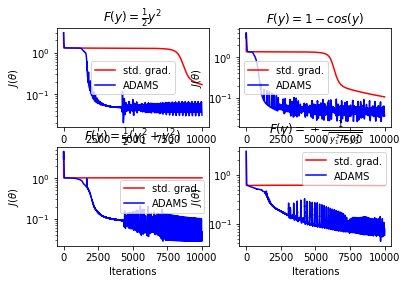

In [456]:
#PLOTTING std. grad. vs ADAM
print("std. grad.: time: ", stop1 - start1, " J(theta): ", f1[-1])
print("ADAMS: time: ", stop2 - start2, " J(theta): ", f11[-1] )
its = np.arange(tol_its + 1)

fig, axs = plt.subplots(2,2)
#fig.suptitle(r'test of $\eta$ and $\sigma$ fuctions')
axs[0, 0].semilogy(its[:len(f1)], f1, 'red', label = 'std. grad.')
axs[0, 0].semilogy(its[:len(f11)], f11, 'blue', label = 'ADAMS')
axs[0, 0].set_title(r'$F(y) = \frac{1}{2}y^2$')
axs[0, 0].legend()
axs[1, 0].semilogy(its[:len(f2)], f2, 'red', label = 'std. grad.')
axs[1, 0].semilogy(its[:len(f21)], f21, 'blue', label = 'ADAMS')
axs[1, 0].set_title(r'$F(y) = \frac{1}{2}(y_1^2 + y_2^2)$')
axs[1, 0].legend()
axs[0, 1].semilogy(its[:len(f3)], f3, 'red', label = 'std. grad.')
axs[0, 1].semilogy(its[:len(f31)], f31, 'blue', label = 'ADAMS')
axs[0, 1].set_title(r'$F(y) = 1 - cos(y)$')
axs[0, 1].legend()
axs[1, 1].semilogy(its[:len(f4)], f4, 'red', label = 'std. grad.')
axs[1, 1].semilogy(its[:len(f41)], f41, 'blue', label = 'ADAMS')
axs[1, 1].set_title(r'$F(y) = - \frac{1}{\sqrt{y_1^2 + y_2^2}}$')
axs[1, 1].legend()

for ax in axs.flat:
    ax.set(xlabel='Iterations', ylabel=r'$J(\theta)$')


# 4. $\tilde{F}(\theta; y)$

1) Defining $\tilde{F}(\theta; y)$

In [460]:


def run_training_alg(d, y0, theta, sigma, eta, h, scale_min, scale_max, scale_min_y, scale_max_y):
    K = math.floor((len(theta) - 2)/2)

    y = np.zeros(d)
    a = 1/(scale_max_y - scale_min_y)*((scale_max_y - y0)*0.25 + (y0 - scale_min_y)*0.75)
    if np.size(y0) != 1:
        y[:len(y0)] = a
    else:
        y[0] = a
    for k in range(K):
        y += + h * (sigma(np.matmul(theta[k], y.T).T + theta[k + K]))
    unscaled = eta(y.dot(theta[-2]) + theta[-1])
    scaled = (unscaled * (scale_max - scale_min) + scale_min*0.75 - scale_max*0.25)/0.5
    return scaled

2) Looking at the trained network when using standard gradient descent and adams for the training function $F(y) = 1 - sin(y)$

0.10597650178380283 0.03595284818115312


Text(0, 0.5, 'F(y)')

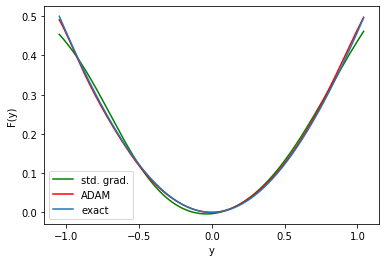

In [501]:
#Testing for tau = 0.09, F3, its = 1000
nums = np.arange(-math.pi/3,math.pi/3,0.01)

res1 = np.zeros(len(nums))
res2 = np.zeros(len(nums))
for i in range(len(nums)):
    res1[i] = run_training_alg(2, nums[i], e3[-1], sig2, eta2, 0.1, ac3, bc3, ay3, by3)
    res2[i] = run_training_alg(2, nums[i], e31[-1], sig2, eta2, 0.1, ac3, bc3, ay3, by3)

print(f3[-1], f31[-1])
plt.plot(nums, res1, 'green', label = 'std. grad.')
plt.plot(nums, res2, 'red', label = 'ADAM')
plt.plot(nums, F3(nums), label = 'exact')
plt.legend()
plt.xlabel("y")
plt.ylabel("F(y)")

3) Testing the training data for the Unknown Hamilton

Function to make input from the test data suiteble for the trainingfunction.

In [462]:
#Generating input to for the training function
def generate_input2(d, C, Y0,K):
    I = len(C)
    d0 = len(Y0)
    aaa = np.amin(Y0)  # max value
    bbb = np.amax(Y0)  # min value
    Y = 1 / (bbb- aaa) * ((bbb - Y0) * 0.25 + (Y0 - aaa) * 0.75)     # scaling the data

    bc = np.max(C)  # max value
    ac = np.min(C)
    C1 = (1 / (bc - ac) * ((bc - C)*0.25 + (C - ac) *0.75))

    theta = []
    m0 = []    # for adams

    for i in range(K):

        theta.append(np.random.rand(d, d))  # d x d - matrix, Wk-values
        m0.append(np.zeros((d, d)))  # dxd matrix, for adams method

    for i in range(K, 2 * K + 1):

        theta.append(np.random.rand(d))  # dim = d, bk-values
        m0.append(np.zeros(d))  # adams

    theta.append(np.random.rand(1))  # dim = 1, mu-value
    m0.append(0)     # for adams
    THETA = []
    THETA.append(theta)

    Z = np.zeros([K + 1, d, I])
    Z[0, :d0, :I] = Y
    P = np.zeros([K + 1, d, I])
    ones = np.ones(I)

    return THETA, Z, P, ones, C1, m0, ac, bc, aaa, bbb



4) Importing the training data.

In [463]:
import csv
from ast import literal_eval
import re
"""
Both of the following functions import data. The output of both functions are a dictionary containing 5 arrays
    t: the array of av time points
    Q: the position values (q)
    P: the momentum values (p)
    T: the kinetic energy
    V: the potential energy
    
The data files contain data from 50 different trajectories, i.e. simulation of the path for a point with some 
initial position q0 and momentum p0. 

The function generate_data gives you the data from one of these data files, while the function concatenate
gives you the data from multiple trajectories at once. The default arguments of concatenate give you all the data
alltogether.

The folder project_2_trajectories must be placed in the same folder as your program to work. If the folder is in
some other location, the path for this location can be put into the string start_path.
"""
def generate_data(batch = 0):
    
    
    start_path = ""
    path = start_path+"project_2_trajectories/datalist_batch_" +str(batch)+".csv"
    with open(path,newline = "\n") as file:
        reader = csv.reader(file)
        datalist = list(reader)
    
    N = len(datalist)
    t_data = np.array([float(datalist[i][0]) for i in range(1,N)])
    Q1_data = [float(datalist[i][1]) for i in range(1,N)]
    Q2_data = [float(datalist[i][2]) for i in range(1,N)]
    Q3_data = [float(datalist[i][3]) for i in range(1,N)]
    P1_data = [float(datalist[i][4]) for i in range(1,N)]
    P2_data = [float(datalist[i][5]) for i in range(1,N)]
    P3_data = [float(datalist[i][6]) for i in range(1,N)]
    T_data = np.array([float(datalist[i][7]) for i in range(1,N)])
    V_data = np.array([float(datalist[i][8]) for i in range(1,N)])
                      
    Q_data = np.transpose(np.array([[Q1_data[i], Q2_data[i], Q3_data[i]] for i in range(N-1)]))
    P_data = np.transpose(np.array([[P1_data[i], P2_data[i], P3_data[i]] for i in range(N-1)]))
    
    return {"t": t_data, "Q": Q_data, "P": P_data, "T": T_data, "V": V_data}

def concatenate(batchmin=0, batchmax=50):
    dictlist = []
    for i in range(batchmin,batchmax):
        dictlist.append(generate_data(batch = i))
    Q_data = dictlist[0]["Q"]
    P_data = dictlist[0]["P"]
    T0 = dictlist[0]["T"]
    V0 = dictlist[0]["V"]
    tlist = dictlist[0]["t"]
    for j in range(batchmax-1 - batchmin):
        Q_data = np.hstack((Q_data, dictlist[j+1]["Q"]))
        P_data = np.hstack((P_data, dictlist[j+1]["P"]))
        T0 = np.hstack((T0, dictlist[j+1]["T"]))
        V0 = np.hstack((V0, dictlist[j+1]["V"]))
        tlist = np.hstack((tlist, dictlist[j+1]["t"]))
    return {"t": tlist, "Q": Q_data, "P": P_data, "T": T0, "V": V0}

Defining training data

In [464]:
#importing all, but the last file. This is going to be the training data 
dat = concatenate(0, 49)

t = dat["t"]
Q = dat["Q"]
P = dat["P"]
T = dat["T"]
V = dat["V"]

#importing the data from the last file, this is goint to be the test data
dat2 = concatenate(49, 50)

tl = dat2["t"]
Ql = dat2["Q"]
Pl = dat2["P"]
Tl = dat2["T"]
Vl = dat2["V"]


5) Defining a improved training algorithm

In [465]:
import random
import math

#faster training algorithm

def trainingAlg2(THETA, Z, P, ones, C, m0, method, sigma, prime_sigma, eta, prime_eta, K, h, tol_its, tol_val=0):
    # for adams method:
    m = []  # for adams
    m.append(m0)  # for adams

    v = []  # for adams
    v.append(m0)  # for adams

    diff = []

    diff.append(3)  # initial value
    its = 0  # initial value
    
    #changed part begin
    splits = math.floor(len(C)/(K*(d**2 + d) + d + 1))
    split_Z = np.array_split(Z, splits, axis = 2)
    split_P = np.array_split(P, splits, axis = 2)
    split_C = np.array_split(C, splits)
    split_ones = np.array_split(ones, splits)
    intv = 0
    #changed part end
    
    while tol_val < diff[-1] and its < tol_its:
        #changed part begin
        if intv == 0:
            slist = random.sample(range(splits), splits)
            #print(diff[-1])
        
        
        index = slist[intv]
        z = split_Z[index]
        p = split_P[index]
        c = split_C[index]
        one = split_ones[index]
        #changed part end

        for k in range(K):
            z[k + 1] = z[k] + h * sigma((np.matmul(THETA[-1][k], z[k]).T + THETA[-1][
                k + K]).T) 

        inp = np.matmul(z[-1].T, (THETA[-1][-2]).T).T + THETA[-1][-1]  # input

        upsilon = eta(inp)

        p[-1] = np.outer(THETA[-1][-2], (np.multiply((upsilon - c), prime_eta(inp))))  

        for k in range(K, 1, -1):
            p[k - 1] = p[k] + h * np.matmul(THETA[-1][k - 1].T, (
                        prime_sigma((np.matmul(THETA[-1][k - 1], z[k - 1]).T + THETA[-1][k + K - 1]).T) * p[
                    k]))  

        dJ = []
        dJ2 = []
        for k in range(K):
            inp1 = p[k + 1] * prime_sigma((np.matmul(THETA[-1][k], z[k]).T + THETA[-1][k + K]).T)
            dJ.append(h * np.matmul(inp1, z[k].T))
            dJ2.append(h * inp1.dot(one.T))

        for k in range(K):
            dJ.append(dJ2[k])

        inp2 = prime_eta((z[-1].T).dot(THETA[-1][-2].T) + THETA[-1][-1])  

        dJdmu = np.inner(inp2, (upsilon - c)) 
        djdw1 = np.matmul(z[-1], ((upsilon - c) * inp2).T).T
        djdw = djdw1[0]

        dJ.append(djdw)
        dJ.append(dJdmu)

        its += 1
        intv = its % splits
        a1, mm, vv = method(THETA[-1], dJ, its, m[-1], v[-1])
        THETA.append(a1)
        m.append(mm)  # for adams

        v.append(vv)  # for adams




        diff.append(1 / (2*len(c)) * np.linalg.norm(c - upsilon))



    return THETA, diff

6) Testing the improved training function for the training data

In [467]:
#Test,

d = 6
K = 20
h = 0.05 
tol_its = 100000


theta_pt, Z_pt, P_pt, ones_pt, scaledTt, m0_pt, ac_pt, bc_pt, aat, bbt = generate_input2(d, T, P, K)
ttta_p, error_pt = trainingAlg2(theta_pt, Z_pt, P_pt, ones_pt, scaledTt, m0_pt, adams_descent, sig2, prime_sig2, eta2, prime_eta2, K, h, tol_its, 10**(-5))

theta_qt, Z_qt, P_qt, ones_qt, scaledVt, m0_qt, ac_qt, bc_qt, cct, ddt = generate_input2(d, V, Q, K)
ttta_q, error_qt = trainingAlg2(theta_qt, Z_qt, P_qt, ones_qt, scaledVt, m0_qt, adams_descent, sig2, prime_sig2, eta2, prime_eta2, K, h, tol_its, 10**(-5))


7) Defining a function to run $\tilde{F}(\theta; y)$

In [468]:

def run_training_alg2(d, y0, theta, sigma, eta, h, scale_min, scale_max, scale_min_y, scale_max_y):
    K = math.floor((len(theta) - 2)/2)
    I = len(y0[0])
    y = np.zeros([d, I])
    #print(scale_max_y)
    #print(y0)
    y1 = 1 / (scale_max_y - scale_min_y) * ((scale_max_y - y0) * 0.25 + (y0 - scale_min_y) * 0.75)     # scaling the data
    y[:len(y0),:] = y1

    for k in range(K):
        y += + h * (sigma(np.matmul(theta[k], y).T + theta[k + K].T)).T
        
    unscaled = eta((y.T).dot(theta[-2]) + theta[-1])
    scaled = (unscaled * (scale_max - scale_min) + scale_min*0.75 - scale_max*0.25)/0.5 #riktig?
    return scaled

8) plotting the test run

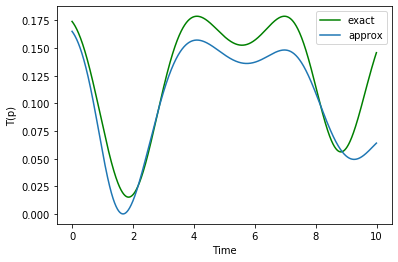

In [937]:
#Test of Training alg 2
result1 = run_training_alg2(6, Pl, ttta_p[-1], sig2, eta2, 0.05, ac_pt, bc_pt, aat, bbt)



plt.plot(tl, Tl, 'green', label = 'exact')
plt.plot(tl, result1, label = 'approx')
plt.xlabel("Time")
plt.ylabel("T(p)")
plt.legend()

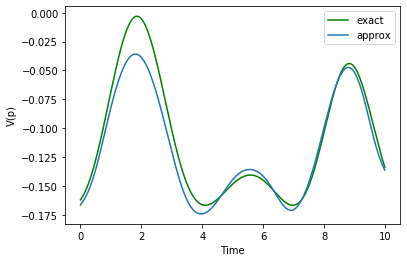

In [942]:
result2 = run_training_alg2(6, Ql, ttta_q[-1], sig2, eta2, 0.05, ac_qt, bc_qt, cct, ddt)

plt.plot(tl, Vl, 'green', label = 'exact')
plt.plot(tl, result2, label = 'approx' )
plt.xlabel("Time")
plt.ylabel("V(p)")
plt.legend()

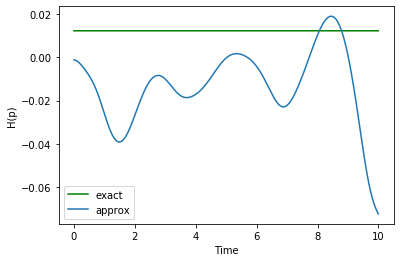

In [941]:
plt.plot(tl, Vl+Tl, 'green', label = 'exact')
plt.plot(tl, result2 + result1, label = 'approx')
plt.xlabel("Time")
plt.ylabel("H(p)")
plt.legend()

9) From test run

Text(0.5, 1.0, 'convergence of T(p) network')

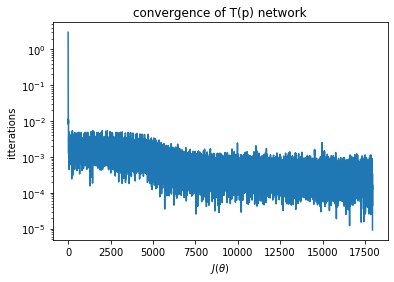

In [476]:

its = np.arange(0,100000+1, 1)
plt.plot(its[:len(error_pt)], error_pt)
plt.yscale('log')
plt.ylabel(r'$J(\theta)$')
plt.xlabel("itterations")
plt.title("convergence of T(p) network")

Text(0.5, 1.0, 'convergence of V(q) network')

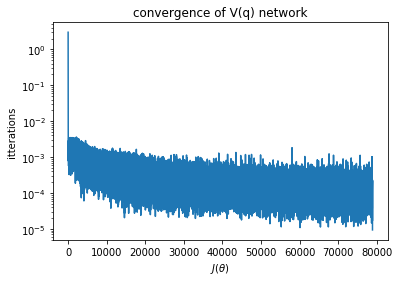

In [477]:
plt.plot(its[:len(error_qt)], error_qt)
plt.yscale('log')
plt.ylabel(r'$J(\theta)$')
plt.xlabel("itterations")
plt.title("convergence of V(q) network")

8) The final training of the neural network.

In [785]:
d = 6
K = 20
h = 0.05 
tol_its = 100000

theta_p, Z_p, P_p, ones_p, scaledT, m0_p, ac_p, bc_p, aa, bb = generate_input2(d, T, P, K)
theta_q, Z_q, P_q, ones_q, scaledV, m0_q, ac_q, bc_q, cc, dd = generate_input2(d, V, Q, K)

thet_p, err_p = trainingAlg2(theta_p, Z_p, P_p, ones_p, scaledT, m0_p, adams_descent, sig2, prime_sig2, eta2, prime_eta2, K, h, tol_its, 0.5*10**(-5))
thet_q, err_q = trainingAlg2(theta_q, Z_q, P_q, ones_q, scaledV, m0_q, adams_descent, sig2, prime_sig2, eta2, prime_eta2, K, h, tol_its, 0.5*10**(-5))

# 5. Testing if the Hamiltonian is preserved along trajectories 

1) Implementing the formula derived in the document section 3

In [871]:
def Delta_F(y0, d, theta, eta_prime , sigma ,sigma_prime, h, min_v, max_v, min_val, max_val):
    y = 0
    #print(max_val, min_val)
    y = 1/(max_val - min_val)*((max_val - y0.T)*0.25 + (y0.T - min_val)*0.75)     #scaling data
    #print(y)
    K = math.floor(len(theta)/2 - 1) # layers
    #print(K)
    d0 = np.size(y0)
    
    Z = np.zeros([K+1,d])
    Z[0, :d0] = y
    
    #print(A[-1])
    
    for k in range(K):
        #Y[k + 1] = Y[k] + h * (sigma(np.matmul(theta[k], Y[k]).T + theta[k + K].T)).T
        Z[k+1] = Z[k] + h* (sigma(theta[k].dot(Z[k].T).T + theta[k + K])).T
        #print(Z)
    #print(theta[k][:d,:d], Z[k].T, theta[k][:d,:d].dot(Z[k].T))
    #print(Z)
    P = np.zeros([K+1,d])
    P[-1] = eta_prime(np.inner(theta[-2].T,Z[-1]) + theta[-1])*theta[-2]

    #Q[-1] = eta_prime(np.inner(theta[-2],Y[-1]) + theta[-1])*theta[-2]
    #print(np.inner(theta[-2][:d].T,Z[-1]), theta[-2][:d], Z[-1], eta_prime(np.inner(theta[-2][:d].T,Z[-1]) + theta[-1]))
    
    for k in range(K, 0, -1):
        
        #a = (theta[k - 1][:d,:d].dot(y).T + theta[k + K - 1][:d].T)
        #h*sigma_prime(theta[k - 1][:d,:d].dot(Z[k-1]) + theta[k + K - 1][:d].T)*P[k]
        #print(s)
        P[k-1] = P[k] + (theta[k-1].T).dot(h*sigma_prime(theta[k - 1].dot(Z[k-1]) + theta[k + K - 1].T)*P[k]).T
        #Q[k-1] = Q[k] + (theta[k-1].T).dot(h*sigma_prime(theta[k - 1].dot(Y[k-1]) + theta[k + K - 1].T)*Q[k]).T
        
        #print(P[k-1], P[k], theta[k-1][:d,:d].T, theta[k - 1][:d,:d].dot(Z[k-1]) + theta[k + K - 1][:d].T, sigma_prime(theta[k - 1][:d,:d].dot(Z[k-1]) + theta[k + K - 1][:d].T))
    
    #print(P[0][:d0])
    return (P[0][:d0])*(max_v - min_v)/(max_val - min_val) #+ 0.25*max_v - 0.75*min_v)/0.5

2) Testing the gradient function

0.09607525990818339
0.03992158300451324
2.221429706850131e-09 0.5000000000000001 -1.0471975511965979 1.0471975511965979


Text(0.5, 1.0, 'dF(y) = sin(y)')

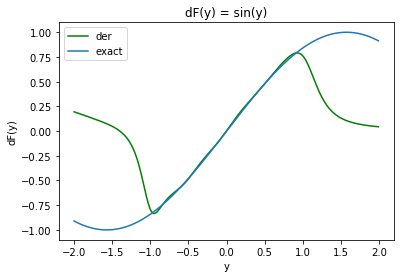

In [945]:
print(e_p[-1])
print(e_q[-1])

#Testing for tau = 0.09, F3, its = 1000
nums = np.arange(-2,2,0.01)

res1 = np.zeros(len(nums))
#res2 = np.zeros(len(nums))
print(ac3, bc3, ay3, by3)
for i in range(len(nums)):
    res1[i] = Delta_F(nums[i],2,e31[-1], prime_eta2 , sig2, prime_sig2, 0.1, ac3, bc3, ay3, by3)
    #res2[i] = run_training_alg(2, nums[i], e31[-1], sig2, eta2, 0.1, ac3, bc3, ay3, by3)

dF = np.sin(nums)


plt.plot(nums, res1, 'green', label = 'der')
#plt.plot(nums, res2, 'red', label = 'ADAM')
plt.plot(nums, dF, label = 'exact')
#plt.plot(nums, 1, label = 'exact')
plt.legend()
plt.xlabel("y")
plt.ylabel("dF(y)")
plt.title("dF(y) = sin(y)")

$\Delta T(p)$ and $\Delta V(q)$ for the final neural network

In [872]:
def Delta_T(p):
    return Delta_F(p, 6, thet_p[-1], prime_eta2, sig2, prime_sig2, 0.05, ac_p, bc_p, aa, bb)

def Delta_V(q):
    return Delta_F(q, 6, thet_q[-1], prime_eta2, sig2, prime_sig2, 0.05, ac_q, bc_q, cc, dd)

3) Defining symplectic Euler and Strømer-Verlet 

In [873]:
#symplectic Euler:

def symplectic_euler(p0, q0, dT, dV, h):
    N = len(h)
    p = np.zeros([len(p0), N+1])
    q = np.zeros([len(p0), N+1])
    dt = h[1] - h[0]
    p[:,0] = p0
    q[:,0] = q0
    print(p)
    print(q)
    
    for n in range(N):
        q[:,n+1] = q[:,n] + dt*dT(p[:,n])
        p[:,n+1] = p[:,n] - dt*dV(q[:,n+1])   

    return p, q

# Strømer-Verlet method

def stormer_verlet(p0, q0, dT, dV, h):
    N = len(h)
    dt = h[1] - h[0]
    p = np.zeros([len(p0), N+1])
    q = np.zeros([len(p0), N+1])
    pn2 = np.zeros([len(p0), N])
    
    p[:,0] = p0
    q[:,0] = q0
    for n in range(N):
        pn2[:,n] = p[:,n] - dt/2*dV(q[:,n])
        q[:,n+1] = q[:,n] + dt * dT(pn2[:,n])
        p[:,n+1] = pn2[:,n] - dt/2 * dV(q[:,n+1])
    return p, q

Chosing $H(p,q) = \frac{1}{2}p^Tp + \frac{1}{\sqrt(q_1^2 + q_2^2)}

this gives us $\frac{\partial T}{\partial p}(p) = p$ and $\frac{\partial V}{\partial q}(q) = \frac{1}{(q_1^2 + q_2^2)^{3/2}}(q_1, q_2 )^T$

In [767]:
def H(p,q):
    return 1/2*(p[0]**2 + p[1]**2) + 1/2*(q[0]**2 + q[1]**2) + q[0]**2*q[1] + 1/3*q[1]**3

def H2(p, q):
    return 1/2*np.linalg.norm(p, axis = 0)**2 -1/np.linalg.norm(q, axis = 0)

def T123(p):
    return  1/2*np.linalg.norm(p, axis = 1)**2

def V123(q):
    return -1/np.linalg.norm(q, axis = 1)

def V1234(q):
    return np.array([q[:,0], q[:,1]])/np.linalg.norm(q, axis = 1)**3

def dTdp(p):
    return p

def dVdq(q):
    return np.array([q[0] + 2*q[0]*q[1],q[1] + q[0]**2 - q[1]**2])

def dVdq2(q):
    return 1/(q[0]**2 + q[1]**2)**(3/2)*np.array([q[0], q[1]])



4) Training a neural network for $T(p)$ and $V(q)$

In [885]:
I = 1000
d0 = 2
d = 4
K = 10
h = 0.1
tol_its = 40000
tht_p, ZZ_p, PP_p, on_p, C_p, m0_pp, ac_pp, bc_pp, ay_pp, by_pp = generate_input(T123, I, d0, d, [[-7, -7], [7, 7]], K)
tht_q, ZZ_q, PP_q, on_q, C_q, m0_qq, ac_qq, bc_qq, ay_qq, by_qq = generate_input(V123, I, d0, d, [[-7, -7], [7, 7]], K)

tht_p , e_p = trainingAlg(tht_p, ZZ_p, PP_p, on_p, C_p, m0_pp, adams_descent, sig2, prime_sig2, eta2, prime_eta2, K, h, tol_its, 10**(-3))
print("QQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQ")
tht_q , e_q = trainingAlg(tht_q, ZZ_q, PP_q, on_q, C_q, m0_qq, adams_descent, sig2, prime_sig2, eta2, prime_eta2, K, h, tol_its, 10**(-3))


8.707086066574883
8.665111768130073
8.618474179875342
8.566231297448272
8.507441785913693
8.44103444357832
8.365758570060168
8.280157987004653
8.182554885402531
8.071045914490831
7.943523269628991
7.797749729936422
7.631507844890134
7.442826290470241
7.230287351421397
6.993397199133971
6.73296642063968
6.451398058049985
6.152749102156959
5.842459310986572
5.526735325090327
5.211760701103123
4.9030601125575055
4.605178424993557
4.321586752276036
4.0547403052769395
3.806216685267079
3.576857113978947
3.366886816352745
3.176027343366524
3.003610286525257
2.8486881882436523
2.710133678623627
2.586720868278602
2.477187668689637
2.380280879182706
2.2947872184579996
2.219553602184265
2.1534995138862816
2.095623696955557
2.0450068180040573
2.000811291365308
1.9622791181276222
1.9287283590129005
1.8995487004091758
1.8741964619768103
1.852189314098414
1.8331009121066622
1.816555604783868
1.8022233334865017
1.7898148037180879
1.7790769822819028
1.7697889498381816
1.7617581203415995
1.754816824935

1.6113844386979457
1.6107503829996372
1.6101158594869702
1.609480916220027
1.60884560122145
1.6082099624968087
1.6075740480549423
1.60693790592804
1.6063015841911954
1.6056651309811656
1.6050285945140532
1.6043920231016109
1.6037554651658723
1.603118969251789
1.6024825840375672
1.6018463583423792
1.6012103411311442
1.6005745815160608
1.5999391287546025
1.5993040322436878
1.5986693415097648
1.598035106194575
1.5974013760363879
1.5967682008465365
1.5961356304811274
1.5955037148078448
1.5948725036678135
1.5942420468325522
1.5936123939561022
1.5929835945224795
1.5923556977886624
1.5917287527234
1.5911028079421816
1.5904779116387782
1.589854111513831
1.5892314547010127
1.588609987691343
1.5879897562562881
1.5873708053703033
1.586753179133513
1.5861369206952398
1.5855220721790957
1.5849086746103507
1.5842967678462745
1.5836863905101255
1.5830775799294097
1.5824703720790019
1.5818648015296437
1.5812609014022796
1.5806587033286053
1.5800582374181336
1.5794595322319827
1.5788626147635207
1.5782

1.4342436136621306
1.4339857949962893
1.433728169880014
1.4334706938798318
1.4332133246752687
1.4329560222783535
1.4326987491539396
1.432441470259577
1.4321841530222843
1.4319267672676952
1.4316692851149588
1.4314116808486217
1.4311539307766563
1.430896013081905
1.430637907672522
1.4303795960355639
1.4301210610966686
1.4298622870877902
1.4296032594241705
1.429343964591142
1.4290843900408978
1.4288245240990396
1.4285643558804995
1.4283038752142654
1.4280430725762776
1.4277819390298006
1.4275204661725827
1.4272586460901235
1.4269964713144037
1.4267339347874695
1.42647102982931
1.4262077501095178
1.4259440896222617
1.425680042664157
1.4254156038146508
1.42515076791859
1.4248855300706669
1.424619885601476
1.424353830064946
1.4240873592269336
1.423820469054792
1.4235531557077483
1.4232854155279462
1.4230172450320204
1.4227486409030932
1.42247959998309
1.422210119265293
1.4219401958870521
1.4216698271225932
1.4213990103758698
1.421127743173411
1.4208560231571352
1.420583848077092
1.420311215

1.2702413390390654
1.2698230759963771
1.269398032943167
1.2689803882729327
1.2685569241289272
1.2681397519858115
1.267717536383866
1.2673007525511444
1.2668795528820542
1.2664631112565379
1.2660427625839177
1.2656266418615927
1.2652070275593597
1.2647912234773857
1.2643722623671798
1.2639567830263756
1.263538420559812
1.2631232834892272
1.2627054855143733
1.2622907157451295
1.261873463967448
1.261459092710001
1.2610423812923868
1.260628444990413
1.2602122779368714
1.2597988175705601
1.2593832066601034
1.2589702672281844
1.2585552303415488
1.258142860484612
1.2577284202147938
1.2573166719632214
1.256902854432346
1.2564917830766957
1.2560786169028981
1.2556682809966524
1.2552557963695206
1.2548462578863713
1.2544344857209477
1.254025810403543
1.2536147815531522
1.253207039510058
1.2527967840296774
1.252390050665647
1.2519805971332556
1.2515749545400077
1.2511663294680018
1.2507618684667714
1.250354095876956
1.2499509190035651
1.249544020310883
1.249142246191215
1.2487362406668625
1.24833

1.116212420775751
1.1130313283268773
1.1125312827109008
1.1097011101232563
1.1095087269898973
1.1070669379750002
1.1071714366871817
1.1050794795096068
1.1054414075772516
1.1036404440523544
1.1042302741493968
1.102668152438535
1.1034786690710856
1.1021198323075148
1.103166798086371
1.1019939660456088
1.1033118030487372
1.1023223666549697
1.103954715660544
1.103149298278679
1.1051297524277337
1.1044864230018299
1.1068038805962175
1.1062342830164078
1.1087864493289286
1.108091672338319
1.1106562355838008
1.109540468570962
1.1118189868770108
1.11001711245834
1.1117701595948493
1.1092237032461765
1.1104042679898614
1.1073089890052363
1.108066718422279
1.1047427294651944
1.1053069632862558
1.1020354954694533
1.1025985495983393
1.099546620053748
1.1002216492964265
1.0974508798297269
1.098287704339771
1.0957942182279259
1.096810391352662
1.0945603127906371
1.095764029876829
1.0937146325737985
1.0951156039257472
1.0932242132745258
1.0948356024769685
1.0930603914280992
1.0948948053847865
1.09319

0.43760457097651323
0.4407405460250531
0.43398331294142456
0.4369484696141272
0.4304926134271599
0.43330312808956956
0.4271292436959543
0.42979976318228935
0.4238897228491074
0.42643349254290236
0.42077036442447263
0.42319934837904455
0.4177673195647051
0.4200923126530911
0.4148766167482329
0.41710734897566293
0.41209419814272913
0.4142394313593869
0.40941595268729747
0.411483570011714
0.40683774603855505
0.4088348343487032
0.40435544753129365
0.4062883734065486
0.4019649543097169
0.4038394338171572
0.3996622127834548
0.4014833755004321
0.3974432375562459
0.39921568521107276
0.3953041279662597
0.39703198806314505
0.39324108236747285
0.39492805714256707
0.3912504102722823
0.39289982130671064
0.3893285424677872
0.39094337126227785
0.38747203921240325
0.38905496400739814
0.3856775966159582
0.38723102572180956
0.3839420513053349
0.3854681531896696
0.38226238347885455
0.3837631138426768
0.3806357184556073
0.3821128445162806
0.37905932683047344
0.38051444901824166
0.37753062335102733
0.37896

0.2774925206208903
0.27626614866667204
0.2772081417374064
0.2759832716928099
0.27692463492776376
0.27570125571585974
0.27664199676444573
0.27542009732404443
0.27636022389853127
0.2751397931866855
0.27607931306280625
0.27486034005699633
0.2757992610744985
0.2745817347744664
0.27552006483753455
0.2743039742667296
0.2752417213442282
0.2740270555508419
0.27496422767629963
0.27375097573389856
0.2746875810052315
0.273475732012993
0.27441177859190763
0.2732013216744712
0.27413681778554366
0.27292774209253184
0.2738626960219628
0.27265499072720184
0.27358941082124855
0.2723830651217369
0.2733169597848426
0.27211196289952744
0.27304534059216184
0.27184168176057466
0.2727745509968487
0.27157221947766125
0.27250458882271583
0.27130357389226706
0.272235451959516
0.27103574291037663
0.2719671383586236
0.2707687244982259
0.271699646028723
0.27050251667811553
0.2714329730315894
0.2702371175243488
0.27116711747806377
0.26997252515939063
0.2709020775242717
0.26970873775028936
0.2706378513681456
0.26944

0.23224886061642977
0.23324692162194693
0.23211701601727477
0.23311603399843778
0.23198567046909202
0.23298564915338024
0.2318548217373839
0.23285576481555656
0.23172446759073495
0.23272637871695018
0.2315946058009932
0.23259748859292917
0.23146523414344747
0.23246909218241582
0.23133635039699954
0.23234118722807373
0.23120795234434016
0.23221377147647462
0.23108003777211092
0.23208684267826618
0.2309526044710748
0.23196039858834214
0.23082565023626744
0.2318344369660003
0.23069917286717173
0.23170895557511093
0.23057317016785947
0.23158395218426375
0.2304476399471496
0.2314594245669298
0.23032258001875744
0.23133537050161093
0.23019798820144544
0.23121178777198287
0.2300738623191556
0.23108867416704582
0.22995020020115947
0.2309660274812565
0.22982699968218553
0.23084384551467943
0.22970425860256757
0.2307221260731092
0.22958197480835874
0.23060086696821236
0.22946014615147212
0.23048006601764956
0.2293387704897997
0.2303597210452058
0.22921784568733494
0.2302398298809084
0.2290973696

0.21271521784293868
0.21395072635151668
0.21264970345913606
0.21388637446186984
0.21258437773407093
0.21382221050286407
0.2125192398644615
0.21375823366316857
0.21245428905103245
0.21369444313554714
0.21238952449848533
0.21363083811681602
0.21232494541546668
0.2135674178078172
0.21226055101453736
0.21350418141339378
0.2121963405121462
0.21344112814235097
0.21213231312859687
0.2133782572074273
0.2120684680880142
0.2133155678252646
0.2120048046183199
0.2132530592163811
0.21194132195120655
0.2131907306051385
0.2118780193221046
0.21312858121971298
0.21181489597014688
0.2130666102920661
0.2117519511381569
0.21300481705792182
0.21168918407260842
0.21294320075672804
0.2116265940236003
0.21288176063163428
0.21156418024482965
0.21282049592946062
0.21150194199356678
0.21275940590067913
0.21143987853062832
0.21269848979937686
0.21137798912034822
0.21263774688323017
0.2113162730305502
0.21257717641348012
0.2112547295325303
0.21251677765490756
0.2111933579010204
0.2124565498758058
0.211132157414171

0.20338409515974828
0.20188446561154758
0.20334631449093557
0.20184584611429424
0.20330860959831817
0.20180730333275748
0.2032709801636545
0.2017688369491455
0.2032334258700783
0.2017304466470215
0.20319594640208527
0.20169213211128104
0.20315854144552972
0.2016538930281664
0.2031212106876211
0.20161572908525105
0.20308395381691882
0.201577639971434
0.2030467705233245
0.20153962537694073
0.20300966049808147
0.20150168499331575
0.20297262343376854
0.20146381851341985
0.20293565902429017
0.20142602563141496
0.20289876696487394
0.20138830604277233
0.20286194695206905
0.2013506594442601
0.20282519868373858
0.2013130855339445
0.2027885218590544
0.20127558401117743
0.20275191617849275
0.2012381545765962
0.20271538134382686
0.20120079693211917
0.20267891705812638
0.20116351078093941
0.2026425230257531
0.20112629582752284
0.20260619895234921
0.20108915177759482
0.20256994454483296
0.20105207833814479
0.20253375951140418
0.20101507521741865
0.20249764356152694
0.20097814212491275
0.202461596405

0.1967213349457347
0.19506561216191823
0.19669420052683664
0.19503782403709938
0.19666709819763586
0.19501006876179758
0.19664002783220152
0.19498234620866445
0.19661298930514506
0.19495465625090408
0.19658598249162582
0.1949269987622582
0.19655900726733821
0.1948993736170134
0.19653206350851937
0.1948717806899925
0.19650515109193667
0.19484421985655162
0.19647826989489484
0.19481669099258508
0.19645141979522332
0.19478919397451222
0.19642460067128303
0.19476172867928224
0.19639781240195492
0.19473429498436806
0.19637105486664586
0.19470689276776734
0.19634432794528306
0.19467952190800056
0.19631763151830892
0.19465218228410067
0.19629096546668007
0.19462487377561952
0.19626432967186758
0.19459759626262157
0.19623772401585368
0.19457034962568712
0.19621114838112566
0.19454313374589427
0.19618460265067608
0.19451594850483775
0.19615808670800386
0.1944887937846124
0.19613160043710356
0.19446166946781174
0.1961051437224683
0.19443457543753065
0.19607871644909078
0.19440751157736277
0.1960

0.1896782416021745
0.1914367595069309
0.18965529785612756
0.19141434952267192
0.18963236890992477
0.19139195377534876
0.1896094547118786
0.1913695722142715
0.18958655521052403
0.19134720478896525
0.18956367035461033
0.19132485144916808
0.18954080009310828
0.19130251214483196
0.189517944375202
0.19128018682612066
0.18949510315028667
0.19125787544340295
0.18947227636797678
0.19123557794726712
0.18944946397810025
0.19121329428850442
0.18942666593069513
0.19119102441811267
0.1894038821760114
0.19116876828730342
0.1893811126645122
0.19114652584748956
0.18935835734686812
0.19112429705029363
0.18933561617396133
0.19110208184754132
0.18931288909688002
0.19107988019126365
0.18929017606692483
0.19105769203369571
0.1892674770356003
0.19103551732727633
0.1892447919546171
0.19101335602464245
0.18922212077588996
0.19099120807863385
0.18919946345154065
0.19096907344229475
0.1891768199338951
0.19094695206886553
0.18915419017548254
0.19092484391178763
0.18913157412903173
0.19090274892469533
0.189108971

0.18507962268649103
0.18693995951269263
0.18505894356985866
0.18691971142650088
0.18503827208940662
0.18689947054890577
0.18501760822494295
0.18687923686008798
0.18499695195636515
0.1868590103403134
0.1849763032636604
0.18683879096994152
0.18495566212691117
0.18681857872941335
0.18493502852628158
0.1867983735992667
0.1849144024420317
0.1867781755601188
0.18489378385450778
0.18675798459267884
0.1848731727441436
0.18673780067774212
0.18485256909146136
0.1867176237961889
0.18483197287707334
0.18669745392898537
0.1848113840816776
0.1866772910571859
0.18479080268605647
0.1866571351619276
0.18477022867108306
0.18663698622443217
0.18474966201771242
0.18661684422600605
0.18472910270698492
0.1865967091480387
0.18470855072002987
0.18657658097200513
0.18468800603805757
0.18655645967946086
0.18466746864236303
0.18653634525204343
0.18464693851432318
0.18651623767147135
0.18462641563540075
0.18649613691955072
0.18460589998714358
0.1864760429781651
0.18458539155117673
0.1864559558292765
0.18456489030

0.1808797050159284
0.18282162647800176
0.18086029335867898
0.18280256210128357
0.1808408865036186
0.1827835021486899
0.18082148444158316
0.1827644466111887
0.18080208716343477
0.18274539547977148
0.18078269466005267
0.18272634874545124
0.18076330692234346
0.18270730639926125
0.180743923941231
0.18268826843225489
0.18072454570766266
0.18266923483550673
0.180705172212606
0.18265020560011658
0.18068580344705468
0.18263118071720022
0.18066643940201868
0.18261216017789653
0.1806470800685314
0.18259314397336104
0.18062772543764424
0.18257413209477444
0.1806083755004326
0.18255512453333259
0.18058903024799056
0.1825361212802521
0.18056968967143153
0.18251712232677297
0.18055035376189144
0.18249812766415094
0.1805310225105266
0.1824791372836612
0.18051169590850888
0.18246015117660042
0.18049237394703396
0.1824411693342808
0.1804730566173153
0.18242219174803648
0.1804537439105852
0.18240321840921772
0.18043443581809585
0.18238424930919617
0.18041513233111922
0.18236528443935676
0.18039583344094

0.17680316862310091
0.17881122338005376
0.17678460499040852
0.1787929279161383
0.17676604454293363
0.17877463527772505
0.17674748727479073
0.1787563454590101
0.17672893318011065
0.17873805845420881
0.17671038225304733
0.17871977425756166
0.17669183448777617
0.178701492863329
0.17667328987850037
0.1786832142657987
0.17665474841943962
0.1786649384592786
0.17663621010483957
0.17864666543810148
0.17661767492897074
0.17862839519662335
0.17659914288612344
0.1786101277292271
0.17658061397061448
0.17859186303031516
0.17656208817678334
0.17857360109431722
0.176543565498992
0.17855534191568714
0.17652504593163185
0.17853708548890662
0.17650652946911521
0.17851883180847752
0.1764880161058767
0.17850058086892967
0.17646950583637835
0.17848233266481645
0.17645099865510927
0.1784640871907226
0.17643249455658244
0.17844584444125275
0.17641399353533288
0.17842760441103775
0.17639549558592718
0.17840936709474112
0.17637700070295448
0.17839113248704658
0.17635850888102989
0.1783729005826671
0.1763400201

0.17300417773278765
0.17506046167769806
0.17298620009445548
0.17504268069323026
0.17296822524059632
0.17502490217577954
0.1729502531749944
0.17500712612950375
0.1729322839015018
0.1749893525586283
0.17291431742404081
0.17497158146744723
0.17289635374659992
0.17495381286032893
0.17287839287323628
0.1749360467417065
0.17286043480807325
0.1749182831160812
0.1728424795553
0.17490052198802505
0.17282452711917548
0.174882763362183
0.17280657750402934
0.17486500724326492
0.17278863071425576
0.17484725363605583
0.17277068675431614
0.17482950254539953
0.17275274562874152
0.1748117539762229
0.17273480734213195
0.17479400793351824
0.17271687189915666
0.17477626442234195
0.17269893930454713
0.1747585234478242
0.17268100956310764
0.1747407850151657
0.17266308267970776
0.17472304912963402
0.17264515865928834
0.174705315796571
0.1726272375068588
0.17468758502138723
0.172609319227495
0.17466985680956099
0.17259140382633842
0.17465213116663686
0.1725734913086005
0.17463440809823932
0.17255558167956495


0.17139215960186496
0.16928366160275407
0.17137508603142368
0.16926645298660795
0.17135801712025175
0.16924924926377324
0.1713409528827739
0.1692320504482577
0.17132389333341175
0.1692148565540739
0.17130683848660216
0.16919766759524452
0.1712897883567813
0.16918048358579393
0.17127274295838243
0.169163304539751
0.1712557023058491
0.16914613047114863
0.17123866641362337
0.16912896139402153
0.17122163529614629
0.1691117973224107
0.1712046089678658
0.16909463827035892
0.17118758744322635
0.16907748425191127
0.17117057073667394
0.169060335281109
0.17115355886264952
0.1690431913720017
0.1711365518355984
0.16902605253863182
0.17111954966995915
0.1690089187950479
0.17110255238017197
0.16899179015529614
0.1710855599806751
0.16897466663342073
0.17106857248589782
0.1689575482434634
0.17105158991026995
0.1689404349994651
0.17103461226821506
0.16892332691546275
0.17101763957415234
0.1689062240054898
0.17100067184249312
0.16888912628358055
0.17098370908765
0.16887203376375634
0.17096675132401642
0

0.1656863445229386
0.16780341592532597
0.16567049561371255
0.16778766455112148
0.16565465406973107
0.16777192035179953
0.16563881989764
0.16775618333387043
0.16562299310404113
0.16774045350379876
0.16560717369548147
0.1677247308679898
0.1655913616784591
0.16770901543280087
0.16557555705941854
0.1676933072045351
0.1655597598447579
0.16767760618944347
0.1655439700408204
0.16766191239372835
0.1655281876539036
0.16764622582353786
0.1655124126902527
0.1676305464849674
0.16549664515606127
0.1676148743840621
0.16548088505747335
0.16759920952681473
0.1654651324005826
0.16758355191916793
0.16544938719143448
0.16756790156701226
0.16543364943602343
0.16755225847618532
0.1654179191402911
0.1675366226524774
0.1654021963101347
0.16752099410162144
0.16538648095139305
0.16750537282930186
0.1653707730698613
0.16748975884115475
0.16535507267128313
0.16747415214275754
0.16533937976135096
0.16745855273964663
0.16532369434570846
0.16744296063729755
0.16530801642995144
0.1674273758411451
0.16529234601962434

0.1624262477062951
0.1645597353396211
0.16241206090006433
0.16454560090234913
0.1623978813745227
0.16453147353197517
0.16238370910775043
0.16451735320747604
0.1623695440764902
0.16450323990660873
0.1623553862559935
0.1644891336057784
0.16234123561985286
0.16447503427989735
0.16232709213981206
0.16446094190221094
0.16231295578553717
0.16444685644411097
0.16229882652435787
0.16443277787491165
0.16228470432096379
0.16441870616158208
0.16227058913703607
0.164404641268447
0.16225648093084952
0.1643905831568457
0.16224237965676624
0.16437653178470174
0.16222828526465924
0.16436248710605977
0.16221419769923293
0.16434844907050045
0.16220011689920152
0.16433441762248505
0.16218604279631876
0.1643203927005438
0.16217197531422212
0.1643063742363513
0.16215791436703966
0.16429236215359028
0.16214385985771726
0.164278356366614
0.16212981167599316
0.16426435677883738
0.1621157696959639
0.1642503632808006
0.16210173377310583
0.16423637574784603
0.16208770374066153
0.1642223940372892
0.16207367940521

0.16179501491014556
0.1596402350250605
0.1617840895356407
0.15962936974214081
0.16177339116139397
0.15961868886597982
0.16176285902909115
0.15960813370418833
0.1617524336850045
0.1595976471786689
0.1617420578334858
0.15958717458374874
0.16173167707094158
0.15957666422606887
0.16172124049596096
0.15956606794272138
0.16171070119301123
0.15955534149561987
0.16170001658854927
0.1595444448411862
0.16168914867945292
0.1595333422753568
0.1616780641344799
0.15952200245438458
0.16166673426995867
0.15951039829223881
0.161655134901142
0.15949850673539293
0.16164324607063385
0.15948630841555422
0.16163105165513217
0.15947378718062422
0.1616185388515341
0.1594609295037682
0.16160569754320755
0.15944772377019778
0.16159251954727563
0.15943415944129713
0.16157899774420537
0.15942022609622952
0.16156512509216922
0.159405912352605
0.16155089353093008
0.15939120467054252
0.16153629278402665
0.15937608604934242
0.161521309074448
0.1593605346337957
0.161505923779006
0.15934452225952803
0.16149011206147898

0.15703460270840852
0.1591778618565279
0.15702249311093885
0.15916589947149928
0.1570102305013742
0.15915393143366188
0.15699797416466196
0.15914216900681213
0.1569859429436942
0.159130896843618
0.15697443032110206
0.15912049209973428
0.15696382481572715
0.15911145048256706
0.1569546386499166
0.1591044229362894
0.15694754933190333
0.15910026861630475
0.15694346126493744
0.1591001325055261
0.15694359790204476
0.15910555940911603
0.15694963918910393
0.1591186594249769
0.15696392301621495
0.15914234084456957
0.1569897294827221
0.1591806179320676
0.15703165293060295
0.1592389662938244
0.15709601434080953
0.15932459990674852
0.15719112167422108
0.15944630638136362
0.15732684428048005
0.15961297873969466
0.1575122777088303
0.1598291106323573
0.15774916812525827
0.16008447272633936
0.15801778363938052
0.16033528301731928
0.15825339986311876
0.1604789584468667
0.15832035362707345
0.1603381893163335
0.15800905966090667
0.15968725130869962
0.15709363487395614
0.15834597666889086
0.15545563803953

0.1571577402559639
0.15502832032764086
0.1572555562258211
0.15513445970865747
0.15736795974275572
0.1552527115390706
0.15747535231154833
0.1553556291364191
0.15753310821711536
0.15538474618744721
0.15745981684546193
0.15524021955984865
0.15713421381980622
0.15478585320001992
0.15641556835667894
0.1538847103218838
0.15519610077543622
0.15246485306159427
0.15346894183054727
0.15058289553033471
0.15136860868754135
0.14843740506375774
0.1491486510901104
0.1463149088442055
0.14710665374828855
0.14450302138385304
0.14550377094584663
0.1432225024820249
0.14451864515021692
0.14260297753410764
0.14424213409261988
0.14269328858773853
0.14469574631516635
0.14348477357888573
0.14585404102802954
0.14493094504894352
0.1476591788243283
0.14695642467697154
0.15002373012238585
0.14945465165145358
0.15282298802788932
0.15227825103900422
0.15588249787648606
0.1552305583872575
0.1589722877999756
0.15807153615710753
0.1618237053381424
0.1605504947472222
0.16417890066578236
0.16246386265235568
0.16586047725

0.14031652979286985
0.1417051820673429
0.1399524304803989
0.1416668885909396
0.14025064273851484
0.1423263237141178
0.14123841234767387
0.1436989013780463
0.14291173650261682
0.14577149149697463
0.1452366893527623
0.1484977910019613
0.14813871308648996
0.15177995171189476
0.15147997755266607
0.15543904485145177
0.15503347182268046
0.15918954335538657
0.15847672477128666
0.1626499320876577
0.16143662063695557
0.1654217307509935
0.16359453159193166
0.16722454944699067
0.16480351614482774
0.1680060550323737
0.16513401842480552
0.16794021823780975
0.1648130139843862
0.16731817867476875
0.16410892830502227
0.16642001903888345
0.1632405815298113
0.16544191351043763
0.16234363174321045
0.1644871167840925
0.16148032932138512
0.1635907994474382
0.16066534441583977
0.1627504338163434
0.15988987944141642
0.16194873080104655
0.15913800787840146
0.16116712404494102
0.15839556739270952
0.16039205337428172
0.1576538557504545
0.15961682449236264
0.15691027520341413
0.15884114050168305
0.15616744436643

0.14985286055606292
0.1516145042451826
0.14904816270483945
0.15075593025463407
0.14826110347267557
0.14996889093964497
0.1475998507103223
0.14936714677499777
0.1471632995580272
0.14904677064465138
0.14702913754483526
0.1490768527880808
0.14724885988111647
0.14949730964427543
0.14784793755755385
0.15032071251452517
0.14882794983767858
0.15153442859081903
0.15016740561754657
0.15309982174568063
0.1518184668281299
0.15494619913305174
0.15369780432022845
0.15695905911702657
0.15567243496045993
0.1589664343289164
0.15754727834581325
0.1607345730584926
0.15906981724272795
0.16199105205130898
0.1599709213070907
0.16248806226999382
0.16004527214105327
0.1620910044532291
0.1592380819361953
0.16084311786993644
0.15767994161757534
0.15895736890995088
0.15563907538085583
0.1567366759641542
0.15342227014260082
0.15447446429548892
0.1512864746244571
0.15238851863617683
0.14939823259695995
0.15060375518494212
0.14783708224338765
0.14916808839307727
0.1466199644373832
0.14807908167927314
0.14572745963

0.1500689159384976
0.151997942362204
0.14967176230145865
0.15159262365077988
0.149288738945047
0.15120334751262096
0.14892236640531936
0.15083265869259085
0.14857507165443284
0.1504830093661911
0.148249175016575
0.15015672963464763
0.14794685425855156
0.14985598107611425
0.14767009697185846
0.1495827033705435
0.14742064957042514
0.14933856125833295
0.1471999688409829
0.14912489680985216
0.1470091800165637
0.14894269015300993
0.14684904377710065
0.14879253038608117
0.14671993337674372
0.14867459734240052
0.14662182221043968
0.14858865411865907
0.14655428151382427
0.14853404977548443
0.14651648749137172
0.14850973131606512
0.14650723694030848
0.14851426389663538
0.1465249703371689
0.14854585817821245
0.1465678013407487
0.14860240375410838
0.14663355170605957
0.1486815076519369
0.14671979067192542
0.14878053698804644
0.14682387795999652
0.14889666492951723
0.1469430095910473
0.14902691918263197
0.14707426577665766
0.14916823227053433
0.14721466017610543
0.14931749288377705
0.1473611898180

0.14895815598534548
0.1468627758023804
0.14885153843726384
0.14676331946408852
0.1487573628985041
0.14667639045075448
0.14867725677862303
0.14660303480242046
0.1486116987909103
0.14654320898178363
0.14856002423317718
0.1464958054870663
0.14852047305527924
0.14645871360744694
0.14849026979989913
0.14642890531326277
0.1484657257370056
0.1464025379653488
0.14844235599651445
0.14637506829506877
0.14841500794955362
0.14634137574610392
0.1483780012696248
0.14629589760608203
0.1483252847696971
0.14623278312390964
0.14825061983298962
0.14614607847329397
0.1481478042514913
0.14602995799851326
0.14801095228202746
0.1458790181286371
0.14783484498270572
0.1456886467164246
0.14761535753213084
0.1454554704979266
0.14734995601848766
0.14517786610345426
0.14703823560292292
0.14485649709747989
0.1466824482747474
0.14449481557726587
0.14628794793714248
0.1440994495046838
0.1458634714288647
0.14368039460765406
0.14542118337537044
0.1432509480788269
0.14497644286676464
0.1428273598690074
0.144547296122336

0.14905917587936218
0.14680849768277732
0.14869037860133996
0.14645608548465416
0.14834293565573395
0.14612562103986435
0.14801976512240547
0.14581879104362477
0.14772108634831638
0.1455349952718275
0.14744511083827622
0.14527197899057043
0.1471886837854341
0.14502641384742768
0.14694785829931187
0.1447944152608901
0.1467183967453457
0.1445719926097839
0.14649619881217796
0.14435543148712443
0.14627765686774458
0.1441416073200579
0.14605993820369978
0.14392822866617144
0.14584119260605025
0.14371400782282717
0.14562068341906417
0.1434987568405803
0.14539884141987625
0.14328340891855257
0.1451772434209573
0.1430699683242716
0.14495852117709992
0.1428613959036523
0.14474621021541523
0.1426614411907976
0.14454455184112305
0.14247443532363605
0.14435826408748617
0.14230506080641298
0.14419229830490335
0.14215811431030567
0.14405159728253167
0.14203827718736103
0.14394086845734747
0.14194990550980793
0.1438643823303113
0.1418968477493706
0.1438258022390241
0.14188229424990767
0.143828047682

0.1456967693465291
0.14369848387974882
0.14590775111021012
0.14387046792351602
0.14606122170482322
0.1439726950727806
0.14612144248257436
0.14397265440437976
0.14605898400220935
0.14384556322578154
0.14585455637780875
0.14357796929392685
0.14550203676330864
0.14317017686314873
0.14500987282053146
0.14263676066399958
0.14440036827290045
0.14200490203615138
0.1437069219500524
0.14131089776302866
0.14296985498007883
0.1405956782754473
0.14223177700087705
0.13990032691717805
0.1415334080126316
0.1392624025864053
0.14091046568759286
0.1387134827124916
0.1403918276872213
0.1382779540306431
0.13999884767939316
0.13797281373485148
0.13974552004952026
0.13780813566494277
0.13963914580796405
0.13778786947754834
0.13968120129425285
0.13791071750663375
0.1398681982775028
0.13817092649580015
0.14019241194870813
0.1385589128262828
0.14064242505475008
0.13906170172830665
0.14120348946241837
0.1396632054867479
0.1418577454808329
0.1403443990042132
0.1425843705759786
0.1410834785519346
0.14335975652239

0.13785997328948274
0.13967453230944887
0.13763645829968663
0.13946862645610625
0.13747787519642474
0.13933486309427356
0.1373956623065536
0.13928402075936175
0.13739932560475157
0.13932478306624838
0.137496228489661
0.1394635768392585
0.13769145403422603
0.13970445871338916
0.13798768264911548
0.14004898871716967
0.13838502193002863
0.1404960245785822
0.13888072460883127
0.14104137130403058
0.13946873791124265
0.14167723190395193
0.1401390506102632
0.14239143728201412
0.1408768548673918
0.14316650158345376
0.1416616326897533
0.14397866874233356
0.1424664178400443
0.14479728689345395
0.14325765302714594
0.14558503059078706
0.14399618928267277
0.14629958399640242
0.14463993430321015
0.14689724532232043
0.14514831592051067
0.1473383889913542
0.14548806255971675
0.14759388945444388
0.14563902876587648
0.14765082809410654
0.14559834716348571
0.1475156028507908
0.14538146611085787
0.14721325164994173
0.14501963460203263
0.14678313152790184
0.14455462710594774
0.14627234582701423
0.144032305

0.1401300194033082
0.14237429726156478
0.14080938523640674
0.14305372706403854
0.1414578106642701
0.1436897339952334
0.1420496204070247
0.14425601424708623
0.14255987562921102
0.14472799503227055
0.14296659663916908
0.1450852973444738
0.14325314490490124
0.14531417354803663
0.14341030198816096
0.1454093841342905
0.14343755139560857
0.14537502159591062
0.14334320940441814
0.14522402005938484
0.14314333013628325
0.14497642970266444
0.14285962111695044
0.14465684552067362
0.1425168239945193
0.14429153929811522
0.14214006939764579
0.14390581418365256
0.14175261653232935
0.14352193463422164
0.14137420805254342
0.14315777414547443
0.14102009000631993
0.14282614865903634
0.14070061818445248
0.14253470201726054
0.14042131093182644
0.14228617932137957
0.1401832025184228
0.14207894204571014
0.13998337844106118
0.14190761976882962
0.139815614138042
0.14176383803624382
0.13967107743761425
0.14163699863380128
0.13953908452830763
0.14151511176491952
0.13940791520607684
0.14138568706478413
0.13926569

0.14262263101793693
0.14442563244050735
0.1422759784764032
0.14403126922983792
0.14185163488308306
0.1435767040763133
0.14138288714353892
0.1430951316568871
0.140899947363615
0.14261506887347572
0.14042780746694258
0.14215873001098767
0.13998516547577275
0.14174145742802938
0.1395842169500036
0.14137192038347607
0.1392310383544934
0.1410527863894578
0.13892631414627832
0.14078163205789437
0.13866622675790236
0.14055194372546395
0.13844340209658904
0.14035413219438062
0.13824786309149056
0.14017653799616894
0.1380679827429288
0.14000643115698158
0.13789144508883214
0.13983101461266806
0.13770621951646872
0.13963842734377357
0.13750153490017497
0.1394187179405433
0.13726881157240764
0.13916472996279503
0.13700248041952184
0.1388728174613821
0.13670060048652724
0.13854330265966774
0.13636518909762838
0.1381806046640383
0.13600220587166126
0.13779300760700955
0.13562117986490782
0.1373920899446501
0.13523452508902412
0.1369918891575786
0.1348566378371403
0.1366079131029899
0.13450289629193

0.13783397153595076
0.13960913495190305
0.13748795368544095
0.13930297561567279
0.13719739867449096
0.13904983665341736
0.1369554059582384
0.1388400966780541
0.13675169502081608
0.13866129180458076
0.136573594096489
0.13849915348404906
0.13640703011585087
0.1383386571107041
0.13623755271344867
0.1381651079569105
0.13605141013783062
0.13796526329278672
0.13583665988210825
0.13772844712246485
0.13558425039805685
0.1374475685344601
0.1352889664510454
0.13711992198460637
0.1349501068511363
0.136747643509214
0.1345717739253796
0.13633772951055875
0.13416270320695475
0.13590159015381406
0.13373563865516522
0.13545418998678269
0.13330634046384807
0.13501289956892684
0.13289237365206952
0.1345962224936008
0.13251184896821713
0.13422256303304309
0.13218227069840893
0.13390916582236168
0.13191959977774487
0.13367130545792297
0.13173758278547518
0.13352174778436832
0.13164734427489944
0.13347045896184379
0.13165720142175566
0.13352450913646077
0.13177263886890328
0.1336881043957752
0.131996375302

0.1347133804775231
0.13660206248717682
0.13451868637392073
0.13640744596791476
0.13431693189408075
0.13619687885287698
0.1340966534500853
0.13595974228566568
0.13384847676246978
0.13568814784913016
0.13356601719163178
0.13537775352214623
0.13324662083976127
0.1350283494515139
0.13289183215253653
0.1346441113338622
0.13250749522717314
0.13423345822675112
0.13210344817305014
0.13380851401075453
0.13169283948414037
0.1333842399998234
0.1312911616127247
0.13297735991316695
0.13091513992653384
0.13260522268147285
0.1305816243059325
0.13228473954604777
0.1303066075516935
0.13203149685147456
0.13010445099234436
0.13185909837255824
0.12998734812417864
0.13177874461973896
0.1299650141744591
0.1317990206359475
0.13004455982022411
0.1319258418255752
0.13023049184418842
0.1321624980989433
0.1305247793734727
0.132509736303281
0.13092692723709723
0.1329658254048848
0.13143400416605808
0.13352655523158816
0.1320405811223333
0.13418512696082394
0.13273854456774506
0.13493190386345036
0.133516764446539

0.13183864018733232
0.1336328930886138
0.13154227155998735
0.13331075100772777
0.13121582858450195
0.13295772416659005
0.13086210900297532
0.13257902030977922
0.13048775567099755
0.1321835628987468
0.13010287303682533
0.13178341289980514
0.12972033011773754
0.1313929283274062
0.12935484544654208
0.13102777484932934
0.12902197889204417
0.13070391391177977
0.12873715547026457
0.1304366808126821
0.12851482119760843
0.13024003171461482
0.12836779143906107
0.13012599742396452
0.12830681035128116
0.13010434360662743
0.12834030528775653
0.13018240866176603
0.1284742969105332
0.13036507372479678
0.12871241423172644
0.13065481262671721
0.12905596109050144
0.13105176974276653
0.1295039829889899
0.1315538170656898
0.13005328772036245
0.13215654616803313
0.13069837837031423
0.13285315545799797
0.13143126381427203
0.1336342002074679
0.13224112318923836
0.13448718709790783
0.1331138232758809
0.13539602436563059
0.13403132969402803
0.13634039254734154
0.1349711217847061
0.137295185827316
0.1359058165

0.1325070107942817
0.13046587666365134
0.13226939317773453
0.13022588158570914
0.13201485831204812
0.12996757141802456
0.1317367457131935
0.12968550794889616
0.13143147797698623
0.1293774988606433
0.131099035341108
0.12904498026438793
0.13074315864755956
0.12869309767938697
0.13037122816344765
0.12833045053929573
0.1299938154659046
0.12796852122059946
0.12962396026561382
0.12762086331827946
0.12927626789925362
0.1273021599549247
0.12896594454762145
0.12702727259359495
0.1287078825344113
0.1268103848151317
0.1285158822526583
0.12666431211856377
0.12840206040191143
0.12660000941587385
0.12837645692238087
0.1266262724700462
0.1284468229601749
0.12674960389746817
0.12861855274548323
0.12697419988866027
0.1288947129811052
0.12730200863821664
0.129276121520613
0.1277328122908268
0.12976142939661084
0.12826428773093845
0.13034716382509876
0.12889200556447783
0.131027693181231
0.1296093306600501
0.1317950785174916
0.1304071933084146
0.13263878278526905
0.13127371170192387
0.13354522422629997
0

0.13187963625219054
0.1298207534587449
0.13154498362201586
0.12950519149649573
0.13125371389274407
0.12922898807844635
0.13099503837570378
0.12898133416144517
0.1307574668535016
0.12875092814217676
0.13052945581522343
0.1285266242307247
0.13030009636826412
0.12829813164343767
0.13005984103823554
0.1280567512710479
0.12980123645872302
0.12779610212995648
0.12951959753631748
0.12751275988338368
0.12921353752298945
0.1272067145401106
0.1288852665823429
0.12688156243813412
0.12854059346899818
0.12654438058462691
0.12818860776153432
0.12620528230767664
0.12784107283848728
0.1258767078430751
0.12751160751254906
0.12557254609737017
0.12721476375434718
0.1253072031949382
0.12696511280739825
0.1250947268743092
0.126776434161366
0.12494806899200302
0.126661069540848
0.1248785316592523
0.12662946765668126
0.12489540632348797
0.12668991359503717
0.125005786636067
0.12684841418881163
0.12521451809790834
0.12710869838487993
0.12552423948487945
0.12747228757970483
0.12593547009299505
0.12793859200508

0.1352673628101136
0.13300877880072084
0.13445485224630324
0.13220783550264326
0.13365806084913157
0.1314330422746554
0.1329009338606725
0.13070469732650655
0.13220014237594807
0.13003634846237058
0.13156576966848713
0.12943557533858333
0.13100227976100126
0.1289049407673043
0.1305095408681493
0.12844293820232297
0.1300837760667864
0.12804484658417886
0.12971839063457832
0.12770346595436038
0.12940467709962322
0.12740974795126486
0.12913242922135845
0.12715335842420197
0.12889050993732398
0.1269232186129423
0.12866741927655445
0.12670806863376674
0.1284518980682862
0.12649708308963542
0.12823358297377488
0.126280544359612
0.1280036999758799
0.126050547427017
0.1277557515898785
0.12580167720200258
0.1274861253291376
0.12553157440049117
0.12719453653960186
0.12524129884550314
0.1268842250476721
0.12493541561638453
0.1265618540673962
0.12462176851582904
0.12623710573755156
0.12431095735206629
0.12592201829439026
0.12401558584088303
0.12563015099798475
0.12374938136465477
0.125375683805971

0.13738167290920592
0.13546941269454693
0.13729118961872092
0.1352739716846362
0.13698448609225822
0.1348765207687935
0.13648599581172605
0.13430672162997817
0.13583159781543266
0.13360301595061552
0.13506364832368473
0.1328076811342658
0.13422583160996332
0.13196224033535614
0.13335888009400765
0.13110398539965323
0.13249770495813534
0.13026388397972924
0.13166997725463794
0.12946575068313323
0.13089587718377274
0.1287263554570384
0.13018861268630205
0.12805610129705045
0.12955533729909566
0.12745996189116404
0.12899819327015907
0.12693846492550606
0.12851531210147024
0.12648859870236354
0.1281016924451645
0.12610459143917235
0.12774993688436492
0.12577856152893385
0.1274508672886334
0.12550106681539913
0.1271940588325491
0.1252615962640704
0.12696834022257
0.1250490515660176
0.12676230492024085
0.12485226056389453
0.1265648661934045
0.12466054917437312
0.1263658682472866
0.12446437432153322
0.12615673825641935
0.12425599000108767
0.12593113414311735
0.12403008782662059
0.125685517508

0.12368703212169775
0.12223450338312657
0.12423216205995179
0.12281580095558046
0.1248687555693477
0.12348531557864752
0.12559199975644855
0.12423760641768057
0.12639538375111373
0.1250655001510149
0.1272705830346128
0.12595989735793117
0.12820721122503914
0.12690943247698983
0.1291924150571444
0.12789997532622766
0.13021030876303824
0.1289139955208603
0.13124128867084583
0.12992987278355417
0.1322613467128081
0.13092132994165864
0.13324161236172555
0.1318572788723101
0.13414847281526748
0.13270246096417143
0.13494469121447103
0.13341925737896926
0.1355918698967691
0.13397085468341127
0.13605430722809908
0.13432554438357946
0.13630378178858835
0.13446140567458004
0.13632424140805577
0.13437021203136376
0.13611508539599468
0.13405939328114974
0.13569196485188575
0.13355138515011358
0.13508477029892943
0.1328805163769187
0.13433338380927032
0.13208832219335512
0.13348239305055576
0.13121849702372554
0.13257604841027007
0.13031254175830123
0.13165437150056963
0.1294067078977295
0.13075077

0.12380354578694924
0.12197015675335249
0.12363443649961202
0.12181239998204164
0.1234774922083536
0.12166303612151189
0.12332273982598403
0.12151262531462935
0.12316163461155345
0.12135334587983759
0.12298763045906926
0.12117956435580224
0.12279669658032068
0.12098832489040541
0.12258770916573448
0.12077968235589118
0.12236265020618799
0.12055681481945904
0.12212656648438557
0.12032587972253636
0.12188727622283972
0.12009561805518439
0.12165485062566854
0.1198767515444829
0.12144093216152964
0.1196812486163111
0.12125797226295695
0.11952154843724139
0.12111847425812383
0.11940982732143525
0.12103431442927587
0.11935737227858641
0.12101619080625013
0.11937409963767757
0.12107322276771809
0.11946822978155174
0.12121270077969347
0.1196461072789612
0.12143996821327
0.11991214142282923
0.12175840705956965
0.12026883515070269
0.12216949541942441
0.12071686871514417
0.12267290477358475
0.12125520587658191
0.12326660692674578
0.12188119255909147
0.12394696222178427
0.1225906192071303
0.124708

0.13454914912666316
0.13264611028706785
0.1343822748453989
0.132369629050992
0.13398274285907566
0.13187505278189268
0.13337574058826454
0.13119350362561222
0.1325992112994845
0.13036605552054173
0.13169860672607545
0.12943841428107195
0.13072130253954384
0.12845587575765194
0.12971187053290426
0.12745944683702112
0.1287088576345738
0.12648347572833
0.12774315891110152
0.12555468867388125
0.12683769567631664
0.12469228288999924
0.1260079634228003
0.12390866711701952
0.12526303581935885
0.1232104999605131
0.12460671327079068
0.12259978011096921
0.12403862140925666
0.12207484463027574
0.12355516227497364
0.12163121105352313
0.12315028899270501
0.12126225254787869
0.1228161163530807
0.12095972726750916
0.12254340195755051
0.12071419973123608
0.12232194219874881
0.1205153988240865
0.12214092893214536
0.12035255710420524
0.1219893085839222
0.12021477073885914
0.12185617628056625
0.12009140858794483
0.12173122328816914
0.11997258246167174
0.12160523689954844
0.1198496691011621
0.121470629594

0.1188556319212359
0.11721244608699846
0.11881412348178251
0.11719744725367004
0.11883316713633825
0.11724597410208953
0.11892140877163397
0.11736589325736542
0.11908585461635829
0.11756337902556771
0.1193317459815076
0.11784284277522983
0.11966253113424924
0.11820694712588568
0.12007990781405407
0.11865667663734547
0.12058390920625214
0.11919143712317418
0.12117300714671564
0.11980915693709066
0.12184420723066122
0.12050636407311725
0.12259311008643871
0.12127821177620893
0.12341391076902412
0.12211842253515998
0.12429930440049455
0.12301911701136842
0.12524026266384555
0.12397049367365158
0.12622564659621316
0.12496033229931555
0.12724163347082035
0.12597331880491447
0.12827096988842587
0.12699024101062076
0.1292921314147335
0.12798719375274922
0.13027857795667375
0.1289350542414352
0.13119843208295306
0.1297996150488593
0.1320150278347973
0.1305428240107345
0.13268878984707905
0.1311254787442206
0.1331806975736792
0.13151137977244567
0.13345711476869732
0.1316723901446003
0.13349512

0.1303491644341577
0.1318540477799833
0.1297313685583772
0.13112296992537167
0.1289319219982216
0.13023015447196634
0.1279957243670982
0.12922422981685225
0.12697096461524646
0.1281543140226452
0.12590409147112336
0.12706545940057273
0.12483617838578136
0.12599577153356412
0.12380089860559725
0.12497515662297265
0.12282390134718285
0.12402532158502676
0.12192317905282053
0.12316055592773799
0.12110999850265614
0.12238888159202853
0.12039005289687418
0.12171327643014782
0.11976460664026531
0.12113279783478455
0.11923150770924464
0.12064352741377223
0.1187860183752756
0.1202393201877927
0.11842146343386378
0.1199123779010663
0.11812972211136664
0.11965368380749579
0.11790160262322674
0.11945334281242033
0.11772714257675405
0.11930087089873527
0.11759587753768819
0.11918547386662974
0.11749711565354719
0.1190963483787531
0.11742024841735604
0.11902302797194585
0.11735511602114598
0.11895578278086949
0.11729243009998494
0.11888606461358155
0.11722423790312199
0.11880697045631117
0.11714439

0.11543135771731
0.11695020579573441
0.11533840744056355
0.11687215493873093
0.1152753008699312
0.11683064060890569
0.11525247105760601
0.11683582226998533
0.11527965943053843
0.11689693296952065
0.11536552082171006
0.11702194548302784
0.11551734665730005
0.11721735324615601
0.11574090141608318
0.11748805583508116
0.11604035689104088
0.11783733089485249
0.11641830283610632
0.11826687059021972
0.11687581026468982
0.11877685960803758
0.11741252346570115
0.11936607195358133
0.11802675714866129
0.12003196382034756
0.11871557470349374
0.12077073855246599
0.11947482149908524
0.12157735653797866
0.12029908325819688
0.12244545791375085
0.12118153468188299
0.12336716061999795
0.12211364015209188
0.12433269403817097
0.12308467152233458
0.12532983563758673
0.1240810260141405
0.12634314492659615
0.1250853714467293
0.12735304848513795
0.1260757278082248
0.1283349325635598
0.12702471648463698
0.12925854216335256
0.12789935105702746
0.13008813191973617
0.1286618468892967
0.13078388170700794
0.1292718

0.12812186055611025
0.12679902815543045
0.12899024206964688
0.12760946279663063
0.1297428617449526
0.128285291452432
0.13033841334070229
0.12878582319010928
0.13073682085642577
0.12907434618026395
0.13090465671548665
0.1291236805819022
0.1308208617180642
0.12892121899999406
0.13048120937625718
0.12847196819912507
0.12990007441238055
0.12779857813574108
0.12910885552554263
0.12693830012828608
0.12815151506220473
0.12593778844239523
0.12707856623691002
0.12484718289181726
0.12594107727051865
0.1237148236157103
0.12478589359393406
0.1225834373422416
0.12365262506856277
0.12148802630611533
0.1225723509049007
0.1204552375506642
0.1215676439973072
0.11950377598684633
0.1206534149840794
0.11864540685346522
0.1198381375715256
0.11788618390095865
0.11912514410886385
0.11722766223068402
0.11851380887484948
0.11666796450323401
0.11800053635666059
0.11620264935570407
0.117579537354887
0.11582538119891561
0.11724341286707668
0.11552842788730719
0.11698358325383947
0.11530302492876754
0.116790605992

0.1155164386054088
0.11393872423024605
0.11546413871180247
0.11390445653402878
0.11544402819544862
0.11389775757906952
0.11544574331436541
0.11390849807248489
0.11545939985622615
0.11392713036070173
0.11547594174284014
0.11394505750655069
0.1154875247560076
0.11395503118191536
0.11548790755648732
0.1139515443360276
0.11547281078444946
0.1139311744285646
0.11544019913952693
0.1138928298638068
0.11539044344942045
0.11383785826570775
0.1153263307443674
0.11376999038298496
0.11525290883793565
0.11369511510370685
0.11517717421934273
0.11362090462839487
0.1151076332871003
0.1135563289798961
0.11505378247059987
0.11351111143861677
0.11502555966750955
0.113495179212769
0.11503281718117939
0.11351815736238297
0.11508485674381835
0.11358894140993557
0.11519005339570167
0.11371536878658209
0.11535558032451643
0.11390399458813763
0.11558723391901261
0.114159965293284
0.11588934875342251
0.11448697606100723
0.11626478630447774
0.11488729277300204
0.11671497832077601
0.11536181817075615
0.1172400048

0.11310866430688009
0.11475033572471309
0.11332644681283068
0.1150116752664855
0.11361099568736198
0.11534251479519132
0.11396547214594885
0.11574520391733004
0.11439167981952324
0.1162207391563227
0.11489013971942126
0.1167688473163877
0.11546018016656481
0.11738807557725116
0.11610002035450763
0.11807586692995431
0.11680682392206919
0.11882859630090468
0.11757669473867323
0.1196415374204463
0.11840458124188398
0.1205087237294762
0.11928404950523956
0.12142266044891242
0.12020688216031829
0.1223738439313411
0.12116246679101884
0.12335005677679761
0.12213696367056617
0.12433544522551558
0.1231123018243027
0.12530946337014726
0.12406515552253217
0.1262458955808663
0.12496619817934784
0.12711233205489902
0.12578008372194113
0.12787061884409756
0.12646668662997673
0.12847882714604844
0.12698402335710698
0.1288950572251401
0.12729288393884972
0.1290828456741447
0.1273625547753935
0.129017201706697
0.12717635013049025
0.12868970439715258
0.12673537272724708
0.1281110605785973
0.126059277054

0.12801096433722084
0.1264678539340044
0.12827468322059515
0.12661641557982148
0.1282909170193719
0.12651161693683172
0.12804454207748206
0.12614770378609869
0.12753920245234524
0.12553780182711274
0.1267977284207369
0.12471253907224429
0.12585908186767808
0.12371571637355305
0.1247727756009886
0.12259831449423704
0.1235923755597825
0.12141240200442319
0.12236964380955201
0.1202061811087574
0.12115030825980765
0.11902077570981874
0.11997174045921916
0.11788876618646658
0.11886229228043078
0.11683410170906515
0.11784179243093859
0.11587289481907866
0.11692268541951942
0.11501464754384265
0.11611140333420232
0.11426357926747793
0.11540970356291869
0.11361985597845942
0.1148158311487116
0.11308062469101089
0.11432545410278414
0.1126408271445257
0.11393237453670195
0.11229380761508222
0.11362904650066565
0.11203174933011133
0.11340694241487952
0.11184598068398383
0.11325681148854495
0.1117271922531424
0.11316887050738214
0.11166560228967891
0.11313296259403659
0.1116511038645504
0.11313871

0.1138261111059836
0.11212155323950627
0.11333821912296713
0.11168503589183808
0.11294919315048912
0.11134281769253276
0.11265152422150261
0.11108712362326466
0.11243674841198288
0.11090934828277217
0.11229569597502129
0.11080026360547375
0.11221867134659802
0.11075017327828214
0.11219559902463286
0.1107490463515134
0.11221616499000273
0.11078665759970899
0.11226997775484655
0.11085275675232933
0.11234676686636455
0.11093728220313215
0.11243662917067067
0.11103062662081627
0.11253032395952324
0.11112395178484002
0.11261960743301677
0.11120953842650318
0.11269758564831522
0.11128114523170234
0.11275905503849046
0.11133434163236515
0.11280079295597452
0.1113667740993907
0.11282175971462477
0.11137832743582853
0.11282317957994994
0.11137115184073908
0.11280848082874029
0.11134954218540288
0.11278309231201435
0.11131967509726864
0.11275411247123136
0.1112892280770649
0.11272988262091611
0.11126691907691762
0.11271950639350374
0.11126201210516642
0.11273236001584788
0.11128383379460394
0.11

0.11070917429580943
0.11212501296122185
0.11068668391154109
0.11210383791108408
0.11066346525673325
0.11208726223324587
0.11064827781176549
0.11208438571025246
0.1106503527517038
0.11210451530187779
0.11067892489160008
0.11215672369334982
0.11074281650844389
0.11224947205503986
0.11085009684547575
0.11239031407458164
0.11100782897627515
0.11258568708960114
0.11122190482130712
0.11284078682830477
0.1114969607352276
0.11315951560730048
0.11183636056311229
0.11354448979001491
0.1122422300044545
0.11399709025221189
0.11271552467492335
0.11451753860030402
0.11325611337628311
0.11510498092032068
0.11386285674720995
0.11575755894774918
0.11453365881162196
0.11647244499413793
0.11526546443453756
0.11724581138934895
0.11605416939648658
0.11807269797543621
0.11689440283098367
0.1189467340480449
0.11777913711006344
0.11985966813564103
0.11869908378913133
0.12080066770339294
0.11964185564103165
0.12175538310271047
0.12059092730049814
0.12270484062727811
0.12152452341035477
0.12362434982085324
0.12

0.11371048461468519
0.11245975208676745
0.11426934707031115
0.11303802995914891
0.1148933589525493
0.11368054570446333
0.11558013589618922
0.11438469467521405
0.11632632620729226
0.11514687585089178
0.11712751159145599
0.11596231602227479
0.11797797637316747
0.11682473539371878
0.11887029871962893
0.11772581060565694
0.11979472127633564
0.11865440555047539
0.12073828179875344
0.11959558130107542
0.12168374097403496
0.12052947763618083
0.12260844822663497
0.12143028726072466
0.12348343854529556
0.12226570550587029
0.12427322484851247
0.12299737793781065
0.12493686143305882
0.12358288210468818
0.12543077784875248
0.12397954508009303
0.12571350133514306
0.1241498602157257
0.12575170452317275
0.12406754625570315
0.12552626357726018
0.12372271909242347
0.12503660614799175
0.12312460769231372
0.12430192092474993
0.12230089920463015
0.12335877208171074
0.12129388821274026
0.12225585386282543
0.12015459221233823
0.12104743224049458
0.1189364251036879
0.11978712461350499
0.11768980484578459
0.1

0.11942977256476742
0.11830889360035841
0.12036829377372142
0.11924260763054452
0.12130177228940554
0.12016108984797091
0.12220546384458864
0.12103631371200882
0.12304811554229085
0.12183375203959301
0.12379213819291307
0.12251330471837434
0.12439524323565432
0.12303190463907962
0.12481394591197414
0.12334794818833902
0.1250088430241004
0.12342707356548048
0.12495083476665851
0.12324809975827006
0.12462678242059391
0.12280751392621493
0.12404290300923158
0.12212109349034928
0.12322474913378881
0.12122209530336504
0.12221372817735726
0.12015655768394518
0.12106123170815143
0.11897709198911872
0.11982203056794609
0.1177367425699328
0.11854846571667478
0.11648411125535123
0.11728635635345319
0.11526029009690267
0.11607284393634841
0.11409755475718042
0.11493588126887705
0.11301941696140595
0.11389484848349359
0.1120415267569217
0.11296177504540296
0.11117297217313846
0.11214276260375167
0.11041765114597746
0.11143934901003344
0.10977552215211012
0.1108496792801049
0.10924364400244183
0.11

0.11811562266708393
0.11892751171411171
0.11686748636023216
0.11764863962759228
0.11561151896072196
0.11638536213959443
0.11438812745897343
0.11517407943112255
0.11322886955573604
0.1140420310371838
0.1121565930531342
0.11300797564870903
0.11118638433420235
0.11208343949830002
0.11032688344102941
0.1112741405625527
0.10958165186203737
0.11058134001725956
0.10895040880085231
0.1100029947560939
0.108430052826503
0.10953466999165246
0.10801545218593658
0.10917022138502924
0.1077000241268483
0.1089022808658524
0.10747614022315237
0.10872258881743335
0.10733539908395635
0.10862221503454286
0.10726880595317137
0.10859170670573837
0.10726689433879462
0.10862119639752398
0.1073198199553711
0.10870049788051739
0.1074174526972131
0.10881921291326802
0.10754948807023616
0.10896686748166182
0.10770559502557878
0.10913309089447505
0.10787561180054271
0.10930784494898321
0.10804979459780148
0.10948170272394833
0.10821911548059812
0.10964616752233636
0.10837559608063167
0.10979401281945127
0.10851265

0.10799108226833316
0.10663012375190603
0.10789165853377358
0.10656533107757749
0.10786413483876138
0.10656722503504264
0.10789870455562764
0.10662601338760389
0.10798521419375563
0.10673158856678668
0.10811325993379667
0.10687362743151081
0.108272310441719
0.10704172440267544
0.10845187037924775
0.10722557078130755
0.10864169343401034
0.1074151869707865
0.10883204669703968
0.10760120657519533
0.10901401973508229
0.10777520207217706
0.10917986225672432
0.107930031795574
0.10932332505969687
0.10806017886987078
0.10943997174480898
0.10816204655867045
0.10952742545135748
0.10823417323377148
0.10958551716581677
0.10827733512852238
0.10961631050297937
0.1082945161622945
0.10962399133991095
0.10829073977470587
0.10961462698287253
0.10827277494660296
0.10959581549878288
0.1082487439470008
0.10957625831089678
0.10822766984820544
0.10956529592708499
0.10821900581831673
0.10957244699290578
0.1082321856076544
0.10960698550275245
0.10827622691006472
0.10967758180420738
0.10835940864493247
0.109792

0.10771581846046975
0.10905259663112346
0.10777310707441073
0.1090956615417581
0.10780095364415032
0.1091116459500547
0.10780359384158178
0.10910591791252097
0.10778717098162591
0.1090855604070589
0.10775938044722821
0.10905897038274222
0.1077290358777466
0.10903540267204691
0.1077055983845925
0.10902449976646589
0.10769871024490857
0.10903584540589892
0.10771776879215987
0.10907857212584786
0.10777156653977366
0.10916104250821937
0.10786801232425405
0.10929061309914713
0.10801393756419991
0.10947348051054957
0.10821498303588534
0.10971460207875994
0.10847555547096528
0.11001767882306607
0.10879883966479002
0.110385185945061
0.1091868500187525
0.11081843498633163
0.10964050463975682
0.11131765111203157
0.11015970433614868
0.11188204790963835
0.11074339721740574
0.1125098798047209
0.1113896064650899
0.11319844816217203
0.11209539390523071
0.11394403127644685
0.11285672565593854
0.1147417015153827
0.11366819992332278
0.11558498714013545
0.11452259455614859
0.11646533653200819
0.115410199

0.10732419800295626
0.10859929511379435
0.10729422158973438
0.10856717376202295
0.10725608354544479
0.10853236050660618
0.10721917384303938
0.10850455194381593
0.1071932812989503
0.10849359029262916
0.10718814063154071
0.10850903878903537
0.10721303571532248
0.1085598237365328
0.10727647914123016
0.10865395710357098
0.10738597691875928
0.10879834323419556
0.10754787734068261
0.10899866490152606
0.10776729567221237
0.1092593381376075
0.10804810161862798
0.10958352188281192
0.10839295404556286
0.10997316690441028
0.1088033663803689
0.1104290877818967
0.10927978557312082
0.11095104113082854
0.10982166652739894
0.11153779179264595
0.11042752175699802
0.11218714579066424
0.11109492219280359
0.11289592410397936
0.11182041954503884
0.11365984500217914
0.11259935427755145
0.11447327617222094
0.1134255084363581
0.11532881439809901
0.11429056405067546
0.11621665625827551
0.11518334359821686
0.11712374795876147
0.11608885034608864
0.11803275871829974
0.1169872051673351
0.11892102131758442
0.11785

0.10671454811889292
0.10798032575007684
0.10668777704475899
0.10797122695098851
0.10668660176933335
0.10799328543273956
0.10672007219233517
0.10805510300603703
0.10679630666315519
0.10816423089677045
0.10692230452292344
0.10832702227085964
0.10710383941297166
0.10854855909806847
0.10734542173008116
0.108832640316641
0.10765031531550733
0.10918181606887478
0.10802059201349633
0.10959745194599704
0.10845720722007807
0.11007980679832291
0.10896007902364274
0.11062810684891815
0.10952815217587915
0.11124059684745972
0.110159425300841
0.11191454531806935
0.11085091519393893
0.1126461755369716
0.11159852616964264
0.11343048747860779
0.11239678671085472
0.1142609307785296
0.11323841356449457
0.11512888928395708
0.11411367110339785
0.11602295173848916
0.11500952071788287
0.11692798171402984
0.11590861293759681
0.11782407536458392
0.11678827322779589
0.11868561436193242
0.11761976751987079
0.1194807704942022
0.11836827391313486
0.12017194838554576
0.11899406028097853
0.120717670084729
0.1194552

0.10624499879514705
0.10757334212934748
0.10634128576148376
0.10770510234429131
0.10649157342751932
0.10789437236184822
0.10670088585887544
0.10814546341663146
0.10697297074943271
0.10846140378784067
0.10731034429586679
0.1088439957158552
0.1077143624548639
0.10929389110372831
0.10818530149183701
0.10981066926042596
0.10872242992034248
0.11039289860987266
0.10932405186227862
0.11103816144418989
0.1099874981340139
0.11174301621352961
0.11070903610338308
0.11250286593057987
0.1114836635924396
0.11331169557484448
0.11230474838016935
0.11416163936310952
0.11316347811032829
0.11504234667123624
0.11404810362536363
0.11594014285400268
0.11494300269880095
0.11683704007418777
0.11582767141957485
0.11770975284417258
0.11667586976971435
0.11852900946667201
0.11745528766475226
0.11925959110656817
0.11812820358171927
0.11986160029507885
0.11865358800705456
0.12029335356401279
0.1189908605845343
0.12051592302490725
0.11910501403282278
0.1204987470607949
0.11897219338832735
0.12022510312842191
0.1185

0.10782163606526804
0.10668352956276249
0.10818258392888376
0.10706633077607586
0.10861144135959092
0.10751668154527101
0.10910796308009077
0.10803400387617837
0.10967086678680907
0.10861673457482517
0.11029786683516625
0.10926232907528674
0.11098565147537717
0.10996719130746756
0.11172977438834378
0.1107264970645289
0.11252442566116798
0.1115338741880477
0.11336204450440436
0.11238090439354793
0.11423274141383359
0.11325642581596451
0.11512351973707154
0.11414565229799487
0.11601733685734261
0.11502919564330609
0.11689213338234505
0.11588218535293264
0.11772008460137452
0.11667381412064469
0.11846746729964447
0.11736775218188324
0.11909562376746681
0.1179238876587834
0.11956344520466727
0.11830166618951016
0.11983149613493792
0.11846487219480183
0.11986735588322472
0.11838709838258249
0.11965112630624736
0.11805663590641705
0.1191796622159612
0.11747939911940472
0.1184682210633421
0.11667894750081924
0.11754894748292542
0.11569354272797568
0.11646660382453305
0.11457107673079298
0.115

0.11040755910850202
0.10940738586337367
0.11114847121606482
0.11016336753716245
0.11193991761845262
0.11096731921618087
0.11277415763347014
0.11181064684399372
0.1136411165599606
0.11268201794847814
0.11452762450697797
0.11356650267533668
0.11541650440504436
0.11444462686771831
0.11628563756201818
0.11529152965869101
0.11710725714706854
0.11607654710434497
0.11784785299652493
0.11676365247639058
0.11846915379552317
0.11731319388091452
0.11893059061899035
0.11768518812823112
0.11919335149177214
0.11784401062741372
0.11922560836238369
0.11776374525086705
0.11900789422117189
0.11743296277178084
0.11853723128153118
0.11685758266435989
0.11782874658849829
0.11606090529149421
0.11691420366935432
0.11508074667626028
0.11583784011982864
0.11396447949008312
0.11465067372403327
0.11276328608103335
0.11340469676423819
0.11152690298032669
0.11214810702795953
0.11029970941321611
0.11092216625297784
0.10911845751427306
0.10975972542220228
0.10801149276681479
0.10868509375440172
0.1069990712660746
0.

0.11244376063076617
0.11149833269486713
0.11331413021538933
0.11237101416925026
0.11419899971973697
0.1132511142291493
0.11507976251485207
0.11411764219261483
0.11593272286648434
0.11494415266066602
0.11672856099759132
0.11569856167931479
0.117432529376907
0.11634393337891932
0.11800583091240038
0.11684063263128182
0.11840850826711298
0.11714999531054707
0.11860381629611368
0.11723920323094833
0.11856349563434919
0.11708648859049935
0.11827281439241952
0.11668539288470485
0.11773400226250814
0.11604684016925877
0.11696699421658192
0.11519834059533925
0.11600718129233546
0.11418050744827557
0.11490078803880102
0.1130418484262781
0.11369912787225131
0.11183314362869412
0.11245308862101783
0.11060257368047453
0.11120883752280822
0.1093922888592418
0.11000517213462596
0.10823658114004787
0.10887244528743441
0.10716143196280827
0.10783269658914935
0.10618502444301424
0.1069005350089226
0.10531879484211715
0.10608436878456383
0.10456868099242972
0.10538769147310195
0.10393633889780625
0.1048

0.11659254331801731
0.11554075477878473
0.11721323008621734
0.11609182329200145
0.11767870554393033
0.11647053875475522
0.11795105988551854
0.11664187198908339
0.11799881485054492
0.11657982855954523
0.11780208211923696
0.1162721096629885
0.117356653301883
0.11572306044802876
0.11667580072314379
0.11495398412157062
0.11578916816031089
0.11400066366392517
0.11473901928358532
0.11290876656665881
0.11357487360297928
0.11172833466767194
0.11234786774392684
0.11050859937871434
0.1111059833422731
0.10929399972835292
0.10989078138055548
0.1081217606042726
0.10873575066990641
0.10702094097106912
0.10766600430195931
0.10601260125530629
0.10669889484502008
0.10511066493873907
0.10584512244786617
0.1043230996253774
0.1051100027479998
0.10365314713752687
0.10449467814005543
0.1031004401699172
0.10399715823204767
0.10266192941711913
0.10361314885789805
0.10233260330612913
0.10333667409779862
0.10210601595797127
0.10316051889918902
0.10197465469309296
0.10307652866104876
0.1019301830613346
0.1030758

0.11353958975485084
0.11530088098541212
0.11431166307693924
0.11602970384111264
0.11498812458648204
0.11664213711856102
0.11553091362876741
0.11709930516402825
0.11590166461786358
0.11736397938231571
0.11606604029055062
0.11740540998048456
0.11599871657203259
0.11720435346336641
0.11568791811006235
0.11675703653991437
0.11513826805617228
0.11607687838645725
0.11437106378436322
0.11519337677354374
0.11342183046433227
0.1141484222255613
0.11233581062358773
0.11299104025162496
0.11116255811096878
0.11177186085707722
0.10995084415749207
0.11053842730753956
0.10874473394860977
0.10933197248877748
0.10758118812145677
0.10818577464102927
0.10648910690565126
0.10712483822270787
0.10548947780904167
0.10616648325047601
0.10459621218645351
0.10532142653794943
0.10381730268608648
0.1045950268121723
0.10315603434597308
0.10398847902354717
0.10261208760685156
0.10349984343508041
0.10218245654255
0.10312486772525561
0.1018621633116613
0.10285760523181038
0.1016447832983856
0.10269085576164856
0.10152

0.11667483409238137
0.1154435305215824
0.116837241588256
0.11550195873843344
0.11676785832591444
0.11532351086081719
0.11645444404245625
0.11490385487120693
0.11590107571272507
0.11425526292701177
0.11512859597683782
0.11340564515410043
0.11417230653626058
0.11239512578462532
0.113077518766083
0.11127107316322737
0.11189412328174343
0.11008279452222237
0.1106714131430755
0.1088769581209509
0.10945405850979693
0.10769437107524032
0.10827961900973213
0.10656825867297412
0.10717752712239216
0.10552383480255965
0.10616920463376747
0.10457878242834417
0.10526889067054533
0.10374424780386471
0.10448480445714271
0.10302602679398866
0.10382036812892671
0.10242572614927478
0.10327532295261686
0.10194177893560646
0.1028466596436939
0.10157026541531701
0.10252934279192974
0.10130553668070745
0.10231684381760586
0.10114066323470228
0.10220151322106132
0.10106774121308781
0.10217482795985475
0.10107809096974513
0.10222754884905752
0.10116238059377053
0.10234981940701743
0.10131070329372228
0.102531

0.11451386709423302
0.11352289394620309
0.11518835325348833
0.11413819281512796
0.11573126092486435
0.1146052188313592
0.11610497448259596
0.11488779421330213
0.11627545307103697
0.11495570568976105
0.11621705424846643
0.11478943902386553
0.11591706738768835
0.11438399575087858
0.11537874413365756
0.11375070089433545
0.1146218851310007
0.11291640673082787
0.1136807274797176
0.11192025969396704
0.1125996821847663
0.11080888366193828
0.11142802958118737
0.10963115390830541
0.11021478445258456
0.1084336199070074
0.10900463847843375
0.10725722620900145
0.10783539549131013
0.10613550783451946
0.1067368645869274
0.10509407656494853
0.10573089623771642
0.10415103337979344
0.10483215118564672
0.10331791655250251
0.10404922694506674
0.1026008624067955
0.10338586345188941
0.10200175677831712
0.10284205549848485
0.10151925091714277
0.10241498722058055
0.1011495884653558
0.10209976446301891
0.10088723744651686
0.10188995665019851
0.10072534733210481
0.10177797728045367
0.10065606269588565
0.101755

0.1102379964198096
0.10935149722512683
0.1110998293309794
0.11020957533070208
0.11196371027892686
0.11106138303683703
0.11280820639895252
0.1118832067044448
0.11360700131545569
0.11264631519719095
0.11432885683103387
0.11331734898084268
0.11493846163970244
0.11385978168484635
0.11539850305596415
0.11423668642139667
0.11567307822791188
0.11441471878129941
0.1157321534402968
0.11436876863910128
0.11555628965236879
0.11408630293797702
0.11514050127779454
0.11357025779310481
0.11449613856497048
0.1128396024179409
0.11365016355919456
0.11192733867508897
0.11264195478909723
0.110876448163734
0.11151848204392742
0.10973482143149439
0.11032903627725792
0.1085503099534325
0.10912059542655249
0.1073667695016691
0.10793449592412542
0.10622150985141708
0.10680459694900941
0.10514414104142514
0.10575675437628132
0.10415653384133171
0.10480923446768646
0.10327351074743463
0.1039736703275349
0.1025039078855962
0.10325623300286692
0.10185173491033118
0.10265879228431764
0.10131725959708208
0.102179939

0.10667383223427084
0.10576001770295625
0.10739022982240277
0.10649048948927331
0.10815780544601214
0.10726891893064826
0.10896782485806883
0.10808580383691825
0.10980929576455893
0.10892906217776854
0.11066834562714595
0.10978333508769726
0.1115274972224426
0.11062924057213601
0.11236495583975402
0.11144274198328184
0.11315411754840346
0.11219489549059328
0.11386360841158566
0.11285232247060455
0.11445822280189447
0.11337875620271502
0.1149010752012927
0.11373786853859129
0.11515705027154499
0.113897256605571
0.11519722833085584
0.11383301824418197
0.11500348990246166
0.11353393933309552
0.11457218337813686
0.11300418448377664
0.1139157951712096
0.11226366975489321
0.11306205486436802
0.11134593647364162
0.11205065818571214
0.11029406785971246
0.11092846159671552
0.10915567711815535
0.10974431019676292
0.10797807458914568
0.10854453734109995
0.10680444130332362
0.10736976506936154
0.10567139117475714
0.1062531666598729
0.10460789537696887
0.10521999988833652
0.10363528455263901
0.1042

0.10332385396347703
0.1047975387473498
0.1038480474955983
0.10536941955093819
0.10443957617958523
0.1060065781333103
0.10509411100290852
0.10670378127694341
0.10580604826196383
0.10745440321726143
0.10656827571447931
0.10825014092727475
0.10737180573493234
0.10908059003764138
0.10820526161829301
0.1099326760813902
0.10905422887925145
0.11078997059436432
0.10990053184225727
0.11163198215653865
0.1107215709257086
0.11243359943286886
0.1114899511957411
0.11316496257448026
0.11217372166742126
0.11379211293759027
0.11273757597385432
0.11427875609659276
0.11314527121065421
0.11458930196004798
0.11336325462157609
0.11469299344271358
0.11336507173779135
0.11456847548537794
0.11313569995654772
0.11420777760064989
0.11267472439018784
0.11361861416013161
0.11199742777595634
0.11282426753887315
0.11113340742193406
0.1118610048855779
0.11012304636072186
0.11077369123552024
0.10901273767127465
0.10961068800454855
0.10784996506794049
0.10841912858156992
0.10667916223549143
0.10724132794997725
0.10553

0.1016032561621325
0.10289050392297618
0.10186019811134907
0.10319622030142142
0.10219121125123692
0.10357680113314036
0.10259601552299961
0.10403119923769749
0.10307316016851228
0.10455718814791236
0.10362006973965701
0.10515138802000026
0.104233042217034
0.10580923647862202
0.10490717885240868
0.10652488289964443
0.10563622225062412
0.10729098190075259
0.1064122779733442
0.10809836225886811
0.10722539921017737
0.10893555557300057
0.10806302933822416
0.10978819112606908
0.10890933045939204
0.11063830687316019
0.10974448357414193
0.11146369623899215
0.11054412857711572
0.11223750244831056
0.11127920669303779
0.11292836432284797
0.11191653915913356
0.11350146270762639
0.11242046570609937
0.11392074852111932
0.11275571142785597
0.11415239611392886
0.11289132534744357
0.11416912693814477
0.11280510209330542
0.11395460539608779
0.11248752939468215
0.11350683226291676
0.11194421132504527
0.11283955060243493
0.1111960230032102
0.11198117532430704
0.1102768775848332
0.11097147488415364
0.1092

0.10210157435901265
0.10102430804972841
0.10226075010199241
0.1012097551119257
0.10249387572647982
0.10146899756630216
0.10280229438018064
0.10180282805369366
0.10318602293191402
0.1022107915833849
0.10364383425662767
0.10269125952663367
0.10417331664108492
0.10324147129129617
0.104770894545703
0.10385752631428817
0.10543179258156112
0.10453430615360021
0.10614992144874265
0.10526530359613581
0.10691766220853866
0.10604233500301337
0.1077255264401458
0.10685511734912748
0.10856167914966094
0.10769070816251392
0.10941133514575534
0.10853284167885476
0.11025608498470527
0.1093612537517232
0.11107327762132671
0.11015117086058923
0.11183567803000723
0.11087323006371269
0.1125117051353664
0.11149416000824532
0.11306658986327014
0.11197852976595035
0.1134647098409777
0.11229170257670708
0.11367310637462025
0.11240379796899294
0.11366578844925485
0.11229404143837199
0.11342800304158321
0.11195453958362132
0.11295941081435622
0.11139246455684587
0.11227523527531048
0.11062996801756136
0.111404

0.1005084019564989
0.1016059218249401
0.10047547498056447
0.10161096911466361
0.10050527306121702
0.10168277964859139
0.10060307719710704
0.10182581937443831
0.10077263967331306
0.10204303284078872
0.10101626020736813
0.10233592594555353
0.1013348782389594
0.10270465704348153
0.10172816521060225
0.10314812136032368
0.10219460175712858
0.10366401421609338
0.10273152459763955
0.10424885779128197
0.10333512641371996
0.1048979740608957
0.10400038936155748
0.10560538357983527
0.10472093004309985
0.10636360735705042
0.10548873273687137
0.10716334967811916
0.10629375193139748
0.10799304768116591
0.1071233799489685
0.10883829479546
0.10796180728211584
0.10968118667084102
0.10878935810551055
0.11049970454078588
0.10958196184116177
0.1112673382252193
0.11031101133880124
0.1119532383644559
0.11094392616132133
0.11252323073461927
0.11144573092465554
0.11294196221908036
0.11178181375977224
0.11317622524377972
0.11192172330808976
0.11319913078969078
0.11184345177920305
0.1129943768286486
0.111537294

0.1014555751378889
0.10027538603246666
0.10132277783911013
0.10016174401910588
0.10124051429540408
0.10010168944797415
0.1012169893555708
0.10010263079571198
0.10125880796776347
0.10017038969576154
0.10137097293109172
0.10030922913151184
0.10155693200329793
0.10052192164127567
0.10181865541090351
0.10080983899298997
0.10215672658518671
0.10117304666523051
0.10257043070780775
0.10161038791338631
0.10305782665376559
0.10211954259140504
0.10361578769747505
0.1026970449371948
0.10423999475803562
0.10333824230958809
0.10492486331469655
0.10403717406499934
0.10566338243051207
0.10478634795423293
0.10644684366084807
0.10557639348673521
0.10726444258704948
0.10639558220440322
0.10810275166502553
0.10722922984562894
0.1089450966351427
0.10805904129087449
0.10977092556903567
0.10886252888654827
0.11055533947271359
0.10961272125894594
0.11126904225572222
0.11027845812274664
0.11187903043255855
0.11082558978390103
0.11235032246936243
0.11121930813103734
0.11264886507125564
0.11142758743509519
0.11

0.10228688768419238
0.10108211272958938
0.1020715613389894
0.10085865882952431
0.10184076632255552
0.10062542458994492
0.10160777386991998
0.10039563344572502
0.10138584437609391
0.10018225191270776
0.10118770842307521
0.09999751296510893
0.1010251438337697
0.09985254435963474
0.10090866093335496
0.09975710748592498
0.10084729485934175
0.0997194402007443
0.10084849382592881
0.09974618885434275
0.10091808619667618
0.09984241035333914
0.10106030665993206
0.10001162390568015
0.10127786182298615
0.10025589298337925
0.10157201704622516
0.10057591988840509
0.10194268828302219
0.10097113712887863
0.10238852421832324
0.10143978085799472
0.10290696450351823
0.10197893143637551
0.1034942590580139
0.10258450463585193
0.10414543131650972
0.10325117446620947
0.10485416556509576
0.10397220614484742
0.10561259660290419
0.10473917748553765
0.10641098163151662
0.10554157258234323
0.10723724390407169
0.10636624840369198
0.10807640126128627
0.10719680914766239
0.1089099366435053
0.10801298005105626
0.109

0.10227748694779387
0.10109467823213056
0.10210778876383064
0.1009081146582514
0.10190196741706324
0.10069066792055559
0.10167215322391909
0.10045486378560788
0.10143143846689369
0.10021390973567926
0.10119326366089362
0.0999810953670347
0.10097084854517908
0.09976925706802738
0.10077670451236298
0.09959033735369038
0.10062225009342382
0.09945505354696957
0.10051753629709215
0.09937267634839282
0.1004710763495714
0.09935090805342968
0.10048976586324126
0.0993958434095527
0.10057887479575568
0.09951199304377997
0.10074209111020367
0.09970234913668391
0.10098159679112743
0.09996847443895804
0.10129815870605441
0.10031059772559446
0.10169121873977938
0.10072770045291253
0.10215896890116821
0.1012175800806176
0.10269839721100546
0.10177687490511915
0.10330528894327896
0.10240103336256637
0.10397416545615575
0.10308420817980442
0.1046981402958058
0.10381905387658169
0.10546867134955672
0.10459640755571709
0.10627519182516343
0.10540484182696985
0.10710461667399294
0.10623010080324596
0.1079

0.10166937733616992
0.10066579088656465
0.10189353744286685
0.10086275257554629
0.10205920113494055
0.10099941255106236
0.10216160870340488
0.10107214475588173
0.10219874484328867
0.10108014726056244
0.10217152710714118
0.1010255679787272
0.10208382871580299
0.10091345407827422
0.101942320852041
0.1007515189900402
0.10175614153914178
0.10054974396920768
0.10153641985985051
0.10031985181831887
0.10129570116964079
0.10007470442737557
0.10104732789606398
0.09982768079769666
0.10080483038085672
0.09959208811157061
0.10058137410485651
0.09938064719915138
0.10038929623055987
0.09920507866379388
0.10023974901282437
0.09907580033026567
0.10014245323794625
0.09900173323800342
0.10010555347301811
0.0989902036294149
0.10013555941261756
0.09904692264733396
0.1002373538790586
0.09917602325022744
0.10041424729059459
0.0993801341813267
0.1006680595851372
0.09966047254126913
0.10099921258327615
0.1000169385537071
0.10140681765529902
0.10044819763612807
0.10188874462281873
0.10095173532663851
0.1024416

0.09921406874017269
0.10051529739098573
0.09957003362987982
0.10086154015059554
0.09989864330294647
0.10117350861530561
0.10018874126824764
0.10144067347047325
0.10043053056948752
0.10165416483978339
0.10061603444124693
0.1018072217294201
0.1007395335406761
0.10189558993893469
0.10079793302586805
0.10191782169042779
0.10079101241291902
0.1018754346017011
0.10072151900911046
0.10177290003452985
0.1005950816046565
0.10161744988829989
0.10041994263287857
0.10141871323944963
0.10020653003572126
0.10118821537399539
0.09996690982790526
0.1009387874124362
0.09971417286974547
0.10068394200889941
0.0994618126151954
0.10043726882655948
0.0992231449456736
0.10021189410418796
0.0990108089513707
0.10002003453211819
0.09883637202514899
0.09987266017690248
0.09871004719863538
0.0997792671768242
0.09864051775474254
0.09974775019188381
0.09863485509464401
0.09978435780419288
0.09869851080015643
0.0998937109580894
0.09883536218675378
0.10007886424401004
0.0990477913360266
0.10034139126658632
0.099336779

0.09692408029106311
0.09814379389186242
0.09719524208765587
0.09844561302793417
0.09751158331458608
0.09878651707875942
0.0978610172144101
0.09915392019203076
0.0982310417679083
0.09953491086506851
0.09860889239552245
0.0999164448506035
0.09898175326518163
0.1002856017518012
0.09933703554243875
0.10062990927634907
0.09966272415702103
0.10093773097006901
0.09994778548497713
0.10119870300637838
0.10018261715814938
0.10140419416382966
0.10035950930923646
0.10154775225402295
0.10047307614532704
0.10162549243825619
0.10052061057917354
0.10163638071592988
0.1005023153270119
0.10158237131609042
0.10042137287316096
0.1014683701601601
0.10028383354412145
0.101302016317308
0.10009832297789688
0.10109329588640922
0.0998755932088216
0.10085402346382667
0.09962796065204223
0.10059724108722036
0.09936868568149468
0.10033659065166513
0.09911135052265818
0.10008571287636729
0.09886928546735603
0.09985771565752781
0.09865508048522968
0.09966474010216167
0.09848020356705857
0.09951763702563889
0.0983547

0.09648531476420118
0.09743726238513893
0.0962829912190699
0.09728912312269983
0.09618380788632216
0.09724181609382923
0.09617993293973415
0.09728675017025826
0.0962625333370026
0.09741440327143788
0.09642193377805616
0.09761445238679785
0.09664772078901702
0.09787586328480821
0.09692881728734193
0.09818696426199877
0.09725355025653812
0.09853552553121245
0.09760973178035352
0.0989088633906004
0.09798477153942498
0.09929398584523462
0.09836583651711318
0.09967779331842
0.09874007044441391
0.1000473438148446
0.09909488070833274
0.10039018575051355
0.09941829344821776
0.10069475328448561
0.09969936815590971
0.1009508085603916
0.09992865175597923
0.10114990377010694
0.10009864025984955
0.10128582524447224
0.10020420594466643
0.10135497437858744
0.10024294239576308
0.10135663871689123
0.10021538120539884
0.1012931127863341
0.10012504396159537
0.10116964247905313
0.09997831071904863
0.10099418707198457
0.09978410856607103
0.1007770156128123
0.09955344675636466
0.10053017480272802
0.09929884

0.09737111336758293
0.0981674088935502
0.09684314598113654
0.09769460924823165
0.09643253274578438
0.09733996692375663
0.09613616503119657
0.0970991008930592
0.09594888560842381
0.09696581973082165
0.09586396992763045
0.09693253192436935
0.09587346912464079
0.09699053115570895
0.0959684434762967
0.09713018717406585
0.09613911587807053
0.09734107187093999
0.09637497308570793
0.09761204754273214
0.09666483974828821
0.09793134138599166
0.09699694758929847
0.09828662757043122
0.09735901976292337
0.09866513580531953
0.09773838827885123
0.0990538028261588
0.09812215999127862
0.09943948011490719
0.09849744332474689
0.09980920675105008
0.09885164293467592
0.10015054995254569
0.0991728222878165
0.10045200727740464
0.0994501245268197
0.10070345386031623
0.099674230499861
0.10089660650738827
0.09983782096110243
0.10102546589751749
0.09993600003495097
0.10108669111057376
0.09996663190565062
0.10107985981249994
0.09993054483155245
0.1010075744151849
0.09983156718250508
0.10087538944001773
0.0996763

0.10178326921485845
0.1001472854691819
0.10077981459613193
0.0992004881296203
0.09986588554634318
0.09834932199128621
0.09905695961205666
0.09760615994214403
0.09836259128653699
0.09697802952965653
0.09778743428709218
0.09646761960182575
0.09733224085843692
0.09607421184028347
0.09699473809652666
0.09579446824971101
0.09677033995868588
0.09562305329721495
0.09665269185960433
0.09555309853829214
0.09663406612501742
0.09557653262052275
0.09670563619477868
0.09568430536623458
0.09685765996999728
0.09586653518987434
0.09707960152535117
0.09611260719262756
0.09736021777022348
0.09641124659189583
0.09768763375819176
0.09675058954050865
0.09804942770882505
0.09711827112017753
0.09843274441100394
0.09750154817792707
0.09882445316918004
0.09788747223196613
0.09921136325212983
0.09826312423022428
0.09958050522667651
0.09861591777525926
0.09991948000000953
0.09893396996926654
0.10021686856349746
0.09920652916308212
0.10046268463619715
0.09942443723956457
0.10064884078807666
0.09958059219210269
0.

0.10581670270861644
0.10661246054855716
0.10490077722993356
0.10561874252007758
0.10388400240554682
0.10454642281777232
0.1028107289245823
0.10344018945402504
0.10172357192162367
0.10234124342886211
0.10066047000835236
0.10128492819908708
0.09965294800193902
0.10029957187067877
0.0987254824172363
0.09940632894932408
0.09789569977251172
0.0986197045962142
0.09717509256845387
0.09794844946664483
0.0965699754889313
0.09739657833244691
0.09608247909816206
0.09696434837907045
0.09571145647009054
0.09664910733993096
0.09545324211439825
0.09644597679387079
0.09530224697602867
0.09634837123594052
0.09525139994508401
0.09634837283292194
0.09529245973193641
0.09643699014009142
0.09541622584375255
0.09660433091528543
0.09561267752172367
0.09683971774400917
0.0958710674579722
0.09713177252277076
0.0961799944559503
0.09746849302955783
0.09652747668004212
0.09783734225226137
0.09690104494003952
0.09822536878472216
0.09728787334867184
0.0986193740448949
0.09767496216127634
0.0990061387169744
0.098049

0.1085723249817655
0.10711366359033013
0.10822093981716516
0.10667229605298885
0.10766020122516062
0.10603359067582585
0.1069124116802673
0.10522533544912739
0.10601140094244244
0.10428494931229207
0.10499872238468691
0.10325532959651273
0.10391920601343241
0.10218052828250775
0.10281677646295746
0.10110204186546003
0.10173119267851624
0.10005618014808505
0.10069599747805003
0.09907262666829422
0.09973763484302758
0.09817403746479926
0.09887548663076332
0.09737638995132925
0.09812250781345837
0.09668977317412217
0.09748616325235505
0.09611936069810144
0.09696944088633273
0.09566638451686349
0.09657179772501134
0.09532900337304205
0.09628996451186313
0.0951030176510053
0.09611858466793624
0.09498242247059067
0.09605069388740482
0.0949598134706789
0.09607806288583441
0.09502667068645275
0.09619143224167284
0.09517354938052004
0.09638066913606663
0.09539020614298221
0.0966348739796454
0.09566568632897117
0.09694246218681772
0.0959883962768397
0.0972912436183043
0.09634618133780384
0.09766

0.10554581103510807
0.10720862139778238
0.10613297156508493
0.10773473523838684
0.10659026284199313
0.10811169758154156
0.10688606809269527
0.10830956748493875
0.10699339022550391
0.10830500921206818
0.10689365284403277
0.10808500858680091
0.10657999591494471
0.1076496420101437
0.10605920954923258
0.10701311121163774
0.10535171735229545
0.10620267245716872
0.104489534135571
0.10525566909419232
0.10351267376701818
0.10421537516171382
0.10246484306446801
0.10312657799919571
0.10138930798052989
0.10203172628589986
0.1003255978764902
0.10096815323791808
0.0993073654709167
0.09996651888631337
0.09836139450324934
0.09905033127294356
0.09750753396459769
0.09823625695605459
0.09675925333854282
0.09753490293320467
0.09612452635421041
0.0969518001406909
0.09560681548215437
0.0964883973956221
0.09520600763834257
0.09614295247740103
0.09491922052979346
0.09591126858711677
0.09474144977717815
0.09578726601035072
0.09466605914220283
0.09576340305819336
0.09468513366163814
0.09583097206636838
0.09478

0.10273876418729257
0.10181721730537732
0.1035468322826139
0.10261692350598878
0.10435801740397219
0.10341172442869523
0.10515150864410916
0.10417917719292605
0.10590256367877875
0.10489286031415414
0.10658261407763865
0.10552279515907415
0.10716006359683858
0.10603669310920373
0.10760202044897842
0.10640219951110384
0.10787704775466339
0.1065900789011154
0.10795872826127634
0.1065779564118415
0.10782948586056444
0.1063539061775549
0.10748383187878752
0.10591901993966828
0.1069301733398024
0.10528822557496387
0.10619061386271075
0.1044890536214396
0.10529871352473309
0.10355861065504633
0.10429573193109609
0.10253947633946976
0.10322622626190026
0.10147542166807504
0.10213390136060133
0.10040772480561422
0.10105836388171023
0.09937254813682861
0.10003307023758094
0.0983994926529486
0.0990844314045825
0.09751118209985067
0.09823183224050992
0.09672359419367882
0.09748824918713654
0.09604683417520299
0.09686117224047529
0.09548609412011198
0.09635360722047447
0.09504261709384695
0.095965

0.09877831808630011
0.09780965355787014
0.09935101683698029
0.09839877176332555
0.09998824429271089
0.09904896618078421
0.10068273482393568
0.0997524990111291
0.10142550313127238
0.10049977860777999
0.10220550936701722
0.10127895904645029
0.10300922011011701
0.10207544507747465
0.10382009580726623
0.10287135630429699
0.10461808264646393
0.10364506206192116
0.10537925257451108
0.1043709696675122
0.10607580800161524
0.10501981367119956
0.10667671952411385
0.10555971507587497
0.1071492506903808
0.10595820897644143
0.10746149540477383
0.10618524100899021
0.10758579190148496
0.10621682113931047
0.10750253063918909
0.10603868901682555
0.10720357150255713
0.10564914230051321
0.10669439491966103
0.10506024964118567
0.10599433716118657
0.10429704312595285
0.10513475620132497
0.10339483218528639
0.10415554390039194
0.10239527429771478
0.10310080293807457
0.10134208188737072
0.10201459979351535
0.1002771819762706
0.10093750775556441
0.09923786225736654
0.09990430524980683
0.09825508805186019
0.09

0.09611906421675123
0.09750459187108496
0.09649013700145478
0.09792943685935342
0.09693711051552681
0.09842936397990314
0.0974564517240407
0.09899993426165446
0.0980433359669878
0.09963533970909311
0.09869154950933973
0.10032826890165351
0.09939330373264305
0.10106967885131135
0.10013894598533502
0.10184846159810454
0.10091656170429698
0.10265100827947793
0.10171148393485367
0.10346070202467612
0.10250576475737277
0.10425741827989565
0.10327772046523963
0.10501717646589166
0.1040017328102868
0.10571215874736509
0.10464855234849248
0.1063113620154748
0.10518636968160051
0.10678213323865356
0.10558284854615006
0.1070927088947146
0.1058081165427031
0.10721561823101618
0.10583839948549742
0.1071314666255352
0.10565965530630872
0.1068323183276734
0.1052703656641244
0.1063238117996291
0.10468271693890024
0.10562536826871448
0.10392177469098203
0.10476834750026445
0.10302279809728868
0.1037925681500588
0.10202732773199964
0.10274200648925616
0.10097891914264766
0.10166057668081056
0.099919330

0.09554685140543397
0.09689164584780989
0.09585465645525398
0.09725358267164265
0.09624056787798989
0.09769349738479007
0.09670201714231624
0.09820794835552386
0.09723515726900597
0.09879216194432545
0.09783482143828118
0.09943995885499529
0.09849440684649154
0.10014359960738647
0.09920566676665832
0.10089353350774277
0.0999583977547666
0.10167804247058643
0.10074002098164818
0.1024827882973213
0.10153508177712424
0.10329030470652324
0.10232473415837895
0.1040795269874591
0.10308633800221165
0.10482551990894592
0.10379336691127129
0.1054996334299714
0.10441588084927833
0.10607035354305788
0.10492181880946266
0.10650507552023418
0.10527926649384979
0.10677286602748101
0.1054596265889442
0.10684799453576936
0.10544129652949566
0.10671367169813589
0.10521314944252211
0.10636517541390399
0.10477697421425676
0.10581153143478561
0.10414817892037623
0.10507521537594189
0.10335448826996843
0.1041898697541455
0.10243291054968548
0.10319656714193713
0.1014256855720113
0.10213947671946454
0.10037

0.09593270274527554
0.09476651411251857
0.09593154227787319
0.09479378497904672
0.0960068294203104
0.09489769574271217
0.09616165214010647
0.09508060346966037
0.09639750986320512
0.09534336081603886
0.09671440916803223
0.09568541074739731
0.09711094781622022
0.09610486150774067
0.09758437264734292
0.09659852718803028
0.09813059707609172
0.09716191883831804
0.09874416307135024
0.09778916989146165
0.09941813126572892
0.09847287883837236
0.10014388275169009
0.09920385370917337
0.10091081979267714
0.09997075030497506
0.10170596405637329
0.1007596138487269
0.10251347504742289
0.10155336675717101
0.10331415282356314
0.10233133666138637
0.1040850488775834
0.10306898542369346
0.10479937933886507
0.10373806631846116
0.10542699245584189
0.10430747076938073
0.10593564766083839
0.10474498289388225
0.10629326882683146
0.10501999955095749
0.10647111109956986
0.1051069939761327
0.10644745682693628
0.10498917102991166
0.10621113829085317
0.10466151911447458
0.10576403188861648
0.10413245626469375
0.10

0.0946532876174866
0.09572403086034298
0.09451921859312709
0.09562814995092132
0.09445042526317136
0.09560249662949015
0.0944531122832674
0.09565238696361433
0.09453176103323167
0.09578141982802048
0.09468920857310285
0.0959915642927257
0.09492674526140162
0.0962832562428484
0.09524421274648405
0.09665548752727153
0.09564008625527341
0.09710587272009584
0.0961115263153024
0.09763067922197581
0.09665438505302551
0.0982248059277028
0.09726315128510889
0.09888169456911988
0.09793081766894375
0.09959315737443969
0.09864865400592669
0.10034910716018922
0.09940587636628016
0.1011371849556795
0.10018921625348598
0.10194230048098905
0.1009824224894403
0.1027461371289764
0.10176577469292311
0.10352672787190484
0.10251575004439847
0.10425827670422795
0.1032050528660548
0.1049114634071648
0.10380326210794055
0.10545449209977653
0.1042783328676811
0.10585507945552233
0.10459906120750598
0.10608339040745147
0.10473837201147031
0.10611562767110665
0.10467696557871065
0.10593765183357103
0.1044065813

0.09635039200807903
0.09506387318966285
0.09605778003262064
0.09478429116598974
0.09579618251502632
0.09454054440732741
0.09557789864259973
0.0943441101378049
0.09541366565637349
0.0942048301974563
0.09531249245200096
0.09413079650743379
0.09528159066226505
0.09412832436584652
0.09532638079368669
0.0942019899200347
0.0954505499234233
0.09435470841814794
0.09565613882668005
0.09458783192367262
0.09594363892680784
0.09490124785068108
0.09631208205633794
0.09529346198370013
0.09675910790679623
0.09576165097187875
0.09728099480565928
0.09630166941847561
0.0978726390829977
0.09690799588925275
0.09852746730109752
0.0975736013415464
0.09923726527811007
0.09828972442093187
0.09999191042065365
0.09904554373050314
0.10077900292289754
0.0998277517274246
0.10158341156061931
0.10062006320702048
0.1023867858927193
0.10140273711842941
0.10316714091963582
0.10215225255046628
0.10389868758130058
0.10284134656114516
0.1045521445913542
0.10343966607667436
0.10509578891302958
0.10391526665911269
0.1054974

0.09691226252046237
0.09561711884812893
0.09660469554318311
0.09530614662114517
0.09628837840263596
0.09499268559122896
0.09597817621774317
0.09469129106472562
0.09568847970356695
0.09441580630900515
0.09543270092428087
0.09417891506171439
0.0952228911936563
0.09399182014414396
0.0950694831251363
0.0938640434651284
0.09498114583384719
0.09380333165539895
0.09496473394216685
0.09381564530744284
0.09502530713104225
0.0939052076580032
0.09516619654281382
0.09407458932943769
0.09538909609074427
0.09432480809516275
0.09569415940048594
0.09465542535379168
0.0960800856613587
0.09506462318710773
0.09654417938990978
0.09554924700882285
0.0970823696715437
0.09610479877661718
0.09768917395972633
0.0967253649487839
0.0983575906661342
0.09740346292578436
0.09907890506337302
0.09812979168649996
0.09984239702180828
0.09889287996125298
0.10063495064601756
0.09967864297807556
0.10144058975246223
0.10046989130542502
0.10224000370251923
0.10124588538195792
0.1030101861428573
0.10198209358120461
0.1037243

0.09618543881021245
0.09725507098619829
0.09599354827324637
0.09703109927063586
0.09575090476056719
0.09676278965448401
0.09546968281491071
0.09646342941596699
0.09516361742003572
0.09614748696720407
0.09484731139615064
0.0958299167780531
0.09453555256815646
0.09552550551131224
0.09424269559417471
0.09524830540946883
0.09398214735888066
0.09501118343545259
0.09376597625551189
0.09482549667731356
0.09360464827271726
0.09470088917720433
0.09350687912655813
0.09464519437041587
0.09347958282049663
0.0946644210932181
0.09352789279922627
0.0947627989985779
0.09365523128918658
0.0949428600147263
0.0938634041478659
0.09520553486197716
0.0941527012532009
0.09555024641822112
0.09452198507341464
0.09597498399660186
0.09496875183560312
0.09647634383676029
0.09548915033102236
0.09704952119562835
0.09607794299965346
0.09768823874692806
0.0967283932745892
0.09838459564066196
0.09743206381059996
0.09912882356213461
0.0981785148278178
0.09990894368192206
0.0989549042361317
0.10071033588583182
0.0997455

0.09574516559995144
0.09679025689760035
0.09551268965248373
0.09653022504211724
0.09523820573842662
0.0962354995956373
0.09493517350995839
0.09592037827094411
0.09461810811319087
0.0955998267779828
0.09430188365484689
0.09528880409764405
0.09400108892957813
0.09500166543266146
0.0937294793725623
0.09475167643242609
0.09349955064188614
0.09455065381773128
0.09332224097441812
0.09440873105863673
0.09320675446437499
0.09433423541831575
0.09316048716792051
0.09433365517476885
0.09318903254684051
0.0944116727361785
0.09329624137937681
0.09457123956108635
0.09348431257050897
0.09481367093255572
0.09375389391395168
0.09513874145483361
0.0941041746251797
0.09554476465352282
0.09453295354951953
0.09602864163690156
0.09503666792404912
0.09658586419926792
0.09561036747023027
0.09721045729118703
0.09624761802560118
0.09789484536917048
0.09694031927171702
0.09862962857975724
0.09767842479403188
0.09940326098314625
0.09844956332221248
0.10020163822194773
0.09923858209083714
0.10100763092797697
0.100

0.0946201105594716
0.09560446700500805
0.09430134748416033
0.0952823621149469
0.09398372447637685
0.09497012363815825
0.0936818847482849
0.09468215450003747
0.09340962563239313
0.0944317549043623
0.09317947117122505
0.09423076261867636
0.09300237463142111
0.09408931927585186
0.09288754275306536
0.09401574863919412
0.09284236324923098
0.09401652526379234
0.09287241169345521
0.09409630892479905
0.09298151259677828
0.09425802043433558
0.09317183083967111
0.09450293666271874
0.09344397229696422
0.0948307854435065
0.09379707529940004
0.09523982358454891
0.09422887668792186
0.09572688280884836
0.09473573722356846
0.09628736891279986
0.09531261107997914
0.09691519906620442
0.09595294372265555
0.09760266196570379
0.09664848311808127
0.09834018737473534
0.09738899340416025
0.09911601846772113
0.09816187155639751
0.09991579652760674
0.09895169073177669
0.10072209758576323
0.0997397329295436
0.10151400766222154
0.10050362898460166
0.10226688501125555
0.10121728804441946
0.1029525208877536
0.10185

0.0952634004589543
0.09632996713862421
0.0950648197238665
0.09609923661757529
0.09481562325037299
0.09582444350374691
0.09452819982940847
0.09551909439697481
0.09421650404204081
0.09519787331570466
0.09389534802117373
0.09487593220212563
0.09357970517328752
0.0945682256232218
0.09328408214427997
0.09428893664007698
0.09302199850839094
0.09405102248483976
0.092805594304318
0.0938658900309239
0.09264536755962521
0.09374319526391696
0.09255002995052174
0.0936907498027229
0.09252645980377178
0.09371451130668763
0.09257972751321979
0.09381863261656709
0.09271316803621149
0.09400554544819487
0.09292847704294842
0.09427605699967956
0.09322581014812004
0.09462944072760446
0.09360386736575507
0.09506350490134298
0.09405994678449957
0.09557462385955162
0.09458995219122274
0.0961577171270954
0.09518833922129775
0.09680616122040285
0.09584798448703709
0.09751161933656612
0.09655996381210233
0.09826377744188891
0.09731323206347708
0.09904998498515886
0.09809421213467032
0.09985481900107859
0.098886

0.6975046218318129
0.6973218642980727
0.6971403587818648
0.6969600975071069
0.6967810727280457
0.6966032767299033
0.6964267018294985
0.6962513403758469
0.6960771847507374
0.6959042273692873
0.6957324606804738
0.6955618771676461
0.6953924693490126
0.6952242297781098
0.6950571510442478
0.6948912257729357
0.6947264466262862
0.6945628063034005
0.6944002975407311
0.6942389131124262
0.6940786458306547
0.6939194885459096
0.6937614341472943
0.6936044755627904
0.6934486057595035
0.6932938177438954
0.6931401045619945
0.6929874592995897
0.692835875082408
0.6926853450762733
0.6925358624872493
0.6923874205617657
0.6922400125867283
0.692093631889613
0.6919482718385452
0.6918039258423629
0.6916605873506655
0.6915182498538482
0.6913769068831224
0.6912365520105219
0.691097178848896
0.6909587810518895
0.6908213523139098
0.6906848863700819
0.6905493769961906
0.6904148180086127
0.6902812032642364
0.6901485266603696
0.6900167821346395
0.6898859636648788
0.6897560652690057
0.6896270810048915
0.6894990049702

0.6736389081716986
0.6736325731230102
0.67362626854694
0.6736199940556037
0.6736137492648498
0.6736075337942196
0.6736013472669047
0.6735951893097064
0.6735890595529955
0.6735829576306716
0.6735768831801224
0.6735708358421851
0.6735648152611061
0.6735588210845018
0.6735528529633205
0.6735469105518029
0.6735409935074446
0.6735351014909576
0.6735292341662331
0.6735233912003044
0.673517572263309
0.6735117770284531
0.6735060051719745
0.673500256373107
0.6734945303140444
0.6734888266799056
0.6734831451586991
0.6734774854412887
0.6734718472213589
0.6734662301953807
0.6734606340625787
0.6734550585248966
0.6734495032869648
0.6734439680560681
0.6734384525421119
0.6734329564575917
0.6734274795175604
0.6734220214395973
0.6734165819437766
0.6734111607526372
0.6734057575911522
0.6734003721866976
0.6733950042690248
0.6733896535702284
0.6733843198247197
0.6733790027691958
0.6733737021426123
0.6733684176861543
0.6733631491432094
0.673357896259339
0.6733526587822519
0.6733474364617774
0.673342229049838

0.6709576149410991
0.6709471281008131
0.6709366008762108
0.6709260331116597
0.6709154246519974
0.670904775342555
0.6708940850291817
0.6708833535582702
0.6708725807767815
0.670861766532271
0.6708509106729148
0.6708400130475355
0.6708290735056298
0.6708180918973953
0.6708070680737576
0.670796001886399
0.6707848931877862
0.6707737418311992
0.6707625476707594
0.6707513105614595
0.6707400303591932
0.6707287069207838
0.6707173401040154
0.6707059297676627
0.6706944757715224
0.6706829779764426
0.6706714362443552
0.6706598504383073
0.6706482204224918
0.6706365460622802
0.6706248272242539
0.6706130637762372
0.670601255587329
0.6705894025279355
0.6705775044698032
0.6705655612860512
0.6705535728512045
0.670541539041227
0.6705294597335545
0.6705173348071274
0.6705051641424247
0.6704929476214964
0.6704806851279974
0.6704683765472201
0.670456021766128
0.6704436206733881
0.6704311731594043
0.6704186791163501
0.6704061384382012
0.6703935510207686
0.6703809167617298
0.6703682355606619
0.6703555073190733

0.6614740669047674
0.6614378563779867
0.6614015369597305
0.6613651081496295
0.6613285695421396
0.6612919206025523
0.6612551609603096
0.6612182900239548
0.6611813074875522
0.6611442126630803
0.6611070053622732
0.6610696847291618
0.6610322507888263
0.6609947023882716
0.6609570399398312
0.6609192617581005
0.6608813689613082
0.6608433588988047
0.6608052339832828
0.6607669897963034
0.6607286311410825
0.6606901503310052
0.6606515566177814
0.6606128362183661
0.6605740067291175
0.6605350428952232
0.6604959780956366
0.6604567653035552
0.6604174680001724
0.6603779974890334
0.6603384751601336
0.660298731904903
0.6602590015020158
0.6602189584291145
0.6601790566164283
0.6601386640438983
0.6600986702636716
0.6600578389553993
0.6600179318915457
0.6599765170111154
0.6599371293368612
0.6598949755106918
0.6598572764125739
0.6598146440208026
0.6597822366228113
0.6597421330406382
0.6597276130991461
0.6597070373689993
0.65975899687035
0.6598410937186033
0.6601593840140719
0.6607319125999274
0.6621598410664

0.6321213799959056
0.6319702217667368
0.6317930815129664
0.6316879250793812
0.6315572622014086
0.631651547394531
0.6318521649541581
0.6329063040999815
0.6351318804413867
0.6410214671188161
0.654670082721515
0.6808066059533778
0.7382056959572001
0.7798792270776744
0.8434434680886738
0.7675844192860576
0.7230141864080786
0.6649624427446253
0.6438897186819388
0.6357229436696195
0.632852287049652
0.6319993245985818
0.631491525302433
0.6312714246183038
0.6310351277354787
0.6308601459715905
0.6306668963831403
0.6304923493076019
0.6303098953708752
0.6301344075500064
0.6299558094227091
0.6297800477033969
0.6296029933999386
0.6294270753795561
0.6292504839685324
0.6290742308276701
0.6288974669198139
0.6287206153333321
0.6285432474508554
0.6283655350550187
0.6281872440921373
0.6280084369631946
0.6278289751433354
0.6276488732201735
0.6274680426288471
0.6272864775186329
0.6271041172329942
0.6269209478466213
0.6267369253536917
0.6265520333478424
0.6263662383932798
0.6261795240782116
0.62599186405649

0.5508207425236537
0.5504132777181057
0.5500033309593331
0.5495908574148135
0.5491758141416138
0.5487581600773193
0.5483378560462969
0.5479148647753267
0.5474891509215895
0.5470606811062126
0.5466294239586715
0.5461953501632053
0.5457584325160616
0.5453186459807133
0.5448759677558156
0.5444303773353792
0.5439818565868594
0.5435303898116776
0.5430759638352357
0.542618568060572
0.5421581945768534
0.5416948381921949
0.541228496578212
0.5407591702509045
0.5402868627965168
0.5398115807246877
0.539333333894245
0.53885213504102
0.538368000726782
0.5378809499961573
0.5373910067706923
0.5368981960460862
0.5364025504933115
0.5359040993240003
0.5354028877983766
0.5348989430420653
0.5343923353064539
0.5338830675010954
0.5333712791975912
0.5328568718396793
0.5323402339855048
0.5318209321568179
0.5313005700736192
0.530778586113191
0.5302668475774389
0.529788808332505
0.5295128121017721
0.5301166862846369
0.5349704227774843
0.560516211750474
0.658139291471012
0.9858281354766525
0.974959656723664
1.18

0.4520531125690427
0.4540538958379594
0.4516133146731205
0.4535992103591619
0.4511571259919286
0.4531251138646491
0.45068681228791146
0.45263514079683786
0.45020562431460825
0.45213380312595847
0.4497173563797064
0.4516260291797862
0.44922591983248983
0.4511166521971364
0.44873497548206415
0.4506099950996271
0.4482476519606184
0.4501095750196191
0.4477663604401324
0.4496179311143589
0.44729270293876705
0.449136565013122
0.44682746288692166
0.4486659753054493
0.44637066232479244
0.44820576456868727
0.44592166891274365
0.4477547976988774
0.44547933652763133
0.44731139204179643
0.4450421645410846
0.4468735218769282
0.44460846233497064
0.4464390216984572
0.4441765070453094
0.4460057744997326
0.4437446840706831
0.4455718732195973
0.44331160177012624
0.4451357459967821
0.442876174177544
0.44469623907631045
0.4424376684683922
0.4442526550197361
0.4419957171201916
0.4438047479258499
0.4415502978497858
0.4433526811482247
0.44110168707581654
0.4428969559735431
0.44065039449865273
0.4424383215147

0.3605261174826395
0.3596676078826038
0.3601469504542751
0.35929873246802624
0.35976919503471666
0.358931210422139
0.3593928544687136
0.35856504442372794
0.3590179315844505
0.35820023679122276
0.35864442879644653
0.3578367894845612
0.3582723481088926
0.3574747041074342
0.3579016911194164
0.3571139819099062
0.3575324590232697
0.3567546237914113
0.3571646526179279
0.35639663030411556
0.3567982723080922
0.35604000165664135
0.3564333181110857
0.3556847377181488
0.35606978966263036
0.3553308380227646
0.3557076862229958
0.3549783017743533
0.3553470066835046
0.35462712785162004
0.3549877495733853
0.35427731481353675
0.35462991306695585
0.35392886090508163
0.3542734949911256
0.35358176406328323
0.35391849283320115
0.3532360219235544
0.3535649037489811
0.3528916318263083
0.35321272457112296
0.35254859082384166
0.35286195181776886
0.35220689568747454
0.352512581701411
0.3518665429149318
0.3521646101379822
0.3515275287379539
0.35181803275615486
0.3511898491301222
0.3514728449068278
0.350853499814

0.3045994174660044
0.30490571695211766
0.3044844054693583
0.3047961036608508
0.3043737358479326
0.30468983521477117
0.3042652816358854
0.3045847982989207
0.3041568902156835
0.3044788837407608
0.30404644760802
0.30437005082053903
0.30393194462220474
0.30425639198362514
0.30381154190972115
0.3041361949014842
0.30368363061567566
0.30400799862849526
0.3035468852687535
0.3038706407029217
0.30340030582400007
0.30372329245416235
0.30324324636404143
0.3035654804740395
0.3030754288175307
0.30339709311587093
0.3028969410746404
0.3032183718999642
0.3027082199507677
0.30302988871268965
0.30251002044947245
0.30283251057783106
0.3023033735973173
0.30262735446458733
0.3020895356910747
0.3024157350211861
0.30186993207583596
0.3021991082700753
0.30164609856604196
0.30197901419019907
0.3014196233703169
0.30175702079268735
0.3011920919490952
0.3015346718344597
0.3009650366961395
0.3013134397810477
0.30073989276458246
0.3010946850913262
0.30051796081755144
0.3008796224058433
0.300300377018537
0.3006692938

0.26545725041828727
0.26487270092231746
0.26525461320691135
0.2646757753575858
0.2650514539387773
0.26447837361583243
0.26484774397351585
0.26428047265992627
0.2646434548064423
0.26408204991284806
0.26443855849327025
0.26388308361932916
0.2642330281287493
0.26368355324625936
0.26402683838121804
0.2634834399225348
0.26381996608617375
0.263282726920379
0.26361239090354743
0.26308140018214643
0.26340409604540604
0.2628794488992077
0.2631950690832834
0.26267686615280483
0.26298530284723215
0.2624736496307183
0.26277479643190504
0.26226980243823494
0.26256355632844713
0.262065334027169
0.2623515977045717
0.26186026127251
0.26213894585874326
0.2616546097323964
0.26192563787766665
0.2614484151332734
0.26171172452893116
0.26124172512762867
0.26149727242217635
0.2610346013757414
0.2612823664716775
0.26082712200387703
0.26106711268955163
0.2606193844871708
0.2608516413298371
0.26041150899282567
0.26063611038670614
0.26020364219398734
0.26042070942097456
0.2599959615212861
0.2602056636428542
0.25

0.23492229482451163
0.2369593354071665
0.23797215794608903
0.24031787291588877
0.241120866312397
0.24363814691670166
0.24409370142388154
0.24652510709881623
0.24645674073380983
0.24845392945571473
0.24767444460233504
0.24890613737229997
0.24728709540424068
0.24757110650832287
0.24512099723813172
0.24447397507795884
0.24136458827927065
0.2399409495415086
0.23646615879933955
0.23446914792245005
0.23097165000357547
0.22860901182088147
0.2254052542753699
0.22287980858747886
0.22019592608632788
0.21769245156918646
0.2156287810730813
0.2132897440244919
0.21182953429053328
0.20973884962508588
0.20879140634876758
0.20697811101218072
0.2064274452441905
0.20488277083562292
0.2046205147787878
0.2033164043581709
0.20325578985448747
0.2021582746305388
0.20223567999795616
0.20131230725323015
0.20148333408150912
0.20070627056963003
0.2009405506449459
0.2002871654429366
0.20056372739809747
0.20001592886353364
0.20031969118444282
0.1998627866662656
0.2001822465440856
0.19980377988280326
0.2001298146891

0.186597115106891
0.18542766762018817
0.18601220442537836
0.1849468674380976
0.1855230101098
0.1845523416100219
0.18512907170344012
0.18424082462914393
0.18482729332435877
0.1840075228531732
0.18461284944981157
0.18384683806853797
0.18447985579581438
0.18375281639056618
0.18442180827841284
0.1837193737240114
0.1844318343847545
0.18374036936111232
0.18450281507185565
0.1838095955956323
0.1846274312276121
0.18392073555572555
0.1847981763487109
0.18406732306359966
0.18500736316873234
0.18424272248988466
0.18524714009592727
0.18444013525424194
0.18550952471633947
0.18465263276507632
0.18578645615949718
0.18487321221462838
0.1860698651301184
0.18509487059033528
0.18635175910678595
0.18531069253324908
0.1866243199365233
0.18551394854272915
0.18688001131628873
0.18569820101580115
0.18711169409999256
0.18585741642793926
0.18731274776392254
0.1859860824393941
0.1874771965390405
0.18607932874849414
0.187599838556223
0.18613305005140193
0.1876763757628593
0.1861440284767418
0.1877035413022535
0.1

0.1632610841421654
0.1682678939682728
0.1631665241663265
0.16819154636324588
0.16307239275938096
0.16811571031478348
0.1629786526079884
0.16804041123018973
0.16288525955862096
0.16796566673931076
0.1627921637252644
0.16789148665620005
0.16269931084458794
0.1678178731486185
0.1626066438316045
0.16774482109738503
0.1625141044746798
0.16767231861812368
0.16242163519778977
0.16760034771038104
0.16232918081139627
0.1675288849941006
0.1622366901721022
0.16745790249163484
0.16214411767576295
0.16738736841504434
0.16205142451883198
0.1673172479232831
0.16195857967764743
0.16724750382139508
0.16186556057382862
0.16717809718333157
0.16177235341438412
0.16710898789034964
0.16167895321562384
0.16704013508714907
0.1615853635388494
0.16697149756687568
0.161491595981422
0.16690303410310742
0.16139766947817588
0.16683470375138992
0.16130360947451847
0.1667664661445794
0.1612094470339372
0.16669828180531895
0.1611152179393391
0.1666301124957777
0.16102096184044004
0.16656192161981537
0.1609267214893095

0.14786323729885795
0.14163650307940687
0.14800730563902498
0.14172983527332317
0.14814297034179386
0.14181711132159625
0.1482706351580188
0.14189862436504358
0.14839068643995823
0.14197465482897229
0.1485034935751374
0.14204547078207708
0.1486094094468205
0.1421113283039864
0.14870877091626408
0.14217247186013185
0.14880189932206614
0.1422291346823214
0.14888910099220481
0.14228153915323835
0.14897066776469586
0.14232989719305555
0.14904687751312726
0.1423744106463537
0.14911799467370748
0.14241527166764842
0.14918427077083174
0.14245266310392474
0.1492459449385273
0.14248675887273005
0.14930324443547804
0.14251772433453253
0.14935638515166577
0.14254571665819385
0.14940557210494598
0.14257088517858807
0.14945099992617328
0.14259337174552517
0.1494928533317408
0.14261331106330527
0.14953130758261926
0.1426308310203384
0.14956652892919173
0.14264605300841954
0.14959867504137253
0.14265909223133286
0.14962789542364255
0.14267005800258137
0.1496543318147968
0.14267905403211753
0.14967811

0.14325215985343373
0.13774995025169823
0.14319560840110385
0.13771677408888797
0.14313885070726623
0.1376835160503359
0.1430818862546717
0.13765017459237397
0.1430247145260155
0.13761674815804142
0.14296733500411382
0.13758323517731483
0.1429097471721006
0.1375496340673366
0.14285195051360716
0.1375159432326475
0.14279394451295924
0.13748216106542974
0.14273572865536718
0.13744828594575179
0.14267730242712565
0.13741431624181644
0.1426186653158081
0.137380250310218
0.14255981681047122
0.13734608649620544
0.14250075640186252
0.13731182313394633
0.14244148358262046
0.13727745854680012
0.14238199784749134
0.1372429910475954
0.14232229869353874
0.13720841893891622
0.14226238562036464
0.13717374051338616
0.14220225813032125
0.13713895405396823
0.14214191572874352
0.1371040578342642
0.1420813579241677
0.13706905011882056
0.1420205842285649
0.13703392916344267
0.1419595941575725
0.13699869321551286
0.14189838723073112
0.1369633405143134
0.1418369629717198
0.13692786929135978
0.14177532090860

0.12662967081537088
0.1265261092865168
0.1265589686973093
0.12643810844381567
0.12648825948143194
0.12635024258932642
0.12641754749981124
0.12626251582412817
0.12634683706838998
0.12617493220980297
0.126276132484271
0.12608749576595812
0.12620543802297962
0.126000210467732
0.1261347579357075
0.1259130802432999
0.1260640964465411
0.1258261089713693
0.1259934577496751
0.12573930047868107
0.125922846006615
0.12565265853750912
0.1258522653433735
0.1255661868631697
0.12578171984766454
0.12547988911153432
0.12571121356609216
0.12539376887656184
0.12564075050135412
0.12530782968785112
0.12557033460944697
0.1252220750082076
0.12549996979688485
0.12513650823123892
0.125429659917936
0.12505113267898413
0.12535940877188587
0.12496595159957163
0.1252892201003193
0.1248809681649219
0.12521909758443833
0.12479618546848859
0.1251490448424188
0.12471160652305473
0.12507906542680292
0.12462723425857201
0.12500916282194205
0.12454307152007103
0.1249393404414912
0.12445912106562698
0.12486960162596307
0.

0.11567108838895092
0.11414353170786695
0.11585116523559355
0.11432996546915383
0.11605956426488348
0.11454597775458768
0.11629998642172278
0.11479559269288592
0.11657680717293589
0.11508361079806054
0.11689524943630789
0.11541581778514454
0.11726161060045477
0.11579926202590657
0.11768356301081266
0.11624262681603298
0.11817055500649501
0.1167567349163907
0.11873435050070708
0.11735523938696106
0.11938976034626113
0.11805557893281206
0.12015563941692481
0.11888031083136627
0.12105624951349277
0.1198589827353176
0.12212311572236009
0.12103076494733014
0.1233975152749186
0.12244811922320802
0.12493367723629202
0.12418175515567194
0.1268024754541346
0.126326775580208
0.12909441980086153
0.12900849626631294
0.13191795668741838
0.13238188839489143
0.13538201518949536
0.1366061438427244
0.13953731977872277
0.1417492867074482
0.14423741561331443
0.14755517625175457
0.14893264226135416
0.1531242760905867
0.15264918087235832
0.15701904343436035
0.15452403433120662
0.1582947842516299
0.15445275

0.07393320551908823
0.07436093320320253
0.07417118497959106
0.07461033035417476
0.07442903498923782
0.0748779335328095
0.07470640903915055
0.075163199833561
0.07500302325705181
0.075465683202228
0.07531868264959571
0.07578506108566577
0.07565330495828493
0.0761211562701517
0.07600694088866208
0.07647395330843151
0.07637979034104977
0.07684360989148929
0.07677221501956896
0.0772304642354397
0.0771847483560516
0.07763503999440657
0.07761810404425144
0.07805805040935332
0.0780731846700226
0.07850040343343218
0.07855109200433223
0.07896320952452446
0.07905314056748178
0.079447793749426
0.07958087614250667
0.07995571387375541
0.08013610107630839
0.08048878627854981
0.08072090851958479
0.08104912190718865
0.08133772828929414
0.08163917507444823
0.08198938787990401
0.08226180896211989
0.08267919343467137
0.08292038313784171
0.08341103742319597
0.0836188707168436
0.0841895426919147
0.0843620162550966
0.08502025701293316
0.08515555081278414
0.08590991918455745
0.08600648905095332
0.086866828739

0.07631773421128368
0.07673042231618894
0.07666782169047527
0.07712193348545311
0.07703353487810566
0.07753082805666817
0.0774157594761609
0.0779580736459901
0.07781547112546564
0.0784047373002066
0.07823374943225674
0.0788720015270502
0.07867179501412408
0.07936118384812044
0.07913095036594188
0.07987376082587912
0.07961272560273108
0.08041139782595425
0.0801188304894298
0.08097598620477899
0.08065121465994143
0.0815696902137909
0.0812121186239131
0.08219500676614087
0.08180413915801198
0.08285484244532315
0.08243031413314461
0.08355261394436968
0.08309423398526586
0.08429238082563038
0.08380019029425725
0.08507902360395889
0.08455337695724881
0.08591848655341314
0.0853601673651012
0.08681811482753886
0.08622850380971785
0.08778713214866522
0.08716845668806918
0.08883733339625073
0.08819304773906597
0.08998411532433989
0.08931949688939143
0.09124805710766024
0.09057117362855775
0.09265742960300397
0.09198077022982193
0.09425234454006404
0.0935957011866035
0.09609195584750599
0.0954878

0.06811530161453735
0.0679749136565038
0.06821791809749364
0.06806210106135692
0.06832636724439362
0.06815470681082815
0.06844074841575801
0.06825281474187482
0.06856116937215434
0.06835651795437274
0.06868774653223773
0.06846591904301999
0.06882060525356606
0.06858113035814649
0.06895988013803257
0.06870227429727248
0.06910571536413432
0.06882948362966383
0.06925826504864312
0.06896290185656904
0.06941769364070263
0.06910268361029105
0.06958417635180006
0.06924899509576588
0.06975789962561232
0.06940201457891636
0.06993906165231223
0.06956193292671342
0.07012787293261372
0.0697289542046408
0.0703245568976219
0.06990329633815402
0.07052935059150418
0.07008519184575679
0.07074250542505565
0.07027488865251244
0.07096428800954926
0.07047265099426983
0.0711949810817607
0.07067876042454285
0.07143488453287355
0.07089351693801009
0.07168431655613743
0.07111724022701375
0.07194361493072503
0.07135027109031081
0.07221313846238774
0.07159297301683938
0.07249326860526178
0.07184573397147904
0.07

0.07934843593800377
0.07226587532245696
0.07006190634588441
0.06739377481045349
0.06667125596630208
0.0654435504274562
0.06514769535707285
0.06445084291533654
0.06431983500325528
0.0638663102306644
0.06382092004813619
0.06349633933047204
0.0635035702353012
0.06325276623856504
0.06329597867920836
0.06308888953916167
0.06315878995546366
0.06297762266267348
0.06306865890717481
0.06290220332705837
0.06301088356097696
0.06285172731509017
0.06297577046801744
0.0628188356440265
0.06295671628535326
0.06279844178192236
0.06294913243436356
0.06278698819449705
0.06294980509873405
0.06278198512049472
0.06295649076206877
0.06278170733231016
0.0629676456999289
0.0627849843254846
0.06298223608764311
0.06279104927721804
0.06299959977052072
0.06279942741604477
0.0630193433087659
0.06280985239764289
0.06304126447588419
0.06282220348237799
0.0630652938807453
0.06283645859515304
0.06309145130364421
0.06285265966371506
0.06311981346232132
0.06287088745995875
0.06315049064976144
0.06289124374842149
0.063183

0.07262311109854105
0.07539827651278438
0.07321502160285111
0.07607661026720396
0.07384725593629218
0.07679850686840417
0.07452446908551141
0.07756881767903079
0.07525218785272493
0.07839328240689165
0.07603703630056281
0.07927875417327476
0.07688703537644966
0.08023349737741342
0.07781200659926929
0.08126758744435192
0.07882412423497978
0.08239345585371337
0.07993868348755283
0.08362664693425596
0.08117519004200092
0.08498689160560552
0.08255894048039464
0.08649967118106681
0.08412337702379484
0.08819857044882165
0.08591371377346252
0.09012896936573095
0.08799276076634237
0.09235415844706815
0.09045080814604853
0.09496621559847496
0.09342368553150042
0.09810721798553171
0.09712919995980539
0.10201575962821521
0.10195105523325496
0.10714539178510547
0.10866935132144562
0.11453263968472027
0.11926945402793211
0.12733538830433874
0.14109024117300728
0.16113013891699002
0.21706140339083285
0.22759748768486676
0.292956301121162
0.21820392389206703
0.17584890632013253
0.20629775660125646
0.

0.05913650084334979
0.05872620993689102
0.05909012362124783
0.0586807607712241
0.05904770343123012
0.05863888230808451
0.0590093315082094
0.05860062113878798
0.058975083894642504
0.058566010143493615
0.05894501809097756
0.058535066965346674
0.05891917202506093
0.058507793950521525
0.058897564471614296
0.058484178973409746
0.058880196326603844
0.05846419675712876
0.058867052339245655
0.058447810435208095
0.058858103045219455
0.05843497319500863
0.058853306742927464
0.05842562990815263
0.0588526114216221
0.05841971869624453
0.05885595659446808
0.05841717240771666
0.058863275017610996
0.05841791999832585
0.05887449429287719
0.05842188781708187
0.05888953836046128
0.05842900080366451
0.058908328891448425
0.0584391836045295
0.058930786590249376
0.05845236161415047
0.05895683241534299
0.05846846194619652
0.0589863887241642
0.05848741433745555
0.0590193803452196
0.058509151985511515
0.059055735578054123
0.058533612319731865
0.059095387119786735
0.05856073770426229
0.0591382729157657
0.0585904

0.07672166634074766
0.08185174975857888
0.07908130352043166
0.08466124576458173
0.08217522832552966
0.08826820134149557
0.0864063146914072
0.09298932154496196
0.09237634538972338
0.09911304061329536
0.10068595700774005
0.10669490971332338
0.11134612019128831
0.11628421948951682
0.12532291390029188
0.13188322065950492
0.1529368114262871
0.1782789325682599
0.255977862753261
0.21860608481747615
0.22354062903099678
0.2743875092778858
0.29109155491052296
0.24854489394572804
0.24041908200615067
0.24932029303091438
0.3051961091755759
0.28377407843656444
0.29564311691645057
0.2699103523806069
0.28197856566971025
0.27277889291563884
0.2766942781295215
0.255132372352936
0.2671792929272063
0.2318260138877962
0.24277950629228962
0.1907849110789507
0.17630849742842702
0.17028539149287736
0.18385910000602634
0.16348722159165038
0.1704873354344973
0.1546425876889964
0.1570103932233976
0.14338276285039828
0.1367772540018786
0.1228814242639178
0.10430375477345939
0.09194509021359662
0.07328106987176405

0.0901537224228909
0.08443984767590261
0.07061824657336106
0.06637857253394008
0.060925731750654855
0.05906913461628136
0.05720283959961818
0.05633841603027038
0.05559904860866984
0.05510768425671678
0.05477632113232608
0.054463352152143166
0.054299041975764045
0.0540860025213142
0.053996266999657504
0.053844093015918144
0.053789720533402495
0.05367648666548566
0.0536395848414187
0.053552121410765374
0.05352408395721851
0.053454142263855024
0.053430674763940186
0.053372936905822135
0.0533518461965051
0.05330280689360426
0.05328296148959199
0.05324026667542171
0.053221085613947505
0.05318312726827475
0.053164319774790365
0.05312998137497596
0.05311141058544359
0.05307990406507769
0.05306151421203895
0.05303227389187036
0.0530140508673045
0.052986663535995814
0.05296861340505512
0.05294277169085313
0.05292490902994456
0.05290037997128093
0.05288272164991362
0.05285932529437083
0.05284188729362652
0.05281948197911022
0.052802277903197324
0.052780750032150096
0.0527637905542403
0.052743047

0.14506475054796567
0.19537034416695348
0.25988876907741376
0.30198182860044603
0.24131647436784634
0.20525367717948917
0.2473845731935235
0.29274906658245137
0.21190746856436196
0.15553973053657127
0.1721580757853708
0.24072573180165882
0.1788194125179379
0.15554429985154367
0.1500117267591774
0.18169998194392617
0.1993797548871895
0.25815832217014056
0.18118999118735174
0.13459433389759748
0.12781391005584003
0.1334254005695612
0.13071102860661266
0.1344284444845943
0.13514490748195282
0.14274826001112753
0.1454136452942324
0.1651368178231294
0.1763174730181828
0.21957754249690276
0.16939181210790147
0.13996351671665844
0.12115411083605973
0.10806215878580282
0.10202019261200633
0.085681878944203
0.08151645056502609
0.06861150402126633
0.06699784654288278
0.06031736445533259
0.059586748571553994
0.05679009304259448
0.0565232767134653
0.05521376432486513
0.05510745424599696
0.05438350767913955
0.05432688680172916
0.05387829288604774
0.05383891392932029
0.053538569155239434
0.053506756

0.058713631244639346
0.05714361101732278
0.05898529221032011
0.05736976391683499
0.05927039631829803
0.057607931944676394
0.05956993489558905
0.05785901982290226
0.05988501522955343
0.05812403850033405
0.06021688048215476
0.05840412370866929
0.060566934467211626
0.05870055913179163
0.06093677277565768
0.05901480563777008
0.06132822229165893
0.05934853858343694
0.061743391949119264
0.059703696020310046
0.06218473876454199
0.06008254184870385
0.06265515495906335
0.06048774981455757
0.0631580846973832
0.060922517107327934
0.06369768321181882
0.0613907208634083
0.0642790378663
0.061897138290809055
0.0649084818748196
0.06244776357874338
0.06559405030371208
0.06305027637886203
0.06634616115792698
0.0637147556715219
0.0671786648126165
0.06445480642982493
0.06811052021858348
0.06528941253648458
0.06916858707858783
0.06624613699350611
0.07039251353134042
0.06736698573798072
0.07184381444264577
0.06871996246929457
0.07362398385107018
0.07042401288924217
0.07591390444113605
0.07270954062804336
0.

0.05316353374644372
0.05240121496069613
0.05315994041960369
0.05239967334883588
0.05316121333181935
0.052402039050470015
0.053168392779011454
0.05240895195035152
0.05318216674397288
0.05242083769251208
0.05320295568032723
0.052437958418721516
0.05323098012664422
0.052460453585244954
0.05326631375078252
0.05248837241012273
0.053308924633934246
0.052521699539818126
0.0533587073630494
0.052560375360342165
0.05341550808352065
0.05260431213919105
0.05347914421574818
0.05265340693769436
0.05354942012900532
0.05270755201139304
0.0536261397222962
0.05276664323212631
0.05370911659119464
0.052830586922283956
0.0537981822579389
0.05289930538627127
0.053893192800102865
0.052972741351158474
0.053994034119927516
0.05305086148119538
0.054100626040621526
0.05313365910284679
0.05421292538696531
0.05322115626227007
0.05433092819618946
0.053313405230604335
0.05445467120362162
0.05341048957015065
0.054584232750341105
0.05351252487359805
0.054719733262938615
0.05361965928713755
0.05486133545620779
0.053732

0.05033977886704762
0.05055997666665238
0.05038244117776303
0.05063279878951359
0.05043099673726784
0.050712364597138876
0.05048306065325246
0.05079552956401418
0.05053620378524215
0.05087903551822462
0.05058808864368427
0.05095973610328425
0.05063662980165254
0.05103484746524368
0.050680142977564624
0.05110217087736239
0.05071745160326664
0.05116024262216883
0.050747931858130334
0.051208386718083615
0.05077149299878774
0.05124667083565469
0.05078850412595273
0.05127578653221677
0.050799687281829015
0.05129688608404826
0.05080599868772145
0.0513114087531025
0.05080851635618997
0.05132092219236871
0.050808345925854995
0.05132699429771234
0.0508065499565647
0.051331100953483144
0.05080410073482151
0.05133456792161476
0.05080185344857779
0.051338541088422854
0.050800535210276554
0.05134397788198331
0.0508007453060569
0.051351652998192124
0.050802962664136475
0.051362172770326286
0.05080755742894047
0.05137599396950439
0.05081480442454139
0.051393444173929125
0.05082489705344994
0.05141474

0.06420914793122999
0.06792723625894638
0.06547186904966808
0.0694978961164429
0.06695472585981928
0.07138332116100675
0.06875841682237468
0.07375286771843831
0.07108167698667027
0.07696255581500773
0.07439672107484313
0.08192608588749258
0.08022109418856735
0.09181343096971861
0.0965365993080743
0.11609400165157296
0.1526000262972146
0.16643463241447806
0.24920078867108678
0.25944569254369776
0.38045503790956225
0.4039665255644503
0.2969865287030704
0.3562282140797669
0.28707984816091225
0.3182873442904324
0.30448406353708657
0.25503866245974655
0.26165111820253617
0.21764213354633857
0.22802858670941853
0.209994203100031
0.23527836217131673
0.1861646618723597
0.1897227298180344
0.17945879716063987
0.2025019058940805
0.1776556867543688
0.18975461299700733
0.17846316189122396
0.19402134365011436
0.1732242832913431
0.1797124595673815
0.16940596907385053
0.1754408540439517
0.1629059865655496
0.16345348782016583
0.15092257388988492
0.14634802140098055
0.13100081714460285
0.121597092662964

0.04528620680446465
0.04527999731194022
0.04527384345018487
0.04526763482375962
0.04526151086616239
0.045255295158577485
0.04524921113887533
0.0452429755221976
0.04523694808332694
0.04523067177439969
0.04522472870443096
0.04521837802485801
0.04521256619249347
0.04520608683005137
0.04520048646833794
0.045193791986165216
0.04518854343321039
0.04518150022181825
0.04517685663610939
0.0451692709400591
0.04516570893923994
0.04515734121858575
0.04515580946434346
0.045146506139128656
0.04514902135267024
0.045139260894152884
0.04515041420699394
0.045143220548200115
0.045174110025542495
0.045181375146189154
0.04525989032941341
0.04532279894425864
0.04551907601567636
0.04577258036520275
0.046250253165665604
0.047110667513801184
0.048162135981662975
0.05073466817482707
0.05254149531809288
0.05889387730350331
0.06122793592104188
0.07398375836062593
0.0794400516852208
0.10609820446829672
0.1420091854728227
0.163193811263258
0.27248766206336106
0.30105741431629834
0.42108994776750214
0.46826199824073

0.04464366873687468
0.044718777668011876
0.044908143516155595
0.04515546404003952
0.04554837815352742
0.04626120589327632
0.04698923063127618
0.048828896527900845
0.04987389405212246
0.053933647591771855
0.05490552773940213
0.062355455848131805
0.06329846416148299
0.07581169266622872
0.08012834462289732
0.10486213217624445
0.13876495277039844
0.15105937457244634
0.2400312561518201
0.31263163947435973
0.345662022461393
0.378944479292389
0.41177243639923916
0.36222844137701254
0.31757874762359045
0.2999299183788024
0.3162964090954788
0.28110163944395655
0.29156113164501946
0.2728446789985676
0.23983073075050607
0.2184696690542112
0.24322274157977772
0.1798532633891674
0.14558785751123124
0.1191471582548585
0.11809036088819536
0.1206119725251945
0.13094249819317044
0.11681287393338323
0.1163175107093679
0.11768032164386986
0.12384424098263877
0.10747205916701497
0.09838531584800105
0.09593434837459597
0.08454896913788856
0.08312230849124032
0.06917803068420961
0.06748069592221127
0.056256

0.04469466598760559
0.04468403230661368
0.04467371247667547
0.04466319897729079
0.04465299046393878
0.04464259229487421
0.04463249193114952
0.04462220451221402
0.04461220930205118
0.04460202829530948
0.04459213541199644
0.044582056695066534
0.044572263479913034
0.044562283120967626
0.044552587082473276
0.04454270131654296
0.04453310013033862
0.0445233053365243
0.04451379684635291
0.044504089525563145
0.044494671745582706
0.044485048498398835
0.04447571961710457
0.04446617712135983
0.044456935507466495
0.0444474704950831
0.044438314705764016
0.04442892393834458
0.044419852730297554
0.044410532972895524
0.04440154531680283
0.04439229330920428
0.04438338840828489
0.044374200833011856
0.044365378146524775
0.04435625159262273
0.04434751086539293
0.0443384417868662
0.044329783086168494
0.04432076775368973
0.04431219151517459
0.04430322595938572
0.044294733044172245
0.04428581298851659
0.04427740475414719
0.044268525534697484
0.044260203923395074
0.044251360392551974
0.044243128041189926
0.04

0.051897701330746206
0.04937705404222791
0.04763779643213125
0.04657128831616988
0.0460630242284404
0.045577931094555095
0.0454113999227623
0.045161495868443126
0.04510224317518522
0.044958724957064156
0.04493469086328694
0.04484438303782291
0.04483153001478534
0.044769933605212746
0.04475996695740786
0.04471479885564895
0.04470492107118508
0.0446696261760786
0.044659019305532024
0.04462992483976004
0.044618477414873854
0.04459344112210071
0.04458127353552323
0.04455900156856463
0.04454628908476127
0.0445259751039105
0.04451288501337513
0.04449401164388016
0.04448068443902329
0.044462910361774105
0.04444945741202684
0.04443255126929609
0.044419058098602804
0.04440285880096338
0.04438938972312898
0.044373782058591694
0.04436038461545306
0.04434528394689048
0.04433199267228605
0.04431733515210171
0.044304174599875366
0.04428991080097013
0.04427689791896208
0.044262988619481636
0.04425013458680601
0.044236547935292386
0.04422385957522301
0.044210569154068964
0.044198050017435736
0.0441850

0.044515615136427183
0.04490673318252964
0.04512650053130375
0.04568683313960221
0.04590458996430896
0.04667699247075916
0.04687219797889034
0.047897167242242716
0.0480476615280781
0.049358914170280606
0.04944572700787423
0.05106787276683299
0.05107898204849971
0.05302803548521908
0.05295943701695069
0.05524548694544897
0.05509986245283065
0.05773072659592075
0.057515305358451174
0.060500619655095615
0.060225764509658615
0.06358199991324878
0.06326153109197037
0.06701955539847919
0.0666740585291552
0.07089281359037597
0.07055932845811101
0.07535469989809468
0.07511418139914933
0.08073120279177724
0.08079996888042625
0.08783905478305103
0.08898213675392076
0.09939577234775449
0.10605395048734612
0.12884606407550203
0.17421342179081167
0.22009619386117327
0.31391235773919807
0.231544068921958
0.15905046437306736
0.17971709443920922
0.2669260142364102
0.19694660304134073
0.16280459031341765
0.17653999469867365
0.24906587238505976
0.21558394703771022
0.26173131111357045
0.2221403004372073


0.042592958854004256
0.04258273438087467
0.042572557054946426
0.04256242620119392
0.0425523411608521
0.04254230129009638
0.042532305960315965
0.04252235455697461
0.04251244647978641
0.04250258114172515
0.04249275796912721
0.04248297640082276
0.042473235888185246
0.04246353589436373
0.042453875894292156
0.04244425537400891
0.04243467383063351
0.0424251307717615
0.04241562571541842
0.04240615818951669
0.04239672773179524
0.04238733388932826
0.04237797621845571
0.04236865428433761
0.04235936766087723
0.04235011593031678
0.04234089868315582
0.042331715517781796
0.04232256604038703
0.04231344986463034
0.042304366611553255
0.0422953159092692
0.04228629739288107
0.04227731070419337
0.042268355491632964
0.04225943140998302
0.04225053812030425
0.04224167528969018
0.04223284259119084
0.04222403970358476
0.042215266311306725
0.04220652210423464
0.04219780677762153
0.04218912003189578
0.042180461572597194
0.04217183111019014
0.04216322836000287
0.042154653042051786
0.04214610488098544
0.0421375836

0.04181954999165688
0.04180829889344034
0.04179825509889946
0.04178712420530838
0.04177721062074637
0.04176619308009423
0.04175640831613755
0.04174549738713897
0.041735840433521916
0.04172502943369168
0.04171549968875148
0.04170478194075005
0.04169537924787288
0.041684748022886714
0.04167547271523542
0.041664921172399984
0.04165577412757242
0.04164529524835602
0.04163627795501599
0.04162586447137647
0.04161697911040643
0.04160662342543097
0.04159787296879224
0.04158756706842869
0.041578955399754425
0.04156869075417211
0.04156022281617006
0.04154999026927123
0.0415416722444225
0.04153146189011071
0.041523301422957404
0.041513102467040756
0.04150510893876516
0.04149490954594434
0.04148709441511727
0.041476881541575195
0.04146925876921107
0.04145901798318611
0.041451604565943226
0.04144131986180064
0.04143413650488957
0.04142379012133608
0.041416862093188976
0.04140643435457623
0.041399792579660866
0.04138926179258685
0.041382944258397884
0.04137228671694066
0.04136634029820974
0.04135553

0.041307214775337005
0.04128815577115369
0.04126939956121419
0.041251006258400384
0.041232899225991985
0.041215115640027805
0.041197601633145356
0.04118037957997326
0.04116341092017899
0.041146708490079086
0.04113024411390758
0.04111402449917673
0.041098028590102725
0.04108225917771433
0.041066700147453915
0.041051351811639054
0.0410362015323971
0.04102124807884606
0.04100648129740656
0.040991899022951
0.04097749290769783
0.04096326024831244
0.040949194034303533
0.040935291280957076
0.040921545987993545
0.040907955054887035
0.04089451326044415
0.04088121749393958
0.040868063147750905
0.0408550471671158
0.04084216543771399
0.04082941500094055
0.04081679214699398
0.04080429403654566
0.04079191729765937
0.040779659222211904
0.04076751672519738
0.040755487234342136
0.04074356791193313
0.040731756321505046
0.0407200498412193
0.04070844616742261
0.04069694286879861
0.04068553776970546
0.040674228608534695
0.040663013331823386
0.04065188983030363
0.040640856166332576
0.04062991036828002
0.040

0.040382937902316576
0.04037089908972534
0.040358946994181445
0.040347080228381904
0.04033529715219709
0.040323596437915735
0.040311976538418864
0.040300436183569814
0.040288973911613055
0.040277588507789785
0.04026627858890551
0.040255042993285334
0.04024388041021709
0.04023278972877728
0.04022176970528049
0.04021081927722948
0.04019993726305085
0.04018912264638609
0.04017837430332897
0.04016769126143355
0.0401570724504295
0.0401465169396331
0.040136023708740816
0.04012559186676767
0.040115220440029416
0.04010490857526822
0.04009465534235541
0.04008445992388555
0.04007432143047556
0.040064239078793924
0.040054212017618655
0.04004423949601119
0.04003432069852827
0.04002445490503753
0.040014641333673585
0.040004879293616576
0.039995168034541034
0.03998550689353455
0.039975895149920886
0.03996633216737682
0.039956817253115916
0.039947349796170206
0.0399379291300007
0.0399285546678415
0.03991922576786647
0.03990994186643396
0.03990070234499333
0.039891506662023186
0.03988235422089545
0.03

0.038811385355950696
0.038804217059496375
0.03879709034190994
0.0387899667410665
0.03878288741401844
0.03877580727919338
0.03876877480760693
0.03876173685667062
0.038754750820004374
0.03874775369592352
0.03874081381162388
0.03873385605388063
0.03872696220824555
0.03872004221606214
0.03871319450490336
0.03870631048962128
0.038699509271942115
0.03869265919502017
0.038685905164084315
0.03867908665597241
0.03867238093372789
0.03866559118724679
0.03865893545030256
0.03865217107996945
0.03864556772845406
0.03863882458424342
0.0386322769693337
0.0386255498894099
0.038619062621713336
0.03861234510344198
0.03860592447372396
0.038599208235431316
0.038592862792891744
0.03858613719013532
0.03857987854402057
0.038573129793555205
0.03856697373532502
0.038560183888117716
0.03855415198048337
0.03854729757434407
0.038541419431992664
0.038534469750516505
0.03852878636617133
0.038521701247432094
0.03851626993420715
0.03850899714018712
0.038503899038214814
0.03849637137887882
0.038491723147055394
0.038483

0.11231627516136411
0.10002169793055941
0.0834134133036617
0.06339344860710543
0.05415029319844595
0.04790459619077658
0.04428109514880635
0.04255161577601835
0.041327719989023175
0.04084656634111365
0.04035342301018692
0.04019682419189747
0.039965816949131955
0.03990125226614987
0.039777042068464635
0.0397400680387066
0.03966403687664731
0.03963588328914135
0.03958358955759959
0.039558630032071045
0.039518988616805036
0.03949552174339884
0.03946313146835531
0.03944064445852524
0.039412706905438855
0.03939104137309373
0.039366027360352045
0.03934512441977415
0.03932215790560406
0.03930198269533539
0.03928053945937515
0.039261060805023396
0.0392408136606781
0.03922199990881578
0.039202735781597976
0.03918455480530493
0.039166128702106784
0.03914854860992597
0.039130857286352266
0.03911384699048797
0.03909681349682932
0.0390803430397597
0.03906390744976029
0.039047948155541495
0.03903206189559614
0.039016586420126224
0.03900120873871222
0.03898619106911943
0.03897128680086169
0.038956702

0.03789586233109943
0.037892560808447835
0.037895943514499354
0.037895218467841815
0.037905057607969445
0.0379083325101042
0.037928915738991924
0.037938256947722716
0.03797697463076501
0.03799511392135526
0.038064718994166864
0.03809455808301581
0.03821681816773121
0.038259483813103005
0.0384704091525066
0.03852004151312887
0.0388754453183659
0.03890836640186635
0.03948481792827021
0.03944334835421545
0.04032464865458508
0.04010587161042372
0.041347547634191524
0.0408197829559156
0.04240534810006026
0.04146447880796366
0.0432921544583438
0.04192671791899181
0.04384977268973739
0.04215962254065097
0.04405167710877396
0.04220002939904911
0.04399467790175506
0.04213145934281748
0.043817982930532066
0.04203232197477672
0.04362929371397578
0.041950240014480035
0.04348341617674861
0.04190447039767885
0.04339668953808874
0.04189784902812508
0.043366617772417584
0.04192625738165507
0.043384191235476294
0.041983620656894774
0.0434395103490143
0.04206403840358917
0.04352386970865347
0.0421625544

0.038483512172034565
0.03845959777162632
0.038418999544786156
0.0383991163422355
0.03836721518026094
0.03834941428296263
0.03832288733410905
0.0383062532914846
0.03828321233745707
0.03826730822792531
0.03824664090697818
0.038231254953852385
0.03821228255720871
0.038197310013953135
0.03817960377923932
0.03816499095999798
0.03814827043648604
0.03813398788122769
0.03811806311570797
0.03810409264965381
0.03808883043587925
0.03807515894665657
0.03806046263548776
0.03804707912913948
0.03803287626622719
0.038019770529179125
0.03800600511320142
0.037993167156344924
0.037979794682796296
0.03796721455855731
0.03795419877675284
0.03794186656542993
0.037929177309599174
0.03791708317418226
0.03790469488059675
0.03789282914127268
0.03788071981162725
0.03786907301751308
0.03785722347789407
0.03784578646681152
0.037834179826041814
0.03782294376969871
0.03781156501465322
0.03780052144968092
0.03778935713646213
0.037778497983076684
0.037767535996548834
0.037756853567010355
0.037746082930007585
0.0377355

0.06628622697136463
0.06518099162723899
0.06630258740512714
0.0651962425830002
0.06631884302959595
0.06521141511273165
0.0663350071413218
0.06522652037129391
0.06635108838418026
0.06524156491592678
0.06636709118027
0.06525655117057015
0.06638301619631064
0.06527147792034427
0.06639886083258609
0.06528634082329182
0.0664146197224114
0.06530113292755388
0.06643028523128226
0.06531584518333428
0.06644584794595056
0.06533046694023698
0.06646129714503915
0.06534498642187159
0.06647662124388991
0.06535939117088381
0.06649180820782558
0.06537366845889667
0.06650684592897153
0.06538780565703999
0.06652172256324897
0.06540179056401296
0.0665364268250424
0.06541561168968335
0.06655094823826288
0.06542925849334166
0.06656527734343802
0.06544272157664192
0.06657940586131275
0.06545599283213542
0.06659332681429168
0.06546906554907082
0.06660703460767203
0.06548193447876845
0.06662052507322325
0.06549459586242612
0.06663379547809348
0.06550704742463119
0.06664684450245575
0.06551928833621512
0.06665

0.06769670520337151
0.06660160565614004
0.06769938446466275
0.0666051224780697
0.0677020498926927
0.06660863080434636
0.06770470176258468
0.06661213094633558
0.06770734035542449
0.06661562322208232
0.06770996595521425
0.06661910795321167
0.06771257884708587
0.06662258546208688
0.06771517931378564
0.06662605606823764
0.06771776763364566
0.06662952008516429
0.06772034407669779
0.0666329778164265
0.067722908902547
0.06663642955226322
0.06772546235624688
0.06663987556550494
0.06772800466623756
0.06664331610819432
0.06773053604013031
0.06664675140751888
0.06773305666289625
0.06665018166265195
0.06773556669273052
0.06665360704092202
0.06773806625969724
0.06665702767510764
0.06774055546184282
0.06666044366008461
0.06774303436453337
0.06666385505083829
0.06774550299697965
0.06666726185983371
0.06774796135252116
0.0666706640560266
0.06775040938575815
0.06667406156322209
0.06775284701399535
0.06667745426037212
0.06775527411519898
0.06668084198120625
0.06775769053084915
0.06668422451611601
0.0677

0.04168541908698025
0.03995629477372771
0.0417790939689991
0.04003126284215152
0.041875722150962226
0.04010931185660766
0.04197549241156769
0.04019064509176403
0.04207861232481955
0.04027548637059684
0.04218531047176799
0.04036408260369459
0.04229583894493763
0.04045670668379422
0.04241047618096997
0.04055366078341562
0.04252953015890075
0.0406552801073484
0.042653342001802305
0.040761937154356505
0.04278229001767283
0.0408740465428567
0.042916794210037836
0.04099207045185253
0.043057321277798044
0.041116524718882524
0.043204390105110534
0.04124798561786084
0.04335857771174716
0.041387097306874704
0.04352052558791434
0.04153457988298256
0.04369094626877858
0.041691237899339
0.04387062990535697
0.04185796907867417
0.04406045045066107
0.04203577278276864
0.0442613708933965
0.04222575755464439
0.04447444672607267
0.0424291467230034
0.04470082652431622
0.04264728063497094
0.0449417481408243
0.04288161356222464
0.045198528598813306
0.04313370272865345
0.0454725453497237
0.043405186296422996

0.03885134034575251
0.03824199745710107
0.03889187758594724
0.03824317404374182
0.03893120318670926
0.03824458230452333
0.038969603067896125
0.03824640320882646
0.03900738963363242
0.03824881607703867
0.03904485435595391
0.03825197937488912
0.03908224906917309
0.03825602461489715
0.03911978269584932
0.03826105695695298
0.03915762509482959
0.0382671586587623
0.03919591339410707
0.03827439330344667
0.03923475850812164
0.03828280982141574
0.03927425087481088
0.03829244592910851
0.039314465138744065
0.03830333091109847
0.0393554638230086
0.0383154878049674
0.03939730014975825
0.0383289350923209
0.0394400201904342
0.038343688001718224
0.03948366450774708
0.03835975951516333
0.03952826942023552
0.03837716115154318
0.039573867989300376
0.03839590358327045
0.03962049080255032
0.03841599712821961
0.03966816660694413
0.03843745214808362
0.03971692283025702
0.038460279376085545
0.039766786018448734
0.03848449019099885
0.03981778220887721
0.03851009685010137
0.039869937253843205
0.0385371126905992

0.23967332263214627
0.17907877597564442
0.28102313239179816
0.31356090964396194
0.2790480473283632
0.35786584637100727
0.20748119232579262
0.1858799485757014
0.19640577532435755
0.24542465830370974
0.2392407429802741
0.31449231276247785
0.20614965409620442
0.16646763356029298
0.1754336207399183
0.21932117922270866
0.18702860211327388
0.20551402390326118
0.23274632188473432
0.24385882379500892
0.19892609210139725
0.15519316620629148
0.1409017851624341
0.11197714831547506
0.11980028888008788
0.08558561505485875
0.0730818235026649
0.054463780538796046
0.04329310724864081
0.04081968008354907
0.04163452572189855
0.03879821315360529
0.03821341407591333
0.03785663357511804
0.03814042882697827
0.03763074740969988
0.037885121201211985
0.03749154535287579
0.0378092187373788
0.03742300590884281
0.03779133852616509
0.03739426630930585
0.03782018293921779
0.03739223030422545
0.03787741701172283
0.037406779309017785
0.03795152997929792
0.03743086259741729
0.03803362195040294
0.037459643140641
0.0381

0.23195803255208217
0.27024344517109883
0.28025197522336825
0.3054744989368921
0.3748796065010838
0.2557016007249576
0.25818382124378625
0.26883126446581557
0.304993471830764
0.21156743027099925
0.18312967710259478
0.20468267655204217
0.2541914916483033
0.16470611154421158
0.1667025150682124
0.17419901738810828
0.1966814554418901
0.1697783406975791
0.1503343812966878
0.20380071538211544
0.12579965702186524
0.10061418118146725
0.08149259506334526
0.058359195574322814
0.04818985073003305
0.048437379727613826
0.04039234755954354
0.038443068078557276
0.037598361433928196
0.03760817535158426
0.03734059867878326
0.037419222387293075
0.0371872467219172
0.03727209057824619
0.03707482667921547
0.03717350832778694
0.03699432372578606
0.037113744594920915
0.03694081676788272
0.03708892338797571
0.036911369463658424
0.0370969716982956
0.03690341573684826
0.037135416772634676
0.036913715249612664
0.037199810597111284
0.03693790435670381
0.037283265832193414
0.03697086222072025
0.03737751034914326
0

0.07806792432903321
0.06911990562575326
0.07442329061584507
0.08877901963858517
0.083059928494594
0.07317484346191845
0.07815970758207526
0.0933209699972674
0.08742322456382565
0.07678448539472564
0.0810306329568325
0.09615495100781621
0.08997570405732697
0.07876284890567281
0.08200724704631919
0.09586301952597968
0.08928058937498919
0.07766075741952312
0.07999407159974067
0.09167353351443541
0.08468334785381751
0.07331064940294758
0.0749576846360465
0.08376212307042201
0.07683315260723744
0.06677022602337156
0.06772398135358204
0.07382221174321228
0.06740215734680693
0.05957705798319112
0.059854647045726406
0.06441028670316132
0.05885952492980757
0.05343019093467996
0.05335359991272533
0.05722397813422072
0.052684428153188384
0.04920649344049871
0.04912773457872912
0.05270109549667662
0.04898157001570202
0.046821857188176226
0.04687921316750889
0.05042433587518371
0.04718573995002058
0.045783519996240404
0.04600323822412053
0.04976831163311345
0.04668786938726118
0.04561529111667428
0

0.06571538653267905
0.06738647530607576
0.07660922791384663
0.06960552694046272
0.060993329234280295
0.062145366853156865
0.06961358808182537
0.06330479246867736
0.056263335096665604
0.057042218719960826
0.06334801964304682
0.057793973373100764
0.05231878450437343
0.05291678546860356
0.058473988953978435
0.05363528706325791
0.04948982161372576
0.05007725821321849
0.055222514157533736
0.05094662105915817
0.04777672187571213
0.0484815587574297
0.05355968845144445
0.04961025163448803
0.047009407679626455
0.04791287781795628
0.05324759648018765
0.04937554421510846
0.046955280140489504
0.04811628048586464
0.0539829970981956
0.04998491009282589
0.047415337985694306
0.04888273579369091
0.05549105770238889
0.05123740354853658
0.04827029276248952
0.05007613736495931
0.057556405878293554
0.052994116471558154
0.049474000454708386
0.05164317422360784
0.060073507007532785
0.05519688466234881
0.051032375167158514
0.053607476099263314
0.06307017294595026
0.05788345025650623
0.05300100034095059
0.0560

0.04899701895048419
0.046643330737425145
0.049344359646717115
0.046979794415170584
0.04966022893588583
0.04732197644241494
0.05004147654792077
0.0476680386210014
0.050319121137133674
0.04801936248275511
0.050786888099209004
0.048373794220599294
0.050928869698424806
0.048731905888687505
0.051653772320685826
0.049097084571363574
0.05135427399846971
0.0494587951329892
0.052895492920734165
0.04986588791368992
0.051199035373793673
0.05024252229850966
0.05539441279602896
0.05097573559949482
0.049716825543855814
0.05123061825382045
0.0609277771479783
0.05383630782220711
0.04863166173382628
0.050667715080559186
0.06086204342401723
0.05361276829471711
0.04813778507801059
0.04993618015097167
0.05933303662417922
0.05258598489724095
0.04767862991474821
0.049445296970612666
0.05864082440575704
0.05212016943451439
0.04750306496560862
0.04930989472429846
0.05844820619456501
0.052087202693683145
0.04760418355668847
0.04950917782920859
0.05876763276828369
0.05247632879072775
0.04796633095073451
0.05001

0.03925538990809571
0.04150543533690593
0.039375940098561525
0.04164774865784147
0.0395001432359545
0.041793538830557475
0.039628099524090035
0.0419428916699354
0.03975991049896285
0.04209589360140054
0.03989567879631837
0.04225263140834658
0.040035507885471305
0.04241319194824391
0.04017950176669072
0.04257766183517865
0.040327764629468875
0.04274612708682537
0.04048040046899285
0.04291867273368621
0.040637512658244626
0.0430953823888885
0.040799203473236144
0.04327633777653051
0.04096557356913917
0.04346161821743579
0.04113672140526286
0.043651300070657366
0.04131274261727551
0.04384545613049123
0.041493729335383964
0.044044154977877184
0.0416797694478992
0.04424746028734092
0.04187094581003343
0.04445543008895249
0.04206733539883474
0.04466811598859485
0.042269008415658074
0.044885562346451975
0.0424760273390571
0.04510780542021085
0.042688445931439105
0.045334872472734544
0.04290630820488944
0.045566780855529204
0.04312964735171645
0.04580353706600876
0.04335848464822118
0.04604513

0.07863229306934412
0.06866988494103815
0.06998249132603511
0.07658419223903978
0.07008079368694882
0.062063467297289406
0.06248463072898911
0.06734807908644626
0.06161861085383211
0.055884027827356186
0.05578085556104559
0.05974234852275846
0.05503017820940987
0.051305737335320914
0.0511116226696572
0.054620639758433974
0.050814556292434254
0.04853690764603617
0.04843583190966269
0.051778528240015664
0.04858501628277237
0.047219598090335047
0.04724012314610228
0.0506535001957986
0.047770488738461694
0.04691128866242623
0.04707301263772958
0.05078064659300043
0.047950002477569205
0.04726974112408639
0.04764012513552487
0.05187847325754284
0.04887675140909242
0.04805458343832479
0.04875777049950225
0.05379705086793707
0.05042392316837753
0.04911347024525716
0.05030204937097298
0.05641720834361313
0.05252567109244852
0.05041271475106873
0.05218803985661647
0.059520907635412665
0.055096464191588784
0.05203721815407477
0.0544013807095723
0.06286545483112517
0.05803223342224853
0.0540704500

0.04976848178149743
0.04950499361902601
0.05249747294639531
0.05087290541915173
0.05161362754312139
0.05159461437967034
0.05534367736501453
0.05335641987398561
0.053537814788002194
0.05401389115055077
0.05907493450305306
0.05640088082714386
0.055321613080309875
0.056686292594145954
0.06410048106671762
0.060297780635563084
0.05718417397854502
0.059714425392028474
0.07036825835399328
0.06529250113416951
0.06009768043253484
0.06369100383114373
0.07705007250774408
0.0712325656524417
0.06452539302809061
0.06901694065335633
0.0847544507812947
0.07863055643864754
0.07062108518203516
0.07555582817677578
0.09405758156406188
0.08784282105192479
0.07896379629953451
0.08324939229877833
0.10416468259268705
0.09850037012997849
0.09161970057623622
0.0927021514950261
0.10281973296992346
0.09925193585213112
0.08670276387663588
0.0874084503388258
0.10441885502879494
0.09599859207433732
0.08619877608683661
0.08515427718847203
0.09222514537661908
0.08536204155194044
0.07400365533297473
0.07284153084466519

0.057655524027561814
0.05973348909566209
0.07223247689180055
0.06551730920983474
0.058574846689042497
0.0605956001630322
0.07288176301490147
0.06629011838789059
0.05922823511682422
0.061101152189609244
0.07287947448984983
0.06648396312763614
0.059464553427005365
0.06113819310525801
0.07217712177321367
0.06603137770558937
0.059230118954828076
0.060676971818667345
0.07080566088003822
0.06496143177427373
0.058560435988570116
0.05977957368557592
0.06891893640514549
0.06342615815162236
0.05758172751874564
0.05860063319717261
0.06678152546947014
0.06167864587225249
0.056484414450361474
0.05735487233243427
0.06470875934766769
0.06000721313320124
0.055471775943256196
0.05625808760301997
0.0629848717048279
0.058657195318292554
0.054706727475612005
0.0554718434607071
0.06180233588013621
0.057782319657906096
0.054282085016795406
0.05508050622368483
0.061249952127117896
0.05744338861143368
0.0542225994836528
0.05510145294824337
0.061338252085772045
0.0576366500582008
0.054506484828977526
0.0555087

0.07186912002504581
0.07240442896653927
0.07174557119380848
0.0733963622920241
0.07203610752122117
0.07201745660424282
0.07118701254038551
0.0730380471261544
0.07118079391000327
0.07058762436170629
0.06964980157047992
0.07185401643307303
0.06952530457985572
0.06845253839057326
0.06750302641831059
0.07006248512227684
0.0674131748934129
0.06608842713614235
0.06517624459520355
0.06790387636889526
0.06516245671221621
0.0638832844050674
0.0629950020680502
0.0656403678883388
0.06302457860517861
0.06204693062569821
0.061149748475195415
0.06355138136849652
0.061197937967509046
0.060660556478832436
0.05973800467512225
0.0618649031806405
0.05981724810258905
0.05974035748649496
0.05879827004294869
0.06070535384912246
0.058942951199533675
0.05927362468999457
0.05833040365867971
0.060101131786199594
0.05857608440659435
0.059236230060366296
0.05831184692541444
0.060021545831792304
0.058683294780507655
0.0595973114438242
0.058707171848286735
0.06040823204218665
0.05921412254867988
0.06031673776198491

0.15858044512549732
0.10504350977414471
0.07562314398274891
0.053349397391451704
0.04274698164173796
0.03909362204181291
0.038077994230403416
0.037403062249332285
0.037182961106172675
0.03697015665957952
0.03685668418474885
0.036731949530318886
0.036636751475892335
0.03653877897416652
0.036452552749960225
0.03636759982146111
0.03628870636839361
0.03621218842878335
0.03613951495863919
0.03606926888454138
0.03600182839666493
0.03593658134948474
0.03587356217794555
0.035812465080317456
0.035753226844010916
0.03569566925013345
0.03563971021465399
0.03558523106861455
0.03553215422223815
0.03548039259874236
0.03542987852048016
0.03538054385380069
0.03533233078868721
0.03528518375116153
0.035239053378089795
0.035193893064440845
0.035149660363664154
0.03510631542014389
0.035063821399288604
0.03502214371753429
0.03498125011551987
0.03494111024263132
0.03490169560791139
0.03486297933234437
0.03482493606602427
0.03478754182601658
0.03475077391176276
0.03471461079044888
0.03467903202092192
0.03464

0.0598782949478401
0.0630904951256945
0.06110411422551824
0.060286050687071296
0.06002384610412835
0.06303343987586658
0.06118275073498486
0.06058428706212388
0.06027716359427335
0.063126013557164
0.061384388494567725
0.060962230528067964
0.06061583125460065
0.06333659227688669
0.06167977004450627
0.061393878984820724
0.06101220049982141
0.06362853802561083
0.06203531617932841
0.06185037254567258
0.06143568366320005
0.06396303858070737
0.062415643488802935
0.06230216994225674
0.06185508245140269
0.06430167861629632
0.06278600868921719
0.0627212976483944
0.06224097995250807
0.06460890381685462
0.06311473864228037
0.06308356714925277
0.06256808272895784
0.06485439541908844
0.06337555567220528
0.06337053264004751
0.06281728097310985
0.06501522799426426
0.0635495863111174
0.06357091021760912
0.06297714283327978
0.06507757325419776
0.06362678049186542
0.06368122126721834
0.06304459710187185
0.0650376615083429
0.06360648502795549
0.0637055505693738
0.06302468145515444
0.0649017429784812
0.06

0.06324298370087161
0.06260248042525272
0.06319216196276216
0.06255640642742216
0.06314871559226057
0.06251812352310702
0.06311373949568358
0.062488655588524594
0.06308818159061645
0.062468872628559984
0.06307282297111971
0.06245947235669017
0.06306826061438281
0.062460964275512794
0.06307489272890672
0.062473656336965624
0.06309290683119183
0.06249764426166212
0.06312227064460904
0.0625328036163354
0.06316272593796807
0.06257878478365882
0.06321378545777404
0.0626350110046215
0.06327473315188191
0.06270067972417943
0.06334462792652186
0.06277476751895478
0.0634223112165803
0.06285603892376777
0.06350641867272254
0.0629430594935634
0.06359539627095084
0.06303421343082982
0.0636875211230891
0.06312772606809333
0.0637809272037711
0.0632216914137726
0.06387363610569129
0.06331410484260805
0.06396359278682462
0.06340290083651472
0.06404870608073983
0.06348599545916454
0.06412689350735569
0.06356133298354166
0.06419612965430066
0.06362693579711869
0.06425449711139299
0.06368095640115881
0.0

0.03235488977945213
0.032332845817610034
0.03231102400351837
0.03228942029251766
0.032268030754405624
0.032246851569532296
0.032225879025030824
0.03220510951117968
0.0321845395178947
0.03216416563134219
0.032143984530670286
0.03212399298485484
0.03210418784965521
0.03208456606467403
0.03206512465052273
0.032045860706082036
0.03202677140585905
0.0320078539974387
0.031989105799018015
0.03197052419703251
0.03195210664386207
0.0319338506556162
0.031915753809999274
0.031897813744248556
0.031880028153144765
0.03186239478709272
0.0318449114502698
0.031827575998839244
0.031810386339226206
0.031793340426455555
0.031776436262548016
0.03175967189497353
0.031743045415159356
0.0317265549570525
0.03171019869573162
0.031693974846070276
0.03167788166144733
0.03166191743250524
0.03164608048594983
0.031630369183398344
0.03161478192026268
0.031599317124682856
0.03158397325648391
0.03156874880619374
0.031553642294064946
0.03153865226917551
0.03152377730850304
0.031509016016116595
0.031494367022279625
0.03

0.06172420770338965
0.06115225627825122
0.06188512427107053
0.06131736718201734
0.06205275462465448
0.06148816859635199
0.062224287317686776
0.061661799648977784
0.06239670309738542
0.06183520411454969
0.06256681990452778
0.062005177934275894
0.06273134619619357
0.06216842532600486
0.06288694246651112
0.06232162323091233
0.06303029039772753
0.06246149334471707
0.06315816855946871
0.06258488041423549
0.06326753301280896
0.06268883487606858
0.06335560060354056
0.06277069731797932
0.06341993219289484
0.06282818171095612
0.06345851262914652
0.06285945395399035
0.06346982396962869
0.06286320205789127
0.06345290837591742
0.06283869432418199
0.06340741727059619
0.06278582218733894
0.06333364378589622
0.06270512499235122
0.06323253624828926
0.06259779484949671
0.06310569139014337
0.062465660782851304
0.06295532708852364
0.062311152575467994
0.0627842356033031
0.06213724589906946
0.06259571940888747
0.06194739138131353
0.062393512673501995
0.06174543110356541
0.06218169214243868
0.0615355065586

0.03240855091923007
0.032674540595794985
0.03554390034932239
0.034814546016858613
0.03924702961436044
0.03764165615793962
0.04289103793189517
0.04075681496027937
0.046573433103838976
0.04386124531384999
0.04969742212268226
0.046722388173893445
0.05261274040660671
0.04929008278129377
0.05480306273409095
0.05143280553844563
0.05682155875489986
0.05324231077207244
0.05806250964718696
0.05458514133670161
0.059262962913341266
0.05565413818569631
0.059681118131428734
0.05627035960000673
0.06019711866632286
0.056706818442253885
0.05998325223540672
0.05673968722943643
0.059956254523412675
0.05668338010038964
0.05932524792829944
0.056305364916482345
0.05889846920676929
0.055903386754952024
0.05804928997582998
0.055284139338695644
0.05737081893795762
0.054678963736031025
0.056457691078460805
0.05396141028913128
0.05567173274521469
0.05328017891165685
0.054799736245127115
0.05257108052587634
0.05402770356985697
0.05191497677377671
0.05326425503265941
0.05128737204807836
0.05259200688939765
0.0507

0.0314522653540359
0.0314326153077051
0.031413040572046066
0.03139354027198822
0.0313741136204887
0.031354759915989815
0.03133547853984295
0.031316268953698746
0.03129713069686211
0.03127806338361695
0.03125906670051812
0.03124014040365836
0.031221284315906164
0.031202498324123428
0.031183782376362063
0.031165136479046177
0.03114656069414162
0.03112805513631736
0.031109619970104918
0.031091255407058052
0.031072961702917106
0.031054739154787268
0.031036588098328724
0.031018508904969322
0.031000501979141414
0.030982567755549067
0.030964706696470376
0.030946919289098457
0.030929206042926368
0.03091156748718115
0.030894004168308946
0.03087651664751861
0.030859105498382777
0.03084177130450419
0.03082451465725088
0.030807336153555877
0.03079023639379546
0.030773215979738654
0.0307562755125744
0.030739415591020273
0.030722636809509013
0.0307059397564561
0.030689325012614416
0.030672793149507434
0.030656344727948766
0.030639980296646174
0.030623700390886157
0.03060750553130693
0.03059139622274

0.060278426315208966
0.06097298819156776
0.060335191871240416
0.06101635259975086
0.0603807153243717
0.06104819021491535
0.06041462345721518
0.06106826344372719
0.0604367533936727
0.06107655412017912
0.06044716124082622
0.061073268876038485
0.06044612584022093
0.06105883943235431
0.06043414741005546
0.06103391770326654
0.06041194103021461
0.06099936577785185
0.060380425097959614
0.060956241019264584
0.06034070505298402
0.060905776682496464
0.06029405282616206
0.06084935859320144
0.06024188259750261
0.06078849854199679
0.06018572354819556
0.06072480512571446
0.06012719035446205
0.060659952806278276
0.060067952195305155
0.060595649959089205
0.06000970103334151
0.06053360664898356
0.059954119881588365
0.06047550280827191
0.05990285169558714
0.06042295740544652
0.05985746943750315
0.06037749909325063
0.059819447755519145
0.06034053871994889
0.05979013661691519
0.0603133439862781
0.05977073713493452
0.060297016440402855
0.0597622797449889
0.06029247093029319
0.059765604820493694
0.060300417

0.03169991604157928
0.03166272755657283
0.031626099844592616
0.031590009964429844
0.031554444964017415
0.031519385818659804
0.031484820125436366
0.03145073175954535
0.03141710903122872
0.031383938013946094
0.03135120779904557
0.031318906170966304
0.03128702300947606
0.0312555474660465
0.031224470181206346
0.03119378142513145
0.031163472553249524
0.031133534770384864
0.031103960093098147
0.031074740520648098
0.03104586867506872
0.031017337240350783
0.030989139389773504
0.030961268404095223
0.030933717956742133
0.030906481853166478
0.030879554219715714
0.030852929326391026
0.03082660170930906
0.030800566052062765
0.03077481726136328
0.03074935039069534
0.03072416068192217
0.030699243520582536
0.030674594451664337
0.030650209159766618
0.030626083464048
0.03060221331925725
0.030578594792497513
0.030555224083274452
0.030532097482791832
0.030509211413025802
0.03048656236746674
0.030464146971100853
0.030441961899550795
0.030420003964030447
0.030398270003370843
0.030376757000921403
0.030355461

0.040828294526836874
0.040865972534286914
0.041262388513870235
0.04135621860877071
0.04190164217867426
0.042054422622153136
0.042776855332875056
0.04299281244458398
0.043928169920811826
0.04421299938496606
0.04540629170770918
0.04576732503556536
0.04727380780950773
0.04772041177586613
0.04960664661582187
0.0501510038008411
0.05249580662267414
0.053154265182609385
0.05604952568882512
0.05684480010604327
0.06039599673633749
0.061360876280397415
0.06568669480167236
0.06687134475325385
0.07210178333076737
0.0735920103159419
0.07986962747110332
0.08184531090418387
0.08937282093325565
0.09236014799271666
0.10182595664174648
0.10879401483154666
0.129811805423173
0.26119141149693276
0.22932535598820772
0.324936155099236
0.23418426089274266
0.23573587453476366
0.3607791398055482
0.3488601283999476
0.23951370101052366
0.28197094343911594
0.23151813436226823
0.07358216986189309
0.04616268170960005
0.03403853848289926
0.033254302604918545
0.0328834438435353
0.03266149302381788
0.03251192442736446


0.03360085167599665
0.03352677468012512
0.033454645542340705
0.03338427960319885
0.033315541832945
0.03324830922080196
0.03318248081989312
0.03311796898592965
0.03305469811700639
0.03299260276413936
0.03293162505560033
0.03287171423783775
0.032812824716479984
0.03275491582477916
0.03269795056704379
0.03264189541142551
0.03258671951983955
0.03253239455729953
0.0324788942201251
0.03242619407317564
0.03237427125453484
0.03232310434389048
0.03227267317142666
0.03222295871422557
0.032173942967590956
0.03212560886408631
0.03207794018314221
0.03203092148742103
0.03198453805659005
0.03193877583663249
0.031893621389386374
0.031849061851486234
0.03180508489456451
0.03176167869141287
0.03171883188367705
0.03167653355352023
0.031634773196789624
0.03159354069896119
0.03155282631245246
0.03151262063597452
0.031472914595092355
0.03143369942434949
0.031394966650445014
0.0313567080766549
0.03131891576817221
0.03128158203845891
0.031244699436404705
0.031208260734326594
0.031172258916673176
0.03113668716

0.06001295989444034
0.0594403973833828
0.05996188007944717
0.05939303544281712
0.05990662300185309
0.05934192454896486
0.05984893198281276
0.059288821643946825
0.059790623071288705
0.05923554385321807
0.059733546663357985
0.059183930149649275
0.059679548573433744
0.05913580281030227
0.05963043146936063
0.059092929538773695
0.05958791747340306
0.05905698700406849
0.05955361259901548
0.05902952640775879
0.05952897355277035
0.05901194154874168
0.059515277295015184
0.0590054397219056
0.05951359363333687
0.05901101567455483
0.059524761028982895
0.05902942876069468
0.059549365734030205
0.059061183383319095
0.059587724349606165
0.059106512800758425
0.05963986990244525
0.05916536639359778
0.05970554157582118
0.059237400539861526
0.05978417829535121
0.05932197332135174
0.059874916452839315
0.05941814337477256
0.059976592141931725
0.05952467329681418
0.0600877483666875
0.059640038100734726
0.060206647755344574
0.05976243928984369
0.060331291352937716
0.05988982514646557
0.06045944406411158
0.060

0.03048743890734732
0.030460247327980347
0.030433266467308415
0.030406494081133873
0.030379928021621747
0.03035356623246374
0.030327406744253188
0.030301447670038142
0.030275687201059186
0.030250123602648844
0.030224755210299124
0.03019958042587561
0.030174597713983748
0.030149805598472166
0.03012520265907249
0.030100787528168266
0.0300765588876894
0.030052515466126306
0.03002865603566085
0.03000497940940879
0.029981484438773173
0.029958170010900596
0.02993503504624024
0.029912078496203278
0.029889299340917084
0.02986669658707329
0.029844269265866606
0.0298220164310217
0.02979993715690628
0.029778030536725956
0.029756295680802253
0.02973473171492837
0.0297133377788007
0.02969211302452577
0.02967105661519996
0.02965016772355813
0.029629445530691717
0.029608889224832714
0.02958849800020119
0.02956827105591823
0.02954820759497462
0.02952830682326422
0.02950856794866893
0.029488990180202748
0.02946957272720738
0.029450314798600778
0.029431215602174585
0.02941227434394075
0.0293934902275259

0.056907406558833404
0.05610706482581461
0.05512223853846884
0.05438793792785823
0.05347054730295709
0.0528188941176832
0.05197736469867697
0.05141941377220164
0.050658003161275465
0.05020063514626944
0.0495203267643048
0.04916761229231405
0.04856701910879907
0.048321438770896945
0.04779761869108352
0.047661083067893795
0.04721021779406475
0.04718487933082915
0.04680280426356578
0.04689167698554012
0.0465742721107182
0.046781682714377604
0.04652514653531516
0.04685703760091731
0.04665807143423189
0.04712216948674725
0.04697810063940046
0.04758395244923453
0.0474928237140724
0.04825169652729724
0.048212346774173326
0.04913698410079186
0.049149140319416855
0.05025336521733201
0.05031775963091429
0.0516159210480116
0.051734437734360685
0.05324069937456907
0.05341654443620535
0.05514401551453477
0.055381896611309815
0.057341596303746106
0.057647897360499044
0.05984753053531791
0.060230485271144094
0.06267299608839655
0.06314291588856817
0.0658248046436911
0.06639453456511862
0.069304030180

0.052640798051374164
0.05256724427503644
0.051973929542507145
0.05198026494116901
0.05144029148401155
0.051532857796304295
0.051045629517896665
0.05123011630708857
0.05079436828550236
0.05107615525406428
0.05069021639802765
0.05107462251169409
0.050736636226000616
0.05122906847660206
0.05093717297192478
0.05154317203850781
0.051295645314650376
0.05202082780348567
0.05181620325021363
0.05266610154898145
0.0525032589876267
0.053483060564523656
0.05336129486174287
0.054475483118484436
0.05439454877454649
0.055646447020535714
0.055606573013354074
0.05699779138584019
0.05699965677858018
0.05852943890679556
0.05857409702799148
0.060238559541499176
0.060327297429494144
0.06211855266460642
0.06225267290751233
0.06415782607903407
0.06433833913746585
0.06633835923758295
0.06656557293650202
0.06863405461315891
0.06890703756868213
0.07100889893589259
0.07132476429093536
0.07341495476809252
0.07376783808796426
0.07579013835301783
0.0761695926713697
0.0780555352640675
0.07844378635769442
0.080111567

0.05597453468308778
0.05675600186807585
0.05601448836345894
0.056783843406169016
0.05605662483004322
0.05681572579723088
0.056102678736262006
0.056853240622026076
0.056154214979030066
0.05689778856939562
0.0562126014105271
0.05695055499492127
0.056278985379898734
0.057012489395380776
0.056354274180202744
0.057084288834885956
0.05643911939723301
0.05716638530155892
0.056533905115522184
0.05725893695164981
0.056638739931136606
0.05736182320789043
0.056753452746300406
0.057474643714795014
0.05687759237076745
0.05759672120828234
0.05701043102096825
0.05772710842166497
0.05715097188097318
0.05786459921540498
0.05729796095928011
0.05800774417415844
0.057449903531943465
0.05815487095151665
0.05760508549506969
0.05830410965052494
0.057761599947880486
0.058453423497089305
0.057917379281624826
0.0586006449850154
0.05807023295078796
0.058743517538860375
0.05821789094486175
0.05887974254939934
0.05835805275767487
0.059007031385782165
0.0584884413680584
0.05912316168288566
0.058606861407499544
0.05

0.030068423096164514
0.030036720775931246
0.03000534599725768
0.02997429379929611
0.02994355937255084
0.02991313805281338
0.02988302531538262
0.029853216769547056
0.02982370815332006
0.029794495328410095
0.029765574275406975
0.029736941089182067
0.02970859197447894
0.029680523241690456
0.029652731302809928
0.02962521266754464
0.029597963939586212
0.02957098181302475
0.029544263068904907
0.029517804571910073
0.02949160326717108
0.029465656177196306
0.02943996039890862
0.029414513100793068
0.029389311520143267
0.029364352960405595
0.02933963478861507
0.029315154432919467
0.02929090938018647
0.02926689717369319
0.02924311541089023
0.02921956174124306
0.029196233864140327
0.029173129526875476
0.029150246522690274
0.029127582688883207
0.029105135904981302
0.029082904090967678
0.029060885205570187
0.029039077244603684
0.02901747823936789
0.028996086255094963
0.02897489938945445
0.028953915771100108
0.028933133558274
0.028912550937448003
0.02889216612202632
0.028871977351071755
0.028851982888

0.057013281090463275
0.05755032614284273
0.05716821818745852
0.057741085464446666
0.05737361564566213
0.05798109269166983
0.05762710545190501
0.058267233418857776
0.05792535687257661
0.05859539565214154
0.05826404082846019
0.05896043919376892
0.05863779575371665
0.0593561712614946
0.05904020115215739
0.059775335469710596
0.0594637667167083
0.06020962283705242
0.05989994646009258
0.060649714862035214
0.06033918867630873
0.061085369728306985
0.060771033479475864
0.06150556306599742
0.06118426980365655
0.06189869399889358
0.0615671626373095
0.06225286495789397
0.06190775837368282
0.06255623943009751
0.06219427095698019
0.06279747504328977
0.06241554363653751
0.06296622007263296
0.06256157065815687
0.0630536500801341
0.0626240508638287
0.06305300923998644
0.06259693259976526
0.06296011014567611
0.06247689915242204
0.06277373941306288
0.062263739324895866
0.06249591712974512
0.061960551655979225
0.06213196816155298
0.06157374467611345
0.061690382512306234
0.061112818525733185
0.061182467714

0.05276290085009557
0.05240324706580838
0.05310056182175598
0.05277909795475816
0.053577603376799496
0.053292016622123003
0.054194954662194865
0.0539429153601337
0.05495246553352124
0.05473160653195674
0.05584852822948528
0.055656384995361005
0.05687956948128473
0.05671347415595245
0.05803940348367765
0.057896324884988526
0.05931843404948077
0.059194755837016666
0.06070269574965458
0.060593927368197305
0.06217273271445094
0.062073153241154075
0.06370233564419159
0.06360458050769435
0.06525720027418974
0.06515181675734626
0.06679364415248194
0.066668666259228
0.06825763422059403
0.06809826441419393
0.06958454246541876
0.06937308014356855
0.07070025034451514
0.07041647246072914
0.0715244070640245
0.07114666499046557
0.07197666068575466
0.07148395227362095
0.07198625094779035
0.07136135670168002
0.07150418571189979
0.07073753100697971
0.07051538309137667
0.06960867175745432
0.06904657064776766
0.06801479715211677
0.06716600368783908
0.06603670188570053
0.06497398461774641
0.06378362197956

0.0625114561178885
0.06150496446875612
0.05978454793239517
0.0587894698338559
0.05716167258321825
0.05623320416504072
0.054724908801569994
0.05389955434707364
0.05252601491265984
0.051825204237322654
0.050591860912245615
0.05002608301399641
0.048930932607792785
0.04850353552008545
0.0475394880625241
0.04724976837219506
0.04640667355335595
0.046252178385356134
0.04551839814192636
0.04549651353810219
0.04486003899903626
0.04496899220214131
0.04441816763457747
0.04465757092727129
0.044181512583951754
0.044552553340459905
0.044141353121110685
0.04464670702442326
0.04429150083125438
0.044935022860081913
0.044627988008723744
0.04541422316911183
0.045148551250941055
0.046082104216471326
0.04585197653307862
0.04693678309474022
0.046737356065995835
0.047975904162889806
0.04780329363251792
0.04919584218522531
0.04904708089503103
0.05059091736167869
0.05046385160699719
0.052152614593366946
0.052045705558142
0.05386878109241127
0.053780783141045375
0.05572276854846178
0.055652269029188045
0.057692

0.02988794014760745
0.029843792704967117
0.02980155075786682
0.029759153941600256
0.029718254525909236
0.029677417289711988
0.029637797705222846
0.029598378692057715
0.029559980658474552
0.0295218704733869
0.02948463937151428
0.02944774991559574
0.029411634443290726
0.0293758923429308
0.029340844320305027
0.02930618677733621
0.02927216099389976
0.02923853309424599
0.029205487159468125
0.02917284007752407
0.0291407342647422
0.029109024028866167
0.02907782111318591
0.029047007730077075
0.029016672824124824
0.028986719637888615
0.028957220029581114
0.028928093238017757
0.028899398233872945
0.028871066512961455
0.02884314728973279
0.02881558149492377
0.02878841096183397
0.028761583885991038
0.028735136559728043
0.028709022735035346
0.02868327463013243
0.028657850166727682
0.028632778705215047
0.028608021163993646
0.028583605110818144
0.02855949341302197
0.02853571284870046
0.028512227232224827
0.028489063583519002
0.02846618562814203
0.028443621795255922
0.02842133456155298
0.0283993552146

0.05835869716317115
0.05781751519870871
0.058371377607467655
0.057831734469977795
0.058383900090916874
0.057845744152535274
0.05839623186159587
0.057859512945017955
0.058408339685603945
0.057873009316618686
0.058420190715203595
0.057886202355852685
0.05843175331383878
0.057899062571617504
0.058442997823379916
0.05791156263248344
0.05845389726045464
0.057923678031750414
0.05846442793050335
0.057935387667621005
0.05847456995012733
0.05794667432980451
0.0584843076703721
0.05795752508595454
0.05849362999575097
0.05796793156350995
0.058502530596019856
0.057977890124715444
0.05851100800994622
0.057987401934785764
0.0585190656424793
0.05799647292530804
0.058526711658816684
0.058005113657031475
0.05853395878084355
0.0580133390880618
0.05854082399319279
0.058021168255242006
0.058547328167819455
0.058028623877989884
0.05855349561731145
0.05803573189515732
0.0585593535883366
0.05804252094652432
0.05856493170745415
0.05804902181128677
0.058570261392133026
0.05805526681640307
0.05857537524011246
0.

0.05863353924756164
0.059037831207873884
0.05863614334708985
0.05903979820321362
0.05863879813502607
0.059041809603546214
0.05864149574092167
0.05904385672631147
0.05864422718233152
0.05904592989917545
0.05864698255813865
0.05904801867110484
0.05864975126562628
0.05905011204428469
0.058652522236738565
0.059052198721937246
0.058655284188475355
0.05905426736668282
0.05865802588197091
0.059056306863755126
0.05866073638452845
0.059058306583169344
0.05866340532870302
0.05906025663487929
0.05866602316249998
0.05906214811100115
0.058668581384860204
0.059063973309376634
0.05867107276080524
0.05906572593305757
0.05867349151100218
0.05906740126075282
0.058675833470972494
0.05906899628382463
0.05867809621576692
0.05907050980611873
0.05868027914664516
0.059071942503665015
0.05868238353707879
0.0590732969421447
0.05868441253627692
0.05907457755095315
0.058686371129366456
0.059075790553629
0.05868826605431784
0.05907694385541473
0.05869010567669268
0.0590780468897058
0.058691899824275195
0.059079110

0.05927928764281808
0.05904125395177029
0.05931659692231397
0.05908046338515416
0.05935753902060574
0.05912308900992172
0.05940138004667652
0.05916835538131143
0.059447248117671665
0.05921535153043249
0.05949414251355637
0.059263041273904894
0.05954094702244575
0.05931027779263696
0.05958644771336083
0.059355822702276316
0.059629355285000823
0.05939836974034975
0.05966833201615229
0.05943657306066482
0.05970202318233865
0.05946907995154048
0.059729092604141894
0.05949456758151437
0.059748261758779515
0.05951178312922012
0.059758351626590434
0.05951958638349188
0.05975832617212594
0.059516993621516634
0.05974733609517477
0.0595032213089766
0.059724761254806025
0.059477727943150066
0.05969024999686583
0.05944025220688414
0.05964375353008506
0.0593908455464326
0.059585553522002926
0.05932989735231005
0.05951628123958807
0.0592581511230365
0.05943692684497183
0.05917671032675586
0.05934883786364294
0.05908703312885435
0.059253706344492785
0.05899091569231696
0.059153544787730425
0.05889046

0.0502877089957883
0.04982995913921741
0.05055933502125625
0.050134829850115796
0.05092177728522983
0.05052938492550219
0.051374063871410386
0.051012701239063374
0.05191404488499662
0.05158268796207373
0.05253826614453337
0.05223593075871253
0.05324179331701972
0.052967483530378785
0.05401799294061622
0.05377061406455616
0.0548582781358198
0.0546365115788281
0.05575182890638094
0.05555396668578679
0.05668530026454188
0.05650903828741746
0.057642536511167866
0.05748472806333586
0.05860431751969767
0.05846069261878151
0.05954817376113826
0.05941303764509487
0.06044832248763178
0.060314259943463046
0.06127579985297735
0.06113343442254995
0.0619988943072642
0.0618367848423758
0.0625840235579738
0.06238882233130677
0.06299722895012576
0.062754260288369
0.06320645541193212
0.0629008661290091
0.0631846845516628
0.06280321552993656
0.06291372977847497
0.06244692838210871
0.062388085651006495
0.06183247277012506
0.06161780781289598
0.06097730704826424
0.06062930268779055
0.0599153428993346
0.05

0.031189425721643606
0.030648093626020386
0.031308752978752755
0.030711973484036495
0.03142477876414624
0.03077409918272283
0.03153657997052299
0.030834140595173455
0.03164383249162801
0.03089208085945419
0.03174661548449043
0.03094810090411421
0.03184524777757435
0.03100248867164804
0.03194016693486031
0.03105557497626816
0.0320318483004865
0.031107692404508957
0.0321207559142511
0.031159151780964137
0.032207316323275184
0.031210230852096604
0.03229190754741741
0.0312611708165187
0.03237485731383682
0.03131217748170569
0.03245644644674022
0.03136342484760833
0.03253691472064969
0.031415059708930555
0.032616467523460375
0.031467206432746676
0.03269528238466642
0.03151997144753859
0.03277351488344466
0.03157344722152381
0.03285130373416814
0.03162771565422565
0.03292877501142962
0.031682850887987064
0.03300604556526006
0.031738921588681114
0.033083225718868285
0.0317959927630613
0.03316042135543807
0.03185412718429036
0.03323773549928082
0.03191338649373745
0.033315269487760084
0.031973

0.058305935958408966
0.05790909230921798
0.05831892424687038
0.05792263232729132
0.058330347744034276
0.05793456678793056
0.058340156825413846
0.05794485748363847
0.05834833377805887
0.05795349816476412
0.05835489311091405
0.057960514614427694
0.0583598811300183
0.05796596399199924
0.058363374792547634
0.057969933464759885
0.058365479870895375
0.05797253816440651
0.05836632847429068
0.05797391852097055
0.05836607599042129
0.057974237041184366
0.05836489752275969
0.05797367461088188
0.05836298391032651
0.05797242641123559
0.05836053742527747
0.05797069754642027
0.058357767249726175
0.05796869848537522
0.05835488483659795
0.05796664042276289
0.05835209925999356
0.05796473066400726
0.05834961265874302
0.057963168136611
0.05834761587263229
0.05796213912499226
0.05834628436450777
0.057961813319147994
0.058345774513373604
0.0579623402587909
0.058346220353963196
0.057963846244611754
0.0583477308275175
0.057966431777219024
0.05835038759674432
0.05797016957244606
0.058354243465663244
0.05797510

0.059108189722030226
0.05883719592069182
0.05914331689541464
0.05887101043294721
0.05917146992709741
0.05889750868059555
0.05919159238949831
0.058915670642811335
0.05920277438750221
0.05892463330893534
0.05920428592112198
0.05892372360245756
0.059195607448727774
0.058912488113723564
0.05917645638482058
0.05889071835534523
0.0591468083096062
0.05885847032052829
0.05910691178621387
0.05881607727006124
0.05905729587599543
0.05876415489709467
0.05899876970613037
0.05870359831034083
0.05893241376220962
0.05863557061833213
0.05885956293046168
0.05856148326556307
0.05878178167335037
0.058482968636845135
0.0587008320601573
0.05840184577926606
0.05861863566358617
0.058320080364489844
0.05853723055174839
0.05823974020649757
0.05845872473684733
0.05816294774869076
0.058385247481192226
0.058091830936938066
0.05831889981164016
0.05802847380932627
0.058261705467326154
0.057974867975029584
0.05821556332238671
0.05793286594652282
0.05818220210882226
0.057904137056892555
0.05816313804034618
0.057890126

0.03676604648243071
0.03853330865206317
0.037024478689918185
0.038797962457365665
0.03728800904163366
0.03906657720253953
0.03755662920872378
0.03933916549405586
0.03783033907077872
0.0396157506460047
0.03810914493697783
0.039896363882460935
0.03839305738262644
0.040181041253482125
0.03868208877058874
0.04046982034490097
0.03897625051938989
0.04076273684963185
0.03927555017294242
0.041059821057483195
0.03957998832092621
0.04136109431149062
0.03988955541383519
0.04166656547140018
0.04020422851262245
0.04197622741918661
0.04052396800976413
0.042290053637239755
0.04084871435642044
0.04260799488704564
0.04117838482919605
0.042929976014773684
0.041512870369817316
0.04325589290995027
0.041852032531724634
0.043585609644385244
0.042195700569166515
0.04391895582037676
0.0425436687066693
0.04425572415999623
0.042895693629720066
0.04459566837060809
0.043251492240918184
0.04493850132552831
0.043610739729539855
0.04528389360278072
0.043973068006258435
0.04563147242868974
0.044338064558292256
0.0459

0.05959911792273836
0.05933591672770707
0.059557449900177785
0.059283117415590544
0.059481104077351035
0.05919548320435396
0.05937025718017893
0.059073565072869275
0.05922616404229863
0.05891901021478245
0.059051173827112446
0.0587345601445578
0.058848697185431925
0.0585239985746699
0.05862312463894896
0.05829205110749423
0.05837970080201898
0.05804424311777807
0.05812436291738648
0.05778672579938143
0.0578635549929645
0.05752608266792445
0.05760403019129758
0.05726912955092624
0.05735265392214441
0.05702272025985468
0.05711621848333141
0.056793567995557966
0.05690127746231508
0.05658808954138762
0.05671400493606122
0.05641227596066479
0.05656008127283586
0.056271590305205454
0.056444604440432394
0.05617089010860844
0.05637202341978189
0.05611437038260365
0.05634608872690722
0.05610552151694702
0.05636981415587272
0.056147095855299305
0.056445443584299336
0.056241076667360036
0.05657441690339468
0.05638864362239794
0.05675732971217015
0.05659012955991065
0.05699388223748951
0.056844964

0.05305163442293766
0.054051741167515516
0.053558042431266654
0.05458363671771934
0.05410853775858166
0.05515440407013467
0.054695449974770015
0.05575506050343567
0.055309567323668464
0.0563750702256828
0.05594007331442621
0.05700232049555681
0.05657452894048626
0.05762316007240013
0.057198926764218345
0.05822252841019447
0.0577978474852747
0.058784207028189324
0.05835475210355429
0.059291224190536465
0.05885244116726791
0.05972643777752272
0.059273703919528097
0.06007330608006286
0.05960216131818801
0.060316829941332945
0.05982327594616967
0.06044461240369326
0.05992546003986841
0.060447938577181
0.05990116703438015
0.06032273951279539
0.059747815319074866
0.0600702847036456
0.05946838225250314
0.0596974630157127
0.05907153566002341
0.059216567139903024
0.058571240664659754
0.05864458260988698
0.0579858761180279
0.058002075130594806
0.057336988144652136
0.057311840597065684
0.05664786886724999
0.056597510345866665
0.05594216003802069
0.05588228645751615
0.0552426472384209
0.0551879308

0.02667687574204402
0.026665164774663176
0.026653502131839316
0.02664188762343403
0.026630321073346622
0.02661880231899863
0.026607331210924755
0.02659590761220932
0.026584531398125163
0.026573202455491617
0.026561920682407283
0.02655068598747322
0.026539498289693802
0.02652835751747593
0.026517263608821867
0.026506216509936877
0.026495216175945645
0.026484262568806264
0.026473355658957462
0.026462495421992756
0.026451681841982145
0.026440914905908643
0.026430194610018533
0.026419520950181827
0.02640889393378716
0.026398313562587327
0.026387779854862056
0.02637729281425194
0.02636685247116316
0.026356458825165442
0.02634611192290713
0.02633581175000912
0.02632555837915468
0.026315351764249293
0.026305192025180026
0.026295079050325083
0.026285013051100314
0.02627499378352565
0.026265021642717202
0.026255096116722894
0.026245217976888013
0.026235386162602625
0.026225602227773953
0.026215863972852506
0.026206174603922355
0.02619652952506656
0.026186935488583724
0.02617738280057757
0.02616

0.05371462069353078
0.05098001304360594
0.05154812922190816
0.049098401025188074
0.04960762206969234
0.047422620073534906
0.047907180261425195
0.0459627735320648
0.04644616730978397
0.04471647371886403
0.045214666993022526
0.04367374520793861
0.044197663234278935
0.0428206717945742
0.04337798887499684
0.042141882380390724
0.04273823370026957
0.04162210051464403
0.042261856013258
0.04124700320563601
0.04193372593132476
0.041003602906035136
0.04174028713821418
0.04088031922335727
0.04166947822084248
0.04086686160527582
0.041710515298098876
0.04095400778165382
0.04185360733370783
0.041133336047642986
0.042089653748250216
0.04139695098731405
0.042409958720845416
0.04173722968113445
0.04280598569783298
0.0421466066721675
0.04326916728444513
0.04261740935306775
0.043790778695911706
0.043141749954561076
0.04436187674724489
0.043711475495929665
0.044973300940858864
0.044318172837708274
0.045615728827897946
0.04495322251618199
0.04627977477261769
0.04560789253880972
0.04695611969196077
0.046273

0.057731968191931576
0.05734681685694265
0.05773988264384239
0.05735440526424601
0.05774757569193128
0.057361738719690074
0.05775494905010311
0.05736872250979541
0.05776191363414102
0.057375271639028856
0.057768391147189804
0.05738131231660928
0.05777431539307506
0.057386783165401724
0.05777963329773273
0.057391636135429344
0.057784305625645294
0.05739583711120832
0.05778830738489411
0.05739936620878662
0.057791627921225996
0.05740221776512404
0.05779427070812712
0.057404400028924926
0.05779625284624194
0.057405934568216244
0.05779760429131708
0.05740685541562596
0.0577983668351855
0.0574072079773811
0.0577985928688719
0.057407047736363216
0.05779834396074382
0.05740643878308765
0.05779768928558696
0.05740545221110822
0.05779670394253171
0.05740416441509461
0.05779546720092908
0.057402655330640116
0.057794060713467904
0.057401006654793814
0.05779256673523614
0.05739930008537742
0.057791066385916946
0.057397615615409146
0.057789637990128186
0.05739602991652531
0.05778835552803197
0.0573

0.058006684445465265
0.05761351458878725
0.058007438929564344
0.057614521901670934
0.05800830960118629
0.05761564741519781
0.0580092925672582
0.057616886542012795
0.058010381514356675
0.05761823229166144
0.05801156783654134
0.05761967541085361
0.05801284080926984
0.05762120456911045
0.058014187805829384
0.05762280658603015
0.05801559455188082
0.057624466695563745
0.05801704541296936
0.057626168842008316
0.058018523709241536
0.057627896001809883
0.05802001205107994
0.057629630524775606
0.058021492688965746
0.05763135448793071
0.05802294787062863
0.057633050055026516
0.05802436019841574
0.05763469983460269
0.05802571297980533
0.05763628722955607
0.058026990564161496
0.05763779677133797
0.05802817865909978
0.057639214432221385
0.05802926462023949
0.05764052790950924
0.0580302377086564
0.05764172687612248
0.05803108931100869
0.05764280319266919
0.05803181311801018
0.05764375107684553
0.05803240525779844
0.057644567226878586
0.0580328643815913
0.05764525089660564
0.0580331916999898
0.057645

0.028297572307433298
0.028268408036811597
0.02823960444690663
0.02821116592066223
0.028183072532953744
0.028155322853082324
0.02812790343576238
0.028100808925723014
0.028074030567589718
0.028047560392843236
0.028021393060107015
0.027995518895347626
0.027969935059217906
0.02794463079707924
0.02791960511872616
0.027894846615027967
0.0278703556775133
0.02784612052852435
0.0278221426075311
0.02779840995519121
0.02777492482206176
0.027751675183573136
0.02772866393545196
0.027705879054093652
0.027683323966962565
0.027660986681384468
0.027638871082544838
0.027616965212167017
0.027595273369343257
0.02757378361379557
0.02755250063851004
0.027531412489326064
0.027510524252592396
0.027489823915617228
0.027469316974308506
0.027448991301469113
0.027428852833982695
0.02740888926326126
0.027389107013304943
0.027369493515887446
0.027350055743402688
0.027330780777108658
0.02731167621548322
0.027292728683688143
0.02727394650254859
0.027255315717887463
0.02723684549087293
0.02721852114309455
0.0272003528

0.05807715388554071
0.05841858355390165
0.05751037730990412
0.05783351196610222
0.05694009162419621
0.05725566893089543
0.05638163363966382
0.05669923475075523
0.055848363720752164
0.05617632294232822
0.05535153765400277
0.05569692873553008
0.05490030545522898
0.05526898295369973
0.05450180344917497
0.05489847876888955
0.05416130677156658
0.05458964154691463
0.05388241362215581
0.05434511704999694
0.05366723848544039
0.054166159262858844
0.05351659784793335
0.054052805049530604
0.053430177826631696
0.05400402812223723
0.05340667812188199
0.05401786911990427
0.05344393065213719
0.054091541889430834
0.053538994142587025
0.054221518413505254
0.053688227952668754
0.054403596378715766
0.053887349707561844
0.05463295429038689
0.054131482013217325
0.05490419946820647
0.05441519382628444
0.05521141432394083
0.054732542027486335
0.05554820611943093
0.05507711848017434
0.055907764984562396
0.05544210738074139
0.056282934364101866
0.05582035703095072
0.056666297257055874
0.05620446926991294
0.057

0.0575617993729515
0.057940040320403535
0.05747228565294138
0.057846638339026896
0.057378604450266046
0.0577506399060209
0.057283064934529636
0.05765439594056106
0.05718801965208428
0.05756026072273341
0.057095805102478615
0.05747053378722827
0.057008684838321354
0.057387405305742774
0.056928796599340074
0.05731290624538852
0.05685810462418819
0.05724886422217677
0.0567983579081889
0.05719686561233615
0.056751054825333144
0.05715822416831622
0.05671741423432924
0.05713395613084496
0.056698352958218776
0.05712476164455868
0.05669446937280646
0.057131012175237604
0.056706032760420744
0.05715274358719726
0.05673297807546962
0.05718965456029494
0.0567749058150786
0.057241110093850515
0.05683108677718715
0.05730614994432501
0.05690047160357561
0.0573835019583672
0.056981705129616714
0.057471600376589035
0.05707314567957741
0.05756860928017467
0.05717288954000611
0.05767245141699663
0.05727880089897691
0.057780842662101886
0.057388547541613044
0.057891332326536864
0.057499642529947395
0.0580

0.02861107774773841
0.028572210975271708
0.028533119454360614
0.028495809969730643
0.028458157562012257
0.028422325330954644
0.028386030388148683
0.02835160509435041
0.028316592856333197
0.028283513848835446
0.028249716646832533
0.02821793337501605
0.02818529134613614
0.02815476441960307
0.02812322701187056
0.028093930115758038
0.028063458854061706
0.028035381888973636
0.028005955200332767
0.02797910922452966
0.027950730690064894
0.027925155551878883
0.027897867950653125
0.027873643944847926
0.027847553220530702
0.027824818691458305
0.027800135116343435
0.027779112557846146
0.02775622196730952
0.027737255366571498
0.02771684321189556
0.02770044766589307
0.027683715564221445
0.02767063245597686
0.02765967407803742
0.027650901090027623
0.027649341314258478
0.027646043743604548
0.027660073850280305
0.027663143074484968
0.027703029867247833
0.02771180887526261
0.027793614542099592
0.027803102680434264
0.027949410699156622
0.02794581263918513
0.028182875808933236
0.0281400255194885
0.028489

$\Delta T$ and $\Delta V$ for the training function.

In [877]:
#y0, theta, eta_prime , sigma_prime, h, min_v, max_v, min_val, max_val
def Delta_T1(p):
    return Delta_F(p, 4, tht_p[-1], prime_eta2, sig2, prime_sig2, 0.1, ac_pp, bc_pp, ay_pp, by_pp)

def Delta_V1(q):
    return Delta_F(q, 4 , tht_q[-1], prime_eta2, sig2, prime_sig2, 0.1, ac_qq, bc_qq, ay_qq, by_qq)


5) Testing the gradient of the trained function

0.03013830683657066 48.093467529507194 -7.000000000000001 7.000000000000001


Text(0, 0.5, '$\\Delta T(p)$')

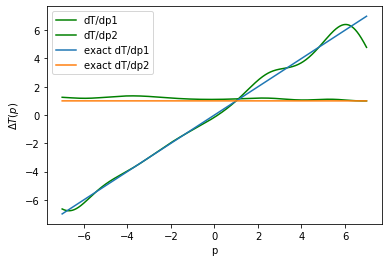

In [886]:
#Testing for tau = 0.09, F3, its = 1000
nums = np.arange(-7,7,0.01)
nu = np.ones([len(nums), 2])
nu[:,0] = nums

nu2 = nu.copy()
nu2[:,1] = nums/2

res1 = np.zeros([len(nums), 2])
res2 = np.zeros([len(nums), 2])
res3 = np.zeros([len(nums), 2])
res4 = np.zeros([len(nums), 2])


print(ac_pp, bc_pp, ay_pp, by_pp)
for i in range(len(nums)):
    res1[i] = Delta_T1(nu[i])
    res2[i] = Delta_V1(nu[i])


plt.plot(nums, res1[:,0], 'green', label = 'dT/dp1')
plt.plot(nums, res1[:,1], 'green', label = 'dT/dp2')

plt.plot(nums, nums, label = 'exact dT/dp1')
plt.plot(nums, nu[:,1], label = 'exact dT/dp2')



plt.legend()
plt.xlabel(r'$p_1$')
plt.ylabel(r'$\Delta T(p)$')


[-7.   -6.99 -6.98 ...  6.97  6.98  6.99]


Text(0, 0.5, '$\\Delta V(q)$')

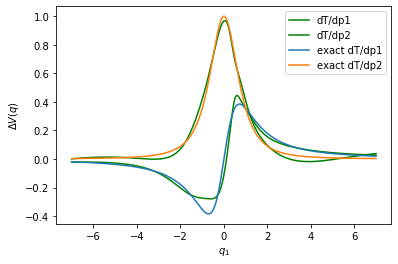

In [887]:
plt.plot(nums, res2[:,0], 'green', label = 'dT/dp1')
plt.plot(nums, res2[:,1], 'green', label = 'dT/dp2')

print(nu[:,0])
dVdq = V1234(nu)

plt.plot(nums, dVdq[0], label = 'exact dT/dp1')
plt.plot(nums, dVdq[1], label = 'exact dT/dp2')



plt.legend()
plt.xlabel(r'$q_1$')
plt.ylabel(r'$\Delta V(q)$')


6) Symplectic Euler and Størmer-Verlet for the test function

[[-0.5  0.   0.  ...  0.   0.   0. ]
 [ 0.5  0.   0.  ...  0.   0.   0. ]]
[[0.8 0.  0.  ... 0.  0.  0. ]
 [0.1 0.  0.  ... 0.  0.  0. ]]
[[-0.5  0.   0.  ...  0.   0.   0. ]
 [ 0.5  0.   0.  ...  0.   0.   0. ]]
[[0.8 0.  0.  ... 0.  0.  0. ]
 [0.1 0.  0.  ... 0.  0.  0. ]]
[0.5        0.49980791 0.49961456 ... 0.51501455 0.51507694 0.51513861]
[ 0.1         0.1005      0.10099981 ... -0.04371449 -0.04319947
 -0.0426844 ]
[[-0.5        -0.50139709 -0.5027948  ... -0.62623247 -0.62477415
  -0.62331848]
 [ 0.5         0.49987119  0.49974057 ...  0.14576946  0.14506596
   0.14436496]]
[[ 0.8         0.799393    0.79878482 ... -0.72227122 -0.72297345
  -0.72367445]
 [ 0.1         0.10045667  0.1009132  ...  0.36260895  0.36261449
   0.36261911]]


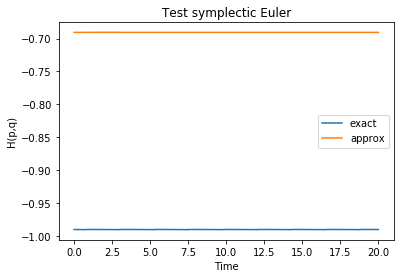

In [919]:
t = np.arange(-0.001,20,0.001)
p_exact_se, q_exact_se = symplectic_euler([-0.5,0.5], [0.8,0.1], dTdp, dVdq2, t)
p_exact_sv, q_exact_sv = stormer_verlet([-0.5,0.5], [0.8,0.1], dTdp, dVdq2, t)

p_se, q_se = symplectic_euler([-0.5,0.5], [0.8,0.1], Delta_T1, Delta_V1, t)
p_sv, q_sv = stormer_verlet([-0.5,0.5], [0.8,0.1], Delta_T1, Delta_V1, t)

l = len(t)
T_res_test_se = np.zeros(l)
V_res_test_se = np.zeros(l)
T_res_test_sv = np.zeros(l)
V_res_test_sv = np.zeros(l)
for i in range(l):
    
    T_res_test_se[i] = run_training_alg(4, p_se[:,i], tht_p[-1], sig2, eta2, h, ac_pp, bc_pp, ay_pp, by_pp)
    V_res_test_se[i] = run_training_alg(4, q_se[:,i], tht_q[-1], sig2, eta2, h, ac_qq, bc_qq, ay_qq, by_qq)

    T_res_test_sv[i] = run_training_alg(4, p_sv[:,i], tht_p[-1], sig2, eta2, h, ac_pp, bc_pp, ay_pp, by_pp)
    V_res_test_sv[i] = run_training_alg(4, q_sv[:,i], tht_q[-1], sig2, eta2, h, ac_qq, bc_qq, ay_qq, by_qq)


    

plt.plot(t, H2(p_exact_se,q_exact_se)[:len(t)], label = 'exact')
plt.plot(t, T_res_test_se + V_res_test_se, label = 'approx' )
#plt.plot(t, T_res_test_sv)
#plt.plot(t, V_res_test_sv)
plt.xlabel("Time")
plt.ylabel("H(p,q)")
plt.title("Test symplectic Euler")
plt.legend()
# T(p) + V(q) = H = const
# eksakt hamilton vs neural H

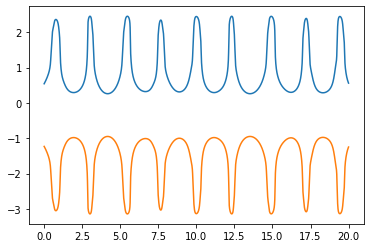

In [949]:
plt.plot(t, T_res_test_sv)
plt.plot(t, V_res_test_sv)

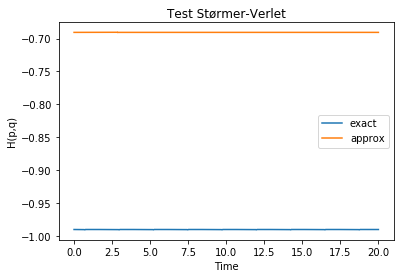

In [920]:
plt.plot(t, H2(p_exact_sv,q_exact_sv)[:len(t)], label = 'exact')
plt.plot(t, T_res_test_sv + V_res_test_sv, label = 'approx' )
plt.xlabel("Time")
plt.ylabel("H(p,q)")
plt.title("Test Størmer-Verlet")
plt.legend()

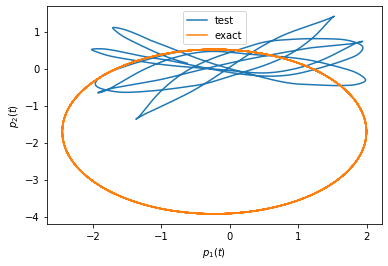

In [921]:
plt.plot(p_se[0],p_se[1], label = 'test')
plt.plot(p_exact_se[0], p_exact_se[1], label = 'exact' )
plt.xlabel(r'$p_1(t)$')
plt.ylabel(r'$p_2(t)$')
plt.legend()

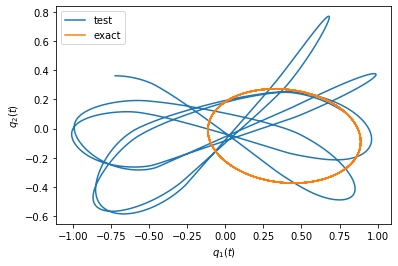

In [922]:
plt.plot(q_se[0],q_se[1], label = 'test')
plt.plot(q_exact_se[0], q_exact_se[1], label = 'exact' )
plt.xlabel(r'$q_1(t)$')
plt.ylabel(r'$q_2(t)$')
plt.legend()

7 ) Symplectic Euler and Størmer-Verlet for the unknown Hamiltonian

In [928]:
dt = np.arange(0, 50, 0.001)
p0 = Pl[:,0]
q0 = Ql[:,0]
#print(q0, p0)

#Delta_F( p0, thet_p[-1], prime_eta2, prime_sig2, 0.05)

In [950]:


p_se, q_se = symplectic_euler(p0, q0, Delta_T, Delta_V, dt)
p_sv, q_sv = stormer_verlet(p0, q0, Delta_T, Delta_V, dt)

#print(p_se)

print((p_se[0]))
print((Pl[0]))


print(np.linalg.norm(p_se, axis=0))
error_points_se_p = np.linalg.norm(p_se, axis=0)
error_points_sv_p = np.linalg.norm(p_sv, axis=0)
error_points_se_q = np.linalg.norm(q_se, axis=0)
error_points_sv_q = np.linalg.norm(q_sv, axis=0)

'''''
#T and V for Symplectic Euler
T_se = run_training_alg2(6, p_se, thet_p[-1], sig2, eta2, 0.05, ac_p, bc_p, aa, bb)
V_se = run_training_alg2(6, q_se, thet_q[-1], sig2, eta2, 0.05, ac_q, bc_q, cc, dd)

#T and V for Størmer-Verlet
T_sv = run_training_alg2(6, p_sv, thet_p[-1], sig2, eta2, 0.05, ac_p, bc_p, aa, bb)
V_sv = run_training_alg2(6, q_sv, thet_q[-1], sig2, eta2, 0.05, ac_q, bc_q, cc, dd)
'''''

[[0.16989158 0.         0.         ... 0.         0.         0.        ]
 [0.29344746 0.         0.         ... 0.         0.         0.        ]
 [0.9104984  0.         0.         ... 0.         0.         0.        ]]
[[0.0789248  0.         0.         ... 0.         0.         0.        ]
 [0.66664708 0.         0.         ... 0.         0.         0.        ]
 [0.86372762 0.         0.         ... 0.         0.         0.        ]]
[ 0.16989158  0.16990209  0.16991255 ... -0.29455126 -0.29479527
 -0.29503904]
[0.16989158 0.16985487 0.16981713 ... 0.34430051 0.34477829 0.34525137]
[0.97158731 0.97147052 0.97135325 ... 0.46700421 0.46713381 0.46726357]


"''\n#T and V for Symplectic Euler\nT_se = run_training_alg2(6, p_se, thet_p[-1], sig2, eta2, 0.05, ac_p, bc_p, aa, bb)\nV_se = run_training_alg2(6, q_se, thet_q[-1], sig2, eta2, 0.05, ac_q, bc_q, cc, dd)\n\n#T and V for Størmer-Verlet\nT_sv = run_training_alg2(6, p_sv, thet_p[-1], sig2, eta2, 0.05, ac_p, bc_p, aa, bb)\nV_sv = run_training_alg2(6, q_sv, thet_q[-1], sig2, eta2, 0.05, ac_q, bc_q, cc, dd)\n"

Plot of the difference between the exact Hamiltonian along the trajectory and the Hamiltonian calculated from Størmer-Verlet.

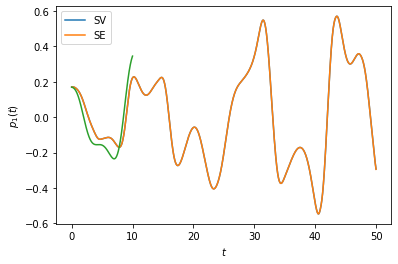

In [933]:

plt.plot(dt,p_sv[0][:-1], label = 'SV')
plt.plot(dt,p_se[0][:-1], label = 'SE')
plt.plot(tl, Pl[0])

plt.xlabel(r'$t$')
plt.ylabel(r'$p_1(t)$')
plt.legend()

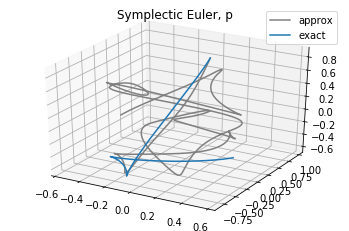

In [931]:

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot3D(p_se[0], p_se[1], p_se[2], 'gray', label = "approx")
ax.plot3D(Pl[0], Pl[1], Pl[2], label = "exact")
plt.title("Symplectic Euler, p")
plt.legend()

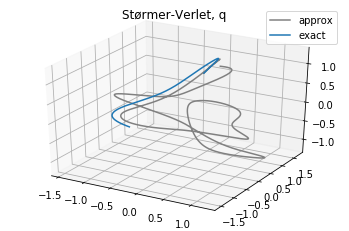

In [932]:

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot3D(q_sv[0], q_sv[1], q_sv[2], 'gray', label = "approx")
ax.plot3D(Ql[0], Ql[1], Ql[2], label = "exact")
plt.title("Størmer-Verlet, q")
plt.legend()

Text(0.5, 1.0, 'Test symplectic Euler')

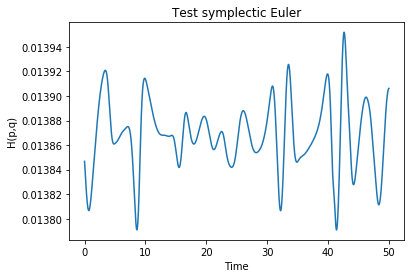

In [957]:
#Printing Hamiltonian for the neural network.
l = len(dt)
T_res = np.zeros(l)
V_res = np.zeros(l)
for i in range(l):
    T_res[i] = run_training_alg(6, p_se[:,i], thet_p[-1], sig2, eta2, 0.05, ac_p, bc_p, aa, bb )
    V_res[i] = run_training_alg(6, q_se[:,i], thet_q[-1], sig2, eta2, 0.05, ac_q, bc_q, cc, dd )


plt.plot(dt, T_res + V_res, label = 'SE' )

#plt.plot(t, T_res_test_sv)
#plt.plot(t, V_res_test_sv)
plt.xlabel("Time")
plt.ylabel("H(p,q)")
plt.title("Test symplectic Euler")